In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"
np.random.seed(12001)


# Define the model that generates pair simulations.
yuima = importr("yuima")
n_jumpou_NIG_sim_string = """
n_jumpou_NIG = function(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  jumpcoef = matrix(c("j11", "j12", "j21", "j22"), 2, 2, byrow=TRUE) 
  
  alpha = alpha
  beta = c(beta1, beta2)
  delta0 = delta0
  mu = c(mu1, mu2)
  Lambda = matrix(c(lambda11, lambda12, lambda21, lambda22), 2, 2, byrow=TRUE)
  
  ou_model = setModel(drift=drift, diffusion=diffusion, jump.coeff=jumpcoef, 
                      measure.type="code",
                      measure=list(df="rNIG(z, alpha, beta, delta0, mu, Lambda)"), 
                      time.variable = "t",
                      state.var=c("X1","X2"), solve.variable=c("X1","X2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    jumpou_sim = simulate(ou_model, 
                          true.par=list(
                            mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                            sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                            j11=j11, j12=j12, j21=j21, j22=j22,
                            alpha=alpha, beta=beta, delta0=delta0, mu=mu, Lambda=Lambda), 
                          xinit=xinit_vec[[i]], sampling=newsamp)
    original_data = jumpou_sim@data@original.data
    one_sim_jumpou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_jumpou) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_jumpou
  }
  return(n_sim_data)
}
"""

n_jumpou_NIG_sim = SignatureTranslatedAnonymousPackage(n_jumpou_NIG_sim_string, "n_jumpou_NIG_sim")
def n_jumpou_simulation(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_jumpou_NIG_sim.n_jumpou_NIG(random_seed, num_sim,
                                      mu11, mu12, mu21, mu22, 
                                      sigma11, sigma12, sigma21, sigma22,
                                      j11, j12, j21, j22,
                                      alpha, beta1, beta2, delta0, mu1, mu2, 
                                      lambda11, lambda12, lambda21, lambda22,
                                      xinit_vec, T0, T, length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef

def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series1.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values #8(8)
    
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) #6(14)
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(21)
    
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#6(27)
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, #8(8)
                               
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,#6(14)
                               
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
                               
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)
                               
                               corr_sqts1_lag_0,
                               corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
                               corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3])#7(34)
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
        'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3']
    
    return stats_data



def loss_function(params):

    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_jumpou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=params[12], 
        beta1=beta1, beta2=beta2, 
        delta0=params[13], 
        mu1=params[14], mu2=params[15], 
        lambda11=params[16], lambda12=lambda12, 
        lambda21=lambda21, lambda22=1/params[16],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)

    moment_loss = np.abs(n_real_stats - n_sim_stats)
    sum_loss = np.sum(moment_loss)
    loss = np.sum(sum_loss)

    print(sum_loss)
    print(loss)
    print('----------')

    return loss



real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_calibration.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_calibration.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]
n_real_stats = real_stats


#alpha
beta1 = 0
beta2 = 0
#delta0
#mu1
#mu2
#lambda11 = 1
lambda12 = 0
lambda21 = 0
#lambda22 = 1


initial0 = [1, 1, 1, 1,
            -1, -1, -1, -1,
            0.1, 0.1, 0.1, 0.1,
            1, 1,
            1, 1,
            1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (0, None), (0, None),
                       (None, None), (None, None), 
                       (0, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

 [1]  1.0  1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1  0.1  1.0  1.0  1.0
[16]  1.0  1.0

return_mean1                          235.938075
return_mean2                          223.945751
return_sd1                            443.113120
return_sd2                            425.421813
return_skew1                          182.161131
return_skew2                          182.161131
return_kurtosis1                     1291.961901
return_kurtosis2                     1759.522748
return_autocorrelation_ts1_lag1        18.001235
return_autocorrelation_ts1_lag2        17.791063
return_autocorrelation_ts1_lag3        18.372659
return_autocorrelation_ts2_lag1        17.575148
return_autocorrelation_ts2_lag2        17.489304
return_autocorrelation_ts2_lag3        17.492160
return_correlation_ts1_lag_0          168.052491
return_correlation_ts1_lag_1           17.912513
return_correlation_ts1_lag_2           16.837455
return_correlation_ts1_lag_3           19.050002
return_correlation_ts2

return_mean1                          175.208022
return_mean2                          222.145355
return_sd1                            454.467201
return_sd2                            435.254095
return_skew1                          195.059160
return_skew2                          195.059160
return_kurtosis1                     1445.328415
return_kurtosis2                     1903.843964
return_autocorrelation_ts1_lag1        19.152953
return_autocorrelation_ts1_lag2        19.299577
return_autocorrelation_ts1_lag3        16.714982
return_autocorrelation_ts2_lag1        19.414467
return_autocorrelation_ts2_lag2        18.568196
return_autocorrelation_ts2_lag3        16.970682
return_correlation_ts1_lag_0          167.888332
return_correlation_ts1_lag_1           19.115636
return_correlation_ts1_lag_2           18.198574
return_correlation_ts1_lag_3           17.545974
return_correlation_ts2_lag_1           18.975344
return_correlation_ts2_lag_2           17.924133
return_correlation_t

return_mean1                          210.372621
return_mean2                          222.691001
return_sd1                            452.973179
return_sd2                            436.259147
return_skew1                          198.806545
return_skew2                          198.806545
return_kurtosis1                     1508.854144
return_kurtosis2                     1939.728690
return_autocorrelation_ts1_lag1        19.300681
return_autocorrelation_ts1_lag2        18.669370
return_autocorrelation_ts1_lag3        18.473603
return_autocorrelation_ts2_lag1        18.421744
return_autocorrelation_ts2_lag2        18.427345
return_autocorrelation_ts2_lag3        19.499348
return_correlation_ts1_lag_0          168.017126
return_correlation_ts1_lag_1           17.594284
return_correlation_ts1_lag_2           17.696281
return_correlation_ts1_lag_3           21.443158
return_correlation_ts2_lag_1           18.124946
return_correlation_ts2_lag_2           18.255674
return_correlation_t

return_mean1                          210.108465
return_mean2                          220.442254
return_sd1                            443.694091
return_sd2                            427.750374
return_skew1                          189.390863
return_skew2                          189.390863
return_kurtosis1                     1345.285802
return_kurtosis2                     1848.575688
return_autocorrelation_ts1_lag1        19.155514
return_autocorrelation_ts1_lag2        17.866137
return_autocorrelation_ts1_lag3        16.719424
return_autocorrelation_ts2_lag1        19.279567
return_autocorrelation_ts2_lag2        17.375999
return_autocorrelation_ts2_lag3        17.123655
return_correlation_ts1_lag_0          168.021853
return_correlation_ts1_lag_1           18.114443
return_correlation_ts1_lag_2           18.229838
return_correlation_ts1_lag_3           19.163538
return_correlation_ts2_lag_1           18.877526
return_correlation_ts2_lag_2           18.052608
return_correlation_t

return_mean1                          211.166980
return_mean2                          221.562445
return_sd1                            452.520524
return_sd2                            435.892118
return_skew1                          198.969308
return_skew2                          198.969308
return_kurtosis1                     1552.130853
return_kurtosis2                     2016.444848
return_autocorrelation_ts1_lag1        19.634368
return_autocorrelation_ts1_lag2        19.401095
return_autocorrelation_ts1_lag3        17.886432
return_autocorrelation_ts2_lag1        19.251106
return_autocorrelation_ts2_lag2        20.039602
return_autocorrelation_ts2_lag3        18.849464
return_correlation_ts1_lag_0          168.024510
return_correlation_ts1_lag_1           18.477994
return_correlation_ts1_lag_2           17.325215
return_correlation_ts1_lag_3           18.709221
return_correlation_ts2_lag_1           18.535622
return_correlation_ts2_lag_2           18.620600
return_correlation_t

return_mean1                          213.335469
return_mean2                          223.852271
return_sd1                            445.362148
return_sd2                            428.397761
return_skew1                          179.699810
return_skew2                          179.699810
return_kurtosis1                     1283.114817
return_kurtosis2                     1803.957822
return_autocorrelation_ts1_lag1        18.317862
return_autocorrelation_ts1_lag2        19.012382
return_autocorrelation_ts1_lag3        17.896865
return_autocorrelation_ts2_lag1        19.284601
return_autocorrelation_ts2_lag2        19.397331
return_autocorrelation_ts2_lag3        19.746474
return_correlation_ts1_lag_0          168.020465
return_correlation_ts1_lag_1           17.985971
return_correlation_ts1_lag_2           19.049600
return_correlation_ts1_lag_3           18.414047
return_correlation_ts2_lag_1           19.033790
return_correlation_ts2_lag_2           17.769391
return_correlation_t

return_mean1                           88.069558
return_mean2                          225.176195
return_sd1                            443.898904
return_sd2                            431.667649
return_skew1                          188.255066
return_skew2                          188.255066
return_kurtosis1                     1339.620020
return_kurtosis2                     1821.406203
return_autocorrelation_ts1_lag1        18.343264
return_autocorrelation_ts1_lag2        18.624074
return_autocorrelation_ts1_lag3        18.307154
return_autocorrelation_ts2_lag1        18.508790
return_autocorrelation_ts2_lag2        16.813172
return_autocorrelation_ts2_lag3        19.040184
return_correlation_ts1_lag_0          167.667277
return_correlation_ts1_lag_1           18.432168
return_correlation_ts1_lag_2           17.830940
return_correlation_ts1_lag_3           19.187326
return_correlation_ts2_lag_1           18.780736
return_correlation_ts2_lag_2           17.991269
return_correlation_t

return_mean1                           61.671402
return_mean2                          221.930815
return_sd1                            442.187297
return_sd2                            429.567646
return_skew1                          194.473718
return_skew2                          194.473718
return_kurtosis1                     1344.967536
return_kurtosis2                     1838.612703
return_autocorrelation_ts1_lag1        19.311880
return_autocorrelation_ts1_lag2        18.431119
return_autocorrelation_ts1_lag3        18.229794
return_autocorrelation_ts2_lag1        19.788918
return_autocorrelation_ts2_lag2        19.697187
return_autocorrelation_ts2_lag3        18.847628
return_correlation_ts1_lag_0          167.687938
return_correlation_ts1_lag_1           18.269645
return_correlation_ts1_lag_2           18.247893
return_correlation_ts1_lag_3           18.537717
return_correlation_ts2_lag_1           20.224043
return_correlation_ts2_lag_2           18.333674
return_correlation_t

return_mean1                           71.543582
return_mean2                          222.687349
return_sd1                            444.823321
return_sd2                            433.651846
return_skew1                          192.316225
return_skew2                          192.316225
return_kurtosis1                     1294.809879
return_kurtosis2                     1894.183650
return_autocorrelation_ts1_lag1        17.742628
return_autocorrelation_ts1_lag2        18.043405
return_autocorrelation_ts1_lag3        18.583762
return_autocorrelation_ts2_lag1        19.302802
return_autocorrelation_ts2_lag2        19.022109
return_autocorrelation_ts2_lag3        18.638353
return_correlation_ts1_lag_0          167.677057
return_correlation_ts1_lag_1           16.804519
return_correlation_ts1_lag_2           18.340314
return_correlation_ts1_lag_3           19.184311
return_correlation_ts2_lag_1           19.145745
return_correlation_ts2_lag_2           18.447096
return_correlation_t

return_mean1                           72.429340
return_mean2                          220.286778
return_sd1                            439.410406
return_sd2                            427.360637
return_skew1                          182.747256
return_skew2                          182.747256
return_kurtosis1                     1199.403069
return_kurtosis2                     1833.385945
return_autocorrelation_ts1_lag1        19.793541
return_autocorrelation_ts1_lag2        17.721019
return_autocorrelation_ts1_lag3        17.789593
return_autocorrelation_ts2_lag1        18.015379
return_autocorrelation_ts2_lag2        18.531306
return_autocorrelation_ts2_lag3        16.817813
return_correlation_ts1_lag_0          167.684994
return_correlation_ts1_lag_1           18.496781
return_correlation_ts1_lag_2           18.209079
return_correlation_ts1_lag_3           18.049587
return_correlation_ts2_lag_1           19.222098
return_correlation_ts2_lag_2           17.618244
return_correlation_t

return_mean1                           69.700137
return_mean2                          263.402516
return_sd1                            442.611368
return_sd2                            429.402687
return_skew1                          194.822829
return_skew2                          194.822829
return_kurtosis1                     1357.692104
return_kurtosis2                     1864.712250
return_autocorrelation_ts1_lag1        19.337929
return_autocorrelation_ts1_lag2        18.632230
return_autocorrelation_ts1_lag3        18.573024
return_autocorrelation_ts2_lag1        17.581886
return_autocorrelation_ts2_lag2        17.763493
return_autocorrelation_ts2_lag3        17.559066
return_correlation_ts1_lag_0          167.910802
return_correlation_ts1_lag_1           18.960757
return_correlation_ts1_lag_2           17.394363
return_correlation_ts1_lag_3           19.813539
return_correlation_ts2_lag_1           19.573016
return_correlation_ts2_lag_2           17.761686
return_correlation_t

return_mean1                           70.338397
return_mean2                          252.924515
return_sd1                            442.498874
return_sd2                            428.510740
return_skew1                          204.898543
return_skew2                          204.898543
return_kurtosis1                     1340.351617
return_kurtosis2                     1800.533745
return_autocorrelation_ts1_lag1        19.665219
return_autocorrelation_ts1_lag2        18.692115
return_autocorrelation_ts1_lag3        18.230777
return_autocorrelation_ts2_lag1        18.561550
return_autocorrelation_ts2_lag2        19.160697
return_autocorrelation_ts2_lag3        18.882077
return_correlation_ts1_lag_0          167.874695
return_correlation_ts1_lag_1           18.690835
return_correlation_ts1_lag_2           18.213394
return_correlation_ts1_lag_3           18.621953
return_correlation_ts2_lag_1           20.176516
return_correlation_ts2_lag_2           17.989148
return_correlation_t

return_mean1                           72.458656
return_mean2                          244.034385
return_sd1                            440.724283
return_sd2                            429.307063
return_skew1                          186.346146
return_skew2                          186.346146
return_kurtosis1                     1232.289408
return_kurtosis2                     1753.951588
return_autocorrelation_ts1_lag1        17.199516
return_autocorrelation_ts1_lag2        18.547395
return_autocorrelation_ts1_lag3        18.554709
return_autocorrelation_ts2_lag1        16.927052
return_autocorrelation_ts2_lag2        18.393655
return_autocorrelation_ts2_lag3        17.762444
return_correlation_ts1_lag_0          167.851206
return_correlation_ts1_lag_1           17.305058
return_correlation_ts1_lag_2           18.134415
return_correlation_ts1_lag_3           18.908103
return_correlation_ts2_lag_1           17.715650
return_correlation_ts2_lag_2           18.000551
return_correlation_t

return_mean1                           66.379276
return_mean2                          251.715066
return_sd1                            441.483907
return_sd2                            428.187279
return_skew1                          184.233584
return_skew2                          184.233584
return_kurtosis1                     1314.567778
return_kurtosis2                     1788.260008
return_autocorrelation_ts1_lag1        16.582319
return_autocorrelation_ts1_lag2        18.094627
return_autocorrelation_ts1_lag3        18.163657
return_autocorrelation_ts2_lag1        17.034505
return_autocorrelation_ts2_lag2        17.029457
return_autocorrelation_ts2_lag3        18.007374
return_correlation_ts1_lag_0          167.829721
return_correlation_ts1_lag_1           17.875990
return_correlation_ts1_lag_2           16.776350
return_correlation_ts1_lag_3           18.385743
return_correlation_ts2_lag_1           17.986974
return_correlation_ts2_lag_2           17.397563
return_correlation_t

return_mean1                           73.796701
return_mean2                          349.932207
return_sd1                            435.342463
return_sd2                            446.868408
return_skew1                          189.486749
return_skew2                          189.486749
return_kurtosis1                     1389.214610
return_kurtosis2                     1830.183428
return_autocorrelation_ts1_lag1        18.389653
return_autocorrelation_ts1_lag2        17.570969
return_autocorrelation_ts1_lag3        18.394294
return_autocorrelation_ts2_lag1        22.072884
return_autocorrelation_ts2_lag2        22.299451
return_autocorrelation_ts2_lag3        21.672398
return_correlation_ts1_lag_0          163.619315
return_correlation_ts1_lag_1           17.835617
return_correlation_ts1_lag_2           17.975153
return_correlation_ts1_lag_3           19.332553
return_correlation_ts2_lag_1           18.511319
return_correlation_ts2_lag_2           16.300011
return_correlation_t

return_mean1                           72.045731
return_mean2                          144.736182
return_sd1                            442.727528
return_sd2                            425.407378
return_skew1                          192.828274
return_skew2                          192.828274
return_kurtosis1                     1401.468917
return_kurtosis2                     1740.912301
return_autocorrelation_ts1_lag1        17.273279
return_autocorrelation_ts1_lag2        19.035885
return_autocorrelation_ts1_lag3        20.836132
return_autocorrelation_ts2_lag1        17.755916
return_autocorrelation_ts2_lag2        16.416401
return_autocorrelation_ts2_lag3        18.973322
return_correlation_ts1_lag_0          167.996544
return_correlation_ts1_lag_1           18.162266
return_correlation_ts1_lag_2           17.390888
return_correlation_ts1_lag_3           21.428231
return_correlation_ts2_lag_1           18.852291
return_correlation_ts2_lag_2           17.112550
return_correlation_t

return_mean1                           72.203439
return_mean2                           47.680849
return_sd1                            440.596957
return_sd2                            423.415144
return_skew1                          188.687822
return_skew2                          188.687822
return_kurtosis1                     1347.465025
return_kurtosis2                     1866.370239
return_autocorrelation_ts1_lag1        19.037762
return_autocorrelation_ts1_lag2        18.873331
return_autocorrelation_ts1_lag3        19.323331
return_autocorrelation_ts2_lag1        17.833929
return_autocorrelation_ts2_lag2        18.604876
return_autocorrelation_ts2_lag3        19.682643
return_correlation_ts1_lag_0          167.891357
return_correlation_ts1_lag_1           18.163266
return_correlation_ts1_lag_2           17.695912
return_correlation_ts1_lag_3           19.204070
return_correlation_ts2_lag_1           18.488383
return_correlation_ts2_lag_2           17.611034
return_correlation_t

return_mean1                           74.157688
return_mean2                           42.386780
return_sd1                            442.513964
return_sd2                            425.187821
return_skew1                          177.691248
return_skew2                          177.691248
return_kurtosis1                     1275.296201
return_kurtosis2                     1759.102562
return_autocorrelation_ts1_lag1        18.991771
return_autocorrelation_ts1_lag2        18.673339
return_autocorrelation_ts1_lag3        19.007677
return_autocorrelation_ts2_lag1        18.712512
return_autocorrelation_ts2_lag2        19.161112
return_autocorrelation_ts2_lag3        18.764419
return_correlation_ts1_lag_0          167.894339
return_correlation_ts1_lag_1           17.816952
return_correlation_ts1_lag_2           18.450857
return_correlation_ts1_lag_3           20.294356
return_correlation_ts2_lag_1           18.913185
return_correlation_ts2_lag_2           19.996508
return_correlation_t

return_mean1                           76.601897
return_mean2                           47.554823
return_sd1                            435.480685
return_sd2                            419.202327
return_skew1                          182.185475
return_skew2                          182.185475
return_kurtosis1                     1279.282870
return_kurtosis2                     1745.061567
return_autocorrelation_ts1_lag1        20.294213
return_autocorrelation_ts1_lag2        17.978282
return_autocorrelation_ts1_lag3        19.018105
return_autocorrelation_ts2_lag1        18.557353
return_autocorrelation_ts2_lag2        17.809913
return_autocorrelation_ts2_lag3        18.189672
return_correlation_ts1_lag_0          167.891950
return_correlation_ts1_lag_1           18.289951
return_correlation_ts1_lag_2           17.455632
return_correlation_ts1_lag_3           20.250379
return_correlation_ts2_lag_1           19.919722
return_correlation_ts2_lag_2           16.985782
return_correlation_t

return_mean1                           68.362324
return_mean2                           49.480538
return_sd1                            290.898818
return_sd2                            423.159934
return_skew1                          213.986807
return_skew2                          213.986807
return_kurtosis1                     1502.223255
return_kurtosis2                     1818.796931
return_autocorrelation_ts1_lag1        19.319710
return_autocorrelation_ts1_lag2        19.010258
return_autocorrelation_ts1_lag3        17.107782
return_autocorrelation_ts2_lag1        17.404871
return_autocorrelation_ts2_lag2        18.713881
return_autocorrelation_ts2_lag3        18.670224
return_correlation_ts1_lag_0          157.687325
return_correlation_ts1_lag_1           18.055684
return_correlation_ts1_lag_2           18.369691
return_correlation_ts1_lag_3           18.627430
return_correlation_ts2_lag_1           19.497471
return_correlation_ts2_lag_2           18.051297
return_correlation_t

return_mean1                           68.564528
return_mean2                           47.068014
return_sd1                            325.796266
return_sd2                            418.563517
return_skew1                          198.536422
return_skew2                          198.536422
return_kurtosis1                     1424.659320
return_kurtosis2                     1805.935511
return_autocorrelation_ts1_lag1        18.590593
return_autocorrelation_ts1_lag2        19.886806
return_autocorrelation_ts1_lag3        18.970970
return_autocorrelation_ts2_lag1        18.681754
return_autocorrelation_ts2_lag2        18.428404
return_autocorrelation_ts2_lag3        19.270399
return_correlation_ts1_lag_0          163.395552
return_correlation_ts1_lag_1           18.056191
return_correlation_ts1_lag_2           18.606558
return_correlation_ts1_lag_3           19.338796
return_correlation_ts2_lag_1           18.863642
return_correlation_ts2_lag_2           19.305463
return_correlation_t

return_mean1                           71.487774
return_mean2                           53.241943
return_sd1                            336.107526
return_sd2                            424.499922
return_skew1                          201.308509
return_skew2                          201.308509
return_kurtosis1                     1406.361245
return_kurtosis2                     1904.981722
return_autocorrelation_ts1_lag1        17.379901
return_autocorrelation_ts1_lag2        18.079586
return_autocorrelation_ts1_lag3        17.869083
return_autocorrelation_ts2_lag1        18.314247
return_autocorrelation_ts2_lag2        17.185479
return_autocorrelation_ts2_lag3        18.655429
return_correlation_ts1_lag_0          164.089307
return_correlation_ts1_lag_1           17.045106
return_correlation_ts1_lag_2           17.169316
return_correlation_ts1_lag_3           18.716165
return_correlation_ts2_lag_1           18.820284
return_correlation_ts2_lag_2           18.000357
return_correlation_t

return_mean1                           71.984391
return_mean2                           46.802294
return_sd1                            330.160782
return_sd2                            419.993677
return_skew1                          184.347580
return_skew2                          184.347580
return_kurtosis1                     1233.551595
return_kurtosis2                     1745.723341
return_autocorrelation_ts1_lag1        18.773138
return_autocorrelation_ts1_lag2        18.677314
return_autocorrelation_ts1_lag3        17.610608
return_autocorrelation_ts2_lag1        17.704177
return_autocorrelation_ts2_lag2        18.195402
return_autocorrelation_ts2_lag3        17.313918
return_correlation_ts1_lag_0          164.081351
return_correlation_ts1_lag_1           16.639152
return_correlation_ts1_lag_2           17.234315
return_correlation_ts1_lag_3           17.943332
return_correlation_ts2_lag_1           19.886879
return_correlation_ts2_lag_2           18.060000
return_correlation_t

return_mean1                           66.569485
return_mean2                           46.976114
return_sd1                            175.592050
return_sd2                            429.400319
return_skew1                          273.865873
return_skew2                          273.865873
return_kurtosis1                     1963.802865
return_kurtosis2                     1802.801466
return_autocorrelation_ts1_lag1        19.415512
return_autocorrelation_ts1_lag2        19.058365
return_autocorrelation_ts1_lag3        17.306199
return_autocorrelation_ts2_lag1        18.326095
return_autocorrelation_ts2_lag2        19.006286
return_autocorrelation_ts2_lag3        17.238118
return_correlation_ts1_lag_0          163.699203
return_correlation_ts1_lag_1           18.734627
return_correlation_ts1_lag_2           17.690563
return_correlation_ts1_lag_3           18.655570
return_correlation_ts2_lag_1           19.047379
return_correlation_ts2_lag_2           17.718400
return_correlation_t

return_mean1                           68.335914
return_mean2                           44.984540
return_sd1                            352.468459
return_sd2                            427.493095
return_skew1                          209.281923
return_skew2                          209.281923
return_kurtosis1                     1377.583386
return_kurtosis2                     1776.904170
return_autocorrelation_ts1_lag1        19.147631
return_autocorrelation_ts1_lag2        18.787207
return_autocorrelation_ts1_lag3        17.886289
return_autocorrelation_ts2_lag1        18.383572
return_autocorrelation_ts2_lag2        18.308782
return_autocorrelation_ts2_lag3        18.437823
return_correlation_ts1_lag_0          163.710792
return_correlation_ts1_lag_1           17.433118
return_correlation_ts1_lag_2           18.650630
return_correlation_ts1_lag_3           19.149724
return_correlation_ts2_lag_1           19.669933
return_correlation_ts2_lag_2           17.886579
return_correlation_t

return_mean1                           67.606882
return_mean2                           45.468218
return_sd1                            332.329833
return_sd2                            419.996804
return_skew1                          207.963224
return_skew2                          207.963224
return_kurtosis1                     1490.211808
return_kurtosis2                     1826.290883
return_autocorrelation_ts1_lag1        18.173799
return_autocorrelation_ts1_lag2        17.745820
return_autocorrelation_ts1_lag3        17.338547
return_autocorrelation_ts2_lag1        17.903283
return_autocorrelation_ts2_lag2        17.464841
return_autocorrelation_ts2_lag3        17.492178
return_correlation_ts1_lag_0          164.065440
return_correlation_ts1_lag_1           18.104460
return_correlation_ts1_lag_2           17.824723
return_correlation_ts1_lag_3           18.583024
return_correlation_ts2_lag_1           16.856373
return_correlation_ts2_lag_2           18.024175
return_correlation_t

return_mean1                           66.972299
return_mean2                           47.847752
return_sd1                            342.375602
return_sd2                            428.915754
return_skew1                          206.007602
return_skew2                          206.007602
return_kurtosis1                     1514.137049
return_kurtosis2                     1886.133652
return_autocorrelation_ts1_lag1        18.276201
return_autocorrelation_ts1_lag2        19.077538
return_autocorrelation_ts1_lag3        17.583043
return_autocorrelation_ts2_lag1        18.427137
return_autocorrelation_ts2_lag2        18.089216
return_autocorrelation_ts2_lag3        16.976556
return_correlation_ts1_lag_0          164.154553
return_correlation_ts1_lag_1           19.315488
return_correlation_ts1_lag_2           19.172565
return_correlation_ts1_lag_3           18.601646
return_correlation_ts2_lag_1           18.864889
return_correlation_ts2_lag_2           18.094551
return_correlation_t

return_mean1                           70.946023
return_mean2                           46.457061
return_sd1                            335.938900
return_sd2                            424.027890
return_skew1                          203.524155
return_skew2                          203.524155
return_kurtosis1                     1440.253664
return_kurtosis2                     1866.871113
return_autocorrelation_ts1_lag1        18.910035
return_autocorrelation_ts1_lag2        19.025366
return_autocorrelation_ts1_lag3        19.045034
return_autocorrelation_ts2_lag1        18.178953
return_autocorrelation_ts2_lag2        17.429554
return_autocorrelation_ts2_lag3        19.352453
return_correlation_ts1_lag_0          164.117998
return_correlation_ts1_lag_1           18.244904
return_correlation_ts1_lag_2           17.649037
return_correlation_ts1_lag_3           19.240966
return_correlation_ts2_lag_1           19.818167
return_correlation_ts2_lag_2           16.518183
return_correlation_t

return_mean1                           74.784434
return_mean2                           47.655352
return_sd1                            341.081193
return_sd2                            428.828847
return_skew1                          218.900114
return_skew2                          218.900114
return_kurtosis1                     1621.535491
return_kurtosis2                     2000.121950
return_autocorrelation_ts1_lag1        17.650633
return_autocorrelation_ts1_lag2        18.066806
return_autocorrelation_ts1_lag3        18.379872
return_autocorrelation_ts2_lag1        18.425247
return_autocorrelation_ts2_lag2        18.301911
return_autocorrelation_ts2_lag3        18.287641
return_correlation_ts1_lag_0          164.121307
return_correlation_ts1_lag_1           17.922039
return_correlation_ts1_lag_2           18.051770
return_correlation_ts1_lag_3           20.367929
return_correlation_ts2_lag_1           17.734844
return_correlation_ts2_lag_2           18.610042
return_correlation_t

return_mean1                           72.864569
return_mean2                           92.309594
return_sd1                            341.088762
return_sd2                           1260.562576
return_skew1                          204.608205
return_skew2                          204.608205
return_kurtosis1                     1499.516034
return_kurtosis2                     1782.595760
return_autocorrelation_ts1_lag1        18.403452
return_autocorrelation_ts1_lag2        19.241222
return_autocorrelation_ts1_lag3        17.266301
return_autocorrelation_ts2_lag1        18.956175
return_autocorrelation_ts2_lag2        19.209943
return_autocorrelation_ts2_lag3        19.104605
return_correlation_ts1_lag_0          122.516496
return_correlation_ts1_lag_1           17.865063
return_correlation_ts1_lag_2           18.577757
return_correlation_ts1_lag_3           18.943741
return_correlation_ts2_lag_1           18.447897
return_correlation_ts2_lag_2           19.017931
return_correlation_t

return_mean1                           70.013132
return_mean2                           54.324754
return_sd1                            335.749701
return_sd2                            622.983316
return_skew1                          210.611034
return_skew2                          210.611034
return_kurtosis1                     1525.967852
return_kurtosis2                     1852.460050
return_autocorrelation_ts1_lag1        18.876132
return_autocorrelation_ts1_lag2        17.609522
return_autocorrelation_ts1_lag3        18.501550
return_autocorrelation_ts2_lag1        19.287404
return_autocorrelation_ts2_lag2        19.103494
return_autocorrelation_ts2_lag3        17.530461
return_correlation_ts1_lag_0          151.872862
return_correlation_ts1_lag_1           18.266543
return_correlation_ts1_lag_2           17.884941
return_correlation_ts1_lag_3           17.392717
return_correlation_ts2_lag_1           18.699399
return_correlation_ts2_lag_2           17.740667
return_correlation_t

return_mean1                           65.098653
return_mean2                           50.390188
return_sd1                            333.752364
return_sd2                            513.770333
return_skew1                          198.717836
return_skew2                          198.717836
return_kurtosis1                     1421.336684
return_kurtosis2                     1811.823525
return_autocorrelation_ts1_lag1        18.791081
return_autocorrelation_ts1_lag2        19.706307
return_autocorrelation_ts1_lag3        19.339878
return_autocorrelation_ts2_lag1        17.055047
return_autocorrelation_ts2_lag2        18.165896
return_autocorrelation_ts2_lag3        18.806140
return_correlation_ts1_lag_0          158.677044
return_correlation_ts1_lag_1           17.833247
return_correlation_ts1_lag_2           18.086398
return_correlation_ts1_lag_3           19.898849
return_correlation_ts2_lag_1           19.041251
return_correlation_ts2_lag_2           18.663280
return_correlation_t

return_mean1                           69.985844
return_mean2                           56.470032
return_sd1                            324.883425
return_sd2                            532.696182
return_skew1                          191.985578
return_skew2                          191.985578
return_kurtosis1                     1279.130433
return_kurtosis2                     1777.726046
return_autocorrelation_ts1_lag1        17.481387
return_autocorrelation_ts1_lag2        17.637463
return_autocorrelation_ts1_lag3        17.647387
return_autocorrelation_ts2_lag1        17.341768
return_autocorrelation_ts2_lag2        18.226742
return_autocorrelation_ts2_lag3        17.750276
return_correlation_ts1_lag_0          156.544250
return_correlation_ts1_lag_1           18.171170
return_correlation_ts1_lag_2           16.828680
return_correlation_ts1_lag_3           18.673307
return_correlation_ts2_lag_1           18.581329
return_correlation_ts2_lag_2           18.377230
return_correlation_t

return_mean1                           68.956731
return_mean2                           54.284079
return_sd1                            334.924829
return_sd2                            543.706542
return_skew1                          191.198381
return_skew2                          191.198381
return_kurtosis1                     1248.815861
return_kurtosis2                     1757.521818
return_autocorrelation_ts1_lag1        18.552798
return_autocorrelation_ts1_lag2        19.830748
return_autocorrelation_ts1_lag3        17.139216
return_autocorrelation_ts2_lag1        17.189666
return_autocorrelation_ts2_lag2        18.831583
return_autocorrelation_ts2_lag3        17.703431
return_correlation_ts1_lag_0          156.588753
return_correlation_ts1_lag_1           18.277734
return_correlation_ts1_lag_2           19.107094
return_correlation_ts1_lag_3           18.073185
return_correlation_ts2_lag_1           19.320400
return_correlation_ts2_lag_2           18.192006
return_correlation_t

return_mean1                           70.705372
return_mean2                           52.240792
return_sd1                            345.046980
return_sd2                            554.554331
return_skew1                          223.969972
return_skew2                          223.969972
return_kurtosis1                     1496.400572
return_kurtosis2                     1818.292502
return_autocorrelation_ts1_lag1        19.611512
return_autocorrelation_ts1_lag2        18.385905
return_autocorrelation_ts1_lag3        17.946311
return_autocorrelation_ts2_lag1        18.260697
return_autocorrelation_ts2_lag2        17.613449
return_autocorrelation_ts2_lag3        19.866326
return_correlation_ts1_lag_0          156.854338
return_correlation_ts1_lag_1           18.203593
return_correlation_ts1_lag_2           17.357646
return_correlation_ts1_lag_3           19.035768
return_correlation_ts2_lag_1           20.023237
return_correlation_ts2_lag_2           18.289774
return_correlation_t

return_mean1                           63.979886
return_mean2                           48.797378
return_sd1                            336.779194
return_sd2                            417.661053
return_skew1                          218.110118
return_skew2                          218.110118
return_kurtosis1                     1578.486041
return_kurtosis2                     1902.494238
return_autocorrelation_ts1_lag1        17.923127
return_autocorrelation_ts1_lag2        19.961690
return_autocorrelation_ts1_lag3        17.712641
return_autocorrelation_ts2_lag1        17.529338
return_autocorrelation_ts2_lag2        17.106442
return_autocorrelation_ts2_lag3        17.649237
return_correlation_ts1_lag_0          131.928472
return_correlation_ts1_lag_1           17.638843
return_correlation_ts1_lag_2           18.351735
return_correlation_ts1_lag_3           19.318601
return_correlation_ts2_lag_1           19.730004
return_correlation_ts2_lag_2           18.617549
return_correlation_t

return_mean1                           65.770867
return_mean2                           47.884059
return_sd1                            342.365226
return_sd2                            395.643876
return_skew1                          223.719997
return_skew2                          223.719997
return_kurtosis1                     1541.694046
return_kurtosis2                     2033.302454
return_autocorrelation_ts1_lag1        17.060378
return_autocorrelation_ts1_lag2        17.833511
return_autocorrelation_ts1_lag3        20.118493
return_autocorrelation_ts2_lag1        17.423716
return_autocorrelation_ts2_lag2        17.323995
return_autocorrelation_ts2_lag3        17.733501
return_correlation_ts1_lag_0          118.420254
return_correlation_ts1_lag_1           17.565134
return_correlation_ts1_lag_2           17.807634
return_correlation_ts1_lag_3           19.787412
return_correlation_ts2_lag_1           17.218714
return_correlation_ts2_lag_2           19.065297
return_correlation_t

return_mean1                           69.531147
return_mean2                           45.442502
return_sd1                            339.569748
return_sd2                            392.410245
return_skew1                          209.758784
return_skew2                          209.758784
return_kurtosis1                     1364.955664
return_kurtosis2                     1895.608584
return_autocorrelation_ts1_lag1        18.674776
return_autocorrelation_ts1_lag2        18.713014
return_autocorrelation_ts1_lag3        17.378701
return_autocorrelation_ts2_lag1        18.455287
return_autocorrelation_ts2_lag2        17.768045
return_autocorrelation_ts2_lag3        17.946068
return_correlation_ts1_lag_0          119.844055
return_correlation_ts1_lag_1           18.640669
return_correlation_ts1_lag_2           17.390080
return_correlation_ts1_lag_3           18.543124
return_correlation_ts2_lag_1           19.043941
return_correlation_ts2_lag_2           17.614470
return_correlation_t

return_mean1                           68.952959
return_mean2                           44.287874
return_sd1                            335.583538
return_sd2                            393.922785
return_skew1                          193.740209
return_skew2                          193.740209
return_kurtosis1                     1438.169973
return_kurtosis2                     1843.472908
return_autocorrelation_ts1_lag1        18.713471
return_autocorrelation_ts1_lag2        18.006386
return_autocorrelation_ts1_lag3        18.788683
return_autocorrelation_ts2_lag1        18.026217
return_autocorrelation_ts2_lag2        18.715597
return_autocorrelation_ts2_lag3        18.511587
return_correlation_ts1_lag_0          119.683680
return_correlation_ts1_lag_1           18.273912
return_correlation_ts1_lag_2           18.439509
return_correlation_ts1_lag_3           19.432852
return_correlation_ts2_lag_1           19.881425
return_correlation_ts2_lag_2           18.766408
return_correlation_t

return_mean1                           145.534669
return_mean2                            46.395645
return_sd1                            1799.527144
return_sd2                             394.888925
return_skew1                          1297.990795
return_skew2                          1297.990795
return_kurtosis1                     15563.454958
return_kurtosis2                      1973.540488
return_autocorrelation_ts1_lag1         17.026517
return_autocorrelation_ts1_lag2         16.845986
return_autocorrelation_ts1_lag3         17.600798
return_autocorrelation_ts2_lag1         18.192484
return_autocorrelation_ts2_lag2         18.583166
return_autocorrelation_ts2_lag3         18.608006
return_correlation_ts1_lag_0            65.234456
return_correlation_ts1_lag_1            16.918998
return_correlation_ts1_lag_2            17.278926
return_correlation_ts1_lag_3            19.249806
return_correlation_ts2_lag_1            18.426037
return_correlation_ts2_lag_2            18.139699


return_mean1                           64.148318
return_mean2                           47.603015
return_sd1                            322.349041
return_sd2                            387.732109
return_skew1                          175.130788
return_skew2                          175.130788
return_kurtosis1                     1285.238093
return_kurtosis2                     1851.936218
return_autocorrelation_ts1_lag1        18.356962
return_autocorrelation_ts1_lag2        18.091093
return_autocorrelation_ts1_lag3        17.667415
return_autocorrelation_ts2_lag1        16.434937
return_autocorrelation_ts2_lag2        17.422420
return_autocorrelation_ts2_lag3        17.817011
return_correlation_ts1_lag_0          117.969923
return_correlation_ts1_lag_1           18.025016
return_correlation_ts1_lag_2           18.618683
return_correlation_ts1_lag_3           19.777403
return_correlation_ts2_lag_1           18.387881
return_correlation_ts2_lag_2           17.500163
return_correlation_t

return_mean1                           68.291113
return_mean2                           46.230422
return_sd1                            318.294258
return_sd2                            387.913589
return_skew1                          182.331222
return_skew2                          182.331222
return_kurtosis1                     1308.639327
return_kurtosis2                     1792.046233
return_autocorrelation_ts1_lag1        18.083858
return_autocorrelation_ts1_lag2        19.093185
return_autocorrelation_ts1_lag3        18.728379
return_autocorrelation_ts2_lag1        17.995739
return_autocorrelation_ts2_lag2        17.557981
return_autocorrelation_ts2_lag3        18.409793
return_correlation_ts1_lag_0          117.244134
return_correlation_ts1_lag_1           17.108764
return_correlation_ts1_lag_2           19.691181
return_correlation_ts1_lag_3           19.089932
return_correlation_ts2_lag_1           20.207068
return_correlation_ts2_lag_2           18.639656
return_correlation_t

return_mean1                           61.643272
return_mean2                           45.901359
return_sd1                            321.603552
return_sd2                            391.110174
return_skew1                          178.110461
return_skew2                          178.110461
return_kurtosis1                     1215.028006
return_kurtosis2                     1808.944027
return_autocorrelation_ts1_lag1        19.801161
return_autocorrelation_ts1_lag2        19.435372
return_autocorrelation_ts1_lag3        17.624593
return_autocorrelation_ts2_lag1        17.564162
return_autocorrelation_ts2_lag2        18.416494
return_autocorrelation_ts2_lag3        17.494720
return_correlation_ts1_lag_0          117.362176
return_correlation_ts1_lag_1           17.933813
return_correlation_ts1_lag_2           17.967112
return_correlation_ts1_lag_3           19.795165
return_correlation_ts2_lag_1           19.556102
return_correlation_ts2_lag_2           18.990294
return_correlation_t

return_mean1                           62.229421
return_mean2                           45.451574
return_sd1                            326.793674
return_sd2                            397.334710
return_skew1                          181.571700
return_skew2                          181.571700
return_kurtosis1                     1384.221561
return_kurtosis2                     2019.920237
return_autocorrelation_ts1_lag1        18.485554
return_autocorrelation_ts1_lag2        18.576036
return_autocorrelation_ts1_lag3        17.820708
return_autocorrelation_ts2_lag1        18.115821
return_autocorrelation_ts2_lag2        18.191693
return_autocorrelation_ts2_lag3        17.937038
return_correlation_ts1_lag_0          117.292821
return_correlation_ts1_lag_1           17.477517
return_correlation_ts1_lag_2           17.815250
return_correlation_ts1_lag_3           19.486627
return_correlation_ts2_lag_1           19.507644
return_correlation_ts2_lag_2           18.230721
return_correlation_t

return_mean1                           50.632491
return_mean2                           44.197651
return_sd1                            592.117933
return_sd2                            387.711609
return_skew1                          589.612548
return_skew2                          589.612548
return_kurtosis1                     5829.679419
return_kurtosis2                     1881.854396
return_autocorrelation_ts1_lag1        18.523482
return_autocorrelation_ts1_lag2        18.703934
return_autocorrelation_ts1_lag3        17.899769
return_autocorrelation_ts2_lag1        17.929705
return_autocorrelation_ts2_lag2        18.545510
return_autocorrelation_ts2_lag3        18.112500
return_correlation_ts1_lag_0           65.864593
return_correlation_ts1_lag_1           17.155313
return_correlation_ts1_lag_2           17.543196
return_correlation_ts1_lag_3           17.959751
return_correlation_ts2_lag_1           19.202873
return_correlation_ts2_lag_2           17.589245
return_correlation_t

return_mean1                           57.980868
return_mean2                           48.328487
return_sd1                            318.141554
return_sd2                            394.516060
return_skew1                          170.199057
return_skew2                          170.199057
return_kurtosis1                     1274.356133
return_kurtosis2                     1993.268237
return_autocorrelation_ts1_lag1        18.192600
return_autocorrelation_ts1_lag2        18.862780
return_autocorrelation_ts1_lag3        17.705643
return_autocorrelation_ts2_lag1        18.463129
return_autocorrelation_ts2_lag2        18.561380
return_autocorrelation_ts2_lag3        18.279194
return_correlation_ts1_lag_0          100.192555
return_correlation_ts1_lag_1           17.193515
return_correlation_ts1_lag_2           17.599309
return_correlation_ts1_lag_3           18.312468
return_correlation_ts2_lag_1           19.147963
return_correlation_ts2_lag_2           18.594226
return_correlation_t

return_mean1                           55.463927
return_mean2                           47.965809
return_sd1                            308.493885
return_sd2                            387.024044
return_skew1                          165.283744
return_skew2                          165.283744
return_kurtosis1                     1263.405927
return_kurtosis2                     1894.110783
return_autocorrelation_ts1_lag1        19.244043
return_autocorrelation_ts1_lag2        19.802052
return_autocorrelation_ts1_lag3        18.988618
return_autocorrelation_ts2_lag1        17.399778
return_autocorrelation_ts2_lag2        18.022099
return_autocorrelation_ts2_lag3        18.375341
return_correlation_ts1_lag_0          109.170500
return_correlation_ts1_lag_1           17.928967
return_correlation_ts1_lag_2           18.359604
return_correlation_ts1_lag_3           18.472663
return_correlation_ts2_lag_1           19.441514
return_correlation_ts2_lag_2           17.972289
return_correlation_t

return_mean1                           55.016512
return_mean2                           48.428216
return_sd1                            308.647970
return_sd2                            389.908074
return_skew1                          167.594941
return_skew2                          167.594941
return_kurtosis1                     1274.488955
return_kurtosis2                     1838.462740
return_autocorrelation_ts1_lag1        18.374881
return_autocorrelation_ts1_lag2        17.977824
return_autocorrelation_ts1_lag3        18.002087
return_autocorrelation_ts2_lag1        17.752794
return_autocorrelation_ts2_lag2        19.283056
return_autocorrelation_ts2_lag3        19.113397
return_correlation_ts1_lag_0          108.262809
return_correlation_ts1_lag_1           16.892128
return_correlation_ts1_lag_2           17.193458
return_correlation_ts1_lag_3           19.051113
return_correlation_ts2_lag_1           18.419184
return_correlation_ts2_lag_2           17.536913
return_correlation_t

return_mean1                           54.128098
return_mean2                           47.259176
return_sd1                            311.311889
return_sd2                            394.738452
return_skew1                          168.750952
return_skew2                          168.750952
return_kurtosis1                     1255.453485
return_kurtosis2                     1870.930780
return_autocorrelation_ts1_lag1        19.329503
return_autocorrelation_ts1_lag2        19.368806
return_autocorrelation_ts1_lag3        19.161300
return_autocorrelation_ts2_lag1        18.105230
return_autocorrelation_ts2_lag2        18.380083
return_autocorrelation_ts2_lag3        18.670121
return_correlation_ts1_lag_0          108.942029
return_correlation_ts1_lag_1           18.073806
return_correlation_ts1_lag_2           18.002087
return_correlation_ts1_lag_3           19.009106
return_correlation_ts2_lag_1           19.323291
return_correlation_ts2_lag_2           18.416777
return_correlation_t

return_mean1                            54.103011
return_mean2                           186.054308
return_sd1                             312.216783
return_sd2                            1637.126380
return_skew1                           165.371406
return_skew2                           165.371406
return_kurtosis1                      1273.078242
return_kurtosis2                     12374.453083
return_autocorrelation_ts1_lag1         18.096628
return_autocorrelation_ts1_lag2         17.748025
return_autocorrelation_ts1_lag3         18.230464
return_autocorrelation_ts2_lag1         16.020107
return_autocorrelation_ts2_lag2         17.108567
return_autocorrelation_ts2_lag3         17.815296
return_correlation_ts1_lag_0            47.636136
return_correlation_ts1_lag_1            17.812745
return_correlation_ts1_lag_2            18.353479
return_correlation_ts1_lag_3            18.536682
return_correlation_ts2_lag_1            18.870311
return_correlation_ts2_lag_2            19.115890


return_mean1                           54.706503
return_mean2                           46.998952
return_sd1                            310.869873
return_sd2                            379.274088
return_skew1                          162.192341
return_skew2                          162.192341
return_kurtosis1                     1252.503317
return_kurtosis2                     1761.621145
return_autocorrelation_ts1_lag1        18.334673
return_autocorrelation_ts1_lag2        18.613929
return_autocorrelation_ts1_lag3        18.408526
return_autocorrelation_ts2_lag1        18.223606
return_autocorrelation_ts2_lag2        17.666266
return_autocorrelation_ts2_lag3        19.016126
return_correlation_ts1_lag_0          107.547046
return_correlation_ts1_lag_1           19.002789
return_correlation_ts1_lag_2           17.560181
return_correlation_ts1_lag_3           19.344393
return_correlation_ts2_lag_1           19.164255
return_correlation_ts2_lag_2           17.608952
return_correlation_t

return_mean1                           57.575730
return_mean2                           44.948800
return_sd1                            309.120593
return_sd2                            374.966464
return_skew1                          167.009160
return_skew2                          167.009160
return_kurtosis1                     1267.811094
return_kurtosis2                     1789.108657
return_autocorrelation_ts1_lag1        17.176333
return_autocorrelation_ts1_lag2        17.946658
return_autocorrelation_ts1_lag3        17.872568
return_autocorrelation_ts2_lag1        16.690587
return_autocorrelation_ts2_lag2        17.699928
return_autocorrelation_ts2_lag3        18.806592
return_correlation_ts1_lag_0          108.979217
return_correlation_ts1_lag_1           17.470865
return_correlation_ts1_lag_2           17.851937
return_correlation_ts1_lag_3           17.515435
return_correlation_ts2_lag_1           18.517379
return_correlation_ts2_lag_2           18.477153
return_correlation_t

return_mean1                           55.310297
return_mean2                           48.926839
return_sd1                            313.611104
return_sd2                            376.349122
return_skew1                          167.674773
return_skew2                          167.674773
return_kurtosis1                     1254.511293
return_kurtosis2                     1772.476983
return_autocorrelation_ts1_lag1        17.396547
return_autocorrelation_ts1_lag2        19.170927
return_autocorrelation_ts1_lag3        20.084261
return_autocorrelation_ts2_lag1        17.665822
return_autocorrelation_ts2_lag2        18.207036
return_autocorrelation_ts2_lag3        17.297258
return_correlation_ts1_lag_0          108.274379
return_correlation_ts1_lag_1           17.329804
return_correlation_ts1_lag_2           17.496324
return_correlation_ts1_lag_3           18.348689
return_correlation_ts2_lag_1           18.311453
return_correlation_ts2_lag_2           17.460582
return_correlation_t

return_mean1                           54.853720
return_mean2                           48.070674
return_sd1                            308.140317
return_sd2                            378.772016
return_skew1                          167.745857
return_skew2                          167.745857
return_kurtosis1                     1261.151237
return_kurtosis2                     1743.213638
return_autocorrelation_ts1_lag1        18.003311
return_autocorrelation_ts1_lag2        18.131274
return_autocorrelation_ts1_lag3        19.053610
return_autocorrelation_ts2_lag1        17.341738
return_autocorrelation_ts2_lag2        18.407083
return_autocorrelation_ts2_lag3        18.084051
return_correlation_ts1_lag_0          107.373471
return_correlation_ts1_lag_1           17.734966
return_correlation_ts1_lag_2           18.258827
return_correlation_ts1_lag_3           19.788168
return_correlation_ts2_lag_1           19.763197
return_correlation_ts2_lag_2           19.237598
return_correlation_t

return_mean1                            53.197334
return_mean2                           204.835578
return_sd1                             311.028521
return_sd2                            1827.620923
return_skew1                           165.912318
return_skew2                           165.912318
return_kurtosis1                      1265.622557
return_kurtosis2                     14461.657103
return_autocorrelation_ts1_lag1         17.789246
return_autocorrelation_ts1_lag2         19.440756
return_autocorrelation_ts1_lag3         17.326106
return_autocorrelation_ts2_lag1         15.535502
return_autocorrelation_ts2_lag2         15.665110
return_autocorrelation_ts2_lag3         15.961288
return_correlation_ts1_lag_0            43.408567
return_correlation_ts1_lag_1            17.639655
return_correlation_ts1_lag_2            18.884798
return_correlation_ts1_lag_3            18.954978
return_correlation_ts2_lag_1            18.166153
return_correlation_ts2_lag_2            16.865809


return_mean1                           51.698560
return_mean2                           52.542690
return_sd1                            313.629117
return_sd2                            367.743014
return_skew1                          168.542405
return_skew2                          168.542405
return_kurtosis1                     1287.919306
return_kurtosis2                     1795.302297
return_autocorrelation_ts1_lag1        17.805980
return_autocorrelation_ts1_lag2        18.135446
return_autocorrelation_ts1_lag3        18.475510
return_autocorrelation_ts2_lag1        17.159147
return_autocorrelation_ts2_lag2        18.293731
return_autocorrelation_ts2_lag3        18.614228
return_correlation_ts1_lag_0          111.785087
return_correlation_ts1_lag_1           17.457901
return_correlation_ts1_lag_2           18.617981
return_correlation_ts1_lag_3           18.993872
return_correlation_ts2_lag_1           18.223042
return_correlation_ts2_lag_2           16.874804
return_correlation_t

return_mean1                           56.991866
return_mean2                           50.755246
return_sd1                            310.948831
return_sd2                            379.356247
return_skew1                          163.027500
return_skew2                          163.027500
return_kurtosis1                     1279.490380
return_kurtosis2                     1891.024004
return_autocorrelation_ts1_lag1        17.011035
return_autocorrelation_ts1_lag2        19.096561
return_autocorrelation_ts1_lag3        18.746278
return_autocorrelation_ts2_lag1        17.999848
return_autocorrelation_ts2_lag2        18.588609
return_autocorrelation_ts2_lag3        18.991928
return_correlation_ts1_lag_0          115.248731
return_correlation_ts1_lag_1           17.542389
return_correlation_ts1_lag_2           19.178037
return_correlation_ts1_lag_3           18.412339
return_correlation_ts2_lag_1           16.983622
return_correlation_ts2_lag_2           17.908209
return_correlation_t

return_mean1                           58.856198
return_mean2                           51.437038
return_sd1                            309.795281
return_sd2                            373.294620
return_skew1                          165.758090
return_skew2                          165.758090
return_kurtosis1                     1267.567273
return_kurtosis2                     1792.417364
return_autocorrelation_ts1_lag1        18.413205
return_autocorrelation_ts1_lag2        19.161279
return_autocorrelation_ts1_lag3        19.246686
return_autocorrelation_ts2_lag1        17.945993
return_autocorrelation_ts2_lag2        18.901571
return_autocorrelation_ts2_lag3        17.566435
return_correlation_ts1_lag_0          116.027988
return_correlation_ts1_lag_1           17.484462
return_correlation_ts1_lag_2           17.868035
return_correlation_ts1_lag_3           19.598061
return_correlation_ts2_lag_1           18.568096
return_correlation_ts2_lag_2           18.029762
return_correlation_t

return_mean1                           53.013830
return_mean2                           51.541695
return_sd1                            308.915119
return_sd2                            371.170989
return_skew1                          164.930931
return_skew2                          164.930931
return_kurtosis1                     1261.937538
return_kurtosis2                     1781.379850
return_autocorrelation_ts1_lag1        16.313702
return_autocorrelation_ts1_lag2        18.751595
return_autocorrelation_ts1_lag3        18.736120
return_autocorrelation_ts2_lag1        18.912181
return_autocorrelation_ts2_lag2        18.248275
return_autocorrelation_ts2_lag3        18.415988
return_correlation_ts1_lag_0          115.704907
return_correlation_ts1_lag_1           17.191266
return_correlation_ts1_lag_2           18.259653
return_correlation_ts1_lag_3           19.460309
return_correlation_ts2_lag_1           18.997141
return_correlation_ts2_lag_2           18.546168
return_correlation_t

return_mean1                           56.855759
return_mean2                           53.578156
return_sd1                            308.955918
return_sd2                            366.301068
return_skew1                          166.945070
return_skew2                          166.945070
return_kurtosis1                     1272.460150
return_kurtosis2                     1798.021146
return_autocorrelation_ts1_lag1        18.781441
return_autocorrelation_ts1_lag2        18.783483
return_autocorrelation_ts1_lag3        19.174446
return_autocorrelation_ts2_lag1        17.434121
return_autocorrelation_ts2_lag2        18.677142
return_autocorrelation_ts2_lag3        18.610561
return_correlation_ts1_lag_0          115.969756
return_correlation_ts1_lag_1           17.684130
return_correlation_ts1_lag_2           17.813965
return_correlation_ts1_lag_3           20.132138
return_correlation_ts2_lag_1           18.218813
return_correlation_ts2_lag_2           17.194002
return_correlation_t

return_mean1                           53.943715
return_mean2                           50.930144
return_sd1                            308.898723
return_sd2                            371.215831
return_skew1                          166.570444
return_skew2                          166.570444
return_kurtosis1                     1275.178070
return_kurtosis2                     1795.551963
return_autocorrelation_ts1_lag1        19.706714
return_autocorrelation_ts1_lag2        20.269289
return_autocorrelation_ts1_lag3        18.146050
return_autocorrelation_ts2_lag1        18.717572
return_autocorrelation_ts2_lag2        18.633440
return_autocorrelation_ts2_lag3        19.572363
return_correlation_ts1_lag_0          115.704345
return_correlation_ts1_lag_1           18.990591
return_correlation_ts1_lag_2           19.965049
return_correlation_ts1_lag_3           19.782745
return_correlation_ts2_lag_1           21.191243
return_correlation_ts2_lag_2           19.743749
return_correlation_t

return_mean1                           55.119538
return_mean2                           51.270058
return_sd1                            308.449573
return_sd2                            367.578697
return_skew1                          168.830290
return_skew2                          168.830290
return_kurtosis1                     1261.280014
return_kurtosis2                     1794.344236
return_autocorrelation_ts1_lag1        18.197734
return_autocorrelation_ts1_lag2        18.164141
return_autocorrelation_ts1_lag3        18.445495
return_autocorrelation_ts2_lag1        17.539475
return_autocorrelation_ts2_lag2        18.229516
return_autocorrelation_ts2_lag3        18.781598
return_correlation_ts1_lag_0          115.249901
return_correlation_ts1_lag_1           16.931475
return_correlation_ts1_lag_2           17.339647
return_correlation_ts1_lag_3           19.001090
return_correlation_ts2_lag_1           18.755451
return_correlation_ts2_lag_2           19.169464
return_correlation_t

return_mean1                           52.747087
return_mean2                           57.183670
return_sd1                            308.749257
return_sd2                            371.727325
return_skew1                          165.515102
return_skew2                          165.515102
return_kurtosis1                     1267.803207
return_kurtosis2                     1786.392065
return_autocorrelation_ts1_lag1        19.129015
return_autocorrelation_ts1_lag2        19.214491
return_autocorrelation_ts1_lag3        17.330594
return_autocorrelation_ts2_lag1        18.639596
return_autocorrelation_ts2_lag2        18.152686
return_autocorrelation_ts2_lag3        18.632810
return_correlation_ts1_lag_0          116.308620
return_correlation_ts1_lag_1           19.303465
return_correlation_ts1_lag_2           18.980056
return_correlation_ts1_lag_3           18.110810
return_correlation_ts2_lag_1           18.673770
return_correlation_ts2_lag_2           17.842762
return_correlation_t

return_mean1                           51.216086
return_mean2                           54.445831
return_sd1                            303.946913
return_sd2                            369.375187
return_skew1                          165.956696
return_skew2                          165.956696
return_kurtosis1                     1262.709529
return_kurtosis2                     1778.251611
return_autocorrelation_ts1_lag1        18.652830
return_autocorrelation_ts1_lag2        19.389570
return_autocorrelation_ts1_lag3        18.643148
return_autocorrelation_ts2_lag1        17.083916
return_autocorrelation_ts2_lag2        18.843097
return_autocorrelation_ts2_lag3        18.695029
return_correlation_ts1_lag_0          115.477662
return_correlation_ts1_lag_1           18.238053
return_correlation_ts1_lag_2           18.635471
return_correlation_ts1_lag_3           20.024604
return_correlation_ts2_lag_1           18.608652
return_correlation_ts2_lag_2           19.467668
return_correlation_t

return_mean1                           54.446174
return_mean2                           56.259319
return_sd1                            309.964484
return_sd2                            370.870942
return_skew1                          169.209092
return_skew2                          169.209092
return_kurtosis1                     1267.309737
return_kurtosis2                     1786.852603
return_autocorrelation_ts1_lag1        18.757620
return_autocorrelation_ts1_lag2        19.245034
return_autocorrelation_ts1_lag3        18.818734
return_autocorrelation_ts2_lag1        17.906064
return_autocorrelation_ts2_lag2        19.863751
return_autocorrelation_ts2_lag3        18.192771
return_correlation_ts1_lag_0          116.197692
return_correlation_ts1_lag_1           17.184912
return_correlation_ts1_lag_2           18.335127
return_correlation_ts1_lag_3           19.806199
return_correlation_ts2_lag_1           19.482862
return_correlation_ts2_lag_2           19.162657
return_correlation_t

return_mean1                           53.716893
return_mean2                           54.005625
return_sd1                            310.773498
return_sd2                            370.135457
return_skew1                          165.960036
return_skew2                          165.960036
return_kurtosis1                     1250.557642
return_kurtosis2                     1790.794012
return_autocorrelation_ts1_lag1        19.446301
return_autocorrelation_ts1_lag2        17.984938
return_autocorrelation_ts1_lag3        18.288591
return_autocorrelation_ts2_lag1        17.820242
return_autocorrelation_ts2_lag2        17.773213
return_autocorrelation_ts2_lag3        18.469501
return_correlation_ts1_lag_0          116.660996
return_correlation_ts1_lag_1           18.338462
return_correlation_ts1_lag_2           17.367211
return_correlation_ts1_lag_3           18.769864
return_correlation_ts2_lag_1           18.913832
return_correlation_ts2_lag_2           17.717705
return_correlation_t

return_mean1                           61.355400
return_mean2                           51.465004
return_sd1                            314.507929
return_sd2                            376.766989
return_skew1                          167.035764
return_skew2                          167.035764
return_kurtosis1                     1259.238040
return_kurtosis2                     1780.687838
return_autocorrelation_ts1_lag1        18.173043
return_autocorrelation_ts1_lag2        19.111042
return_autocorrelation_ts1_lag3        19.135845
return_autocorrelation_ts2_lag1        17.865682
return_autocorrelation_ts2_lag2        17.247922
return_autocorrelation_ts2_lag3        19.763009
return_correlation_ts1_lag_0          116.394623
return_correlation_ts1_lag_1           16.889924
return_correlation_ts1_lag_2           17.421565
return_correlation_ts1_lag_3           18.972574
return_correlation_ts2_lag_1           18.446548
return_correlation_ts2_lag_2           19.015659
return_correlation_t

return_mean1                           54.894204
return_mean2                           53.388579
return_sd1                            313.788835
return_sd2                            375.704433
return_skew1                          170.411919
return_skew2                          170.411919
return_kurtosis1                     1249.653341
return_kurtosis2                     1796.398855
return_autocorrelation_ts1_lag1        18.261880
return_autocorrelation_ts1_lag2        17.406510
return_autocorrelation_ts1_lag3        19.831951
return_autocorrelation_ts2_lag1        16.868793
return_autocorrelation_ts2_lag2        18.003077
return_autocorrelation_ts2_lag3        19.483074
return_correlation_ts1_lag_0          116.451459
return_correlation_ts1_lag_1           17.835245
return_correlation_ts1_lag_2           17.912242
return_correlation_ts1_lag_3           19.839202
return_correlation_ts2_lag_1           18.118263
return_correlation_ts2_lag_2           17.244039
return_correlation_t

return_mean1                           55.722856
return_mean2                           55.345049
return_sd1                            312.050745
return_sd2                            375.339716
return_skew1                          165.007506
return_skew2                          165.007506
return_kurtosis1                     1259.494600
return_kurtosis2                     1769.533371
return_autocorrelation_ts1_lag1        16.825157
return_autocorrelation_ts1_lag2        18.856403
return_autocorrelation_ts1_lag3        17.965347
return_autocorrelation_ts2_lag1        18.098353
return_autocorrelation_ts2_lag2        19.832659
return_autocorrelation_ts2_lag3        18.285680
return_correlation_ts1_lag_0          116.025177
return_correlation_ts1_lag_1           16.857256
return_correlation_ts1_lag_2           17.150735
return_correlation_ts1_lag_3           18.214019
return_correlation_ts2_lag_1           17.642419
return_correlation_ts2_lag_2           17.566473
return_correlation_t

return_mean1                           56.251872
return_mean2                           51.987216
return_sd1                            312.456668
return_sd2                            373.561139
return_skew1                          166.875057
return_skew2                          166.875057
return_kurtosis1                     1257.381360
return_kurtosis2                     1802.695747
return_autocorrelation_ts1_lag1        18.140846
return_autocorrelation_ts1_lag2        18.480671
return_autocorrelation_ts1_lag3        19.357695
return_autocorrelation_ts2_lag1        19.021026
return_autocorrelation_ts2_lag2        18.022675
return_autocorrelation_ts2_lag3        17.155192
return_correlation_ts1_lag_0          115.331442
return_correlation_ts1_lag_1           17.694245
return_correlation_ts1_lag_2           17.076665
return_correlation_ts1_lag_3           18.799993
return_correlation_ts2_lag_1           18.541178
return_correlation_ts2_lag_2           17.926512
return_correlation_t

return_mean1                           54.024727
return_mean2                           57.171260
return_sd1                            308.778296
return_sd2                            372.126897
return_skew1                          165.050430
return_skew2                          165.050430
return_kurtosis1                     1264.153757
return_kurtosis2                     1778.389494
return_autocorrelation_ts1_lag1        18.755648
return_autocorrelation_ts1_lag2        19.397211
return_autocorrelation_ts1_lag3        18.946921
return_autocorrelation_ts2_lag1        18.041934
return_autocorrelation_ts2_lag2        16.250063
return_autocorrelation_ts2_lag3        18.883203
return_correlation_ts1_lag_0          115.944338
return_correlation_ts1_lag_1           17.823889
return_correlation_ts1_lag_2           18.546143
return_correlation_ts1_lag_3           19.847168
return_correlation_ts2_lag_1           19.277601
return_correlation_ts2_lag_2           17.935378
return_correlation_t

return_mean1                           55.078718
return_mean2                           54.932950
return_sd1                            313.566655
return_sd2                            375.782401
return_skew1                          164.905553
return_skew2                          164.905553
return_kurtosis1                     1265.671437
return_kurtosis2                     1780.021336
return_autocorrelation_ts1_lag1        17.966312
return_autocorrelation_ts1_lag2        19.032657
return_autocorrelation_ts1_lag3        17.909811
return_autocorrelation_ts2_lag1        17.291246
return_autocorrelation_ts2_lag2        17.218513
return_autocorrelation_ts2_lag3        16.458502
return_correlation_ts1_lag_0          116.126739
return_correlation_ts1_lag_1           16.738720
return_correlation_ts1_lag_2           17.651287
return_correlation_ts1_lag_3           18.606628
return_correlation_ts2_lag_1           18.597802
return_correlation_ts2_lag_2           18.655901
return_correlation_t

return_mean1                           56.676180
return_mean2                           51.219489
return_sd1                            312.891936
return_sd2                            376.855288
return_skew1                          165.840200
return_skew2                          165.840200
return_kurtosis1                     1262.607501
return_kurtosis2                     1787.982154
return_autocorrelation_ts1_lag1        18.865233
return_autocorrelation_ts1_lag2        19.201868
return_autocorrelation_ts1_lag3        17.990008
return_autocorrelation_ts2_lag1        17.824375
return_autocorrelation_ts2_lag2        20.091601
return_autocorrelation_ts2_lag3        19.060875
return_correlation_ts1_lag_0          116.117837
return_correlation_ts1_lag_1           18.000119
return_correlation_ts1_lag_2           19.513593
return_correlation_ts1_lag_3           20.168035
return_correlation_ts2_lag_1           18.624241
return_correlation_ts2_lag_2           17.411799
return_correlation_t

return_mean1                           54.963557
return_mean2                           51.819739
return_sd1                            312.459026
return_sd2                            372.442763
return_skew1                          165.333327
return_skew2                          165.333327
return_kurtosis1                     1264.968675
return_kurtosis2                     1752.812178
return_autocorrelation_ts1_lag1        18.209344
return_autocorrelation_ts1_lag2        18.684007
return_autocorrelation_ts1_lag3        17.950413
return_autocorrelation_ts2_lag1        18.584844
return_autocorrelation_ts2_lag2        18.501023
return_autocorrelation_ts2_lag3        17.784178
return_correlation_ts1_lag_0          116.055653
return_correlation_ts1_lag_1           17.636003
return_correlation_ts1_lag_2           17.433223
return_correlation_ts1_lag_3           19.274613
return_correlation_ts2_lag_1           19.546593
return_correlation_ts2_lag_2           17.760018
return_correlation_t

return_mean1                           59.549951
return_mean2                           54.388031
return_sd1                            311.951859
return_sd2                            374.311733
return_skew1                          164.509275
return_skew2                          164.509275
return_kurtosis1                     1262.950460
return_kurtosis2                     1781.209412
return_autocorrelation_ts1_lag1        18.699759
return_autocorrelation_ts1_lag2        19.981730
return_autocorrelation_ts1_lag3        18.497311
return_autocorrelation_ts2_lag1        19.094523
return_autocorrelation_ts2_lag2        16.223614
return_autocorrelation_ts2_lag3        17.653208
return_correlation_ts1_lag_0          115.371512
return_correlation_ts1_lag_1           18.158749
return_correlation_ts1_lag_2           17.430744
return_correlation_ts1_lag_3           18.707673
return_correlation_ts2_lag_1           19.409347
return_correlation_ts2_lag_2           19.244962
return_correlation_t

return_mean1                           59.164457
return_mean2                           51.335699
return_sd1                            313.739016
return_sd2                            372.734359
return_skew1                          171.421960
return_skew2                          171.421960
return_kurtosis1                     1274.772330
return_kurtosis2                     1780.625432
return_autocorrelation_ts1_lag1        19.090907
return_autocorrelation_ts1_lag2        18.468828
return_autocorrelation_ts1_lag3        18.575082
return_autocorrelation_ts2_lag1        17.704424
return_autocorrelation_ts2_lag2        17.055068
return_autocorrelation_ts2_lag3        17.366079
return_correlation_ts1_lag_0          116.583874
return_correlation_ts1_lag_1           17.045392
return_correlation_ts1_lag_2           17.112207
return_correlation_ts1_lag_3           18.469540
return_correlation_ts2_lag_1           19.596236
return_correlation_ts2_lag_2           19.037891
return_correlation_t

return_mean1                           52.722442
return_mean2                           54.602490
return_sd1                            311.522023
return_sd2                            374.790776
return_skew1                          167.380187
return_skew2                          167.380187
return_kurtosis1                     1245.225915
return_kurtosis2                     1778.027916
return_autocorrelation_ts1_lag1        19.505810
return_autocorrelation_ts1_lag2        17.926323
return_autocorrelation_ts1_lag3        18.021226
return_autocorrelation_ts2_lag1        18.068591
return_autocorrelation_ts2_lag2        17.290162
return_autocorrelation_ts2_lag3        19.546925
return_correlation_ts1_lag_0          116.181587
return_correlation_ts1_lag_1           18.632174
return_correlation_ts1_lag_2           17.898752
return_correlation_ts1_lag_3           18.517505
return_correlation_ts2_lag_1           19.679088
return_correlation_ts2_lag_2           18.061871
return_correlation_t

return_mean1                           57.893906
return_mean2                           60.845101
return_sd1                            311.965122
return_sd2                            375.912827
return_skew1                          167.673619
return_skew2                          167.673619
return_kurtosis1                     1267.831508
return_kurtosis2                     1758.282017
return_autocorrelation_ts1_lag1        19.102212
return_autocorrelation_ts1_lag2        18.666750
return_autocorrelation_ts1_lag3        18.274116
return_autocorrelation_ts2_lag1        17.735405
return_autocorrelation_ts2_lag2        18.705973
return_autocorrelation_ts2_lag3        18.995561
return_correlation_ts1_lag_0          116.202457
return_correlation_ts1_lag_1           16.846822
return_correlation_ts1_lag_2           18.314094
return_correlation_ts1_lag_3           19.267439
return_correlation_ts2_lag_1           19.301759
return_correlation_ts2_lag_2           17.687021
return_correlation_t

return_mean1                           58.379129
return_mean2                           50.219065
return_sd1                            310.313913
return_sd2                            373.088757
return_skew1                          162.925139
return_skew2                          162.925139
return_kurtosis1                     1268.565221
return_kurtosis2                     1786.952064
return_autocorrelation_ts1_lag1        18.825118
return_autocorrelation_ts1_lag2        21.063342
return_autocorrelation_ts1_lag3        18.936992
return_autocorrelation_ts2_lag1        18.859161
return_autocorrelation_ts2_lag2        18.880863
return_autocorrelation_ts2_lag3        18.771202
return_correlation_ts1_lag_0          115.685919
return_correlation_ts1_lag_1           18.552519
return_correlation_ts1_lag_2           18.236734
return_correlation_ts1_lag_3           19.723663
return_correlation_ts2_lag_1           18.948519
return_correlation_ts2_lag_2           17.814432
return_correlation_t

return_mean1                           55.179989
return_mean2                           52.853216
return_sd1                            312.228214
return_sd2                            371.571144
return_skew1                          168.944635
return_skew2                          168.944635
return_kurtosis1                     1252.101358
return_kurtosis2                     1781.810882
return_autocorrelation_ts1_lag1        18.733903
return_autocorrelation_ts1_lag2        18.232417
return_autocorrelation_ts1_lag3        18.679251
return_autocorrelation_ts2_lag1        18.993467
return_autocorrelation_ts2_lag2        17.684520
return_autocorrelation_ts2_lag3        18.394786
return_correlation_ts1_lag_0          115.812443
return_correlation_ts1_lag_1           18.324013
return_correlation_ts1_lag_2           17.014506
return_correlation_ts1_lag_3           19.959503
return_correlation_ts2_lag_1           18.693446
return_correlation_ts2_lag_2           17.867669
return_correlation_t

return_mean1                           49.719417
return_mean2                           53.676245
return_sd1                            313.051177
return_sd2                            371.461718
return_skew1                          166.166819
return_skew2                          166.166819
return_kurtosis1                     1259.474417
return_kurtosis2                     1791.783176
return_autocorrelation_ts1_lag1        18.493012
return_autocorrelation_ts1_lag2        18.707967
return_autocorrelation_ts1_lag3        17.594578
return_autocorrelation_ts2_lag1        18.298068
return_autocorrelation_ts2_lag2        18.846115
return_autocorrelation_ts2_lag3        17.284197
return_correlation_ts1_lag_0          116.102953
return_correlation_ts1_lag_1           18.248666
return_correlation_ts1_lag_2           17.510566
return_correlation_ts1_lag_3           18.402963
return_correlation_ts2_lag_1           19.935897
return_correlation_ts2_lag_2           17.380020
return_correlation_t

return_mean1                           55.553873
return_mean2                           51.605728
return_sd1                            313.965107
return_sd2                            377.112344
return_skew1                          168.566438
return_skew2                          168.566438
return_kurtosis1                     1265.542270
return_kurtosis2                     1790.861197
return_autocorrelation_ts1_lag1        19.546174
return_autocorrelation_ts1_lag2        17.948606
return_autocorrelation_ts1_lag3        18.707806
return_autocorrelation_ts2_lag1        18.170971
return_autocorrelation_ts2_lag2        18.501470
return_autocorrelation_ts2_lag3        17.994023
return_correlation_ts1_lag_0          116.291191
return_correlation_ts1_lag_1           18.754674
return_correlation_ts1_lag_2           18.029567
return_correlation_ts1_lag_3           18.630814
return_correlation_ts2_lag_1           18.088076
return_correlation_ts2_lag_2           17.874559
return_correlation_t

return_mean1                           56.485068
return_mean2                           58.269903
return_sd1                            316.897035
return_sd2                            367.046083
return_skew1                          171.737952
return_skew2                          171.737952
return_kurtosis1                     1250.465689
return_kurtosis2                     1794.550772
return_autocorrelation_ts1_lag1        18.016084
return_autocorrelation_ts1_lag2        17.682364
return_autocorrelation_ts1_lag3        17.723720
return_autocorrelation_ts2_lag1        17.680420
return_autocorrelation_ts2_lag2        18.297848
return_autocorrelation_ts2_lag3        19.708837
return_correlation_ts1_lag_0          114.894233
return_correlation_ts1_lag_1           18.133627
return_correlation_ts1_lag_2           16.960821
return_correlation_ts1_lag_3           19.068328
return_correlation_ts2_lag_1           17.809135
return_correlation_ts2_lag_2           19.451203
return_correlation_t

return_mean1                           56.827512
return_mean2                           54.330615
return_sd1                            309.275486
return_sd2                            365.611442
return_skew1                          160.890079
return_skew2                          160.890079
return_kurtosis1                     1249.444036
return_kurtosis2                     1783.982315
return_autocorrelation_ts1_lag1        19.588470
return_autocorrelation_ts1_lag2        18.829816
return_autocorrelation_ts1_lag3        17.845032
return_autocorrelation_ts2_lag1        17.998162
return_autocorrelation_ts2_lag2        19.048793
return_autocorrelation_ts2_lag3        20.001026
return_correlation_ts1_lag_0          114.418101
return_correlation_ts1_lag_1           17.973062
return_correlation_ts1_lag_2           18.570697
return_correlation_ts1_lag_3           19.535886
return_correlation_ts2_lag_1           20.196220
return_correlation_ts2_lag_2           18.682715
return_correlation_t

return_mean1                           55.205136
return_mean2                           58.266670
return_sd1                            311.383611
return_sd2                            364.350564
return_skew1                          167.082481
return_skew2                          167.082481
return_kurtosis1                     1264.702213
return_kurtosis2                     1791.444425
return_autocorrelation_ts1_lag1        18.209012
return_autocorrelation_ts1_lag2        19.503853
return_autocorrelation_ts1_lag3        19.691703
return_autocorrelation_ts2_lag1        18.962760
return_autocorrelation_ts2_lag2        18.828485
return_autocorrelation_ts2_lag3        18.253661
return_correlation_ts1_lag_0          114.848857
return_correlation_ts1_lag_1           18.632852
return_correlation_ts1_lag_2           18.318639
return_correlation_ts1_lag_3           19.792022
return_correlation_ts2_lag_1           20.026519
return_correlation_ts2_lag_2           20.051017
return_correlation_t

return_mean1                           56.571603
return_mean2                           53.059840
return_sd1                            307.934579
return_sd2                            367.342319
return_skew1                          167.181766
return_skew2                          167.181766
return_kurtosis1                     1260.934017
return_kurtosis2                     1796.573750
return_autocorrelation_ts1_lag1        18.150821
return_autocorrelation_ts1_lag2        19.826261
return_autocorrelation_ts1_lag3        17.546196
return_autocorrelation_ts2_lag1        17.205479
return_autocorrelation_ts2_lag2        17.637308
return_autocorrelation_ts2_lag3        17.157637
return_correlation_ts1_lag_0          114.733176
return_correlation_ts1_lag_1           17.714152
return_correlation_ts1_lag_2           18.966111
return_correlation_ts1_lag_3           18.639874
return_correlation_ts2_lag_1           17.756377
return_correlation_ts2_lag_2           17.713200
return_correlation_t

return_mean1                           51.650782
return_mean2                           57.761063
return_sd1                            313.810531
return_sd2                            371.541396
return_skew1                          176.817207
return_skew2                          176.817207
return_kurtosis1                     1330.949941
return_kurtosis2                     1809.801439
return_autocorrelation_ts1_lag1        17.785690
return_autocorrelation_ts1_lag2        19.011920
return_autocorrelation_ts1_lag3        18.516696
return_autocorrelation_ts2_lag1        18.326092
return_autocorrelation_ts2_lag2        18.946232
return_autocorrelation_ts2_lag3        17.680865
return_correlation_ts1_lag_0          115.254539
return_correlation_ts1_lag_1           17.760951
return_correlation_ts1_lag_2           17.452000
return_correlation_ts1_lag_3           20.221911
return_correlation_ts2_lag_1           18.705482
return_correlation_ts2_lag_2           18.557591
return_correlation_t

return_mean1                           75.005674
return_mean2                           54.034248
return_sd1                            313.157487
return_sd2                            368.439553
return_skew1                          167.242036
return_skew2                          167.242036
return_kurtosis1                     1267.519718
return_kurtosis2                     1798.051924
return_autocorrelation_ts1_lag1        18.394316
return_autocorrelation_ts1_lag2        18.210569
return_autocorrelation_ts1_lag3        17.847574
return_autocorrelation_ts2_lag1        18.767335
return_autocorrelation_ts2_lag2        18.023039
return_autocorrelation_ts2_lag3        19.337547
return_correlation_ts1_lag_0          114.427769
return_correlation_ts1_lag_1           17.948918
return_correlation_ts1_lag_2           17.178151
return_correlation_ts1_lag_3           20.397199
return_correlation_ts2_lag_1           20.094379
return_correlation_ts2_lag_2           17.791779
return_correlation_t

return_mean1                           60.104715
return_mean2                           48.962933
return_sd1                            316.443787
return_sd2                            370.297693
return_skew1                          160.725977
return_skew2                          160.725977
return_kurtosis1                     1251.529066
return_kurtosis2                     1795.140425
return_autocorrelation_ts1_lag1        18.374297
return_autocorrelation_ts1_lag2        18.872312
return_autocorrelation_ts1_lag3        18.136602
return_autocorrelation_ts2_lag1        18.346898
return_autocorrelation_ts2_lag2        18.613324
return_autocorrelation_ts2_lag3        19.246096
return_correlation_ts1_lag_0          115.140541
return_correlation_ts1_lag_1           17.741785
return_correlation_ts1_lag_2           18.303544
return_correlation_ts1_lag_3           19.412059
return_correlation_ts2_lag_1           19.693946
return_correlation_ts2_lag_2           18.059529
return_correlation_t

return_mean1                           60.098424
return_mean2                           54.047686
return_sd1                            312.964439
return_sd2                            367.792957
return_skew1                          167.418115
return_skew2                          167.418115
return_kurtosis1                     1260.893662
return_kurtosis2                     1799.811088
return_autocorrelation_ts1_lag1        17.909721
return_autocorrelation_ts1_lag2        18.540622
return_autocorrelation_ts1_lag3        18.736823
return_autocorrelation_ts2_lag1        17.473074
return_autocorrelation_ts2_lag2        18.583112
return_autocorrelation_ts2_lag3        17.852397
return_correlation_ts1_lag_0          114.984156
return_correlation_ts1_lag_1           17.213743
return_correlation_ts1_lag_2           17.560950
return_correlation_ts1_lag_3           18.249895
return_correlation_ts2_lag_1           19.144710
return_correlation_ts2_lag_2           17.372644
return_correlation_t

return_mean1                           58.433497
return_mean2                           49.529059
return_sd1                            310.105240
return_sd2                            368.138742
return_skew1                          166.428247
return_skew2                          166.428247
return_kurtosis1                     1254.260341
return_kurtosis2                     1778.429036
return_autocorrelation_ts1_lag1        18.513527
return_autocorrelation_ts1_lag2        19.168261
return_autocorrelation_ts1_lag3        17.441558
return_autocorrelation_ts2_lag1        17.529347
return_autocorrelation_ts2_lag2        17.804855
return_autocorrelation_ts2_lag3        18.283000
return_correlation_ts1_lag_0          115.467617
return_correlation_ts1_lag_1           18.775376
return_correlation_ts1_lag_2           17.914493
return_correlation_ts1_lag_3           19.587196
return_correlation_ts2_lag_1           18.365886
return_correlation_ts2_lag_2           17.060067
return_correlation_t

return_mean1                           58.540371
return_mean2                           54.219925
return_sd1                            310.811938
return_sd2                            370.069010
return_skew1                          168.110944
return_skew2                          168.110944
return_kurtosis1                     1264.184889
return_kurtosis2                     1792.718194
return_autocorrelation_ts1_lag1        19.388743
return_autocorrelation_ts1_lag2        19.161917
return_autocorrelation_ts1_lag3        20.164550
return_autocorrelation_ts2_lag1        18.083691
return_autocorrelation_ts2_lag2        18.724337
return_autocorrelation_ts2_lag3        19.791178
return_correlation_ts1_lag_0          114.985720
return_correlation_ts1_lag_1           18.983844
return_correlation_ts1_lag_2           18.006512
return_correlation_ts1_lag_3           19.335759
return_correlation_ts2_lag_1           19.488018
return_correlation_ts2_lag_2           17.357711
return_correlation_t

return_mean1                           58.818874
return_mean2                           49.711619
return_sd1                            309.698605
return_sd2                            366.694958
return_skew1                          169.391715
return_skew2                          169.391715
return_kurtosis1                     1259.257278
return_kurtosis2                     1790.397342
return_autocorrelation_ts1_lag1        19.314793
return_autocorrelation_ts1_lag2        18.697760
return_autocorrelation_ts1_lag3        18.238022
return_autocorrelation_ts2_lag1        18.503090
return_autocorrelation_ts2_lag2        18.399781
return_autocorrelation_ts2_lag3        18.627353
return_correlation_ts1_lag_0          115.039807
return_correlation_ts1_lag_1           17.943090
return_correlation_ts1_lag_2           18.573121
return_correlation_ts1_lag_3           18.168182
return_correlation_ts2_lag_1           17.894568
return_correlation_ts2_lag_2           19.116635
return_correlation_t

return_mean1                           95.231758
return_mean2                           59.546931
return_sd1                            316.614112
return_sd2                            368.684716
return_skew1                          167.227395
return_skew2                          167.227395
return_kurtosis1                     1252.065234
return_kurtosis2                     1788.974921
return_autocorrelation_ts1_lag1        17.514173
return_autocorrelation_ts1_lag2        18.820466
return_autocorrelation_ts1_lag3        19.711930
return_autocorrelation_ts2_lag1        18.965915
return_autocorrelation_ts2_lag2        19.351562
return_autocorrelation_ts2_lag3        19.472519
return_correlation_ts1_lag_0          115.114187
return_correlation_ts1_lag_1           17.932892
return_correlation_ts1_lag_2           18.032013
return_correlation_ts1_lag_3           19.344422
return_correlation_ts2_lag_1           19.663377
return_correlation_ts2_lag_2           17.616672
return_correlation_t

return_mean1                           42.811072
return_mean2                           51.908044
return_sd1                            313.464653
return_sd2                            369.708573
return_skew1                          166.511443
return_skew2                          166.511443
return_kurtosis1                     1268.253306
return_kurtosis2                     1790.053657
return_autocorrelation_ts1_lag1        19.932874
return_autocorrelation_ts1_lag2        18.183127
return_autocorrelation_ts1_lag3        17.504406
return_autocorrelation_ts2_lag1        17.310706
return_autocorrelation_ts2_lag2        18.120789
return_autocorrelation_ts2_lag3        18.921970
return_correlation_ts1_lag_0          115.144772
return_correlation_ts1_lag_1           17.149768
return_correlation_ts1_lag_2           17.063667
return_correlation_ts1_lag_3           18.422425
return_correlation_ts2_lag_1           18.996836
return_correlation_ts2_lag_2           18.106694
return_correlation_t

return_mean1                           44.237004
return_mean2                           55.358746
return_sd1                            313.354614
return_sd2                            367.317352
return_skew1                          168.405668
return_skew2                          168.405668
return_kurtosis1                     1266.252731
return_kurtosis2                     1800.933151
return_autocorrelation_ts1_lag1        18.452926
return_autocorrelation_ts1_lag2        17.747553
return_autocorrelation_ts1_lag3        19.001145
return_autocorrelation_ts2_lag1        17.909791
return_autocorrelation_ts2_lag2        17.656899
return_autocorrelation_ts2_lag3        18.490425
return_correlation_ts1_lag_0          115.528149
return_correlation_ts1_lag_1           19.030695
return_correlation_ts1_lag_2           17.582204
return_correlation_ts1_lag_3           19.931895
return_correlation_ts2_lag_1           18.733448
return_correlation_ts2_lag_2           20.037088
return_correlation_t

return_mean1                           41.052225
return_mean2                           52.462996
return_sd1                            314.790632
return_sd2                            369.816915
return_skew1                          170.203857
return_skew2                          170.203857
return_kurtosis1                     1249.771174
return_kurtosis2                     1800.032500
return_autocorrelation_ts1_lag1        19.000659
return_autocorrelation_ts1_lag2        19.050869
return_autocorrelation_ts1_lag3        19.347077
return_autocorrelation_ts2_lag1        17.603623
return_autocorrelation_ts2_lag2        19.595829
return_autocorrelation_ts2_lag3        19.575375
return_correlation_ts1_lag_0          115.436172
return_correlation_ts1_lag_1           16.728327
return_correlation_ts1_lag_2           17.835026
return_correlation_ts1_lag_3           19.891523
return_correlation_ts2_lag_1           19.042665
return_correlation_ts2_lag_2           18.909800
return_correlation_t

return_mean1                           46.800526
return_mean2                           54.858055
return_sd1                            314.378212
return_sd2                            370.375805
return_skew1                          172.591507
return_skew2                          172.591507
return_kurtosis1                     1256.755388
return_kurtosis2                     1804.531027
return_autocorrelation_ts1_lag1        18.894578
return_autocorrelation_ts1_lag2        19.625709
return_autocorrelation_ts1_lag3        19.236371
return_autocorrelation_ts2_lag1        19.386380
return_autocorrelation_ts2_lag2        17.621101
return_autocorrelation_ts2_lag3        17.233467
return_correlation_ts1_lag_0          115.680759
return_correlation_ts1_lag_1           18.872725
return_correlation_ts1_lag_2           17.095289
return_correlation_ts1_lag_3           18.083191
return_correlation_ts2_lag_1           20.602019
return_correlation_ts2_lag_2           18.921184
return_correlation_t

return_mean1                           42.885372
return_mean2                           64.874848
return_sd1                            316.110446
return_sd2                            372.097336
return_skew1                          168.436499
return_skew2                          168.436499
return_kurtosis1                     1246.227132
return_kurtosis2                     1802.466234
return_autocorrelation_ts1_lag1        18.043643
return_autocorrelation_ts1_lag2        17.908609
return_autocorrelation_ts1_lag3        18.147406
return_autocorrelation_ts2_lag1        17.780704
return_autocorrelation_ts2_lag2        19.734690
return_autocorrelation_ts2_lag3        18.079248
return_correlation_ts1_lag_0          116.017504
return_correlation_ts1_lag_1           17.324584
return_correlation_ts1_lag_2           17.277842
return_correlation_ts1_lag_3           18.635097
return_correlation_ts2_lag_1           17.917384
return_correlation_ts2_lag_2           18.314668
return_correlation_t

return_mean1                           42.312034
return_mean2                           57.905265
return_sd1                            313.438347
return_sd2                            369.908201
return_skew1                          166.044699
return_skew2                          166.044699
return_kurtosis1                     1257.580390
return_kurtosis2                     1792.037611
return_autocorrelation_ts1_lag1        18.869600
return_autocorrelation_ts1_lag2        18.379058
return_autocorrelation_ts1_lag3        17.861272
return_autocorrelation_ts2_lag1        17.663581
return_autocorrelation_ts2_lag2        17.376947
return_autocorrelation_ts2_lag3        18.067131
return_correlation_ts1_lag_0          115.554196
return_correlation_ts1_lag_1           18.306274
return_correlation_ts1_lag_2           17.620394
return_correlation_ts1_lag_3           19.107261
return_correlation_ts2_lag_1           18.888383
return_correlation_ts2_lag_2           18.290790
return_correlation_t

return_mean1                           39.828128
return_mean2                           54.254256
return_sd1                            314.970808
return_sd2                            370.240668
return_skew1                          168.707966
return_skew2                          168.707966
return_kurtosis1                     1252.068712
return_kurtosis2                     1783.103101
return_autocorrelation_ts1_lag1        18.862672
return_autocorrelation_ts1_lag2        18.937706
return_autocorrelation_ts1_lag3        19.585129
return_autocorrelation_ts2_lag1        18.730412
return_autocorrelation_ts2_lag2        17.955087
return_autocorrelation_ts2_lag3        19.290991
return_correlation_ts1_lag_0          115.444576
return_correlation_ts1_lag_1           18.352023
return_correlation_ts1_lag_2           19.066058
return_correlation_ts1_lag_3           18.855629
return_correlation_ts2_lag_1           19.023367
return_correlation_ts2_lag_2           18.372360
return_correlation_t

return_mean1                           44.956390
return_mean2                           59.256171
return_sd1                            313.798154
return_sd2                            370.245185
return_skew1                          166.890063
return_skew2                          166.890063
return_kurtosis1                     1249.418474
return_kurtosis2                     1796.160865
return_autocorrelation_ts1_lag1        18.341896
return_autocorrelation_ts1_lag2        18.710285
return_autocorrelation_ts1_lag3        17.393369
return_autocorrelation_ts2_lag1        18.550652
return_autocorrelation_ts2_lag2        17.026167
return_autocorrelation_ts2_lag3        18.643302
return_correlation_ts1_lag_0          115.936428
return_correlation_ts1_lag_1           17.508602
return_correlation_ts1_lag_2           15.442992
return_correlation_ts1_lag_3           19.880526
return_correlation_ts2_lag_1           19.626695
return_correlation_ts2_lag_2           17.664692
return_correlation_t

return_mean1                           44.748464
return_mean2                           55.476541
return_sd1                            312.824862
return_sd2                            368.050753
return_skew1                          170.853036
return_skew2                          170.853036
return_kurtosis1                     1275.153731
return_kurtosis2                     1800.807803
return_autocorrelation_ts1_lag1        19.503095
return_autocorrelation_ts1_lag2        19.016903
return_autocorrelation_ts1_lag3        17.737118
return_autocorrelation_ts2_lag1        16.614304
return_autocorrelation_ts2_lag2        17.669326
return_autocorrelation_ts2_lag3        17.515223
return_correlation_ts1_lag_0          115.763870
return_correlation_ts1_lag_1           17.801332
return_correlation_ts1_lag_2           17.851139
return_correlation_ts1_lag_3           19.232520
return_correlation_ts2_lag_1           19.441665
return_correlation_ts2_lag_2           17.735258
return_correlation_t

return_mean1                           42.628069
return_mean2                           45.382612
return_sd1                            315.165218
return_sd2                            370.501206
return_skew1                          167.729979
return_skew2                          167.729979
return_kurtosis1                     1251.202506
return_kurtosis2                     1800.904510
return_autocorrelation_ts1_lag1        18.228611
return_autocorrelation_ts1_lag2        18.125261
return_autocorrelation_ts1_lag3        18.411292
return_autocorrelation_ts2_lag1        16.894515
return_autocorrelation_ts2_lag2        19.214543
return_autocorrelation_ts2_lag3        17.676598
return_correlation_ts1_lag_0          116.128032
return_correlation_ts1_lag_1           17.604577
return_correlation_ts1_lag_2           17.552510
return_correlation_ts1_lag_3           20.360138
return_correlation_ts2_lag_1           18.436334
return_correlation_ts2_lag_2           18.831845
return_correlation_t

return_mean1                           44.651747
return_mean2                           45.595488
return_sd1                            310.385160
return_sd2                            369.171949
return_skew1                          167.229744
return_skew2                          167.229744
return_kurtosis1                     1270.671184
return_kurtosis2                     1779.149398
return_autocorrelation_ts1_lag1        18.707375
return_autocorrelation_ts1_lag2        19.493539
return_autocorrelation_ts1_lag3        17.447990
return_autocorrelation_ts2_lag1        17.535425
return_autocorrelation_ts2_lag2        18.013848
return_autocorrelation_ts2_lag3        17.814308
return_correlation_ts1_lag_0          115.196045
return_correlation_ts1_lag_1           17.609174
return_correlation_ts1_lag_2           19.520827
return_correlation_ts1_lag_3           18.364457
return_correlation_ts2_lag_1           18.435061
return_correlation_ts2_lag_2           19.005351
return_correlation_t

return_mean1                           45.829010
return_mean2                           51.488500
return_sd1                            309.393376
return_sd2                            369.001516
return_skew1                          173.048529
return_skew2                          173.048529
return_kurtosis1                     1267.889306
return_kurtosis2                     1783.538627
return_autocorrelation_ts1_lag1        17.719133
return_autocorrelation_ts1_lag2        18.751590
return_autocorrelation_ts1_lag3        17.523687
return_autocorrelation_ts2_lag1        18.645475
return_autocorrelation_ts2_lag2        19.115519
return_autocorrelation_ts2_lag3        17.938555
return_correlation_ts1_lag_0          115.156671
return_correlation_ts1_lag_1           16.790664
return_correlation_ts1_lag_2           17.424988
return_correlation_ts1_lag_3           19.075434
return_correlation_ts2_lag_1           19.393207
return_correlation_ts2_lag_2           18.624986
return_correlation_t

return_mean1                           69.091141
return_mean2                           49.656604
return_sd1                            836.194151
return_sd2                            369.634662
return_skew1                          171.037956
return_skew2                          171.037956
return_kurtosis1                     1276.085377
return_kurtosis2                     1808.244486
return_autocorrelation_ts1_lag1        18.150547
return_autocorrelation_ts1_lag2        17.644495
return_autocorrelation_ts1_lag3        19.534308
return_autocorrelation_ts2_lag1        18.922524
return_autocorrelation_ts2_lag2        17.204099
return_autocorrelation_ts2_lag3        18.607170
return_correlation_ts1_lag_0          162.731679
return_correlation_ts1_lag_1           18.148873
return_correlation_ts1_lag_2           17.736270
return_correlation_ts1_lag_3           18.443671
return_correlation_ts2_lag_1           18.134653
return_correlation_ts2_lag_2           16.592640
return_correlation_t

return_mean1                           37.639475
return_mean2                           50.452113
return_sd1                            199.650917
return_sd2                            373.974843
return_skew1                          169.664914
return_skew2                          169.664914
return_kurtosis1                     1245.541084
return_kurtosis2                     1802.459372
return_autocorrelation_ts1_lag1        17.455744
return_autocorrelation_ts1_lag2        17.687948
return_autocorrelation_ts1_lag3        19.167877
return_autocorrelation_ts2_lag1        18.278162
return_autocorrelation_ts2_lag2        16.959699
return_autocorrelation_ts2_lag3        18.438039
return_correlation_ts1_lag_0           35.395813
return_correlation_ts1_lag_1           17.711546
return_correlation_ts1_lag_2           18.800083
return_correlation_ts1_lag_3           19.014473
return_correlation_ts2_lag_1           19.136080
return_correlation_ts2_lag_2           18.691490
return_correlation_t

return_mean1                           39.913929
return_mean2                           48.726900
return_sd1                            200.565464
return_sd2                            369.254068
return_skew1                          182.681369
return_skew2                          182.681369
return_kurtosis1                     1289.969635
return_kurtosis2                     1788.534296
return_autocorrelation_ts1_lag1        18.486942
return_autocorrelation_ts1_lag2        19.449332
return_autocorrelation_ts1_lag3        18.082044
return_autocorrelation_ts2_lag1        17.832009
return_autocorrelation_ts2_lag2        18.216372
return_autocorrelation_ts2_lag3        17.636459
return_correlation_ts1_lag_0           36.033866
return_correlation_ts1_lag_1           18.157149
return_correlation_ts1_lag_2           19.474306
return_correlation_ts1_lag_3           19.275856
return_correlation_ts2_lag_1           18.811556
return_correlation_ts2_lag_2           19.174600
return_correlation_t

return_mean1                           37.311203
return_mean2                           50.244871
return_sd1                            199.123361
return_sd2                            368.749386
return_skew1                          174.787321
return_skew2                          174.787321
return_kurtosis1                     1263.783350
return_kurtosis2                     1796.958383
return_autocorrelation_ts1_lag1        18.453944
return_autocorrelation_ts1_lag2        19.465432
return_autocorrelation_ts1_lag3        17.480997
return_autocorrelation_ts2_lag1        19.030043
return_autocorrelation_ts2_lag2        19.466242
return_autocorrelation_ts2_lag3        17.765797
return_correlation_ts1_lag_0           36.397640
return_correlation_ts1_lag_1           18.018533
return_correlation_ts1_lag_2           18.355870
return_correlation_ts1_lag_3           18.579420
return_correlation_ts2_lag_1           18.071233
return_correlation_ts2_lag_2           19.011045
return_correlation_t

return_mean1                           37.911658
return_mean2                           50.700111
return_sd1                            198.680688
return_sd2                            368.230352
return_skew1                          167.933911
return_skew2                          167.933911
return_kurtosis1                     1253.082894
return_kurtosis2                     1795.904225
return_autocorrelation_ts1_lag1        17.189738
return_autocorrelation_ts1_lag2        18.853538
return_autocorrelation_ts1_lag3        17.749854
return_autocorrelation_ts2_lag1        17.791528
return_autocorrelation_ts2_lag2        17.988921
return_autocorrelation_ts2_lag3        17.464625
return_correlation_ts1_lag_0           35.283284
return_correlation_ts1_lag_1           18.018848
return_correlation_ts1_lag_2           17.785192
return_correlation_ts1_lag_3           19.725618
return_correlation_ts2_lag_1           19.977455
return_correlation_ts2_lag_2           17.887252
return_correlation_t

return_mean1                           26.766297
return_mean2                           48.239046
return_sd1                            248.803181
return_sd2                            373.326651
return_skew1                          383.392217
return_skew2                          383.392217
return_kurtosis1                     3416.824023
return_kurtosis2                     1796.354801
return_autocorrelation_ts1_lag1        28.191977
return_autocorrelation_ts1_lag2        32.350891
return_autocorrelation_ts1_lag3        24.533974
return_autocorrelation_ts2_lag1        17.246568
return_autocorrelation_ts2_lag2        18.146375
return_autocorrelation_ts2_lag3        19.905950
return_correlation_ts1_lag_0           35.911340
return_correlation_ts1_lag_1           18.930717
return_correlation_ts1_lag_2           17.818846
return_correlation_ts1_lag_3           19.851121
return_correlation_ts2_lag_1           18.658510
return_correlation_ts2_lag_2           19.517964
return_correlation_t

return_mean1                           34.925228
return_mean2                           48.086216
return_sd1                            107.112605
return_sd2                            370.841286
return_skew1                          175.786336
return_skew2                          175.786336
return_kurtosis1                     1270.572842
return_kurtosis2                     1789.682648
return_autocorrelation_ts1_lag1        17.896950
return_autocorrelation_ts1_lag2        18.518608
return_autocorrelation_ts1_lag3        19.320795
return_autocorrelation_ts2_lag1        17.654325
return_autocorrelation_ts2_lag2        17.282454
return_autocorrelation_ts2_lag3        19.118316
return_correlation_ts1_lag_0           35.352170
return_correlation_ts1_lag_1           17.850737
return_correlation_ts1_lag_2           19.204063
return_correlation_ts1_lag_3           18.538256
return_correlation_ts2_lag_1           20.134019
return_correlation_ts2_lag_2           18.834968
return_correlation_t

return_mean1                           35.843145
return_mean2                           47.267797
return_sd1                            114.191956
return_sd2                            372.170473
return_skew1                          174.577492
return_skew2                          174.577492
return_kurtosis1                     1266.326004
return_kurtosis2                     1794.526281
return_autocorrelation_ts1_lag1        18.939029
return_autocorrelation_ts1_lag2        17.898338
return_autocorrelation_ts1_lag3        17.560825
return_autocorrelation_ts2_lag1        19.234951
return_autocorrelation_ts2_lag2        19.135799
return_autocorrelation_ts2_lag3        17.142524
return_correlation_ts1_lag_0           34.142932
return_correlation_ts1_lag_1           18.049746
return_correlation_ts1_lag_2           18.538822
return_correlation_ts1_lag_3           18.918140
return_correlation_ts2_lag_1           19.164929
return_correlation_ts2_lag_2           19.211996
return_correlation_t

return_mean1                           34.342272
return_mean2                           49.198725
return_sd1                            113.771667
return_sd2                            371.050324
return_skew1                          180.788674
return_skew2                          180.788674
return_kurtosis1                     1320.580281
return_kurtosis2                     1797.345148
return_autocorrelation_ts1_lag1        18.082947
return_autocorrelation_ts1_lag2        19.253414
return_autocorrelation_ts1_lag3        18.152394
return_autocorrelation_ts2_lag1        18.612336
return_autocorrelation_ts2_lag2        18.284932
return_autocorrelation_ts2_lag3        17.815645
return_correlation_ts1_lag_0           33.557854
return_correlation_ts1_lag_1           17.969483
return_correlation_ts1_lag_2           18.943528
return_correlation_ts1_lag_3           17.861242
return_correlation_ts2_lag_1           18.112603
return_correlation_ts2_lag_2           18.456882
return_correlation_t

return_mean1                           33.887636
return_mean2                           49.065303
return_sd1                            113.996286
return_sd2                            370.411110
return_skew1                          174.644936
return_skew2                          174.644936
return_kurtosis1                     1215.784375
return_kurtosis2                     1794.741417
return_autocorrelation_ts1_lag1        19.046557
return_autocorrelation_ts1_lag2        20.087782
return_autocorrelation_ts1_lag3        18.644127
return_autocorrelation_ts2_lag1        17.507675
return_autocorrelation_ts2_lag2        18.582266
return_autocorrelation_ts2_lag3        19.317275
return_correlation_ts1_lag_0           35.075869
return_correlation_ts1_lag_1           18.397797
return_correlation_ts1_lag_2           17.217119
return_correlation_ts1_lag_3           19.551950
return_correlation_ts2_lag_1           17.213892
return_correlation_ts2_lag_2           18.656841
return_correlation_t

return_mean1                           37.589204
return_mean2                           37.133886
return_sd1                            111.354240
return_sd2                            140.198150
return_skew1                          173.848669
return_skew2                          173.848669
return_kurtosis1                     1232.385583
return_kurtosis2                     1816.097935
return_autocorrelation_ts1_lag1        17.232866
return_autocorrelation_ts1_lag2        18.560822
return_autocorrelation_ts1_lag3        18.142067
return_autocorrelation_ts2_lag1        19.347661
return_autocorrelation_ts2_lag2        21.711889
return_autocorrelation_ts2_lag3        21.675189
return_correlation_ts1_lag_0          124.090092
return_correlation_ts1_lag_1           17.348718
return_correlation_ts1_lag_2           18.716747
return_correlation_ts1_lag_3           19.555183
return_correlation_ts2_lag_1           18.438380
return_correlation_ts2_lag_2           19.215670
return_correlation_t

return_mean1                           34.211500
return_mean2                           40.787077
return_sd1                            112.665095
return_sd2                            102.228089
return_skew1                          182.245648
return_skew2                          182.245648
return_kurtosis1                     1381.332528
return_kurtosis2                     1861.296973
return_autocorrelation_ts1_lag1        19.365115
return_autocorrelation_ts1_lag2        18.845173
return_autocorrelation_ts1_lag3        17.721334
return_autocorrelation_ts2_lag1        18.850398
return_autocorrelation_ts2_lag2        19.387573
return_autocorrelation_ts2_lag3        18.714606
return_correlation_ts1_lag_0           63.880248
return_correlation_ts1_lag_1           17.899441
return_correlation_ts1_lag_2           18.659667
return_correlation_ts1_lag_3           19.056402
return_correlation_ts2_lag_1           21.036524
return_correlation_ts2_lag_2           18.772479
return_correlation_t

return_mean1                           32.009322
return_mean2                           40.294719
return_sd1                            114.710525
return_sd2                             98.588431
return_skew1                          185.791754
return_skew2                          185.791754
return_kurtosis1                     1310.407681
return_kurtosis2                     1728.163807
return_autocorrelation_ts1_lag1        18.473120
return_autocorrelation_ts1_lag2        20.004775
return_autocorrelation_ts1_lag3        19.982808
return_autocorrelation_ts2_lag1        18.673457
return_autocorrelation_ts2_lag2        19.612869
return_autocorrelation_ts2_lag3        18.850034
return_correlation_ts1_lag_0           71.149884
return_correlation_ts1_lag_1           18.208706
return_correlation_ts1_lag_2           18.717409
return_correlation_ts1_lag_3           18.927556
return_correlation_ts2_lag_1           18.182028
return_correlation_ts2_lag_2           19.647763
return_correlation_t

return_mean1                           36.280485
return_mean2                           38.412289
return_sd1                            114.097551
return_sd2                            100.645960
return_skew1                          170.219353
return_skew2                          170.219353
return_kurtosis1                     1292.037815
return_kurtosis2                     1784.105199
return_autocorrelation_ts1_lag1        20.018004
return_autocorrelation_ts1_lag2        19.234983
return_autocorrelation_ts1_lag3        17.696400
return_autocorrelation_ts2_lag1        18.539056
return_autocorrelation_ts2_lag2        19.336639
return_autocorrelation_ts2_lag3        19.514464
return_correlation_ts1_lag_0           70.847765
return_correlation_ts1_lag_1           18.285815
return_correlation_ts1_lag_2           18.451861
return_correlation_ts1_lag_3           19.195817
return_correlation_ts2_lag_1           21.287295
return_correlation_ts2_lag_2           19.223413
return_correlation_t

return_mean1                           33.659070
return_mean2                           38.504754
return_sd1                            114.251742
return_sd2                             99.666471
return_skew1                          173.807583
return_skew2                          173.807583
return_kurtosis1                     1231.147167
return_kurtosis2                     1781.498039
return_autocorrelation_ts1_lag1        19.554648
return_autocorrelation_ts1_lag2        19.247470
return_autocorrelation_ts1_lag3        17.837981
return_autocorrelation_ts2_lag1        18.750424
return_autocorrelation_ts2_lag2        20.458754
return_autocorrelation_ts2_lag3        19.763160
return_correlation_ts1_lag_0           70.968206
return_correlation_ts1_lag_1           19.277202
return_correlation_ts1_lag_2           18.080429
return_correlation_ts1_lag_3           20.524353
return_correlation_ts2_lag_1           18.504956
return_correlation_ts2_lag_2           18.011640
return_correlation_t

return_mean1                           34.475295
return_mean2                           39.367967
return_sd1                            112.342903
return_sd2                            110.172399
return_skew1                          178.482624
return_skew2                          178.482624
return_kurtosis1                     1244.178009
return_kurtosis2                     1754.737226
return_autocorrelation_ts1_lag1        18.166266
return_autocorrelation_ts1_lag2        20.913525
return_autocorrelation_ts1_lag3        17.269922
return_autocorrelation_ts2_lag1        19.522201
return_autocorrelation_ts2_lag2        21.722708
return_autocorrelation_ts2_lag3        19.326821
return_correlation_ts1_lag_0           35.158944
return_correlation_ts1_lag_1           18.919153
return_correlation_ts1_lag_2           19.219724
return_correlation_ts1_lag_3           18.480896
return_correlation_ts2_lag_1           19.556172
return_correlation_ts2_lag_2           18.808011
return_correlation_t

return_mean1                           36.388913
return_mean2                           38.703247
return_sd1                            113.456041
return_sd2                            111.163764
return_skew1                          172.449337
return_skew2                          172.449337
return_kurtosis1                     1189.708497
return_kurtosis2                     1847.564778
return_autocorrelation_ts1_lag1        18.427304
return_autocorrelation_ts1_lag2        19.571918
return_autocorrelation_ts1_lag3        18.241745
return_autocorrelation_ts2_lag1        19.237396
return_autocorrelation_ts2_lag2        21.780037
return_autocorrelation_ts2_lag3        20.505980
return_correlation_ts1_lag_0           36.453426
return_correlation_ts1_lag_1           16.459424
return_correlation_ts1_lag_2           19.491130
return_correlation_ts1_lag_3           18.854311
return_correlation_ts2_lag_1           18.833864
return_correlation_ts2_lag_2           18.243978
return_correlation_t

return_mean1                           32.009018
return_mean2                           38.549787
return_sd1                            115.690230
return_sd2                            111.500300
return_skew1                          171.406336
return_skew2                          171.406336
return_kurtosis1                     1269.848802
return_kurtosis2                     1713.647085
return_autocorrelation_ts1_lag1        18.680154
return_autocorrelation_ts1_lag2        18.607455
return_autocorrelation_ts1_lag3        18.568432
return_autocorrelation_ts2_lag1        19.784628
return_autocorrelation_ts2_lag2        20.328112
return_autocorrelation_ts2_lag3        18.874700
return_correlation_ts1_lag_0           35.829664
return_correlation_ts1_lag_1           18.960980
return_correlation_ts1_lag_2           18.244816
return_correlation_ts1_lag_3           20.664497
return_correlation_ts2_lag_1           19.558298
return_correlation_ts2_lag_2           19.788583
return_correlation_t

return_mean1                           222.520505
return_mean2                            36.439513
return_sd1                            3730.096572
return_sd2                             112.602792
return_skew1                          1268.044270
return_skew2                          1268.044270
return_kurtosis1                     15709.425127
return_kurtosis2                      1820.251932
return_autocorrelation_ts1_lag1         15.032287
return_autocorrelation_ts1_lag2         16.110198
return_autocorrelation_ts1_lag3         16.507756
return_autocorrelation_ts2_lag1         20.082625
return_autocorrelation_ts2_lag2         19.138768
return_autocorrelation_ts2_lag3         18.893135
return_correlation_ts1_lag_0            81.717229
return_correlation_ts1_lag_1            17.438988
return_correlation_ts1_lag_2            17.620690
return_correlation_ts1_lag_3            19.063062
return_correlation_ts2_lag_1            18.071323
return_correlation_ts2_lag_2            19.191711


return_mean1                           34.774911
return_mean2                           37.529646
return_sd1                            113.695536
return_sd2                            109.521754
return_skew1                          175.932137
return_skew2                          175.932137
return_kurtosis1                     1273.330149
return_kurtosis2                     1826.539145
return_autocorrelation_ts1_lag1        18.435637
return_autocorrelation_ts1_lag2        18.008595
return_autocorrelation_ts1_lag3        18.768240
return_autocorrelation_ts2_lag1        20.707196
return_autocorrelation_ts2_lag2        20.203271
return_autocorrelation_ts2_lag3        18.161185
return_correlation_ts1_lag_0           35.715995
return_correlation_ts1_lag_1           19.400696
return_correlation_ts1_lag_2           17.779022
return_correlation_ts1_lag_3           19.201700
return_correlation_ts2_lag_1           18.308731
return_correlation_ts2_lag_2           20.236995
return_correlation_t

return_mean1                           35.997641
return_mean2                           37.432745
return_sd1                            111.591696
return_sd2                            111.242008
return_skew1                          182.243384
return_skew2                          182.243384
return_kurtosis1                     1280.925036
return_kurtosis2                     1782.015553
return_autocorrelation_ts1_lag1        19.000394
return_autocorrelation_ts1_lag2        17.989059
return_autocorrelation_ts1_lag3        18.489123
return_autocorrelation_ts2_lag1        17.786100
return_autocorrelation_ts2_lag2        20.527563
return_autocorrelation_ts2_lag3        18.580674
return_correlation_ts1_lag_0           36.100464
return_correlation_ts1_lag_1           18.103927
return_correlation_ts1_lag_2           18.203036
return_correlation_ts1_lag_3           19.109015
return_correlation_ts2_lag_1           19.226182
return_correlation_ts2_lag_2           18.184244
return_correlation_t

return_mean1                           31.799032
return_mean2                           37.291641
return_sd1                            111.926657
return_sd2                            113.439602
return_skew1                          178.007519
return_skew2                          178.007519
return_kurtosis1                     1307.264614
return_kurtosis2                     1767.662394
return_autocorrelation_ts1_lag1        18.252063
return_autocorrelation_ts1_lag2        19.385893
return_autocorrelation_ts1_lag3        18.035595
return_autocorrelation_ts2_lag1        17.626154
return_autocorrelation_ts2_lag2        19.033894
return_autocorrelation_ts2_lag3        18.248454
return_correlation_ts1_lag_0           35.457946
return_correlation_ts1_lag_1           17.532140
return_correlation_ts1_lag_2           18.761928
return_correlation_ts1_lag_3           19.699147
return_correlation_ts2_lag_1           18.885443
return_correlation_ts2_lag_2           17.786687
return_correlation_t

return_mean1                           34.960975
return_mean2                           38.975231
return_sd1                            111.750362
return_sd2                            110.571555
return_skew1                          181.459714
return_skew2                          181.459714
return_kurtosis1                     1256.027526
return_kurtosis2                     1830.311668
return_autocorrelation_ts1_lag1        19.317771
return_autocorrelation_ts1_lag2        19.283238
return_autocorrelation_ts1_lag3        19.678141
return_autocorrelation_ts2_lag1        19.188601
return_autocorrelation_ts2_lag2        20.493936
return_autocorrelation_ts2_lag3        19.850888
return_correlation_ts1_lag_0           36.499316
return_correlation_ts1_lag_1           19.131623
return_correlation_ts1_lag_2           18.095322
return_correlation_ts1_lag_3           19.121597
return_correlation_ts2_lag_1           19.780500
return_correlation_ts2_lag_2           19.253142
return_correlation_t

return_mean1                           34.509174
return_mean2                           37.845096
return_sd1                            113.887507
return_sd2                            111.123127
return_skew1                          180.554116
return_skew2                          180.554116
return_kurtosis1                     1253.337712
return_kurtosis2                     1733.199147
return_autocorrelation_ts1_lag1        18.910095
return_autocorrelation_ts1_lag2        19.746125
return_autocorrelation_ts1_lag3        19.631745
return_autocorrelation_ts2_lag1        20.500253
return_autocorrelation_ts2_lag2        19.886512
return_autocorrelation_ts2_lag3        17.423374
return_correlation_ts1_lag_0           35.287973
return_correlation_ts1_lag_1           17.726032
return_correlation_ts1_lag_2           17.569897
return_correlation_ts1_lag_3           18.294300
return_correlation_ts2_lag_1           19.923191
return_correlation_ts2_lag_2           19.647519
return_correlation_t

return_mean1                           33.759935
return_mean2                           39.093083
return_sd1                            114.425413
return_sd2                            111.993622
return_skew1                          173.631254
return_skew2                          173.631254
return_kurtosis1                     1304.663820
return_kurtosis2                     1905.202729
return_autocorrelation_ts1_lag1        18.471500
return_autocorrelation_ts1_lag2        19.420449
return_autocorrelation_ts1_lag3        18.037356
return_autocorrelation_ts2_lag1        19.340785
return_autocorrelation_ts2_lag2        19.335780
return_autocorrelation_ts2_lag3        17.948102
return_correlation_ts1_lag_0           35.655567
return_correlation_ts1_lag_1           17.560267
return_correlation_ts1_lag_2           17.843355
return_correlation_ts1_lag_3           18.839578
return_correlation_ts2_lag_1           19.656139
return_correlation_ts2_lag_2           18.041172
return_correlation_t

return_mean1                           33.367668
return_mean2                           38.152751
return_sd1                            116.764936
return_sd2                            110.999265
return_skew1                          184.449068
return_skew2                          184.449068
return_kurtosis1                     1318.686745
return_kurtosis2                     1765.972107
return_autocorrelation_ts1_lag1        18.147216
return_autocorrelation_ts1_lag2        18.949100
return_autocorrelation_ts1_lag3        18.329542
return_autocorrelation_ts2_lag1        19.906757
return_autocorrelation_ts2_lag2        21.129146
return_autocorrelation_ts2_lag3        19.889839
return_correlation_ts1_lag_0           35.707030
return_correlation_ts1_lag_1           18.534038
return_correlation_ts1_lag_2           17.424506
return_correlation_ts1_lag_3           18.666591
return_correlation_ts2_lag_1           18.929810
return_correlation_ts2_lag_2           18.428719
return_correlation_t

return_mean1                           33.664106
return_mean2                           38.923485
return_sd1                            112.696656
return_sd2                            111.267720
return_skew1                          173.068170
return_skew2                          173.068170
return_kurtosis1                     1264.475045
return_kurtosis2                     1789.499351
return_autocorrelation_ts1_lag1        19.031214
return_autocorrelation_ts1_lag2        19.114918
return_autocorrelation_ts1_lag3        18.366521
return_autocorrelation_ts2_lag1        20.878476
return_autocorrelation_ts2_lag2        18.493694
return_autocorrelation_ts2_lag3        19.831770
return_correlation_ts1_lag_0           36.667423
return_correlation_ts1_lag_1           18.440209
return_correlation_ts1_lag_2           17.573940
return_correlation_ts1_lag_3           18.659552
return_correlation_ts2_lag_1           18.247369
return_correlation_ts2_lag_2           18.422891
return_correlation_t

return_mean1                           181.407922
return_mean2                            37.482940
return_sd1                            1907.333564
return_sd2                             109.025284
return_skew1                          1243.252277
return_skew2                          1243.252277
return_kurtosis1                     15458.790988
return_kurtosis2                      1767.519634
return_autocorrelation_ts1_lag1         17.063192
return_autocorrelation_ts1_lag2         17.741570
return_autocorrelation_ts1_lag3         16.895018
return_autocorrelation_ts2_lag1         19.553020
return_autocorrelation_ts2_lag2         21.020814
return_autocorrelation_ts2_lag3         19.563783
return_correlation_ts1_lag_0            37.594014
return_correlation_ts1_lag_1            18.466925
return_correlation_ts1_lag_2            17.337943
return_correlation_ts1_lag_3            19.267926
return_correlation_ts2_lag_1            18.718606
return_correlation_ts2_lag_2            18.392648


return_mean1                           32.821872
return_mean2                           39.107081
return_sd1                            114.902542
return_sd2                            111.552987
return_skew1                          176.872810
return_skew2                          176.872810
return_kurtosis1                     1251.144476
return_kurtosis2                     1735.392886
return_autocorrelation_ts1_lag1        19.316679
return_autocorrelation_ts1_lag2        18.945445
return_autocorrelation_ts1_lag3        18.547290
return_autocorrelation_ts2_lag1        20.317506
return_autocorrelation_ts2_lag2        20.531352
return_autocorrelation_ts2_lag3        19.919405
return_correlation_ts1_lag_0           35.503221
return_correlation_ts1_lag_1           18.143123
return_correlation_ts1_lag_2           18.702043
return_correlation_ts1_lag_3           19.135251
return_correlation_ts2_lag_1           20.290441
return_correlation_ts2_lag_2           19.602450
return_correlation_t

return_mean1                           34.497993
return_mean2                           37.916864
return_sd1                            116.867986
return_sd2                            110.066332
return_skew1                          190.816098
return_skew2                          190.816098
return_kurtosis1                     1258.839799
return_kurtosis2                     1756.160266
return_autocorrelation_ts1_lag1        17.958060
return_autocorrelation_ts1_lag2        18.825025
return_autocorrelation_ts1_lag3        18.718262
return_autocorrelation_ts2_lag1        19.607082
return_autocorrelation_ts2_lag2        20.330479
return_autocorrelation_ts2_lag3        18.356399
return_correlation_ts1_lag_0           36.147750
return_correlation_ts1_lag_1           16.840979
return_correlation_ts1_lag_2           17.241391
return_correlation_ts1_lag_3           17.260334
return_correlation_ts2_lag_1           19.296690
return_correlation_ts2_lag_2           19.818536
return_correlation_t

return_mean1                           34.159973
return_mean2                           36.178248
return_sd1                            116.135531
return_sd2                            110.644397
return_skew1                          190.059550
return_skew2                          190.059550
return_kurtosis1                     1341.444140
return_kurtosis2                     1765.871711
return_autocorrelation_ts1_lag1        19.529876
return_autocorrelation_ts1_lag2        19.307771
return_autocorrelation_ts1_lag3        18.240014
return_autocorrelation_ts2_lag1        20.616062
return_autocorrelation_ts2_lag2        19.474174
return_autocorrelation_ts2_lag3        17.802805
return_correlation_ts1_lag_0           34.135423
return_correlation_ts1_lag_1           17.998257
return_correlation_ts1_lag_2           17.871679
return_correlation_ts1_lag_3           19.826446
return_correlation_ts2_lag_1           18.366054
return_correlation_ts2_lag_2           17.930103
return_correlation_t

return_mean1                           35.127542
return_mean2                           37.682147
return_sd1                            114.349428
return_sd2                            110.210899
return_skew1                          170.939141
return_skew2                          170.939141
return_kurtosis1                     1210.207304
return_kurtosis2                     1781.769800
return_autocorrelation_ts1_lag1        19.055685
return_autocorrelation_ts1_lag2        18.831310
return_autocorrelation_ts1_lag3        18.250443
return_autocorrelation_ts2_lag1        18.967866
return_autocorrelation_ts2_lag2        19.424766
return_autocorrelation_ts2_lag3        19.877355
return_correlation_ts1_lag_0           35.525882
return_correlation_ts1_lag_1           17.490168
return_correlation_ts1_lag_2           19.014584
return_correlation_ts1_lag_3           20.195003
return_correlation_ts2_lag_1           18.911367
return_correlation_ts2_lag_2           18.173431
return_correlation_t

return_mean1                            33.789741
return_mean2                           196.812893
return_sd1                             116.381761
return_sd2                            3814.378961
return_skew1                           190.114637
return_skew2                           190.114637
return_kurtosis1                      1309.560689
return_kurtosis2                     15489.719555
return_autocorrelation_ts1_lag1         18.655387
return_autocorrelation_ts1_lag2         18.699665
return_autocorrelation_ts1_lag3         17.678577
return_autocorrelation_ts2_lag1         17.461743
return_autocorrelation_ts2_lag2         16.423301
return_autocorrelation_ts2_lag3         16.125392
return_correlation_ts1_lag_0           117.658236
return_correlation_ts1_lag_1            17.786123
return_correlation_ts1_lag_2            18.420200
return_correlation_ts1_lag_3            19.293171
return_correlation_ts2_lag_1            19.133120
return_correlation_ts2_lag_2            17.534898


return_mean1                           30.549846
return_mean2                           38.071508
return_sd1                            117.536912
return_sd2                            108.963236
return_skew1                          192.596410
return_skew2                          192.596410
return_kurtosis1                     1281.505370
return_kurtosis2                     3064.274409
return_autocorrelation_ts1_lag1        17.090274
return_autocorrelation_ts1_lag2        19.342909
return_autocorrelation_ts1_lag3        16.830089
return_autocorrelation_ts2_lag1        18.409274
return_autocorrelation_ts2_lag2        19.391786
return_autocorrelation_ts2_lag3        18.940568
return_correlation_ts1_lag_0           40.251036
return_correlation_ts1_lag_1           16.499840
return_correlation_ts1_lag_2           18.784940
return_correlation_ts1_lag_3           19.935588
return_correlation_ts2_lag_1           19.805869
return_correlation_ts2_lag_2           19.137740
return_correlation_t

return_mean1                           36.776691
return_mean2                           38.183006
return_sd1                            118.666038
return_sd2                            111.708521
return_skew1                          187.200610
return_skew2                          187.200610
return_kurtosis1                     1298.819153
return_kurtosis2                     1743.135667
return_autocorrelation_ts1_lag1        18.040471
return_autocorrelation_ts1_lag2        17.945372
return_autocorrelation_ts1_lag3        17.980345
return_autocorrelation_ts2_lag1        18.858486
return_autocorrelation_ts2_lag2        19.299380
return_autocorrelation_ts2_lag3        18.591645
return_correlation_ts1_lag_0           35.267989
return_correlation_ts1_lag_1           19.700289
return_correlation_ts1_lag_2           18.132795
return_correlation_ts1_lag_3           18.307440
return_correlation_ts2_lag_1           19.185095
return_correlation_ts2_lag_2           18.585698
return_correlation_t

return_mean1                           32.065895
return_mean2                           36.259177
return_sd1                            118.471259
return_sd2                            109.266227
return_skew1                          185.105089
return_skew2                          185.105089
return_kurtosis1                     1315.756179
return_kurtosis2                     1794.369342
return_autocorrelation_ts1_lag1        19.678816
return_autocorrelation_ts1_lag2        18.748702
return_autocorrelation_ts1_lag3        18.271963
return_autocorrelation_ts2_lag1        18.619908
return_autocorrelation_ts2_lag2        20.893381
return_autocorrelation_ts2_lag3        18.074573
return_correlation_ts1_lag_0           34.174822
return_correlation_ts1_lag_1           17.153938
return_correlation_ts1_lag_2           18.914492
return_correlation_ts1_lag_3           18.522129
return_correlation_ts2_lag_1           19.906763
return_correlation_ts2_lag_2           18.982623
return_correlation_t

return_mean1                            31.497636
return_mean2                            96.924078
return_sd1                             115.591211
return_sd2                             788.573910
return_skew1                           187.696015
return_skew2                           187.696015
return_kurtosis1                      1320.233238
return_kurtosis2                     13229.644460
return_autocorrelation_ts1_lag1         19.232483
return_autocorrelation_ts1_lag2         19.225216
return_autocorrelation_ts1_lag3         19.077554
return_autocorrelation_ts2_lag1         15.975470
return_autocorrelation_ts2_lag2         17.963141
return_autocorrelation_ts2_lag3         16.600532
return_correlation_ts1_lag_0            95.922153
return_correlation_ts1_lag_1            16.645655
return_correlation_ts1_lag_2            17.572247
return_correlation_ts1_lag_3            19.188885
return_correlation_ts2_lag_1            17.368706
return_correlation_ts2_lag_2            17.433590


return_mean1                           35.963225
return_mean2                           37.980246
return_sd1                            114.276741
return_sd2                            107.535821
return_skew1                          179.915208
return_skew2                          179.915208
return_kurtosis1                     1248.655399
return_kurtosis2                     1784.552524
return_autocorrelation_ts1_lag1        17.943218
return_autocorrelation_ts1_lag2        18.968790
return_autocorrelation_ts1_lag3        17.810171
return_autocorrelation_ts2_lag1        18.962682
return_autocorrelation_ts2_lag2        20.214858
return_autocorrelation_ts2_lag3        17.346741
return_correlation_ts1_lag_0           35.735951
return_correlation_ts1_lag_1           17.856419
return_correlation_ts1_lag_2           19.403789
return_correlation_ts1_lag_3           19.800195
return_correlation_ts2_lag_1           19.525075
return_correlation_ts2_lag_2           20.035808
return_correlation_t

return_mean1                           31.614213
return_mean2                           35.295940
return_sd1                            115.830175
return_sd2                            112.038736
return_skew1                          186.146315
return_skew2                          186.146315
return_kurtosis1                     1322.245602
return_kurtosis2                     1814.689387
return_autocorrelation_ts1_lag1        17.564663
return_autocorrelation_ts1_lag2        18.038831
return_autocorrelation_ts1_lag3        18.605411
return_autocorrelation_ts2_lag1        19.602350
return_autocorrelation_ts2_lag2        20.836167
return_autocorrelation_ts2_lag3        20.185460
return_correlation_ts1_lag_0           35.192711
return_correlation_ts1_lag_1           18.151112
return_correlation_ts1_lag_2           18.717432
return_correlation_ts1_lag_3           19.702354
return_correlation_ts2_lag_1           18.983038
return_correlation_ts2_lag_2           19.137833
return_correlation_t

return_mean1                           32.815772
return_mean2                           36.873773
return_sd1                            113.703843
return_sd2                            108.640788
return_skew1                          184.589280
return_skew2                          184.589280
return_kurtosis1                     1277.896444
return_kurtosis2                     1728.183812
return_autocorrelation_ts1_lag1        18.661411
return_autocorrelation_ts1_lag2        18.476078
return_autocorrelation_ts1_lag3        19.164959
return_autocorrelation_ts2_lag1        19.932644
return_autocorrelation_ts2_lag2        19.427230
return_autocorrelation_ts2_lag3        19.425421
return_correlation_ts1_lag_0           34.684244
return_correlation_ts1_lag_1           18.558505
return_correlation_ts1_lag_2           18.356977
return_correlation_ts1_lag_3           20.232838
return_correlation_ts2_lag_1           19.387215
return_correlation_ts2_lag_2           18.100859
return_correlation_t

return_mean1                           33.157203
return_mean2                           35.855091
return_sd1                            115.238880
return_sd2                            111.473627
return_skew1                          189.135848
return_skew2                          189.135848
return_kurtosis1                     1328.708346
return_kurtosis2                     1698.343676
return_autocorrelation_ts1_lag1        17.047522
return_autocorrelation_ts1_lag2        18.294114
return_autocorrelation_ts1_lag3        18.523739
return_autocorrelation_ts2_lag1        19.749633
return_autocorrelation_ts2_lag2        19.380254
return_autocorrelation_ts2_lag3        19.155775
return_correlation_ts1_lag_0           35.513119
return_correlation_ts1_lag_1           18.117648
return_correlation_ts1_lag_2           17.896077
return_correlation_ts1_lag_3           19.814516
return_correlation_ts2_lag_1           17.843914
return_correlation_ts2_lag_2           18.632118
return_correlation_t

return_mean1                           34.820350
return_mean2                           36.031238
return_sd1                            115.865485
return_sd2                            111.031883
return_skew1                          181.766172
return_skew2                          181.766172
return_kurtosis1                     1267.738594
return_kurtosis2                     1778.787416
return_autocorrelation_ts1_lag1        18.560414
return_autocorrelation_ts1_lag2        18.693077
return_autocorrelation_ts1_lag3        19.575440
return_autocorrelation_ts2_lag1        18.501872
return_autocorrelation_ts2_lag2        19.404885
return_autocorrelation_ts2_lag3        19.114751
return_correlation_ts1_lag_0           36.602592
return_correlation_ts1_lag_1           17.340103
return_correlation_ts1_lag_2           18.492298
return_correlation_ts1_lag_3           18.446191
return_correlation_ts2_lag_1           20.528244
return_correlation_ts2_lag_2           18.701175
return_correlation_t

return_mean1                           33.442597
return_mean2                           39.102524
return_sd1                            109.401216
return_sd2                            112.773002
return_skew1                          169.658019
return_skew2                          169.658019
return_kurtosis1                     1258.501309
return_kurtosis2                     1784.607243
return_autocorrelation_ts1_lag1        17.917958
return_autocorrelation_ts1_lag2        19.390086
return_autocorrelation_ts1_lag3        18.073358
return_autocorrelation_ts2_lag1        21.456425
return_autocorrelation_ts2_lag2        19.549883
return_autocorrelation_ts2_lag3        17.963455
return_correlation_ts1_lag_0           35.664704
return_correlation_ts1_lag_1           18.929293
return_correlation_ts1_lag_2           18.227511
return_correlation_ts1_lag_3           19.788271
return_correlation_ts2_lag_1           19.742881
return_correlation_ts2_lag_2           19.059033
return_correlation_t

return_mean1                           32.284023
return_mean2                           37.922193
return_sd1                            113.546676
return_sd2                            112.232106
return_skew1                          170.027240
return_skew2                          170.027240
return_kurtosis1                     1258.810539
return_kurtosis2                     1767.166627
return_autocorrelation_ts1_lag1        18.676000
return_autocorrelation_ts1_lag2        18.428283
return_autocorrelation_ts1_lag3        17.981422
return_autocorrelation_ts2_lag1        19.532866
return_autocorrelation_ts2_lag2        19.664138
return_autocorrelation_ts2_lag3        19.807252
return_correlation_ts1_lag_0           35.712996
return_correlation_ts1_lag_1           17.691293
return_correlation_ts1_lag_2           18.448077
return_correlation_ts1_lag_3           18.762869
return_correlation_ts2_lag_1           19.525613
return_correlation_ts2_lag_2           19.509722
return_correlation_t

return_mean1                           32.837249
return_mean2                           39.023536
return_sd1                            113.276643
return_sd2                            112.555152
return_skew1                          164.420186
return_skew2                          164.420186
return_kurtosis1                     1242.103715
return_kurtosis2                     1796.477965
return_autocorrelation_ts1_lag1        18.525950
return_autocorrelation_ts1_lag2        18.878172
return_autocorrelation_ts1_lag3        18.029167
return_autocorrelation_ts2_lag1        19.335166
return_autocorrelation_ts2_lag2        19.470502
return_autocorrelation_ts2_lag3        18.111628
return_correlation_ts1_lag_0           36.424214
return_correlation_ts1_lag_1           18.601997
return_correlation_ts1_lag_2           18.470936
return_correlation_ts1_lag_3           17.413322
return_correlation_ts2_lag_1           18.157991
return_correlation_ts2_lag_2           17.703499
return_correlation_t

return_mean1                           33.127140
return_mean2                           38.937783
return_sd1                            108.484375
return_sd2                            112.014850
return_skew1                          169.745952
return_skew2                          169.745952
return_kurtosis1                     1233.833740
return_kurtosis2                     1762.443285
return_autocorrelation_ts1_lag1        18.766415
return_autocorrelation_ts1_lag2        20.288062
return_autocorrelation_ts1_lag3        18.792273
return_autocorrelation_ts2_lag1        20.061291
return_autocorrelation_ts2_lag2        20.940542
return_autocorrelation_ts2_lag3        19.665455
return_correlation_ts1_lag_0           33.854122
return_correlation_ts1_lag_1           17.900080
return_correlation_ts1_lag_2           18.652563
return_correlation_ts1_lag_3           20.978756
return_correlation_ts2_lag_1           20.062023
return_correlation_ts2_lag_2           20.550179
return_correlation_t

return_mean1                           35.050639
return_mean2                           38.282949
return_sd1                            112.329101
return_sd2                            111.300079
return_skew1                          172.143393
return_skew2                          172.143393
return_kurtosis1                     1245.915186
return_kurtosis2                     1775.295810
return_autocorrelation_ts1_lag1        20.398094
return_autocorrelation_ts1_lag2        19.844766
return_autocorrelation_ts1_lag3        20.279133
return_autocorrelation_ts2_lag1        19.747967
return_autocorrelation_ts2_lag2        21.043215
return_autocorrelation_ts2_lag3        20.325956
return_correlation_ts1_lag_0           34.931967
return_correlation_ts1_lag_1           18.305303
return_correlation_ts1_lag_2           19.549131
return_correlation_ts1_lag_3           20.011077
return_correlation_ts2_lag_1           19.640110
return_correlation_ts2_lag_2           19.961395
return_correlation_t

return_mean1                           34.906877
return_mean2                           37.876401
return_sd1                            111.217515
return_sd2                            115.476432
return_skew1                          169.035435
return_skew2                          169.035435
return_kurtosis1                     1285.719725
return_kurtosis2                     1798.858354
return_autocorrelation_ts1_lag1        19.676012
return_autocorrelation_ts1_lag2        19.098283
return_autocorrelation_ts1_lag3        18.144534
return_autocorrelation_ts2_lag1        19.380681
return_autocorrelation_ts2_lag2        20.017240
return_autocorrelation_ts2_lag3        19.049862
return_correlation_ts1_lag_0           34.535520
return_correlation_ts1_lag_1           17.431913
return_correlation_ts1_lag_2           19.108397
return_correlation_ts1_lag_3           19.244366
return_correlation_ts2_lag_1           20.234139
return_correlation_ts2_lag_2           18.669653
return_correlation_t

return_mean1                           33.086571
return_mean2                           39.354067
return_sd1                            111.589189
return_sd2                            109.231954
return_skew1                          169.514877
return_skew2                          169.514877
return_kurtosis1                     1235.271181
return_kurtosis2                     1764.987021
return_autocorrelation_ts1_lag1        19.569923
return_autocorrelation_ts1_lag2        19.536713
return_autocorrelation_ts1_lag3        17.875903
return_autocorrelation_ts2_lag1        19.724663
return_autocorrelation_ts2_lag2        20.823085
return_autocorrelation_ts2_lag3        19.849743
return_correlation_ts1_lag_0           36.346035
return_correlation_ts1_lag_1           18.444110
return_correlation_ts1_lag_2           18.202613
return_correlation_ts1_lag_3           19.403719
return_correlation_ts2_lag_1           17.805863
return_correlation_ts2_lag_2           19.647038
return_correlation_t

return_mean1                           32.627750
return_mean2                           37.554922
return_sd1                            111.812939
return_sd2                            111.800172
return_skew1                          170.399677
return_skew2                          170.399677
return_kurtosis1                     1251.299650
return_kurtosis2                     1754.808873
return_autocorrelation_ts1_lag1        18.641320
return_autocorrelation_ts1_lag2        19.300693
return_autocorrelation_ts1_lag3        19.224651
return_autocorrelation_ts2_lag1        20.348883
return_autocorrelation_ts2_lag2        19.914058
return_autocorrelation_ts2_lag3        19.501418
return_correlation_ts1_lag_0           35.026103
return_correlation_ts1_lag_1           18.209467
return_correlation_ts1_lag_2           17.365695
return_correlation_ts1_lag_3           18.519175
return_correlation_ts2_lag_1           19.012840
return_correlation_ts2_lag_2           19.197139
return_correlation_t

return_mean1                           32.361220
return_mean2                           36.893723
return_sd1                            111.221979
return_sd2                            111.222345
return_skew1                          167.133805
return_skew2                          167.133805
return_kurtosis1                     1253.205030
return_kurtosis2                     1769.217428
return_autocorrelation_ts1_lag1        17.356518
return_autocorrelation_ts1_lag2        19.502920
return_autocorrelation_ts1_lag3        18.344753
return_autocorrelation_ts2_lag1        20.131446
return_autocorrelation_ts2_lag2        20.515967
return_autocorrelation_ts2_lag3        17.512085
return_correlation_ts1_lag_0           33.973173
return_correlation_ts1_lag_1           19.304988
return_correlation_ts1_lag_2           19.032057
return_correlation_ts1_lag_3           19.099006
return_correlation_ts2_lag_1           18.627044
return_correlation_ts2_lag_2           19.956750
return_correlation_t

return_mean1                           33.376155
return_mean2                           36.531714
return_sd1                            112.711333
return_sd2                            113.211776
return_skew1                          170.663426
return_skew2                          170.663426
return_kurtosis1                     1263.063588
return_kurtosis2                     1800.723564
return_autocorrelation_ts1_lag1        19.017932
return_autocorrelation_ts1_lag2        19.313488
return_autocorrelation_ts1_lag3        16.734766
return_autocorrelation_ts2_lag1        20.480264
return_autocorrelation_ts2_lag2        20.563586
return_autocorrelation_ts2_lag3        18.874945
return_correlation_ts1_lag_0           36.263876
return_correlation_ts1_lag_1           19.419117
return_correlation_ts1_lag_2           19.229004
return_correlation_ts1_lag_3           18.548622
return_correlation_ts2_lag_1           18.474339
return_correlation_ts2_lag_2           19.776020
return_correlation_t

return_mean1                           33.092675
return_mean2                           36.976313
return_sd1                            108.999028
return_sd2                            113.036174
return_skew1                          178.581928
return_skew2                          178.581928
return_kurtosis1                     1254.512051
return_kurtosis2                     1756.831580
return_autocorrelation_ts1_lag1        19.407989
return_autocorrelation_ts1_lag2        18.793726
return_autocorrelation_ts1_lag3        18.243918
return_autocorrelation_ts2_lag1        19.381938
return_autocorrelation_ts2_lag2        19.858688
return_autocorrelation_ts2_lag3        20.103088
return_correlation_ts1_lag_0           36.285801
return_correlation_ts1_lag_1           16.081149
return_correlation_ts1_lag_2           17.655959
return_correlation_ts1_lag_3           18.749250
return_correlation_ts2_lag_1           19.452471
return_correlation_ts2_lag_2           19.026274
return_correlation_t

return_mean1                           33.269084
return_mean2                           36.885874
return_sd1                            111.805663
return_sd2                            111.882937
return_skew1                          175.269897
return_skew2                          175.269897
return_kurtosis1                     1264.392193
return_kurtosis2                     1752.242768
return_autocorrelation_ts1_lag1        19.174357
return_autocorrelation_ts1_lag2        17.693357
return_autocorrelation_ts1_lag3        17.385905
return_autocorrelation_ts2_lag1        19.387485
return_autocorrelation_ts2_lag2        20.304821
return_autocorrelation_ts2_lag3        19.863536
return_correlation_ts1_lag_0           35.662733
return_correlation_ts1_lag_1           18.111932
return_correlation_ts1_lag_2           20.027338
return_correlation_ts1_lag_3           17.715283
return_correlation_ts2_lag_1           18.229377
return_correlation_ts2_lag_2           17.404763
return_correlation_t

return_mean1                           36.505777
return_mean2                           37.157163
return_sd1                            113.382936
return_sd2                            115.288437
return_skew1                          169.019346
return_skew2                          169.019346
return_kurtosis1                     1265.539353
return_kurtosis2                     1776.747540
return_autocorrelation_ts1_lag1        18.626382
return_autocorrelation_ts1_lag2        17.993746
return_autocorrelation_ts1_lag3        17.387699
return_autocorrelation_ts2_lag1        17.055513
return_autocorrelation_ts2_lag2        19.115413
return_autocorrelation_ts2_lag3        19.360360
return_correlation_ts1_lag_0           34.906585
return_correlation_ts1_lag_1           18.875320
return_correlation_ts1_lag_2           18.090399
return_correlation_ts1_lag_3           20.227547
return_correlation_ts2_lag_1           19.100589
return_correlation_ts2_lag_2           18.941896
return_correlation_t

return_mean1                           32.072331
return_mean2                           37.507684
return_sd1                            111.978035
return_sd2                            112.857813
return_skew1                          172.114651
return_skew2                          172.114651
return_kurtosis1                     1236.685424
return_kurtosis2                     1771.589516
return_autocorrelation_ts1_lag1        18.823017
return_autocorrelation_ts1_lag2        18.429309
return_autocorrelation_ts1_lag3        17.914810
return_autocorrelation_ts2_lag1        20.097973
return_autocorrelation_ts2_lag2        19.008372
return_autocorrelation_ts2_lag3        18.020808
return_correlation_ts1_lag_0           36.191537
return_correlation_ts1_lag_1           17.540231
return_correlation_ts1_lag_2           18.331065
return_correlation_ts1_lag_3           20.368226
return_correlation_ts2_lag_1           19.227058
return_correlation_ts2_lag_2           19.032806
return_correlation_t

return_mean1                           35.405910
return_mean2                           36.800555
return_sd1                            113.307769
return_sd2                            112.983693
return_skew1                          172.045535
return_skew2                          172.045535
return_kurtosis1                     1245.702173
return_kurtosis2                     1755.483032
return_autocorrelation_ts1_lag1        17.909040
return_autocorrelation_ts1_lag2        19.289230
return_autocorrelation_ts1_lag3        18.944383
return_autocorrelation_ts2_lag1        19.565431
return_autocorrelation_ts2_lag2        19.489306
return_autocorrelation_ts2_lag3        20.354319
return_correlation_ts1_lag_0           34.414889
return_correlation_ts1_lag_1           17.808563
return_correlation_ts1_lag_2           18.329271
return_correlation_ts1_lag_3           18.596067
return_correlation_ts2_lag_1           18.919177
return_correlation_ts2_lag_2           19.012170
return_correlation_t

return_mean1                           34.350064
return_mean2                           36.773661
return_sd1                            113.502887
return_sd2                            112.561040
return_skew1                          171.685543
return_skew2                          171.685543
return_kurtosis1                     1240.099459
return_kurtosis2                     1789.115672
return_autocorrelation_ts1_lag1        19.304921
return_autocorrelation_ts1_lag2        18.377105
return_autocorrelation_ts1_lag3        16.825669
return_autocorrelation_ts2_lag1        19.801987
return_autocorrelation_ts2_lag2        20.013102
return_autocorrelation_ts2_lag3        17.969134
return_correlation_ts1_lag_0           35.705181
return_correlation_ts1_lag_1           19.089658
return_correlation_ts1_lag_2           18.599604
return_correlation_ts1_lag_3           19.298225
return_correlation_ts2_lag_1           19.275533
return_correlation_ts2_lag_2           18.426569
return_correlation_t

return_mean1                           32.556423
return_mean2                           39.187876
return_sd1                            112.795410
return_sd2                            111.762041
return_skew1                          170.595431
return_skew2                          170.595431
return_kurtosis1                     1258.854303
return_kurtosis2                     1774.041680
return_autocorrelation_ts1_lag1        18.502043
return_autocorrelation_ts1_lag2        20.689271
return_autocorrelation_ts1_lag3        19.385550
return_autocorrelation_ts2_lag1        19.532167
return_autocorrelation_ts2_lag2        18.486416
return_autocorrelation_ts2_lag3        18.203808
return_correlation_ts1_lag_0           34.871114
return_correlation_ts1_lag_1           17.737467
return_correlation_ts1_lag_2           18.630699
return_correlation_ts1_lag_3           18.763690
return_correlation_ts2_lag_1           19.938762
return_correlation_ts2_lag_2           18.406772
return_correlation_t

return_mean1                           32.119694
return_mean2                           42.180491
return_sd1                            113.150015
return_sd2                            113.463063
return_skew1                          172.126602
return_skew2                          172.126602
return_kurtosis1                     1246.699746
return_kurtosis2                     1758.365132
return_autocorrelation_ts1_lag1        18.929377
return_autocorrelation_ts1_lag2        18.885058
return_autocorrelation_ts1_lag3        18.107578
return_autocorrelation_ts2_lag1        19.559454
return_autocorrelation_ts2_lag2        19.578533
return_autocorrelation_ts2_lag3        19.828133
return_correlation_ts1_lag_0           35.854172
return_correlation_ts1_lag_1           18.230687
return_correlation_ts1_lag_2           17.486964
return_correlation_ts1_lag_3           18.563957
return_correlation_ts2_lag_1           20.231078
return_correlation_ts2_lag_2           18.974494
return_correlation_t

return_mean1                           31.150073
return_mean2                           39.422203
return_sd1                            109.394995
return_sd2                            113.750569
return_skew1                          165.427069
return_skew2                          165.427069
return_kurtosis1                     1210.314849
return_kurtosis2                     1764.580443
return_autocorrelation_ts1_lag1        17.928849
return_autocorrelation_ts1_lag2        19.133840
return_autocorrelation_ts1_lag3        18.093982
return_autocorrelation_ts2_lag1        19.758630
return_autocorrelation_ts2_lag2        20.346823
return_autocorrelation_ts2_lag3        18.225115
return_correlation_ts1_lag_0           34.574079
return_correlation_ts1_lag_1           18.737311
return_correlation_ts1_lag_2           18.513197
return_correlation_ts1_lag_3           18.067877
return_correlation_ts2_lag_1           17.986203
return_correlation_ts2_lag_2           18.722799
return_correlation_t

return_mean1                           31.958792
return_mean2                           40.178275
return_sd1                            113.126439
return_sd2                            113.055537
return_skew1                          176.946872
return_skew2                          176.946872
return_kurtosis1                     1270.811758
return_kurtosis2                     1724.928191
return_autocorrelation_ts1_lag1        18.043597
return_autocorrelation_ts1_lag2        18.862574
return_autocorrelation_ts1_lag3        18.882200
return_autocorrelation_ts2_lag1        19.767948
return_autocorrelation_ts2_lag2        21.072384
return_autocorrelation_ts2_lag3        19.280736
return_correlation_ts1_lag_0           35.942151
return_correlation_ts1_lag_1           18.484011
return_correlation_ts1_lag_2           19.085015
return_correlation_ts1_lag_3           18.741117
return_correlation_ts2_lag_1           18.493187
return_correlation_ts2_lag_2           18.193980
return_correlation_t

return_mean1                           32.987393
return_mean2                           39.560320
return_sd1                            111.497493
return_sd2                            112.000256
return_skew1                          173.355238
return_skew2                          173.355238
return_kurtosis1                     1234.548063
return_kurtosis2                     1761.027965
return_autocorrelation_ts1_lag1        17.978523
return_autocorrelation_ts1_lag2        19.447223
return_autocorrelation_ts1_lag3        17.088764
return_autocorrelation_ts2_lag1        19.033606
return_autocorrelation_ts2_lag2        20.100323
return_autocorrelation_ts2_lag3        18.997104
return_correlation_ts1_lag_0           36.098539
return_correlation_ts1_lag_1           19.387162
return_correlation_ts1_lag_2           17.609792
return_correlation_ts1_lag_3           18.679486
return_correlation_ts2_lag_1           19.771409
return_correlation_ts2_lag_2           20.153136
return_correlation_t

return_mean1                           32.000714
return_mean2                           40.823367
return_sd1                            110.775582
return_sd2                            110.181697
return_skew1                          165.465512
return_skew2                          165.465512
return_kurtosis1                     1243.009673
return_kurtosis2                     1712.146139
return_autocorrelation_ts1_lag1        19.814020
return_autocorrelation_ts1_lag2        19.046986
return_autocorrelation_ts1_lag3        17.196442
return_autocorrelation_ts2_lag1        20.158681
return_autocorrelation_ts2_lag2        19.817221
return_autocorrelation_ts2_lag3        18.169093
return_correlation_ts1_lag_0           35.932334
return_correlation_ts1_lag_1           18.526342
return_correlation_ts1_lag_2           20.098659
return_correlation_ts1_lag_3           17.674266
return_correlation_ts2_lag_1           20.563771
return_correlation_ts2_lag_2           17.789562
return_correlation_t

return_mean1                           35.541651
return_mean2                           40.586252
return_sd1                            112.605216
return_sd2                            111.380186
return_skew1                          165.719218
return_skew2                          165.719218
return_kurtosis1                     1238.756576
return_kurtosis2                     1740.850478
return_autocorrelation_ts1_lag1        18.987463
return_autocorrelation_ts1_lag2        18.396161
return_autocorrelation_ts1_lag3        18.246250
return_autocorrelation_ts2_lag1        19.845374
return_autocorrelation_ts2_lag2        20.668785
return_autocorrelation_ts2_lag3        19.204345
return_correlation_ts1_lag_0           34.690218
return_correlation_ts1_lag_1           18.311826
return_correlation_ts1_lag_2           18.004708
return_correlation_ts1_lag_3           20.214581
return_correlation_ts2_lag_1           18.119727
return_correlation_ts2_lag_2           20.349726
return_correlation_t

return_mean1                           34.249553
return_mean2                           39.854263
return_sd1                            113.181412
return_sd2                            110.655087
return_skew1                          167.037942
return_skew2                          167.037942
return_kurtosis1                     1236.779154
return_kurtosis2                     1770.807872
return_autocorrelation_ts1_lag1        19.206814
return_autocorrelation_ts1_lag2        18.238841
return_autocorrelation_ts1_lag3        19.009261
return_autocorrelation_ts2_lag1        19.486492
return_autocorrelation_ts2_lag2        18.566594
return_autocorrelation_ts2_lag3        20.408892
return_correlation_ts1_lag_0           35.744575
return_correlation_ts1_lag_1           20.205564
return_correlation_ts1_lag_2           19.019022
return_correlation_ts1_lag_3           19.627669
return_correlation_ts2_lag_1           20.004215
return_correlation_ts2_lag_2           19.353677
return_correlation_t

return_mean1                           32.358029
return_mean2                           41.398373
return_sd1                            113.817156
return_sd2                            111.443400
return_skew1                          170.109723
return_skew2                          170.109723
return_kurtosis1                     1243.285274
return_kurtosis2                     1750.695148
return_autocorrelation_ts1_lag1        19.329395
return_autocorrelation_ts1_lag2        18.319252
return_autocorrelation_ts1_lag3        18.607087
return_autocorrelation_ts2_lag1        19.976226
return_autocorrelation_ts2_lag2        21.781884
return_autocorrelation_ts2_lag3        19.912000
return_correlation_ts1_lag_0           34.706519
return_correlation_ts1_lag_1           17.688665
return_correlation_ts1_lag_2           17.615119
return_correlation_ts1_lag_3           18.891924
return_correlation_ts2_lag_1           19.288329
return_correlation_ts2_lag_2           19.380399
return_correlation_t

return_mean1                           31.068057
return_mean2                           40.969739
return_sd1                            116.746607
return_sd2                            112.728814
return_skew1                          171.687644
return_skew2                          171.687644
return_kurtosis1                     1257.000238
return_kurtosis2                     1764.579568
return_autocorrelation_ts1_lag1        18.511205
return_autocorrelation_ts1_lag2        19.732572
return_autocorrelation_ts1_lag3        18.455604
return_autocorrelation_ts2_lag1        19.358562
return_autocorrelation_ts2_lag2        21.397575
return_autocorrelation_ts2_lag3        20.552478
return_correlation_ts1_lag_0           35.140300
return_correlation_ts1_lag_1           18.856265
return_correlation_ts1_lag_2           19.260562
return_correlation_ts1_lag_3           18.696680
return_correlation_ts2_lag_1           18.566213
return_correlation_ts2_lag_2           18.851880
return_correlation_t

return_mean1                           31.660520
return_mean2                           41.304936
return_sd1                            110.647953
return_sd2                            111.305529
return_skew1                          165.586837
return_skew2                          165.586837
return_kurtosis1                     1239.306630
return_kurtosis2                     1782.448135
return_autocorrelation_ts1_lag1        18.485859
return_autocorrelation_ts1_lag2        19.925217
return_autocorrelation_ts1_lag3        18.469986
return_autocorrelation_ts2_lag1        18.267480
return_autocorrelation_ts2_lag2        19.921561
return_autocorrelation_ts2_lag3        19.055124
return_correlation_ts1_lag_0           37.358650
return_correlation_ts1_lag_1           18.772773
return_correlation_ts1_lag_2           18.138100
return_correlation_ts1_lag_3           19.583852
return_correlation_ts2_lag_1           19.233277
return_correlation_ts2_lag_2           19.043458
return_correlation_t

return_mean1                           34.348615
return_mean2                           41.519348
return_sd1                            111.607893
return_sd2                            111.468810
return_skew1                          170.791187
return_skew2                          170.791187
return_kurtosis1                     1255.207456
return_kurtosis2                     1793.593599
return_autocorrelation_ts1_lag1        19.019369
return_autocorrelation_ts1_lag2        18.211278
return_autocorrelation_ts1_lag3        18.326285
return_autocorrelation_ts2_lag1        19.696300
return_autocorrelation_ts2_lag2        19.255954
return_autocorrelation_ts2_lag3        17.536781
return_correlation_ts1_lag_0           34.845061
return_correlation_ts1_lag_1           18.232858
return_correlation_ts1_lag_2           19.347738
return_correlation_ts1_lag_3           19.508827
return_correlation_ts2_lag_1           17.635282
return_correlation_ts2_lag_2           19.077689
return_correlation_t

return_mean1                           34.790540
return_mean2                           41.438332
return_sd1                            114.827537
return_sd2                            112.398130
return_skew1                          175.181107
return_skew2                          175.181107
return_kurtosis1                     1241.445083
return_kurtosis2                     1796.654548
return_autocorrelation_ts1_lag1        18.323052
return_autocorrelation_ts1_lag2        18.587079
return_autocorrelation_ts1_lag3        19.168852
return_autocorrelation_ts2_lag1        18.751404
return_autocorrelation_ts2_lag2        19.598775
return_autocorrelation_ts2_lag3        19.070978
return_correlation_ts1_lag_0           33.988801
return_correlation_ts1_lag_1           18.038015
return_correlation_ts1_lag_2           18.776060
return_correlation_ts1_lag_3           17.777071
return_correlation_ts2_lag_1           19.751806
return_correlation_ts2_lag_2           19.036701
return_correlation_t

return_mean1                           34.570134
return_mean2                           39.338137
return_sd1                            115.518999
return_sd2                            111.717893
return_skew1                          168.519457
return_skew2                          168.519457
return_kurtosis1                     1226.717235
return_kurtosis2                     1775.585978
return_autocorrelation_ts1_lag1        18.880905
return_autocorrelation_ts1_lag2        19.146070
return_autocorrelation_ts1_lag3        17.274720
return_autocorrelation_ts2_lag1        18.806446
return_autocorrelation_ts2_lag2        20.125402
return_autocorrelation_ts2_lag3        18.244388
return_correlation_ts1_lag_0           35.136366
return_correlation_ts1_lag_1           19.203144
return_correlation_ts1_lag_2           18.035736
return_correlation_ts1_lag_3           18.495963
return_correlation_ts2_lag_1           18.779003
return_correlation_ts2_lag_2           19.600850
return_correlation_t

return_mean1                           34.503085
return_mean2                           41.407846
return_sd1                            113.269959
return_sd2                            111.243214
return_skew1                          175.815333
return_skew2                          175.815333
return_kurtosis1                     1269.291758
return_kurtosis2                     1775.267567
return_autocorrelation_ts1_lag1        16.946428
return_autocorrelation_ts1_lag2        19.926342
return_autocorrelation_ts1_lag3        17.128223
return_autocorrelation_ts2_lag1        18.689074
return_autocorrelation_ts2_lag2        19.490637
return_autocorrelation_ts2_lag3        20.799864
return_correlation_ts1_lag_0           35.110000
return_correlation_ts1_lag_1           18.611132
return_correlation_ts1_lag_2           18.011859
return_correlation_ts1_lag_3           19.259918
return_correlation_ts2_lag_1           20.073283
return_correlation_ts2_lag_2           19.080867
return_correlation_t

return_mean1                          359.169868
return_mean2                           40.818319
return_sd1                            119.944891
return_sd2                            110.183147
return_skew1                          168.705306
return_skew2                          168.705306
return_kurtosis1                     1233.683663
return_kurtosis2                     1766.797281
return_autocorrelation_ts1_lag1        22.184619
return_autocorrelation_ts1_lag2        24.703936
return_autocorrelation_ts1_lag3        20.078216
return_autocorrelation_ts2_lag1        19.011386
return_autocorrelation_ts2_lag2        20.168670
return_autocorrelation_ts2_lag3        17.748963
return_correlation_ts1_lag_0           35.291597
return_correlation_ts1_lag_1           19.922835
return_correlation_ts1_lag_2           20.513190
return_correlation_ts1_lag_3           18.340324
return_correlation_ts2_lag_1           19.955122
return_correlation_ts2_lag_2           20.544677
return_correlation_t

return_mean1                           43.978068
return_mean2                           39.892033
return_sd1                            115.801754
return_sd2                            110.191990
return_skew1                          171.238928
return_skew2                          171.238928
return_kurtosis1                     1242.279333
return_kurtosis2                     1743.503596
return_autocorrelation_ts1_lag1        18.053094
return_autocorrelation_ts1_lag2        19.417495
return_autocorrelation_ts1_lag3        19.784806
return_autocorrelation_ts2_lag1        20.822347
return_autocorrelation_ts2_lag2        21.104082
return_autocorrelation_ts2_lag3        18.363445
return_correlation_ts1_lag_0           36.464886
return_correlation_ts1_lag_1           19.434960
return_correlation_ts1_lag_2           18.694114
return_correlation_ts1_lag_3           18.522688
return_correlation_ts2_lag_1           19.315540
return_correlation_ts2_lag_2           18.930274
return_correlation_t

return_mean1                           34.452373
return_mean2                           38.950314
return_sd1                            114.735262
return_sd2                            110.528536
return_skew1                          165.869883
return_skew2                          165.869883
return_kurtosis1                     1242.247533
return_kurtosis2                     1734.999882
return_autocorrelation_ts1_lag1        18.846677
return_autocorrelation_ts1_lag2        19.573032
return_autocorrelation_ts1_lag3        17.090337
return_autocorrelation_ts2_lag1        20.286747
return_autocorrelation_ts2_lag2        19.705509
return_autocorrelation_ts2_lag3        19.597512
return_correlation_ts1_lag_0           34.241451
return_correlation_ts1_lag_1           19.363578
return_correlation_ts1_lag_2           18.335801
return_correlation_ts1_lag_3           19.229642
return_correlation_ts2_lag_1           18.679427
return_correlation_ts2_lag_2           19.459824
return_correlation_t

return_mean1                           34.803421
return_mean2                           40.342886
return_sd1                            113.732919
return_sd2                            112.540397
return_skew1                          175.053715
return_skew2                          175.053715
return_kurtosis1                     1273.919918
return_kurtosis2                     1739.475266
return_autocorrelation_ts1_lag1        17.890671
return_autocorrelation_ts1_lag2        18.017022
return_autocorrelation_ts1_lag3        19.245786
return_autocorrelation_ts2_lag1        21.001690
return_autocorrelation_ts2_lag2        20.691000
return_autocorrelation_ts2_lag3        19.852398
return_correlation_ts1_lag_0           34.808149
return_correlation_ts1_lag_1           18.586184
return_correlation_ts1_lag_2           17.917499
return_correlation_ts1_lag_3           19.823292
return_correlation_ts2_lag_1           18.032872
return_correlation_ts2_lag_2           19.086491
return_correlation_t

return_mean1                           36.012445
return_mean2                           42.238006
return_sd1                            112.917110
return_sd2                            113.185291
return_skew1                          167.775702
return_skew2                          167.775702
return_kurtosis1                     1239.174223
return_kurtosis2                     1798.224291
return_autocorrelation_ts1_lag1        19.857490
return_autocorrelation_ts1_lag2        19.362485
return_autocorrelation_ts1_lag3        18.377189
return_autocorrelation_ts2_lag1        19.274796
return_autocorrelation_ts2_lag2        20.052388
return_autocorrelation_ts2_lag3        19.884724
return_correlation_ts1_lag_0           35.299314
return_correlation_ts1_lag_1           19.146906
return_correlation_ts1_lag_2           18.185217
return_correlation_ts1_lag_3           18.060851
return_correlation_ts2_lag_1           19.365756
return_correlation_ts2_lag_2           19.380374
return_correlation_t

return_mean1                           34.770339
return_mean2                           41.506956
return_sd1                            113.528456
return_sd2                            111.774237
return_skew1                          168.970575
return_skew2                          168.970575
return_kurtosis1                     1272.625635
return_kurtosis2                     1779.855064
return_autocorrelation_ts1_lag1        17.100991
return_autocorrelation_ts1_lag2        18.281354
return_autocorrelation_ts1_lag3        18.819287
return_autocorrelation_ts2_lag1        19.345385
return_autocorrelation_ts2_lag2        20.663496
return_autocorrelation_ts2_lag3        18.507614
return_correlation_ts1_lag_0           34.628911
return_correlation_ts1_lag_1           17.503330
return_correlation_ts1_lag_2           19.889638
return_correlation_ts1_lag_3           19.647040
return_correlation_ts2_lag_1           18.869232
return_correlation_ts2_lag_2           18.837928
return_correlation_t

return_mean1                           36.002254
return_mean2                           40.428832
return_sd1                            113.108964
return_sd2                            112.060135
return_skew1                          168.063081
return_skew2                          168.063081
return_kurtosis1                     1240.275098
return_kurtosis2                     1759.173439
return_autocorrelation_ts1_lag1        19.240743
return_autocorrelation_ts1_lag2        18.133393
return_autocorrelation_ts1_lag3        18.446637
return_autocorrelation_ts2_lag1        19.280736
return_autocorrelation_ts2_lag2        20.323450
return_autocorrelation_ts2_lag3        19.361302
return_correlation_ts1_lag_0           35.705752
return_correlation_ts1_lag_1           17.870340
return_correlation_ts1_lag_2           18.174444
return_correlation_ts1_lag_3           18.521849
return_correlation_ts2_lag_1           19.131705
return_correlation_ts2_lag_2           18.497020
return_correlation_t

return_mean1                           33.536603
return_mean2                           37.759191
return_sd1                            112.403890
return_sd2                            111.175675
return_skew1                          172.761781
return_skew2                          172.761781
return_kurtosis1                     1212.761328
return_kurtosis2                     1772.984325
return_autocorrelation_ts1_lag1        18.220953
return_autocorrelation_ts1_lag2        20.733560
return_autocorrelation_ts1_lag3        19.317062
return_autocorrelation_ts2_lag1        19.837761
return_autocorrelation_ts2_lag2        20.007433
return_autocorrelation_ts2_lag3        20.267472
return_correlation_ts1_lag_0           34.892672
return_correlation_ts1_lag_1           19.112528
return_correlation_ts1_lag_2           19.104398
return_correlation_ts1_lag_3           19.327490
return_correlation_ts2_lag_1           20.061020
return_correlation_ts2_lag_2           20.089228
return_correlation_t

return_mean1                           34.653547
return_mean2                           39.013321
return_sd1                            111.055904
return_sd2                            111.617947
return_skew1                          168.289093
return_skew2                          168.289093
return_kurtosis1                     1251.609946
return_kurtosis2                     1760.862866
return_autocorrelation_ts1_lag1        18.934145
return_autocorrelation_ts1_lag2        18.860192
return_autocorrelation_ts1_lag3        16.425248
return_autocorrelation_ts2_lag1        19.036702
return_autocorrelation_ts2_lag2        20.640818
return_autocorrelation_ts2_lag3        20.471146
return_correlation_ts1_lag_0           35.607694
return_correlation_ts1_lag_1           17.630069
return_correlation_ts1_lag_2           18.406958
return_correlation_ts1_lag_3           18.546314
return_correlation_ts2_lag_1           18.894802
return_correlation_ts2_lag_2           19.949798
return_correlation_t

return_mean1                           35.663571
return_mean2                         1288.232231
return_sd1                            112.822961
return_sd2                            246.040464
return_skew1                          169.994875
return_skew2                          169.994875
return_kurtosis1                     1230.916132
return_kurtosis2                     1917.370628
return_autocorrelation_ts1_lag1        18.638043
return_autocorrelation_ts1_lag2        19.567442
return_autocorrelation_ts1_lag3        17.344352
return_autocorrelation_ts2_lag1       179.413695
return_autocorrelation_ts2_lag2       180.204390
return_autocorrelation_ts2_lag3       174.460209
return_correlation_ts1_lag_0           38.868213
return_correlation_ts1_lag_1           26.359494
return_correlation_ts1_lag_2           28.000712
return_correlation_ts1_lag_3           23.807329
return_correlation_ts2_lag_1           26.674977
return_correlation_ts2_lag_2           28.356416
return_correlation_t

return_mean1                           33.783508
return_mean2                           66.534860
return_sd1                            117.002370
return_sd2                            112.170977
return_skew1                          171.763138
return_skew2                          171.763138
return_kurtosis1                     1269.349876
return_kurtosis2                     1760.428172
return_autocorrelation_ts1_lag1        17.743619
return_autocorrelation_ts1_lag2        19.500711
return_autocorrelation_ts1_lag3        19.221632
return_autocorrelation_ts2_lag1        19.482817
return_autocorrelation_ts2_lag2        18.733997
return_autocorrelation_ts2_lag3        18.102956
return_correlation_ts1_lag_0           36.225237
return_correlation_ts1_lag_1           17.902078
return_correlation_ts1_lag_2           19.240331
return_correlation_ts1_lag_3           19.262413
return_correlation_ts2_lag_1           19.412325
return_correlation_ts2_lag_2           20.184338
return_correlation_t

return_mean1                           33.681304
return_mean2                           34.544178
return_sd1                            115.877532
return_sd2                            111.991624
return_skew1                          169.721728
return_skew2                          169.721728
return_kurtosis1                     1235.951191
return_kurtosis2                     1741.462520
return_autocorrelation_ts1_lag1        17.769701
return_autocorrelation_ts1_lag2        19.336870
return_autocorrelation_ts1_lag3        19.284357
return_autocorrelation_ts2_lag1        19.397059
return_autocorrelation_ts2_lag2        20.669413
return_autocorrelation_ts2_lag3        19.522711
return_correlation_ts1_lag_0           35.797213
return_correlation_ts1_lag_1           18.341105
return_correlation_ts1_lag_2           19.354904
return_correlation_ts1_lag_3           18.536156
return_correlation_ts2_lag_1           19.377906
return_correlation_ts2_lag_2           19.555973
return_correlation_t

return_mean1                           35.319814
return_mean2                           34.149458
return_sd1                            111.451958
return_sd2                            111.121745
return_skew1                          168.557529
return_skew2                          168.557529
return_kurtosis1                     1218.140794
return_kurtosis2                     1724.029362
return_autocorrelation_ts1_lag1        18.216057
return_autocorrelation_ts1_lag2        18.645008
return_autocorrelation_ts1_lag3        19.059854
return_autocorrelation_ts2_lag1        19.445155
return_autocorrelation_ts2_lag2        20.115741
return_autocorrelation_ts2_lag3        18.862082
return_correlation_ts1_lag_0           35.815838
return_correlation_ts1_lag_1           17.097325
return_correlation_ts1_lag_2           18.289025
return_correlation_ts1_lag_3           19.504104
return_correlation_ts2_lag_1           18.533546
return_correlation_ts2_lag_2           20.077363
return_correlation_t

return_mean1                           33.361005
return_mean2                           34.596134
return_sd1                            115.079749
return_sd2                            109.360792
return_skew1                          170.614214
return_skew2                          170.614214
return_kurtosis1                     1258.328298
return_kurtosis2                     1776.683984
return_autocorrelation_ts1_lag1        17.129944
return_autocorrelation_ts1_lag2        21.172452
return_autocorrelation_ts1_lag3        19.365020
return_autocorrelation_ts2_lag1        18.148545
return_autocorrelation_ts2_lag2        21.567998
return_autocorrelation_ts2_lag3        20.647340
return_correlation_ts1_lag_0           35.141769
return_correlation_ts1_lag_1           18.060151
return_correlation_ts1_lag_2           18.555055
return_correlation_ts1_lag_3           19.579200
return_correlation_ts2_lag_1           18.628083
return_correlation_ts2_lag_2           18.979674
return_correlation_t

return_mean1                           33.209521
return_mean2                           35.419127
return_sd1                            115.343350
return_sd2                            111.238698
return_skew1                          174.483456
return_skew2                          174.483456
return_kurtosis1                     1242.376924
return_kurtosis2                     1709.462829
return_autocorrelation_ts1_lag1        19.609367
return_autocorrelation_ts1_lag2        18.263619
return_autocorrelation_ts1_lag3        16.981728
return_autocorrelation_ts2_lag1        20.921749
return_autocorrelation_ts2_lag2        22.030415
return_autocorrelation_ts2_lag3        19.411936
return_correlation_ts1_lag_0           35.706038
return_correlation_ts1_lag_1           18.642749
return_correlation_ts1_lag_2           19.281613
return_correlation_ts1_lag_3           18.979056
return_correlation_ts2_lag_1           18.746497
return_correlation_ts2_lag_2           19.971262
return_correlation_t

return_mean1                           33.538003
return_mean2                           35.200935
return_sd1                            116.109548
return_sd2                            110.165611
return_skew1                          164.276539
return_skew2                          164.276539
return_kurtosis1                     1236.925262
return_kurtosis2                     1761.144978
return_autocorrelation_ts1_lag1        16.663502
return_autocorrelation_ts1_lag2        18.690358
return_autocorrelation_ts1_lag3        16.829940
return_autocorrelation_ts2_lag1        20.398474
return_autocorrelation_ts2_lag2        20.060528
return_autocorrelation_ts2_lag3        20.989620
return_correlation_ts1_lag_0           45.557756
return_correlation_ts1_lag_1           18.869120
return_correlation_ts1_lag_2           18.854983
return_correlation_ts1_lag_3           19.502846
return_correlation_ts2_lag_1           18.621455
return_correlation_ts2_lag_2           18.051999
return_correlation_t

return_mean1                           33.609645
return_mean2                           34.085119
return_sd1                            112.725180
return_sd2                            112.509128
return_skew1                          166.145678
return_skew2                          166.145678
return_kurtosis1                     1254.705056
return_kurtosis2                     1767.630950
return_autocorrelation_ts1_lag1        18.174258
return_autocorrelation_ts1_lag2        19.084419
return_autocorrelation_ts1_lag3        17.528691
return_autocorrelation_ts2_lag1        18.477109
return_autocorrelation_ts2_lag2        20.606304
return_autocorrelation_ts2_lag3        19.519044
return_correlation_ts1_lag_0           34.936043
return_correlation_ts1_lag_1           18.218891
return_correlation_ts1_lag_2           17.758314
return_correlation_ts1_lag_3           20.488590
return_correlation_ts2_lag_1           19.194055
return_correlation_ts2_lag_2           19.141460
return_correlation_t

return_mean1                           34.436090
return_mean2                           36.764693
return_sd1                            114.167917
return_sd2                            111.561813
return_skew1                          168.429713
return_skew2                          168.429713
return_kurtosis1                     1221.641494
return_kurtosis2                     1780.671898
return_autocorrelation_ts1_lag1        17.611326
return_autocorrelation_ts1_lag2        18.543647
return_autocorrelation_ts1_lag3        18.814043
return_autocorrelation_ts2_lag1        19.151807
return_autocorrelation_ts2_lag2        18.806492
return_autocorrelation_ts2_lag3        17.691322
return_correlation_ts1_lag_0           37.019068
return_correlation_ts1_lag_1           17.855536
return_correlation_ts1_lag_2           17.471018
return_correlation_ts1_lag_3           18.495122
return_correlation_ts2_lag_1           20.288055
return_correlation_ts2_lag_2           20.898239
return_correlation_t

return_mean1                           34.863112
return_mean2                           36.496412
return_sd1                            112.257381
return_sd2                            110.990771
return_skew1                          171.450293
return_skew2                          171.450293
return_kurtosis1                     1255.489485
return_kurtosis2                     1730.979662
return_autocorrelation_ts1_lag1        18.685914
return_autocorrelation_ts1_lag2        20.237840
return_autocorrelation_ts1_lag3        17.956317
return_autocorrelation_ts2_lag1        19.115331
return_autocorrelation_ts2_lag2        20.854841
return_autocorrelation_ts2_lag3        19.778566
return_correlation_ts1_lag_0           36.992539
return_correlation_ts1_lag_1           17.936695
return_correlation_ts1_lag_2           20.182852
return_correlation_ts1_lag_3           19.735159
return_correlation_ts2_lag_1           19.799924
return_correlation_ts2_lag_2           19.714157
return_correlation_t

return_mean1                           39.069747
return_mean2                           35.056397
return_sd1                            281.110428
return_sd2                            109.984873
return_skew1                          168.309915
return_skew2                          168.309915
return_kurtosis1                     1258.010962
return_kurtosis2                     1762.683481
return_autocorrelation_ts1_lag1        16.902907
return_autocorrelation_ts1_lag2        17.905941
return_autocorrelation_ts1_lag3        17.691472
return_autocorrelation_ts2_lag1        19.669731
return_autocorrelation_ts2_lag2        22.779068
return_autocorrelation_ts2_lag3        18.950570
return_correlation_ts1_lag_0           35.046073
return_correlation_ts1_lag_1           16.249014
return_correlation_ts1_lag_2           18.152279
return_correlation_ts1_lag_3           18.826318
return_correlation_ts2_lag_1           19.681287
return_correlation_ts2_lag_2           19.514193
return_correlation_t

return_mean1                           34.625125
return_mean2                           33.289735
return_sd1                             95.987801
return_sd2                            113.176259
return_skew1                          173.559606
return_skew2                          173.559606
return_kurtosis1                     1259.981136
return_kurtosis2                     1818.166936
return_autocorrelation_ts1_lag1        18.170945
return_autocorrelation_ts1_lag2        20.740392
return_autocorrelation_ts1_lag3        18.947556
return_autocorrelation_ts2_lag1        19.342555
return_autocorrelation_ts2_lag2        21.839755
return_autocorrelation_ts2_lag3        19.560446
return_correlation_ts1_lag_0           35.102846
return_correlation_ts1_lag_1           18.256892
return_correlation_ts1_lag_2           18.644013
return_correlation_ts1_lag_3           20.237349
return_correlation_ts2_lag_1           20.201100
return_correlation_ts2_lag_2           19.207717
return_correlation_t

return_mean1                           33.728978
return_mean2                           34.659162
return_sd1                             90.233744
return_sd2                            110.261983
return_skew1                          166.630514
return_skew2                          166.630514
return_kurtosis1                     1221.638822
return_kurtosis2                     1736.051218
return_autocorrelation_ts1_lag1        20.189945
return_autocorrelation_ts1_lag2        20.779371
return_autocorrelation_ts1_lag3        17.580262
return_autocorrelation_ts2_lag1        19.747646
return_autocorrelation_ts2_lag2        19.664239
return_autocorrelation_ts2_lag3        18.185199
return_correlation_ts1_lag_0           35.451556
return_correlation_ts1_lag_1           19.196749
return_correlation_ts1_lag_2           18.550280
return_correlation_ts1_lag_3           18.906434
return_correlation_ts2_lag_1           19.932101
return_correlation_ts2_lag_2           20.783966
return_correlation_t

return_mean1                           32.764949
return_mean2                           34.910434
return_sd1                             91.596479
return_sd2                            113.056394
return_skew1                          169.308584
return_skew2                          169.308584
return_kurtosis1                     1196.992182
return_kurtosis2                     1779.873625
return_autocorrelation_ts1_lag1        17.311704
return_autocorrelation_ts1_lag2        19.370676
return_autocorrelation_ts1_lag3        19.465565
return_autocorrelation_ts2_lag1        19.233422
return_autocorrelation_ts2_lag2        19.625867
return_autocorrelation_ts2_lag3        20.072764
return_correlation_ts1_lag_0           34.559937
return_correlation_ts1_lag_1           16.972240
return_correlation_ts1_lag_2           19.952332
return_correlation_ts1_lag_3           19.425500
return_correlation_ts2_lag_1           19.356633
return_correlation_ts2_lag_2           18.553151
return_correlation_t

return_mean1                           32.538068
return_mean2                           47.546063
return_sd1                             91.356058
return_sd2                            442.059678
return_skew1                          173.604531
return_skew2                          173.604531
return_kurtosis1                     1238.313806
return_kurtosis2                     1791.810590
return_autocorrelation_ts1_lag1        20.211568
return_autocorrelation_ts1_lag2        18.864706
return_autocorrelation_ts1_lag3        17.945374
return_autocorrelation_ts2_lag1        17.774831
return_autocorrelation_ts2_lag2        18.761394
return_autocorrelation_ts2_lag3        17.487597
return_correlation_ts1_lag_0           51.953021
return_correlation_ts1_lag_1           17.689854
return_correlation_ts1_lag_2           19.245694
return_correlation_ts1_lag_3           18.878690
return_correlation_ts2_lag_1           20.413108
return_correlation_ts2_lag_2           18.498750
return_correlation_t

return_mean1                           34.358358
return_mean2                           35.123767
return_sd1                             92.342388
return_sd2                            108.287718
return_skew1                          169.179477
return_skew2                          169.179477
return_kurtosis1                     1232.944849
return_kurtosis2                     1730.394051
return_autocorrelation_ts1_lag1        19.677908
return_autocorrelation_ts1_lag2        20.052598
return_autocorrelation_ts1_lag3        17.452454
return_autocorrelation_ts2_lag1        18.562258
return_autocorrelation_ts2_lag2        18.664637
return_autocorrelation_ts2_lag3        20.172245
return_correlation_ts1_lag_0           35.310130
return_correlation_ts1_lag_1           18.299559
return_correlation_ts1_lag_2           18.568765
return_correlation_ts1_lag_3           19.558827
return_correlation_ts2_lag_1           19.797113
return_correlation_ts2_lag_2           19.942368
return_correlation_t

return_mean1                           32.254137
return_mean2                           35.066897
return_sd1                             89.476611
return_sd2                            105.396756
return_skew1                          172.712665
return_skew2                          172.712665
return_kurtosis1                     1221.166422
return_kurtosis2                     1759.430569
return_autocorrelation_ts1_lag1        16.976693
return_autocorrelation_ts1_lag2        20.283936
return_autocorrelation_ts1_lag3        18.256108
return_autocorrelation_ts2_lag1        19.710970
return_autocorrelation_ts2_lag2        19.599381
return_autocorrelation_ts2_lag3        21.056802
return_correlation_ts1_lag_0           36.154341
return_correlation_ts1_lag_1           18.291774
return_correlation_ts1_lag_2           19.382151
return_correlation_ts1_lag_3           19.375415
return_correlation_ts2_lag_1           20.253030
return_correlation_ts2_lag_2           19.096976
return_correlation_t

return_mean1                           31.700626
return_mean2                           33.906335
return_sd1                             90.702389
return_sd2                            106.827169
return_skew1                          174.296798
return_skew2                          174.296798
return_kurtosis1                     1221.657240
return_kurtosis2                     1767.625862
return_autocorrelation_ts1_lag1        18.618393
return_autocorrelation_ts1_lag2        19.201681
return_autocorrelation_ts1_lag3        18.045996
return_autocorrelation_ts2_lag1        19.280238
return_autocorrelation_ts2_lag2        20.060467
return_autocorrelation_ts2_lag3        18.285535
return_correlation_ts1_lag_0           36.694264
return_correlation_ts1_lag_1           17.493885
return_correlation_ts1_lag_2           18.708134
return_correlation_ts1_lag_3           18.584151
return_correlation_ts2_lag_1           19.829707
return_correlation_ts2_lag_2           18.689999
return_correlation_t

return_mean1                           31.546364
return_mean2                           35.168256
return_sd1                             91.909875
return_sd2                            107.133207
return_skew1                          171.591965
return_skew2                          171.591965
return_kurtosis1                     1229.830231
return_kurtosis2                     1718.609455
return_autocorrelation_ts1_lag1        17.512798
return_autocorrelation_ts1_lag2        20.466118
return_autocorrelation_ts1_lag3        18.304877
return_autocorrelation_ts2_lag1        19.027348
return_autocorrelation_ts2_lag2        19.698486
return_autocorrelation_ts2_lag3        18.949286
return_correlation_ts1_lag_0           33.760340
return_correlation_ts1_lag_1           19.978212
return_correlation_ts1_lag_2           20.217322
return_correlation_ts1_lag_3           19.544189
return_correlation_ts2_lag_1           20.212152
return_correlation_ts2_lag_2           18.763650
return_correlation_t

return_mean1                           33.448288
return_mean2                           34.360234
return_sd1                             90.475183
return_sd2                            106.484680
return_skew1                          178.949249
return_skew2                          178.949249
return_kurtosis1                     1236.359956
return_kurtosis2                     1729.953800
return_autocorrelation_ts1_lag1        19.259807
return_autocorrelation_ts1_lag2        20.541442
return_autocorrelation_ts1_lag3        19.952823
return_autocorrelation_ts2_lag1        19.104601
return_autocorrelation_ts2_lag2        18.736482
return_autocorrelation_ts2_lag3        19.771889
return_correlation_ts1_lag_0           35.690751
return_correlation_ts1_lag_1           19.098921
return_correlation_ts1_lag_2           18.214593
return_correlation_ts1_lag_3           18.773329
return_correlation_ts2_lag_1           20.565305
return_correlation_ts2_lag_2           19.434343
return_correlation_t

return_mean1                           33.966129
return_mean2                           35.260892
return_sd1                             92.363428
return_sd2                            110.066846
return_skew1                          169.818848
return_skew2                          169.818848
return_kurtosis1                     1230.811949
return_kurtosis2                     1764.551250
return_autocorrelation_ts1_lag1        19.243738
return_autocorrelation_ts1_lag2        19.596360
return_autocorrelation_ts1_lag3        18.836008
return_autocorrelation_ts2_lag1        17.557423
return_autocorrelation_ts2_lag2        20.429420
return_autocorrelation_ts2_lag3        18.598158
return_correlation_ts1_lag_0           45.194177
return_correlation_ts1_lag_1           19.276485
return_correlation_ts1_lag_2           18.375545
return_correlation_ts1_lag_3           20.863046
return_correlation_ts2_lag_1           18.568882
return_correlation_ts2_lag_2           18.945906
return_correlation_t

return_mean1                           33.528072
return_mean2                           35.020855
return_sd1                             90.750586
return_sd2                            109.405980
return_skew1                          166.627466
return_skew2                          166.627466
return_kurtosis1                     1228.308435
return_kurtosis2                     1746.947236
return_autocorrelation_ts1_lag1        18.979811
return_autocorrelation_ts1_lag2        21.213538
return_autocorrelation_ts1_lag3        17.099188
return_autocorrelation_ts2_lag1        19.114039
return_autocorrelation_ts2_lag2        19.177253
return_autocorrelation_ts2_lag3        18.381237
return_correlation_ts1_lag_0           42.774714
return_correlation_ts1_lag_1           19.635548
return_correlation_ts1_lag_2           18.742223
return_correlation_ts1_lag_3           19.294462
return_correlation_ts2_lag_1           19.132868
return_correlation_ts2_lag_2           19.111383
return_correlation_t

return_mean1                           32.991132
return_mean2                           36.485212
return_sd1                             90.579836
return_sd2                            108.883867
return_skew1                          175.464598
return_skew2                          175.464598
return_kurtosis1                     1276.019166
return_kurtosis2                     1796.882677
return_autocorrelation_ts1_lag1        17.251902
return_autocorrelation_ts1_lag2        18.563548
return_autocorrelation_ts1_lag3        18.039598
return_autocorrelation_ts2_lag1        18.323430
return_autocorrelation_ts2_lag2        20.067299
return_autocorrelation_ts2_lag3        19.424420
return_correlation_ts1_lag_0           43.513450
return_correlation_ts1_lag_1           17.675858
return_correlation_ts1_lag_2           19.435897
return_correlation_ts1_lag_3           18.795156
return_correlation_ts2_lag_1           17.880305
return_correlation_ts2_lag_2           19.944996
return_correlation_t

return_mean1                           32.674399
return_mean2                           33.578275
return_sd1                             90.491909
return_sd2                            108.454956
return_skew1                          171.941415
return_skew2                          171.941415
return_kurtosis1                     1236.337501
return_kurtosis2                     1760.511038
return_autocorrelation_ts1_lag1        19.372833
return_autocorrelation_ts1_lag2        21.218742
return_autocorrelation_ts1_lag3        17.645572
return_autocorrelation_ts2_lag1        19.124151
return_autocorrelation_ts2_lag2        22.032771
return_autocorrelation_ts2_lag3        18.791398
return_correlation_ts1_lag_0           44.515850
return_correlation_ts1_lag_1           19.633341
return_correlation_ts1_lag_2           17.853550
return_correlation_ts1_lag_3           19.556775
return_correlation_ts2_lag_1           18.843788
return_correlation_ts2_lag_2           19.729339
return_correlation_t

return_mean1                           30.961763
return_mean2                           34.244552
return_sd1                             89.982981
return_sd2                            109.838781
return_skew1                          166.645987
return_skew2                          166.645987
return_kurtosis1                     1269.186761
return_kurtosis2                     1792.909882
return_autocorrelation_ts1_lag1        20.200052
return_autocorrelation_ts1_lag2        19.897447
return_autocorrelation_ts1_lag3        18.895589
return_autocorrelation_ts2_lag1        20.569874
return_autocorrelation_ts2_lag2        19.095068
return_autocorrelation_ts2_lag3        17.658341
return_correlation_ts1_lag_0           44.153744
return_correlation_ts1_lag_1           19.177551
return_correlation_ts1_lag_2           19.037446
return_correlation_ts1_lag_3           19.152964
return_correlation_ts2_lag_1           19.950951
return_correlation_ts2_lag_2           18.773621
return_correlation_t

return_mean1                           31.503824
return_mean2                           35.663758
return_sd1                             89.723746
return_sd2                            109.803417
return_skew1                          168.405849
return_skew2                          168.405849
return_kurtosis1                     1253.387952
return_kurtosis2                     1787.758318
return_autocorrelation_ts1_lag1        18.487799
return_autocorrelation_ts1_lag2        19.771161
return_autocorrelation_ts1_lag3        17.185163
return_autocorrelation_ts2_lag1        19.847856
return_autocorrelation_ts2_lag2        18.961966
return_autocorrelation_ts2_lag3        21.018827
return_correlation_ts1_lag_0           43.710236
return_correlation_ts1_lag_1           17.257582
return_correlation_ts1_lag_2           17.882839
return_correlation_ts1_lag_3           18.269523
return_correlation_ts2_lag_1           18.806996
return_correlation_ts2_lag_2           19.922026
return_correlation_t

return_mean1                           29.201645
return_mean2                           34.708561
return_sd1                             88.764945
return_sd2                            109.279429
return_skew1                          169.315938
return_skew2                          169.315938
return_kurtosis1                     1245.781781
return_kurtosis2                     1765.523882
return_autocorrelation_ts1_lag1        18.486005
return_autocorrelation_ts1_lag2        21.147887
return_autocorrelation_ts1_lag3        18.466297
return_autocorrelation_ts2_lag1        19.540512
return_autocorrelation_ts2_lag2        20.446288
return_autocorrelation_ts2_lag3        19.289765
return_correlation_ts1_lag_0           43.800140
return_correlation_ts1_lag_1           17.167122
return_correlation_ts1_lag_2           17.779528
return_correlation_ts1_lag_3           19.054746
return_correlation_ts2_lag_1           18.939391
return_correlation_ts2_lag_2           19.041527
return_correlation_t

return_mean1                           31.250388
return_mean2                           33.308579
return_sd1                             91.763188
return_sd2                            110.887158
return_skew1                          169.237515
return_skew2                          169.237515
return_kurtosis1                     1233.760473
return_kurtosis2                     1757.995900
return_autocorrelation_ts1_lag1        21.146674
return_autocorrelation_ts1_lag2        20.059619
return_autocorrelation_ts1_lag3        17.653794
return_autocorrelation_ts2_lag1        18.770322
return_autocorrelation_ts2_lag2        20.089547
return_autocorrelation_ts2_lag3        19.998034
return_correlation_ts1_lag_0           44.028138
return_correlation_ts1_lag_1           19.608274
return_correlation_ts1_lag_2           19.447242
return_correlation_ts1_lag_3           18.558977
return_correlation_ts2_lag_1           19.175051
return_correlation_ts2_lag_2           19.349043
return_correlation_t

return_mean1                           31.485649
return_mean2                           34.082235
return_sd1                             91.377667
return_sd2                            108.453811
return_skew1                          168.436962
return_skew2                          168.436962
return_kurtosis1                     1244.188169
return_kurtosis2                     1759.253385
return_autocorrelation_ts1_lag1        17.864332
return_autocorrelation_ts1_lag2        19.919425
return_autocorrelation_ts1_lag3        18.227179
return_autocorrelation_ts2_lag1        20.277854
return_autocorrelation_ts2_lag2        21.334349
return_autocorrelation_ts2_lag3        19.304213
return_correlation_ts1_lag_0           43.761924
return_correlation_ts1_lag_1           18.058313
return_correlation_ts1_lag_2           19.032202
return_correlation_ts1_lag_3           18.743398
return_correlation_ts2_lag_1           18.942372
return_correlation_ts2_lag_2           19.089265
return_correlation_t

return_mean1                           32.928301
return_mean2                           37.028170
return_sd1                             87.567679
return_sd2                            109.544053
return_skew1                          165.136154
return_skew2                          165.136154
return_kurtosis1                     1270.509970
return_kurtosis2                     1758.010456
return_autocorrelation_ts1_lag1        19.393551
return_autocorrelation_ts1_lag2        19.784930
return_autocorrelation_ts1_lag3        19.050732
return_autocorrelation_ts2_lag1        20.107402
return_autocorrelation_ts2_lag2        19.038290
return_autocorrelation_ts2_lag3        19.121494
return_correlation_ts1_lag_0           46.032540
return_correlation_ts1_lag_1           17.708412
return_correlation_ts1_lag_2           18.033451
return_correlation_ts1_lag_3           19.055733
return_correlation_ts2_lag_1           19.962381
return_correlation_ts2_lag_2           19.964565
return_correlation_t

return_mean1                           31.604171
return_mean2                           34.014899
return_sd1                             88.240668
return_sd2                            109.008906
return_skew1                          165.943912
return_skew2                          165.943912
return_kurtosis1                     1254.371786
return_kurtosis2                     1767.074577
return_autocorrelation_ts1_lag1        19.356512
return_autocorrelation_ts1_lag2        20.035846
return_autocorrelation_ts1_lag3        19.108589
return_autocorrelation_ts2_lag1        20.045072
return_autocorrelation_ts2_lag2        20.111201
return_autocorrelation_ts2_lag3        19.477059
return_correlation_ts1_lag_0           43.101831
return_correlation_ts1_lag_1           19.283725
return_correlation_ts1_lag_2           18.964463
return_correlation_ts1_lag_3           19.622148
return_correlation_ts2_lag_1           19.490245
return_correlation_ts2_lag_2           19.569413
return_correlation_t

return_mean1                           30.007480
return_mean2                           33.886378
return_sd1                             88.379601
return_sd2                            109.862568
return_skew1                          166.760874
return_skew2                          166.760874
return_kurtosis1                     1256.423068
return_kurtosis2                     1740.803814
return_autocorrelation_ts1_lag1        19.674601
return_autocorrelation_ts1_lag2        20.541331
return_autocorrelation_ts1_lag3        18.829844
return_autocorrelation_ts2_lag1        20.355399
return_autocorrelation_ts2_lag2        20.633414
return_autocorrelation_ts2_lag3        18.821398
return_correlation_ts1_lag_0           44.033279
return_correlation_ts1_lag_1           17.351839
return_correlation_ts1_lag_2           20.091051
return_correlation_ts1_lag_3           20.648625
return_correlation_ts2_lag_1           18.944625
return_correlation_ts2_lag_2           19.128892
return_correlation_t

return_mean1                           32.140533
return_mean2                           35.683206
return_sd1                             89.398788
return_sd2                            108.723912
return_skew1                          172.423810
return_skew2                          172.423810
return_kurtosis1                     1251.144870
return_kurtosis2                     1787.352654
return_autocorrelation_ts1_lag1        20.304786
return_autocorrelation_ts1_lag2        20.271946
return_autocorrelation_ts1_lag3        19.335087
return_autocorrelation_ts2_lag1        20.896894
return_autocorrelation_ts2_lag2        20.074567
return_autocorrelation_ts2_lag3        19.151500
return_correlation_ts1_lag_0           43.541735
return_correlation_ts1_lag_1           18.946230
return_correlation_ts1_lag_2           17.977634
return_correlation_ts1_lag_3           16.790869
return_correlation_ts2_lag_1           19.339986
return_correlation_ts2_lag_2           19.614835
return_correlation_t

return_mean1                            33.138432
return_mean2                           104.259985
return_sd1                              88.979724
return_sd2                             724.803010
return_skew1                           168.697221
return_skew2                           168.697221
return_kurtosis1                      1233.816105
return_kurtosis2                     10627.471971
return_autocorrelation_ts1_lag1         19.562941
return_autocorrelation_ts1_lag2         19.300026
return_autocorrelation_ts1_lag3         17.984388
return_autocorrelation_ts2_lag1         17.462548
return_autocorrelation_ts2_lag2         16.408827
return_autocorrelation_ts2_lag3         16.632890
return_correlation_ts1_lag_0            71.177479
return_correlation_ts1_lag_1            18.686180
return_correlation_ts1_lag_2            17.205550
return_correlation_ts1_lag_3            18.258736
return_correlation_ts2_lag_1            19.259379
return_correlation_ts2_lag_2            18.753083


return_mean1                           30.809348
return_mean2                           36.907659
return_sd1                             90.046045
return_sd2                            108.383987
return_skew1                          165.790924
return_skew2                          165.790924
return_kurtosis1                     1253.776200
return_kurtosis2                     1755.387014
return_autocorrelation_ts1_lag1        18.213673
return_autocorrelation_ts1_lag2        19.147700
return_autocorrelation_ts1_lag3        18.265688
return_autocorrelation_ts2_lag1        19.085552
return_autocorrelation_ts2_lag2        19.392976
return_autocorrelation_ts2_lag3        19.452114
return_correlation_ts1_lag_0           43.554883
return_correlation_ts1_lag_1           18.571543
return_correlation_ts1_lag_2           19.538258
return_correlation_ts1_lag_3           19.512990
return_correlation_ts2_lag_1           19.689144
return_correlation_ts2_lag_2           20.082922
return_correlation_t

return_mean1                           29.403683
return_mean2                           35.484004
return_sd1                             90.667495
return_sd2                            109.844756
return_skew1                          168.029685
return_skew2                          168.029685
return_kurtosis1                     1231.611905
return_kurtosis2                     1733.947510
return_autocorrelation_ts1_lag1        18.646582
return_autocorrelation_ts1_lag2        20.266847
return_autocorrelation_ts1_lag3        17.059633
return_autocorrelation_ts2_lag1        20.305679
return_autocorrelation_ts2_lag2        20.660718
return_autocorrelation_ts2_lag3        19.811261
return_correlation_ts1_lag_0           43.396224
return_correlation_ts1_lag_1           18.854186
return_correlation_ts1_lag_2           17.963681
return_correlation_ts1_lag_3           18.298442
return_correlation_ts2_lag_1           18.514443
return_correlation_ts2_lag_2           19.193437
return_correlation_t

return_mean1                           30.464336
return_mean2                           35.843159
return_sd1                             90.275270
return_sd2                            108.778341
return_skew1                          165.275340
return_skew2                          165.275340
return_kurtosis1                     1246.531902
return_kurtosis2                     1745.412318
return_autocorrelation_ts1_lag1        18.202022
return_autocorrelation_ts1_lag2        20.175026
return_autocorrelation_ts1_lag3        18.753448
return_autocorrelation_ts2_lag1        18.574611
return_autocorrelation_ts2_lag2        21.077255
return_autocorrelation_ts2_lag3        19.647957
return_correlation_ts1_lag_0           43.469033
return_correlation_ts1_lag_1           17.264628
return_correlation_ts1_lag_2           18.098832
return_correlation_ts1_lag_3           19.399623
return_correlation_ts2_lag_1           19.545757
return_correlation_ts2_lag_2           21.314788
return_correlation_t

return_mean1                           30.367662
return_mean2                           34.754270
return_sd1                             91.213467
return_sd2                            109.212140
return_skew1                          159.471104
return_skew2                          159.471104
return_kurtosis1                     1237.524280
return_kurtosis2                     1748.455045
return_autocorrelation_ts1_lag1        19.694989
return_autocorrelation_ts1_lag2        19.398314
return_autocorrelation_ts1_lag3        17.377481
return_autocorrelation_ts2_lag1        18.791242
return_autocorrelation_ts2_lag2        20.648760
return_autocorrelation_ts2_lag3        20.975515
return_correlation_ts1_lag_0           43.205576
return_correlation_ts1_lag_1           18.912483
return_correlation_ts1_lag_2           18.668387
return_correlation_ts1_lag_3           18.799061
return_correlation_ts2_lag_1           19.409219
return_correlation_ts2_lag_2           19.105008
return_correlation_t

return_mean1                            33.245270
return_mean2                           332.147205
return_sd1                              88.020038
return_sd2                            1574.095587
return_skew1                           169.146780
return_skew2                           169.146780
return_kurtosis1                      1250.529674
return_kurtosis2                     11235.308051
return_autocorrelation_ts1_lag1         18.775252
return_autocorrelation_ts1_lag2         19.955436
return_autocorrelation_ts1_lag3         19.231982
return_autocorrelation_ts2_lag1         16.757543
return_autocorrelation_ts2_lag2         15.455923
return_autocorrelation_ts2_lag3         17.994180
return_correlation_ts1_lag_0            42.614533
return_correlation_ts1_lag_1            17.051841
return_correlation_ts1_lag_2            17.277990
return_correlation_ts1_lag_3            18.516669
return_correlation_ts2_lag_1            18.821580
return_correlation_ts2_lag_2            18.189331


return_mean1                           30.564723
return_mean2                           41.852229
return_sd1                             88.685600
return_sd2                            104.798600
return_skew1                          166.368274
return_skew2                          166.368274
return_kurtosis1                     1251.261115
return_kurtosis2                     1826.159131
return_autocorrelation_ts1_lag1        19.164245
return_autocorrelation_ts1_lag2        20.412788
return_autocorrelation_ts1_lag3        20.809414
return_autocorrelation_ts2_lag1        18.729793
return_autocorrelation_ts2_lag2        21.169182
return_autocorrelation_ts2_lag3        20.189062
return_correlation_ts1_lag_0           42.504963
return_correlation_ts1_lag_1           17.520312
return_correlation_ts1_lag_2           18.151250
return_correlation_ts1_lag_3           19.716247
return_correlation_ts2_lag_1           18.725943
return_correlation_ts2_lag_2           20.121236
return_correlation_t

return_mean1                           30.422237
return_mean2                           38.749890
return_sd1                             87.728489
return_sd2                            106.393355
return_skew1                          169.658733
return_skew2                          169.658733
return_kurtosis1                     1244.686992
return_kurtosis2                     1739.038503
return_autocorrelation_ts1_lag1        17.097120
return_autocorrelation_ts1_lag2        18.799637
return_autocorrelation_ts1_lag3        17.984109
return_autocorrelation_ts2_lag1        19.151592
return_autocorrelation_ts2_lag2        21.182191
return_autocorrelation_ts2_lag3        19.667970
return_correlation_ts1_lag_0           42.272532
return_correlation_ts1_lag_1           18.270502
return_correlation_ts1_lag_2           17.682832
return_correlation_ts1_lag_3           18.430754
return_correlation_ts2_lag_1           19.417036
return_correlation_ts2_lag_2           18.413336
return_correlation_t

return_mean1                           31.902415
return_mean2                           38.329753
return_sd1                             88.881146
return_sd2                            107.848773
return_skew1                          172.202287
return_skew2                          172.202287
return_kurtosis1                     1236.153492
return_kurtosis2                     1895.043425
return_autocorrelation_ts1_lag1        18.321412
return_autocorrelation_ts1_lag2        17.417012
return_autocorrelation_ts1_lag3        18.635679
return_autocorrelation_ts2_lag1        19.819406
return_autocorrelation_ts2_lag2        19.155119
return_autocorrelation_ts2_lag3        20.000818
return_correlation_ts1_lag_0           42.654858
return_correlation_ts1_lag_1           18.689058
return_correlation_ts1_lag_2           18.381002
return_correlation_ts1_lag_3           19.280634
return_correlation_ts2_lag_1           18.286857
return_correlation_ts2_lag_2           20.294494
return_correlation_t

return_mean1                           30.797574
return_mean2                           39.711082
return_sd1                             89.372847
return_sd2                            107.003097
return_skew1                          169.889119
return_skew2                          169.889119
return_kurtosis1                     1255.167908
return_kurtosis2                     1722.822834
return_autocorrelation_ts1_lag1        18.981737
return_autocorrelation_ts1_lag2        20.058617
return_autocorrelation_ts1_lag3        19.092549
return_autocorrelation_ts2_lag1        19.028871
return_autocorrelation_ts2_lag2        20.940432
return_autocorrelation_ts2_lag3        19.471405
return_correlation_ts1_lag_0           41.280989
return_correlation_ts1_lag_1           17.769088
return_correlation_ts1_lag_2           18.040353
return_correlation_ts1_lag_3           19.202596
return_correlation_ts2_lag_1           18.596436
return_correlation_ts2_lag_2           18.883306
return_correlation_t

return_mean1                           31.827686
return_mean2                           38.267517
return_sd1                             88.277376
return_sd2                            107.103354
return_skew1                          165.788904
return_skew2                          165.788904
return_kurtosis1                     1254.113072
return_kurtosis2                     1755.127059
return_autocorrelation_ts1_lag1        19.422301
return_autocorrelation_ts1_lag2        18.759427
return_autocorrelation_ts1_lag3        18.681780
return_autocorrelation_ts2_lag1        19.032732
return_autocorrelation_ts2_lag2        18.719356
return_autocorrelation_ts2_lag3        20.080219
return_correlation_ts1_lag_0           43.930624
return_correlation_ts1_lag_1           17.818235
return_correlation_ts1_lag_2           18.146371
return_correlation_ts1_lag_3           18.998699
return_correlation_ts2_lag_1           19.711423
return_correlation_ts2_lag_2           19.518496
return_correlation_t

return_mean1                           31.480188
return_mean2                           37.147708
return_sd1                             87.883038
return_sd2                            106.946204
return_skew1                          168.973780
return_skew2                          168.973780
return_kurtosis1                     1255.070814
return_kurtosis2                     1743.647662
return_autocorrelation_ts1_lag1        18.381650
return_autocorrelation_ts1_lag2        18.428261
return_autocorrelation_ts1_lag3        19.720710
return_autocorrelation_ts2_lag1        18.901489
return_autocorrelation_ts2_lag2        20.553467
return_autocorrelation_ts2_lag3        18.603275
return_correlation_ts1_lag_0           42.190547
return_correlation_ts1_lag_1           19.076610
return_correlation_ts1_lag_2           18.295095
return_correlation_ts1_lag_3           18.701842
return_correlation_ts2_lag_1           18.712080
return_correlation_ts2_lag_2           20.313313
return_correlation_t

return_mean1                           31.531700
return_mean2                           37.811451
return_sd1                             90.626761
return_sd2                            106.805243
return_skew1                          166.595954
return_skew2                          166.595954
return_kurtosis1                     1270.682646
return_kurtosis2                     1754.904596
return_autocorrelation_ts1_lag1        17.669880
return_autocorrelation_ts1_lag2        19.541761
return_autocorrelation_ts1_lag3        18.677122
return_autocorrelation_ts2_lag1        20.377826
return_autocorrelation_ts2_lag2        20.066870
return_autocorrelation_ts2_lag3        18.973880
return_correlation_ts1_lag_0           42.926421
return_correlation_ts1_lag_1           20.303259
return_correlation_ts1_lag_2           19.369732
return_correlation_ts1_lag_3           18.317336
return_correlation_ts2_lag_1           19.234472
return_correlation_ts2_lag_2           18.104773
return_correlation_t

return_mean1                           31.425893
return_mean2                           36.222314
return_sd1                             88.949777
return_sd2                            108.437099
return_skew1                          161.330793
return_skew2                          161.330793
return_kurtosis1                     1244.521951
return_kurtosis2                     1781.665946
return_autocorrelation_ts1_lag1        18.554812
return_autocorrelation_ts1_lag2        19.770492
return_autocorrelation_ts1_lag3        18.920134
return_autocorrelation_ts2_lag1        18.422721
return_autocorrelation_ts2_lag2        19.174368
return_autocorrelation_ts2_lag3        18.426807
return_correlation_ts1_lag_0           44.329298
return_correlation_ts1_lag_1           17.557431
return_correlation_ts1_lag_2           18.962771
return_correlation_ts1_lag_3           18.638703
return_correlation_ts2_lag_1           18.811806
return_correlation_ts2_lag_2           19.692165
return_correlation_t

return_mean1                           28.812160
return_mean2                           38.521306
return_sd1                             89.237729
return_sd2                            106.889923
return_skew1                          167.817207
return_skew2                          167.817207
return_kurtosis1                     1239.353945
return_kurtosis2                     1747.150345
return_autocorrelation_ts1_lag1        18.496211
return_autocorrelation_ts1_lag2        19.927774
return_autocorrelation_ts1_lag3        17.616482
return_autocorrelation_ts2_lag1        18.272832
return_autocorrelation_ts2_lag2        19.033915
return_autocorrelation_ts2_lag3        19.579130
return_correlation_ts1_lag_0           41.736394
return_correlation_ts1_lag_1           18.550757
return_correlation_ts1_lag_2           19.134910
return_correlation_ts1_lag_3           19.075750
return_correlation_ts2_lag_1           19.581175
return_correlation_ts2_lag_2           18.543590
return_correlation_t

return_mean1                           31.351436
return_mean2                           38.415909
return_sd1                             91.191575
return_sd2                            107.233128
return_skew1                          166.843651
return_skew2                          166.843651
return_kurtosis1                     1241.307128
return_kurtosis2                     1748.687914
return_autocorrelation_ts1_lag1        21.012013
return_autocorrelation_ts1_lag2        19.415575
return_autocorrelation_ts1_lag3        18.029695
return_autocorrelation_ts2_lag1        19.488770
return_autocorrelation_ts2_lag2        19.449227
return_autocorrelation_ts2_lag3        19.078148
return_correlation_ts1_lag_0           42.100498
return_correlation_ts1_lag_1           19.213339
return_correlation_ts1_lag_2           19.379602
return_correlation_ts1_lag_3           19.663581
return_correlation_ts2_lag_1           20.180692
return_correlation_ts2_lag_2           18.889818
return_correlation_t

return_mean1                           31.346426
return_mean2                           37.029509
return_sd1                             91.150532
return_sd2                            104.461185
return_skew1                          164.925799
return_skew2                          164.925799
return_kurtosis1                     1239.534427
return_kurtosis2                     1705.204762
return_autocorrelation_ts1_lag1        18.205958
return_autocorrelation_ts1_lag2        19.250764
return_autocorrelation_ts1_lag3        18.439263
return_autocorrelation_ts2_lag1        17.343373
return_autocorrelation_ts2_lag2        19.294155
return_autocorrelation_ts2_lag3        19.455141
return_correlation_ts1_lag_0           40.598916
return_correlation_ts1_lag_1           17.554265
return_correlation_ts1_lag_2           17.836785
return_correlation_ts1_lag_3           19.737236
return_correlation_ts2_lag_1           19.357073
return_correlation_ts2_lag_2           19.433960
return_correlation_t

return_mean1                           31.048214
return_mean2                           35.539425
return_sd1                             91.513217
return_sd2                            105.723829
return_skew1                          166.387159
return_skew2                          166.387159
return_kurtosis1                     1248.529613
return_kurtosis2                     1735.578880
return_autocorrelation_ts1_lag1        19.712298
return_autocorrelation_ts1_lag2        19.371363
return_autocorrelation_ts1_lag3        18.697925
return_autocorrelation_ts2_lag1        19.770527
return_autocorrelation_ts2_lag2        20.347706
return_autocorrelation_ts2_lag3        18.122239
return_correlation_ts1_lag_0           40.910684
return_correlation_ts1_lag_1           16.756318
return_correlation_ts1_lag_2           19.642606
return_correlation_ts1_lag_3           18.879475
return_correlation_ts2_lag_1           18.748686
return_correlation_ts2_lag_2           18.979401
return_correlation_t

return_mean1                           31.963275
return_mean2                           39.631884
return_sd1                             90.975827
return_sd2                            105.925330
return_skew1                          169.851505
return_skew2                          169.851505
return_kurtosis1                     1242.116025
return_kurtosis2                     1728.699450
return_autocorrelation_ts1_lag1        18.431490
return_autocorrelation_ts1_lag2        20.502770
return_autocorrelation_ts1_lag3        17.585294
return_autocorrelation_ts2_lag1        18.796385
return_autocorrelation_ts2_lag2        20.538980
return_autocorrelation_ts2_lag3        19.261583
return_correlation_ts1_lag_0           39.904460
return_correlation_ts1_lag_1           17.415699
return_correlation_ts1_lag_2           19.442925
return_correlation_ts1_lag_3           19.281782
return_correlation_ts2_lag_1           19.917607
return_correlation_ts2_lag_2           18.933408
return_correlation_t

return_mean1                           31.486170
return_mean2                           36.291115
return_sd1                             90.155757
return_sd2                            105.713387
return_skew1                          164.577171
return_skew2                          164.577171
return_kurtosis1                     1257.028170
return_kurtosis2                     1737.647538
return_autocorrelation_ts1_lag1        20.162878
return_autocorrelation_ts1_lag2        20.277570
return_autocorrelation_ts1_lag3        18.952847
return_autocorrelation_ts2_lag1        19.485612
return_autocorrelation_ts2_lag2        18.560059
return_autocorrelation_ts2_lag3        18.343243
return_correlation_ts1_lag_0           39.997817
return_correlation_ts1_lag_1           18.246304
return_correlation_ts1_lag_2           18.398832
return_correlation_ts1_lag_3           18.698139
return_correlation_ts2_lag_1           18.411853
return_correlation_ts2_lag_2           19.893422
return_correlation_t

return_mean1                           30.950103
return_mean2                           38.671869
return_sd1                             90.805282
return_sd2                            105.310147
return_skew1                          170.943088
return_skew2                          170.943088
return_kurtosis1                     1253.529469
return_kurtosis2                     1777.386528
return_autocorrelation_ts1_lag1        17.381614
return_autocorrelation_ts1_lag2        18.969294
return_autocorrelation_ts1_lag3        18.263483
return_autocorrelation_ts2_lag1        19.959479
return_autocorrelation_ts2_lag2        19.770772
return_autocorrelation_ts2_lag3        19.405485
return_correlation_ts1_lag_0           39.021617
return_correlation_ts1_lag_1           17.281876
return_correlation_ts1_lag_2           18.620692
return_correlation_ts1_lag_3           19.880454
return_correlation_ts2_lag_1           18.924556
return_correlation_ts2_lag_2           21.418315
return_correlation_t

return_mean1                           29.715598
return_mean2                           37.667025
return_sd1                             91.175174
return_sd2                            104.642255
return_skew1                          168.078540
return_skew2                          168.078540
return_kurtosis1                     1240.682738
return_kurtosis2                     1728.741226
return_autocorrelation_ts1_lag1        19.483865
return_autocorrelation_ts1_lag2        19.820801
return_autocorrelation_ts1_lag3        17.618634
return_autocorrelation_ts2_lag1        19.356930
return_autocorrelation_ts2_lag2        17.949935
return_autocorrelation_ts2_lag3        18.405591
return_correlation_ts1_lag_0           39.930130
return_correlation_ts1_lag_1           18.831576
return_correlation_ts1_lag_2           17.593882
return_correlation_ts1_lag_3           19.595142
return_correlation_ts2_lag_1           19.663070
return_correlation_ts2_lag_2           18.164157
return_correlation_t

return_mean1                           32.404643
return_mean2                           38.729253
return_sd1                             89.462621
return_sd2                            106.540874
return_skew1                          165.505845
return_skew2                          165.505845
return_kurtosis1                     1242.329969
return_kurtosis2                     1758.492384
return_autocorrelation_ts1_lag1        18.660786
return_autocorrelation_ts1_lag2        19.401119
return_autocorrelation_ts1_lag3        18.293237
return_autocorrelation_ts2_lag1        20.312271
return_autocorrelation_ts2_lag2        20.710651
return_autocorrelation_ts2_lag3        19.018364
return_correlation_ts1_lag_0           41.502174
return_correlation_ts1_lag_1           18.990729
return_correlation_ts1_lag_2           18.554676
return_correlation_ts1_lag_3           19.317296
return_correlation_ts2_lag_1           19.609672
return_correlation_ts2_lag_2           18.098247
return_correlation_t

return_mean1                           32.147301
return_mean2                           37.756601
return_sd1                             88.484566
return_sd2                            106.355647
return_skew1                          171.478494
return_skew2                          171.478494
return_kurtosis1                     1248.981108
return_kurtosis2                     1784.404466
return_autocorrelation_ts1_lag1        19.527075
return_autocorrelation_ts1_lag2        19.003172
return_autocorrelation_ts1_lag3        19.634056
return_autocorrelation_ts2_lag1        19.796535
return_autocorrelation_ts2_lag2        19.557099
return_autocorrelation_ts2_lag3        18.110070
return_correlation_ts1_lag_0           40.968671
return_correlation_ts1_lag_1           18.840023
return_correlation_ts1_lag_2           19.878298
return_correlation_ts1_lag_3           19.082484
return_correlation_ts2_lag_1           20.817748
return_correlation_ts2_lag_2           18.884966
return_correlation_t

return_mean1                           32.056271
return_mean2                           38.219386
return_sd1                             90.044937
return_sd2                            105.509367
return_skew1                          166.202524
return_skew2                          166.202524
return_kurtosis1                     1231.588108
return_kurtosis2                     1740.650742
return_autocorrelation_ts1_lag1        18.782208
return_autocorrelation_ts1_lag2        19.096089
return_autocorrelation_ts1_lag3        18.127214
return_autocorrelation_ts2_lag1        18.735898
return_autocorrelation_ts2_lag2        20.274003
return_autocorrelation_ts2_lag3        19.231786
return_correlation_ts1_lag_0           40.447264
return_correlation_ts1_lag_1           18.017857
return_correlation_ts1_lag_2           19.037806
return_correlation_ts1_lag_3           18.070462
return_correlation_ts2_lag_1           20.051183
return_correlation_ts2_lag_2           19.420103
return_correlation_t

return_mean1                           32.136964
return_mean2                           43.046625
return_sd1                             87.894838
return_sd2                            102.818598
return_skew1                          167.906606
return_skew2                          167.906606
return_kurtosis1                     1249.184631
return_kurtosis2                     1666.334259
return_autocorrelation_ts1_lag1        17.952504
return_autocorrelation_ts1_lag2        19.377495
return_autocorrelation_ts1_lag3        18.631224
return_autocorrelation_ts2_lag1        18.831593
return_autocorrelation_ts2_lag2        18.992128
return_autocorrelation_ts2_lag3        19.187182
return_correlation_ts1_lag_0           41.220018
return_correlation_ts1_lag_1           18.953094
return_correlation_ts1_lag_2           18.569112
return_correlation_ts1_lag_3           18.854790
return_correlation_ts2_lag_1           19.875486
return_correlation_ts2_lag_2           19.106596
return_correlation_t

return_mean1                           31.418115
return_mean2                           42.820749
return_sd1                             91.144065
return_sd2                            106.922529
return_skew1                          165.220373
return_skew2                          165.220373
return_kurtosis1                     1235.747563
return_kurtosis2                     1713.047225
return_autocorrelation_ts1_lag1        18.342827
return_autocorrelation_ts1_lag2        18.159177
return_autocorrelation_ts1_lag3        18.560547
return_autocorrelation_ts2_lag1        18.390419
return_autocorrelation_ts2_lag2        19.416470
return_autocorrelation_ts2_lag3        18.959694
return_correlation_ts1_lag_0           40.223491
return_correlation_ts1_lag_1           17.969615
return_correlation_ts1_lag_2           19.513011
return_correlation_ts1_lag_3           18.728651
return_correlation_ts2_lag_1           18.979789
return_correlation_ts2_lag_2           18.381795
return_correlation_t

return_mean1                           29.732002
return_mean2                           42.694698
return_sd1                             90.173817
return_sd2                            105.431633
return_skew1                          166.187084
return_skew2                          166.187084
return_kurtosis1                     1245.877212
return_kurtosis2                     1671.635652
return_autocorrelation_ts1_lag1        18.940728
return_autocorrelation_ts1_lag2        20.003282
return_autocorrelation_ts1_lag3        18.225323
return_autocorrelation_ts2_lag1        19.032427
return_autocorrelation_ts2_lag2        19.741387
return_autocorrelation_ts2_lag3        18.403903
return_correlation_ts1_lag_0           40.757953
return_correlation_ts1_lag_1           17.191914
return_correlation_ts1_lag_2           19.084312
return_correlation_ts1_lag_3           19.084581
return_correlation_ts2_lag_1           18.379674
return_correlation_ts2_lag_2           18.854929
return_correlation_t

return_mean1                           30.635374
return_mean2                           43.119140
return_sd1                             89.659733
return_sd2                            105.035698
return_skew1                          167.590546
return_skew2                          167.590546
return_kurtosis1                     1250.820283
return_kurtosis2                     1758.149712
return_autocorrelation_ts1_lag1        19.337744
return_autocorrelation_ts1_lag2        19.099234
return_autocorrelation_ts1_lag3        18.034380
return_autocorrelation_ts2_lag1        19.265478
return_autocorrelation_ts2_lag2        19.435084
return_autocorrelation_ts2_lag3        18.733939
return_correlation_ts1_lag_0           41.603096
return_correlation_ts1_lag_1           18.132881
return_correlation_ts1_lag_2           18.036645
return_correlation_ts1_lag_3           19.226549
return_correlation_ts2_lag_1           19.542977
return_correlation_ts2_lag_2           20.150288
return_correlation_t

return_mean1                           30.516540
return_mean2                           41.226894
return_sd1                             89.825717
return_sd2                            105.108718
return_skew1                          168.756287
return_skew2                          168.756287
return_kurtosis1                     1253.922991
return_kurtosis2                     1738.395010
return_autocorrelation_ts1_lag1        19.655648
return_autocorrelation_ts1_lag2        19.400223
return_autocorrelation_ts1_lag3        19.177318
return_autocorrelation_ts2_lag1        19.327229
return_autocorrelation_ts2_lag2        21.293944
return_autocorrelation_ts2_lag3        19.041528
return_correlation_ts1_lag_0           40.452777
return_correlation_ts1_lag_1           18.263077
return_correlation_ts1_lag_2           18.930977
return_correlation_ts1_lag_3           20.270796
return_correlation_ts2_lag_1           19.912171
return_correlation_ts2_lag_2           19.562421
return_correlation_t

return_mean1                           30.206916
return_mean2                           42.152166
return_sd1                             90.163602
return_sd2                            102.692241
return_skew1                          169.210546
return_skew2                          169.210546
return_kurtosis1                     1250.335401
return_kurtosis2                     1741.816045
return_autocorrelation_ts1_lag1        17.660560
return_autocorrelation_ts1_lag2        19.702380
return_autocorrelation_ts1_lag3        19.614786
return_autocorrelation_ts2_lag1        18.717598
return_autocorrelation_ts2_lag2        19.953090
return_autocorrelation_ts2_lag3        19.629749
return_correlation_ts1_lag_0           39.128500
return_correlation_ts1_lag_1           18.388238
return_correlation_ts1_lag_2           19.063414
return_correlation_ts1_lag_3           19.070450
return_correlation_ts2_lag_1           18.548785
return_correlation_ts2_lag_2           19.714548
return_correlation_t

return_mean1                           30.549594
return_mean2                           42.632863
return_sd1                             89.129244
return_sd2                            104.879526
return_skew1                          171.963892
return_skew2                          171.963892
return_kurtosis1                     1240.314684
return_kurtosis2                     1759.598198
return_autocorrelation_ts1_lag1        19.047715
return_autocorrelation_ts1_lag2        19.712764
return_autocorrelation_ts1_lag3        17.200247
return_autocorrelation_ts2_lag1        20.017049
return_autocorrelation_ts2_lag2        20.006414
return_autocorrelation_ts2_lag3        20.069693
return_correlation_ts1_lag_0           38.032099
return_correlation_ts1_lag_1           18.102948
return_correlation_ts1_lag_2           17.730098
return_correlation_ts1_lag_3           20.587886
return_correlation_ts2_lag_1           18.070551
return_correlation_ts2_lag_2           19.846225
return_correlation_t

return_mean1                           30.350262
return_mean2                           42.958199
return_sd1                             92.415759
return_sd2                            104.579685
return_skew1                          175.079522
return_skew2                          175.079522
return_kurtosis1                     1257.960945
return_kurtosis2                     1865.829113
return_autocorrelation_ts1_lag1        18.460264
return_autocorrelation_ts1_lag2        19.000089
return_autocorrelation_ts1_lag3        17.645102
return_autocorrelation_ts2_lag1        18.711670
return_autocorrelation_ts2_lag2        21.546872
return_autocorrelation_ts2_lag3        19.078402
return_correlation_ts1_lag_0           38.968667
return_correlation_ts1_lag_1           20.061220
return_correlation_ts1_lag_2           19.509709
return_correlation_ts1_lag_3           18.250707
return_correlation_ts2_lag_1           19.050586
return_correlation_ts2_lag_2           19.144077
return_correlation_t

return_mean1                           31.912259
return_mean2                           41.982676
return_sd1                             93.390104
return_sd2                            102.888882
return_skew1                          170.669707
return_skew2                          170.669707
return_kurtosis1                     1220.475426
return_kurtosis2                     1693.379561
return_autocorrelation_ts1_lag1        18.657985
return_autocorrelation_ts1_lag2        19.034733
return_autocorrelation_ts1_lag3        17.604948
return_autocorrelation_ts2_lag1        19.353913
return_autocorrelation_ts2_lag2        20.464772
return_autocorrelation_ts2_lag3        19.212231
return_correlation_ts1_lag_0           37.649163
return_correlation_ts1_lag_1           19.361580
return_correlation_ts1_lag_2           19.324347
return_correlation_ts1_lag_3           20.415933
return_correlation_ts2_lag_1           19.153929
return_correlation_ts2_lag_2           19.448233
return_correlation_t

return_mean1                           30.019596
return_mean2                           41.872486
return_sd1                             90.708206
return_sd2                            104.066049
return_skew1                          171.155722
return_skew2                          171.155722
return_kurtosis1                     1244.816812
return_kurtosis2                     1755.604231
return_autocorrelation_ts1_lag1        18.679168
return_autocorrelation_ts1_lag2        19.253014
return_autocorrelation_ts1_lag3        17.960409
return_autocorrelation_ts2_lag1        19.559648
return_autocorrelation_ts2_lag2        19.504993
return_autocorrelation_ts2_lag3        18.937613
return_correlation_ts1_lag_0           38.215132
return_correlation_ts1_lag_1           18.726991
return_correlation_ts1_lag_2           18.181993
return_correlation_ts1_lag_3           18.991780
return_correlation_ts2_lag_1           20.828287
return_correlation_ts2_lag_2           18.980201
return_correlation_t

return_mean1                           27.949706
return_mean2                           50.087289
return_sd1                             88.194123
return_sd2                            109.462767
return_skew1                          181.556694
return_skew2                          181.556694
return_kurtosis1                     1204.025680
return_kurtosis2                     2025.948431
return_autocorrelation_ts1_lag1        19.455601
return_autocorrelation_ts1_lag2        19.623356
return_autocorrelation_ts1_lag3        17.599097
return_autocorrelation_ts2_lag1        19.121170
return_autocorrelation_ts2_lag2        18.715725
return_autocorrelation_ts2_lag3        18.852936
return_correlation_ts1_lag_0           36.254711
return_correlation_ts1_lag_1           19.146019
return_correlation_ts1_lag_2           18.607639
return_correlation_ts1_lag_3           18.295451
return_correlation_ts2_lag_1           19.977184
return_correlation_ts2_lag_2           18.359735
return_correlation_t

return_mean1                           83.686752
return_mean2                           43.084125
return_sd1                             94.264983
return_sd2                            103.710539
return_skew1                          173.251190
return_skew2                          173.251190
return_kurtosis1                     1234.698053
return_kurtosis2                     1716.632437
return_autocorrelation_ts1_lag1        23.250216
return_autocorrelation_ts1_lag2        25.078110
return_autocorrelation_ts1_lag3        19.515312
return_autocorrelation_ts2_lag1        20.522650
return_autocorrelation_ts2_lag2        20.531418
return_autocorrelation_ts2_lag3        18.231273
return_correlation_ts1_lag_0           36.103203
return_correlation_ts1_lag_1           19.548204
return_correlation_ts1_lag_2           20.291178
return_correlation_ts1_lag_3           20.087295
return_correlation_ts2_lag_1           20.536443
return_correlation_ts2_lag_2           20.963856
return_correlation_t

return_mean1                           58.112374
return_mean2                           42.978525
return_sd1                             94.128822
return_sd2                            102.782152
return_skew1                          168.367038
return_skew2                          168.367038
return_kurtosis1                     1218.662598
return_kurtosis2                     1821.541000
return_autocorrelation_ts1_lag1        19.520829
return_autocorrelation_ts1_lag2        22.683633
return_autocorrelation_ts1_lag3        17.925260
return_autocorrelation_ts2_lag1        19.253400
return_autocorrelation_ts2_lag2        20.418202
return_autocorrelation_ts2_lag3        18.890753
return_correlation_ts1_lag_0           40.550465
return_correlation_ts1_lag_1           19.857288
return_correlation_ts1_lag_2           19.542615
return_correlation_ts1_lag_3           20.248780
return_correlation_ts2_lag_1           20.133425
return_correlation_ts2_lag_2           19.493061
return_correlation_t

return_mean1                           58.138160
return_mean2                           41.733924
return_sd1                             92.426868
return_sd2                            102.024891
return_skew1                          166.324046
return_skew2                          166.324046
return_kurtosis1                     1222.748809
return_kurtosis2                     1857.789880
return_autocorrelation_ts1_lag1        21.092068
return_autocorrelation_ts1_lag2        22.254226
return_autocorrelation_ts1_lag3        20.020919
return_autocorrelation_ts2_lag1        19.270223
return_autocorrelation_ts2_lag2        19.787711
return_autocorrelation_ts2_lag3        18.820542
return_correlation_ts1_lag_0           38.202885
return_correlation_ts1_lag_1           19.613206
return_correlation_ts1_lag_2           18.734006
return_correlation_ts1_lag_3           17.946384
return_correlation_ts2_lag_1           19.369636
return_correlation_ts2_lag_2           19.735280
return_correlation_t

return_mean1                           57.649827
return_mean2                           43.706966
return_sd1                             93.134563
return_sd2                            101.962478
return_skew1                          173.701193
return_skew2                          173.701193
return_kurtosis1                     1245.979009
return_kurtosis2                     1815.659945
return_autocorrelation_ts1_lag1        21.327623
return_autocorrelation_ts1_lag2        22.629437
return_autocorrelation_ts1_lag3        19.112191
return_autocorrelation_ts2_lag1        19.044901
return_autocorrelation_ts2_lag2        20.230488
return_autocorrelation_ts2_lag3        18.581818
return_correlation_ts1_lag_0           40.117036
return_correlation_ts1_lag_1           19.123251
return_correlation_ts1_lag_2           19.820836
return_correlation_ts1_lag_3           18.801332
return_correlation_ts2_lag_1           20.072840
return_correlation_ts2_lag_2           19.700040
return_correlation_t

return_mean1                          404.657381
return_mean2                           42.864895
return_sd1                             95.450530
return_sd2                            104.106814
return_skew1                          164.827854
return_skew2                          164.827854
return_kurtosis1                     1235.470003
return_kurtosis2                     1652.556645
return_autocorrelation_ts1_lag1        29.914161
return_autocorrelation_ts1_lag2        31.719470
return_autocorrelation_ts1_lag3        24.618601
return_autocorrelation_ts2_lag1        19.749298
return_autocorrelation_ts2_lag2        19.696964
return_autocorrelation_ts2_lag3        19.431096
return_correlation_ts1_lag_0           36.712921
return_correlation_ts1_lag_1           19.953026
return_correlation_ts1_lag_2           22.398310
return_correlation_ts1_lag_3           21.177270
return_correlation_ts2_lag_1           20.291627
return_correlation_ts2_lag_2           22.969798
return_correlation_t

return_mean1                           41.145629
return_mean2                           42.386740
return_sd1                             92.292961
return_sd2                            103.207689
return_skew1                          172.139454
return_skew2                          172.139454
return_kurtosis1                     1241.496946
return_kurtosis2                     1676.478676
return_autocorrelation_ts1_lag1        21.149004
return_autocorrelation_ts1_lag2        21.951259
return_autocorrelation_ts1_lag3        17.085226
return_autocorrelation_ts2_lag1        19.548096
return_autocorrelation_ts2_lag2        19.931560
return_autocorrelation_ts2_lag3        19.203455
return_correlation_ts1_lag_0           40.775340
return_correlation_ts1_lag_1           19.189890
return_correlation_ts1_lag_2           19.386764
return_correlation_ts1_lag_3           20.472757
return_correlation_ts2_lag_1           21.514680
return_correlation_ts2_lag_2           20.330222
return_correlation_t

return_mean1                           35.415678
return_mean2                           41.411559
return_sd1                             93.815931
return_sd2                            101.673706
return_skew1                          161.521965
return_skew2                          161.521965
return_kurtosis1                     1250.834103
return_kurtosis2                     1688.998426
return_autocorrelation_ts1_lag1        19.902563
return_autocorrelation_ts1_lag2        21.794067
return_autocorrelation_ts1_lag3        17.313705
return_autocorrelation_ts2_lag1        19.960024
return_autocorrelation_ts2_lag2        19.294365
return_autocorrelation_ts2_lag3        18.285676
return_correlation_ts1_lag_0           37.175272
return_correlation_ts1_lag_1           17.079583
return_correlation_ts1_lag_2           19.664178
return_correlation_ts1_lag_3           19.255461
return_correlation_ts2_lag_1           20.813299
return_correlation_ts2_lag_2           20.231673
return_correlation_t

return_mean1                           35.555986
return_mean2                          108.452460
return_sd1                             91.793426
return_sd2                            106.319012
return_skew1                          172.652051
return_skew2                          172.652051
return_kurtosis1                     1236.343078
return_kurtosis2                     1858.722987
return_autocorrelation_ts1_lag1        22.237856
return_autocorrelation_ts1_lag2        20.318045
return_autocorrelation_ts1_lag3        19.010209
return_autocorrelation_ts2_lag1        18.217031
return_autocorrelation_ts2_lag2        17.745845
return_autocorrelation_ts2_lag3        18.522104
return_correlation_ts1_lag_0           40.802718
return_correlation_ts1_lag_1           19.249160
return_correlation_ts1_lag_2           18.481449
return_correlation_ts1_lag_3           19.979958
return_correlation_ts2_lag_1           20.460259
return_correlation_ts2_lag_2           18.071585
return_correlation_t

return_mean1                           35.740407
return_mean2                           72.588624
return_sd1                             91.411303
return_sd2                            101.527092
return_skew1                          165.240970
return_skew2                          165.240970
return_kurtosis1                     1247.144078
return_kurtosis2                     1631.425100
return_autocorrelation_ts1_lag1        18.903321
return_autocorrelation_ts1_lag2        22.769488
return_autocorrelation_ts1_lag3        19.918339
return_autocorrelation_ts2_lag1        18.011631
return_autocorrelation_ts2_lag2        18.382460
return_autocorrelation_ts2_lag3        18.440319
return_correlation_ts1_lag_0           38.358353
return_correlation_ts1_lag_1           17.363898
return_correlation_ts1_lag_2           17.278962
return_correlation_ts1_lag_3           19.549835
return_correlation_ts2_lag_1           17.457740
return_correlation_ts2_lag_2           18.866968
return_correlation_t

return_mean1                           37.106936
return_mean2                           75.581728
return_sd1                             93.689810
return_sd2                            103.032171
return_skew1                          171.273321
return_skew2                          171.273321
return_kurtosis1                     1271.858867
return_kurtosis2                     1774.686325
return_autocorrelation_ts1_lag1        20.444804
return_autocorrelation_ts1_lag2        21.342033
return_autocorrelation_ts1_lag3        18.782867
return_autocorrelation_ts2_lag1        17.817405
return_autocorrelation_ts2_lag2        19.431885
return_autocorrelation_ts2_lag3        17.848277
return_correlation_ts1_lag_0           40.251305
return_correlation_ts1_lag_1           17.214802
return_correlation_ts1_lag_2           18.351026
return_correlation_ts1_lag_3           19.612564
return_correlation_ts2_lag_1           20.020633
return_correlation_ts2_lag_2           19.435901
return_correlation_t

return_mean1                           36.183519
return_mean2                          281.807434
return_sd1                             93.983027
return_sd2                            101.865615
return_skew1                          167.987309
return_skew2                          167.987309
return_kurtosis1                     1213.183111
return_kurtosis2                     1705.611800
return_autocorrelation_ts1_lag1        19.777912
return_autocorrelation_ts1_lag2        21.269452
return_autocorrelation_ts1_lag3        18.810825
return_autocorrelation_ts2_lag1        33.184150
return_autocorrelation_ts2_lag2        34.268704
return_autocorrelation_ts2_lag3        30.606311
return_correlation_ts1_lag_0           35.274583
return_correlation_ts1_lag_1           23.149074
return_correlation_ts1_lag_2           23.842759
return_correlation_ts1_lag_3           22.030968
return_correlation_ts2_lag_1           23.043755
return_correlation_ts2_lag_2           22.816572
return_correlation_t

return_mean1                           33.698430
return_mean2                           62.388801
return_sd1                             91.605740
return_sd2                            104.367153
return_skew1                          170.880799
return_skew2                          170.880799
return_kurtosis1                     1228.433961
return_kurtosis2                     1827.257361
return_autocorrelation_ts1_lag1        19.985695
return_autocorrelation_ts1_lag2        20.831722
return_autocorrelation_ts1_lag3        18.648883
return_autocorrelation_ts2_lag1        18.039441
return_autocorrelation_ts2_lag2        19.842074
return_autocorrelation_ts2_lag3        18.618481
return_correlation_ts1_lag_0           38.559993
return_correlation_ts1_lag_1           18.487774
return_correlation_ts1_lag_2           17.229502
return_correlation_ts1_lag_3           19.483579
return_correlation_ts2_lag_1           19.299953
return_correlation_ts2_lag_2           20.180518
return_correlation_t

return_mean1                           36.208952
return_mean2                           91.048655
return_sd1                             93.871805
return_sd2                            104.964775
return_skew1                          165.597388
return_skew2                          165.597388
return_kurtosis1                     1234.488888
return_kurtosis2                     1764.144786
return_autocorrelation_ts1_lag1        21.281187
return_autocorrelation_ts1_lag2        22.255668
return_autocorrelation_ts1_lag3        18.455487
return_autocorrelation_ts2_lag1        19.084360
return_autocorrelation_ts2_lag2        20.617846
return_autocorrelation_ts2_lag3        19.132235
return_correlation_ts1_lag_0           39.278767
return_correlation_ts1_lag_1           18.452412
return_correlation_ts1_lag_2           18.438263
return_correlation_ts1_lag_3           20.154196
return_correlation_ts2_lag_1           20.624698
return_correlation_ts2_lag_2           20.647028
return_correlation_t

return_mean1                           34.234422
return_mean2                           87.744881
return_sd1                             91.717455
return_sd2                            102.296766
return_skew1                          169.912757
return_skew2                          169.912757
return_kurtosis1                     1244.441344
return_kurtosis2                     1722.547018
return_autocorrelation_ts1_lag1        20.671743
return_autocorrelation_ts1_lag2        21.945059
return_autocorrelation_ts1_lag3        16.533883
return_autocorrelation_ts2_lag1        17.050690
return_autocorrelation_ts2_lag2        18.057154
return_autocorrelation_ts2_lag3        17.609941
return_correlation_ts1_lag_0           38.111640
return_correlation_ts1_lag_1           18.382480
return_correlation_ts1_lag_2           16.908098
return_correlation_ts1_lag_3           19.532009
return_correlation_ts2_lag_1           19.343516
return_correlation_ts2_lag_2           18.147336
return_correlation_t

return_mean1                           35.376784
return_mean2                           86.435784
return_sd1                             93.333111
return_sd2                            104.944310
return_skew1                          166.899647
return_skew2                          166.899647
return_kurtosis1                     1235.815062
return_kurtosis2                     1641.176886
return_autocorrelation_ts1_lag1        21.500706
return_autocorrelation_ts1_lag2        22.062740
return_autocorrelation_ts1_lag3        19.648371
return_autocorrelation_ts2_lag1        18.347343
return_autocorrelation_ts2_lag2        18.561578
return_autocorrelation_ts2_lag3        18.534571
return_correlation_ts1_lag_0           38.524886
return_correlation_ts1_lag_1           17.925596
return_correlation_ts1_lag_2           18.830114
return_correlation_ts1_lag_3           18.733340
return_correlation_ts2_lag_1           18.335083
return_correlation_ts2_lag_2           18.739227
return_correlation_t

return_mean1                           33.600333
return_mean2                           89.080117
return_sd1                             92.621716
return_sd2                            104.074763
return_skew1                          165.065000
return_skew2                          165.065000
return_kurtosis1                     1242.359386
return_kurtosis2                     1731.114908
return_autocorrelation_ts1_lag1        19.972588
return_autocorrelation_ts1_lag2        21.669230
return_autocorrelation_ts1_lag3        19.158531
return_autocorrelation_ts2_lag1        19.870297
return_autocorrelation_ts2_lag2        18.391143
return_autocorrelation_ts2_lag3        18.690806
return_correlation_ts1_lag_0           39.565734
return_correlation_ts1_lag_1           17.303156
return_correlation_ts1_lag_2           18.517095
return_correlation_ts1_lag_3           19.198456
return_correlation_ts2_lag_1           19.341961
return_correlation_ts2_lag_2           19.802584
return_correlation_t

return_mean1                           35.511776
return_mean2                           87.036916
return_sd1                             90.032947
return_sd2                            101.921379
return_skew1                          167.480629
return_skew2                          167.480629
return_kurtosis1                     1230.924794
return_kurtosis2                     1856.620355
return_autocorrelation_ts1_lag1        20.698754
return_autocorrelation_ts1_lag2        21.355341
return_autocorrelation_ts1_lag3        19.158799
return_autocorrelation_ts2_lag1        17.805273
return_autocorrelation_ts2_lag2        19.655860
return_autocorrelation_ts2_lag3        19.321110
return_correlation_ts1_lag_0           38.163167
return_correlation_ts1_lag_1           17.685606
return_correlation_ts1_lag_2           19.552609
return_correlation_ts1_lag_3           18.694161
return_correlation_ts2_lag_1           19.903738
return_correlation_ts2_lag_2           18.956355
return_correlation_t

return_mean1                           36.516501
return_mean2                           86.572874
return_sd1                             91.219483
return_sd2                            103.152396
return_skew1                          175.424804
return_skew2                          175.424804
return_kurtosis1                     1252.035966
return_kurtosis2                     1820.281268
return_autocorrelation_ts1_lag1        21.544735
return_autocorrelation_ts1_lag2        21.437522
return_autocorrelation_ts1_lag3        18.509126
return_autocorrelation_ts2_lag1        17.410933
return_autocorrelation_ts2_lag2        19.635749
return_autocorrelation_ts2_lag3        18.707862
return_correlation_ts1_lag_0           36.041611
return_correlation_ts1_lag_1           18.930920
return_correlation_ts1_lag_2           18.658387
return_correlation_ts1_lag_3           20.231740
return_correlation_ts2_lag_1           19.041297
return_correlation_ts2_lag_2           18.524806
return_correlation_t

return_mean1                           34.533168
return_mean2                           87.939154
return_sd1                             92.850975
return_sd2                            102.056255
return_skew1                          170.015750
return_skew2                          170.015750
return_kurtosis1                     1239.888955
return_kurtosis2                     1773.083231
return_autocorrelation_ts1_lag1        20.186874
return_autocorrelation_ts1_lag2        22.527165
return_autocorrelation_ts1_lag3        19.161105
return_autocorrelation_ts2_lag1        19.156571
return_autocorrelation_ts2_lag2        19.313574
return_autocorrelation_ts2_lag3        18.809999
return_correlation_ts1_lag_0           36.873800
return_correlation_ts1_lag_1           18.036200
return_correlation_ts1_lag_2           17.660759
return_correlation_ts1_lag_3           18.707299
return_correlation_ts2_lag_1           20.769297
return_correlation_ts2_lag_2           20.277096
return_correlation_t

return_mean1                           31.075995
return_mean2                           88.861969
return_sd1                            250.532073
return_sd2                            102.555655
return_skew1                          342.118208
return_skew2                          342.118208
return_kurtosis1                     2600.472067
return_kurtosis2                     1896.700359
return_autocorrelation_ts1_lag1        72.020321
return_autocorrelation_ts1_lag2        76.148221
return_autocorrelation_ts1_lag3        65.238604
return_autocorrelation_ts2_lag1        17.428838
return_autocorrelation_ts2_lag2        18.726531
return_autocorrelation_ts2_lag3        18.543576
return_correlation_ts1_lag_0           53.681955
return_correlation_ts1_lag_1           21.980605
return_correlation_ts1_lag_2           21.648120
return_correlation_ts1_lag_3           21.996106
return_correlation_ts2_lag_1           22.685893
return_correlation_ts2_lag_2           24.324682
return_correlation_t

return_mean1                           38.276901
return_mean2                           88.565868
return_sd1                            123.470885
return_sd2                            105.314096
return_skew1                          170.362693
return_skew2                          170.362693
return_kurtosis1                     1301.858382
return_kurtosis2                     2116.225552
return_autocorrelation_ts1_lag1        19.953792
return_autocorrelation_ts1_lag2        21.145764
return_autocorrelation_ts1_lag3        18.957889
return_autocorrelation_ts2_lag1        17.912708
return_autocorrelation_ts2_lag2        19.194126
return_autocorrelation_ts2_lag3        18.072507
return_correlation_ts1_lag_0           38.737631
return_correlation_ts1_lag_1           17.837206
return_correlation_ts1_lag_2           18.533816
return_correlation_ts1_lag_3           19.574461
return_correlation_ts2_lag_1           17.745628
return_correlation_ts2_lag_2           19.030766
return_correlation_t

return_mean1                           35.950283
return_mean2                           87.489260
return_sd1                             96.158142
return_sd2                            107.268478
return_skew1                          168.996399
return_skew2                          168.996399
return_kurtosis1                     1231.082042
return_kurtosis2                     1864.802038
return_autocorrelation_ts1_lag1        20.202431
return_autocorrelation_ts1_lag2        19.697303
return_autocorrelation_ts1_lag3        18.080802
return_autocorrelation_ts2_lag1        18.825956
return_autocorrelation_ts2_lag2        18.741532
return_autocorrelation_ts2_lag3        20.559826
return_correlation_ts1_lag_0           37.109372
return_correlation_ts1_lag_1           18.632553
return_correlation_ts1_lag_2           19.120938
return_correlation_ts1_lag_3           19.655152
return_correlation_ts2_lag_1           19.414408
return_correlation_ts2_lag_2           19.255774
return_correlation_t

return_mean1                           38.117881
return_mean2                           86.969549
return_sd1                             94.788595
return_sd2                            106.539579
return_skew1                          169.843806
return_skew2                          169.843806
return_kurtosis1                     1227.312287
return_kurtosis2                     1820.144782
return_autocorrelation_ts1_lag1        20.038145
return_autocorrelation_ts1_lag2        19.683864
return_autocorrelation_ts1_lag3        19.366191
return_autocorrelation_ts2_lag1        17.802820
return_autocorrelation_ts2_lag2        20.169516
return_autocorrelation_ts2_lag3        18.630622
return_correlation_ts1_lag_0           37.958021
return_correlation_ts1_lag_1           17.346041
return_correlation_ts1_lag_2           18.842353
return_correlation_ts1_lag_3           18.714232
return_correlation_ts2_lag_1           19.042368
return_correlation_ts2_lag_2           18.781425
return_correlation_t

return_mean1                           35.814247
return_mean2                           85.842271
return_sd1                             94.452236
return_sd2                            102.395384
return_skew1                          165.781288
return_skew2                          165.781288
return_kurtosis1                     1232.301735
return_kurtosis2                     1655.865696
return_autocorrelation_ts1_lag1        20.480463
return_autocorrelation_ts1_lag2        20.298230
return_autocorrelation_ts1_lag3        17.663558
return_autocorrelation_ts2_lag1        18.036567
return_autocorrelation_ts2_lag2        19.632538
return_autocorrelation_ts2_lag3        18.221992
return_correlation_ts1_lag_0           36.634309
return_correlation_ts1_lag_1           18.755711
return_correlation_ts1_lag_2           18.737272
return_correlation_ts1_lag_3           19.404591
return_correlation_ts2_lag_1           18.487348
return_correlation_ts2_lag_2           19.044891
return_correlation_t

return_mean1                           34.808565
return_mean2                           87.114175
return_sd1                             93.892698
return_sd2                            104.501249
return_skew1                          165.824761
return_skew2                          165.824761
return_kurtosis1                     1256.303504
return_kurtosis2                     1756.588132
return_autocorrelation_ts1_lag1        20.136964
return_autocorrelation_ts1_lag2        21.246273
return_autocorrelation_ts1_lag3        18.702736
return_autocorrelation_ts2_lag1        18.623216
return_autocorrelation_ts2_lag2        17.565759
return_autocorrelation_ts2_lag3        19.056248
return_correlation_ts1_lag_0           36.097320
return_correlation_ts1_lag_1           19.716181
return_correlation_ts1_lag_2           18.922239
return_correlation_ts1_lag_3           19.059267
return_correlation_ts2_lag_1           19.348294
return_correlation_ts2_lag_2           18.725398
return_correlation_t

return_mean1                           35.815444
return_mean2                           88.671054
return_sd1                             91.281830
return_sd2                            187.891988
return_skew1                          169.074131
return_skew2                          169.074131
return_kurtosis1                     1253.264402
return_kurtosis2                     2138.754416
return_autocorrelation_ts1_lag1        21.591935
return_autocorrelation_ts1_lag2        21.529938
return_autocorrelation_ts1_lag3        18.826079
return_autocorrelation_ts2_lag1        19.896238
return_autocorrelation_ts2_lag2        19.638838
return_autocorrelation_ts2_lag3        18.207870
return_correlation_ts1_lag_0           38.263539
return_correlation_ts1_lag_1           18.308179
return_correlation_ts1_lag_2           18.903698
return_correlation_ts1_lag_3           19.369509
return_correlation_ts2_lag_1           18.884771
return_correlation_ts2_lag_2           19.403986
return_correlation_t

return_mean1                           37.504433
return_mean2                           87.777338
return_sd1                             94.447447
return_sd2                            102.031567
return_skew1                          178.388821
return_skew2                          178.388821
return_kurtosis1                     1249.889220
return_kurtosis2                     1781.279750
return_autocorrelation_ts1_lag1        20.457340
return_autocorrelation_ts1_lag2        21.828293
return_autocorrelation_ts1_lag3        18.453356
return_autocorrelation_ts2_lag1        19.250282
return_autocorrelation_ts2_lag2        18.539396
return_autocorrelation_ts2_lag3        18.355025
return_correlation_ts1_lag_0           36.420491
return_correlation_ts1_lag_1           17.745369
return_correlation_ts1_lag_2           17.440514
return_correlation_ts1_lag_3           18.052559
return_correlation_ts2_lag_1           20.152206
return_correlation_ts2_lag_2           19.345229
return_correlation_t

return_mean1                           37.131391
return_mean2                           85.968413
return_sd1                             95.441560
return_sd2                            102.441485
return_skew1                          177.589032
return_skew2                          177.589032
return_kurtosis1                     1235.086494
return_kurtosis2                     1879.833232
return_autocorrelation_ts1_lag1        21.884127
return_autocorrelation_ts1_lag2        21.861534
return_autocorrelation_ts1_lag3        18.417581
return_autocorrelation_ts2_lag1        17.991370
return_autocorrelation_ts2_lag2        19.406036
return_autocorrelation_ts2_lag3        18.612649
return_correlation_ts1_lag_0           37.562549
return_correlation_ts1_lag_1           18.755431
return_correlation_ts1_lag_2           16.821521
return_correlation_ts1_lag_3           17.458851
return_correlation_ts2_lag_1           19.868107
return_correlation_ts2_lag_2           18.185471
return_correlation_t

return_mean1                           33.271583
return_mean2                           87.680220
return_sd1                             97.305456
return_sd2                            101.240692
return_skew1                          166.350332
return_skew2                          166.350332
return_kurtosis1                     1234.754204
return_kurtosis2                     1726.517813
return_autocorrelation_ts1_lag1        21.094017
return_autocorrelation_ts1_lag2        21.045385
return_autocorrelation_ts1_lag3        19.272512
return_autocorrelation_ts2_lag1        17.971815
return_autocorrelation_ts2_lag2        18.926195
return_autocorrelation_ts2_lag3        18.562608
return_correlation_ts1_lag_0           39.043961
return_correlation_ts1_lag_1           19.609401
return_correlation_ts1_lag_2           15.681789
return_correlation_ts1_lag_3           19.334563
return_correlation_ts2_lag_1           18.192575
return_correlation_ts2_lag_2           19.379551
return_correlation_t

return_mean1                           35.535820
return_mean2                           87.887594
return_sd1                             94.194046
return_sd2                            100.875172
return_skew1                          165.169642
return_skew2                          165.169642
return_kurtosis1                     1243.829306
return_kurtosis2                     1723.445762
return_autocorrelation_ts1_lag1        20.240212
return_autocorrelation_ts1_lag2        21.924205
return_autocorrelation_ts1_lag3        18.219799
return_autocorrelation_ts2_lag1        18.671917
return_autocorrelation_ts2_lag2        19.801094
return_autocorrelation_ts2_lag3        18.770051
return_correlation_ts1_lag_0           37.239677
return_correlation_ts1_lag_1           18.217904
return_correlation_ts1_lag_2           19.372519
return_correlation_ts1_lag_3           19.397815
return_correlation_ts2_lag_1           18.830763
return_correlation_ts2_lag_2           18.613549
return_correlation_t

return_mean1                           36.500807
return_mean2                           85.188538
return_sd1                             93.898524
return_sd2                            103.236740
return_skew1                          169.192354
return_skew2                          169.192354
return_kurtosis1                     1225.021363
return_kurtosis2                     1850.151282
return_autocorrelation_ts1_lag1        19.495646
return_autocorrelation_ts1_lag2        20.234155
return_autocorrelation_ts1_lag3        18.249004
return_autocorrelation_ts2_lag1        18.562058
return_autocorrelation_ts2_lag2        16.767305
return_autocorrelation_ts2_lag3        17.971086
return_correlation_ts1_lag_0           43.136863
return_correlation_ts1_lag_1           17.846353
return_correlation_ts1_lag_2           19.261452
return_correlation_ts1_lag_3           19.005738
return_correlation_ts2_lag_1           19.491526
return_correlation_ts2_lag_2           18.077528
return_correlation_t

return_mean1                           35.607487
return_mean2                           88.560151
return_sd1                             95.230391
return_sd2                             99.573037
return_skew1                          163.963690
return_skew2                          163.963690
return_kurtosis1                     1231.521203
return_kurtosis2                     1757.795580
return_autocorrelation_ts1_lag1        19.729108
return_autocorrelation_ts1_lag2        22.075053
return_autocorrelation_ts1_lag3        18.848513
return_autocorrelation_ts2_lag1        17.225008
return_autocorrelation_ts2_lag2        17.345643
return_autocorrelation_ts2_lag3        17.085579
return_correlation_ts1_lag_0           42.664886
return_correlation_ts1_lag_1           19.823125
return_correlation_ts1_lag_2           18.473596
return_correlation_ts1_lag_3           18.767268
return_correlation_ts2_lag_1           20.112434
return_correlation_ts2_lag_2           20.833500
return_correlation_t

return_mean1                           37.231236
return_mean2                           89.156603
return_sd1                             97.535447
return_sd2                            101.536471
return_skew1                          168.501906
return_skew2                          168.501906
return_kurtosis1                     1225.843412
return_kurtosis2                     1809.500160
return_autocorrelation_ts1_lag1        20.603256
return_autocorrelation_ts1_lag2        22.498903
return_autocorrelation_ts1_lag3        18.998660
return_autocorrelation_ts2_lag1        19.695989
return_autocorrelation_ts2_lag2        18.945461
return_autocorrelation_ts2_lag3        18.325131
return_correlation_ts1_lag_0           41.759985
return_correlation_ts1_lag_1           19.206401
return_correlation_ts1_lag_2           18.351174
return_correlation_ts1_lag_3           19.996421
return_correlation_ts2_lag_1           20.769544
return_correlation_ts2_lag_2           18.325417
return_correlation_t

return_mean1                           37.442781
return_mean2                           87.864348
return_sd1                             95.193608
return_sd2                            100.911977
return_skew1                          171.257587
return_skew2                          171.257587
return_kurtosis1                     1242.297314
return_kurtosis2                     1709.483960
return_autocorrelation_ts1_lag1        19.185549
return_autocorrelation_ts1_lag2        22.654444
return_autocorrelation_ts1_lag3        18.707564
return_autocorrelation_ts2_lag1        17.225777
return_autocorrelation_ts2_lag2        19.283246
return_autocorrelation_ts2_lag3        18.937609
return_correlation_ts1_lag_0           41.957492
return_correlation_ts1_lag_1           16.959373
return_correlation_ts1_lag_2           18.943703
return_correlation_ts1_lag_3           18.656567
return_correlation_ts2_lag_1           18.938507
return_correlation_ts2_lag_2           19.863984
return_correlation_t

return_mean1                           36.786605
return_mean2                           87.324398
return_sd1                             94.899904
return_sd2                            100.331692
return_skew1                          168.919176
return_skew2                          168.919176
return_kurtosis1                     1236.212619
return_kurtosis2                     1752.681724
return_autocorrelation_ts1_lag1        19.589862
return_autocorrelation_ts1_lag2        22.079587
return_autocorrelation_ts1_lag3        19.127691
return_autocorrelation_ts2_lag1        18.548325
return_autocorrelation_ts2_lag2        17.416262
return_autocorrelation_ts2_lag3        19.039099
return_correlation_ts1_lag_0           41.660245
return_correlation_ts1_lag_1           18.221805
return_correlation_ts1_lag_2           17.427826
return_correlation_ts1_lag_3           18.429070
return_correlation_ts2_lag_1           19.698994
return_correlation_ts2_lag_2           18.113536
return_correlation_t

return_mean1                          177.610153
return_mean2                           86.655845
return_sd1                            757.392748
return_sd2                            101.820884
return_skew1                          631.128444
return_skew2                          631.128444
return_kurtosis1                     6619.301894
return_kurtosis2                     1788.205083
return_autocorrelation_ts1_lag1        17.070041
return_autocorrelation_ts1_lag2        18.003020
return_autocorrelation_ts1_lag3        17.714549
return_autocorrelation_ts2_lag1        19.560785
return_autocorrelation_ts2_lag2        19.668479
return_autocorrelation_ts2_lag3        17.192377
return_correlation_ts1_lag_0           66.739893
return_correlation_ts1_lag_1           17.311654
return_correlation_ts1_lag_2           17.749376
return_correlation_ts1_lag_3           19.739615
return_correlation_ts2_lag_1           20.340325
return_correlation_ts2_lag_2           18.168613
return_correlation_t

return_mean1                           35.082328
return_mean2                           87.104081
return_sd1                             95.847730
return_sd2                            102.650054
return_skew1                          164.411209
return_skew2                          164.411209
return_kurtosis1                     1224.223955
return_kurtosis2                     1755.174918
return_autocorrelation_ts1_lag1        19.661759
return_autocorrelation_ts1_lag2        20.613032
return_autocorrelation_ts1_lag3        18.508058
return_autocorrelation_ts2_lag1        19.527478
return_autocorrelation_ts2_lag2        19.685133
return_autocorrelation_ts2_lag3        17.094370
return_correlation_ts1_lag_0           41.719296
return_correlation_ts1_lag_1           20.012918
return_correlation_ts1_lag_2           17.691917
return_correlation_ts1_lag_3           19.031193
return_correlation_ts2_lag_1           20.447855
return_correlation_ts2_lag_2           17.830181
return_correlation_t

return_mean1                           34.967420
return_mean2                           89.842511
return_sd1                             95.906537
return_sd2                            102.426452
return_skew1                          171.061639
return_skew2                          171.061639
return_kurtosis1                     1233.636980
return_kurtosis2                     1699.973945
return_autocorrelation_ts1_lag1        21.169685
return_autocorrelation_ts1_lag2        21.457616
return_autocorrelation_ts1_lag3        17.975754
return_autocorrelation_ts2_lag1        17.394918
return_autocorrelation_ts2_lag2        19.711754
return_autocorrelation_ts2_lag3        17.479223
return_correlation_ts1_lag_0           42.108509
return_correlation_ts1_lag_1           16.768638
return_correlation_ts1_lag_2           19.554608
return_correlation_ts1_lag_3           18.315028
return_correlation_ts2_lag_1           19.878333
return_correlation_ts2_lag_2           18.450760
return_correlation_t

return_mean1                           35.306095
return_mean2                           87.284496
return_sd1                             94.143757
return_sd2                             99.625592
return_skew1                          168.220795
return_skew2                          168.220795
return_kurtosis1                     1224.876384
return_kurtosis2                     1655.220282
return_autocorrelation_ts1_lag1        20.683805
return_autocorrelation_ts1_lag2        22.165417
return_autocorrelation_ts1_lag3        19.070980
return_autocorrelation_ts2_lag1        19.005290
return_autocorrelation_ts2_lag2        18.103486
return_autocorrelation_ts2_lag3        18.574490
return_correlation_ts1_lag_0           42.915433
return_correlation_ts1_lag_1           18.397801
return_correlation_ts1_lag_2           19.952490
return_correlation_ts1_lag_3           18.487798
return_correlation_ts2_lag_1           19.811568
return_correlation_ts2_lag_2           19.081278
return_correlation_t

return_mean1                           33.691234
return_mean2                           86.784884
return_sd1                             93.543869
return_sd2                            100.799154
return_skew1                          170.727870
return_skew2                          170.727870
return_kurtosis1                     1249.684432
return_kurtosis2                     1771.798359
return_autocorrelation_ts1_lag1        20.458813
return_autocorrelation_ts1_lag2        21.858423
return_autocorrelation_ts1_lag3        17.417279
return_autocorrelation_ts2_lag1        18.126626
return_autocorrelation_ts2_lag2        18.829772
return_autocorrelation_ts2_lag3        18.865987
return_correlation_ts1_lag_0           44.518815
return_correlation_ts1_lag_1           16.553711
return_correlation_ts1_lag_2           18.009597
return_correlation_ts1_lag_3           17.874879
return_correlation_ts2_lag_1           20.403577
return_correlation_ts2_lag_2           17.815933
return_correlation_t

return_mean1                          131.508689
return_mean2                           88.929466
return_sd1                            309.747702
return_sd2                             96.408228
return_skew1                          529.624585
return_skew2                          529.624585
return_kurtosis1                     4523.340152
return_kurtosis2                     1777.302237
return_autocorrelation_ts1_lag1        17.673496
return_autocorrelation_ts1_lag2        19.984706
return_autocorrelation_ts1_lag3        16.714401
return_autocorrelation_ts2_lag1        18.284676
return_autocorrelation_ts2_lag2        18.454224
return_autocorrelation_ts2_lag3        18.047113
return_correlation_ts1_lag_0          136.822443
return_correlation_ts1_lag_1           16.678652
return_correlation_ts1_lag_2           18.735947
return_correlation_ts1_lag_3           17.984634
return_correlation_ts2_lag_1           17.929534
return_correlation_ts2_lag_2           19.030983
return_correlation_t

return_mean1                           35.072421
return_mean2                           86.658249
return_sd1                             98.494439
return_sd2                             99.838998
return_skew1                          174.404366
return_skew2                          174.404366
return_kurtosis1                     1212.913427
return_kurtosis2                     1712.622265
return_autocorrelation_ts1_lag1        20.525812
return_autocorrelation_ts1_lag2        20.786115
return_autocorrelation_ts1_lag3        18.566592
return_autocorrelation_ts2_lag1        17.661946
return_autocorrelation_ts2_lag2        17.231713
return_autocorrelation_ts2_lag3        17.970379
return_correlation_ts1_lag_0           41.223619
return_correlation_ts1_lag_1           17.303550
return_correlation_ts1_lag_2           18.935705
return_correlation_ts1_lag_3           18.266379
return_correlation_ts2_lag_1           19.549894
return_correlation_ts2_lag_2           18.860084
return_correlation_t

return_mean1                           31.739853
return_mean2                           89.418291
return_sd1                             98.897056
return_sd2                            101.532337
return_skew1                          173.352590
return_skew2                          173.352590
return_kurtosis1                     1198.591250
return_kurtosis2                     1746.279323
return_autocorrelation_ts1_lag1        19.400588
return_autocorrelation_ts1_lag2        21.833836
return_autocorrelation_ts1_lag3        18.554326
return_autocorrelation_ts2_lag1        18.913678
return_autocorrelation_ts2_lag2        19.890210
return_autocorrelation_ts2_lag3        19.041057
return_correlation_ts1_lag_0           40.905442
return_correlation_ts1_lag_1           18.497653
return_correlation_ts1_lag_2           17.892125
return_correlation_ts1_lag_3           19.571990
return_correlation_ts2_lag_1           18.079639
return_correlation_ts2_lag_2           19.320586
return_correlation_t

return_mean1                           34.059957
return_mean2                           87.944845
return_sd1                            100.846001
return_sd2                             97.663052
return_skew1                          183.092199
return_skew2                          183.092199
return_kurtosis1                     1238.865395
return_kurtosis2                     1711.937096
return_autocorrelation_ts1_lag1        22.912907
return_autocorrelation_ts1_lag2        22.234038
return_autocorrelation_ts1_lag3        18.209111
return_autocorrelation_ts2_lag1        18.346489
return_autocorrelation_ts2_lag2        20.131300
return_autocorrelation_ts2_lag3        18.736987
return_correlation_ts1_lag_0           41.047339
return_correlation_ts1_lag_1           19.528652
return_correlation_ts1_lag_2           19.483419
return_correlation_ts1_lag_3           18.728013
return_correlation_ts2_lag_1           18.644239
return_correlation_ts2_lag_2           20.290051
return_correlation_t

return_mean1                           31.752933
return_mean2                           86.370826
return_sd1                             98.245927
return_sd2                             99.002819
return_skew1                          179.432429
return_skew2                          179.432429
return_kurtosis1                     1226.467267
return_kurtosis2                     1765.182684
return_autocorrelation_ts1_lag1        18.741204
return_autocorrelation_ts1_lag2        22.754750
return_autocorrelation_ts1_lag3        18.060063
return_autocorrelation_ts2_lag1        19.562379
return_autocorrelation_ts2_lag2        19.076784
return_autocorrelation_ts2_lag3        19.456419
return_correlation_ts1_lag_0           41.018091
return_correlation_ts1_lag_1           18.705596
return_correlation_ts1_lag_2           19.138302
return_correlation_ts1_lag_3           20.108534
return_correlation_ts2_lag_1           20.098126
return_correlation_ts2_lag_2           18.263373
return_correlation_t

return_mean1                           32.726592
return_mean2                           85.422381
return_sd1                             99.311505
return_sd2                             99.774428
return_skew1                          182.118862
return_skew2                          182.118862
return_kurtosis1                     1193.122800
return_kurtosis2                     1721.637238
return_autocorrelation_ts1_lag1        19.733563
return_autocorrelation_ts1_lag2        22.492475
return_autocorrelation_ts1_lag3        18.697891
return_autocorrelation_ts2_lag1        17.943521
return_autocorrelation_ts2_lag2        18.994662
return_autocorrelation_ts2_lag3        18.048434
return_correlation_ts1_lag_0           40.173663
return_correlation_ts1_lag_1           17.965127
return_correlation_ts1_lag_2           17.838865
return_correlation_ts1_lag_3           19.729204
return_correlation_ts2_lag_1           18.805975
return_correlation_ts2_lag_2           20.677147
return_correlation_t

return_mean1                           33.291358
return_mean2                           47.894200
return_sd1                             97.780008
return_sd2                            124.972786
return_skew1                          179.321493
return_skew2                          179.321493
return_kurtosis1                     1165.812250
return_kurtosis2                     2460.782701
return_autocorrelation_ts1_lag1        20.344593
return_autocorrelation_ts1_lag2        20.513683
return_autocorrelation_ts1_lag3        19.261428
return_autocorrelation_ts2_lag1        16.979978
return_autocorrelation_ts2_lag2        16.794650
return_autocorrelation_ts2_lag3        18.553639
return_correlation_ts1_lag_0           49.588234
return_correlation_ts1_lag_1           17.945897
return_correlation_ts1_lag_2           18.703378
return_correlation_ts1_lag_3           20.023844
return_correlation_ts2_lag_1           17.858977
return_correlation_ts2_lag_2           19.285540
return_correlation_t

return_mean1                           33.813938
return_mean2                           93.045089
return_sd1                             97.379860
return_sd2                            100.591155
return_skew1                          171.426566
return_skew2                          171.426566
return_kurtosis1                     1194.567422
return_kurtosis2                     1676.602393
return_autocorrelation_ts1_lag1        19.993854
return_autocorrelation_ts1_lag2        21.788374
return_autocorrelation_ts1_lag3        17.551317
return_autocorrelation_ts2_lag1        17.289031
return_autocorrelation_ts2_lag2        17.947613
return_autocorrelation_ts2_lag3        18.326013
return_correlation_ts1_lag_0           40.696664
return_correlation_ts1_lag_1           19.143912
return_correlation_ts1_lag_2           18.139734
return_correlation_ts1_lag_3           18.876233
return_correlation_ts2_lag_1           18.461502
return_correlation_ts2_lag_2           19.762392
return_correlation_t

return_mean1                           33.253822
return_mean2                           92.450081
return_sd1                             98.309745
return_sd2                            103.711078
return_skew1                          187.923678
return_skew2                          187.923678
return_kurtosis1                     1291.714315
return_kurtosis2                     1801.162932
return_autocorrelation_ts1_lag1        20.354391
return_autocorrelation_ts1_lag2        21.973300
return_autocorrelation_ts1_lag3        17.269378
return_autocorrelation_ts2_lag1        18.059336
return_autocorrelation_ts2_lag2        19.228166
return_autocorrelation_ts2_lag3        17.142710
return_correlation_ts1_lag_0           40.162958
return_correlation_ts1_lag_1           16.703417
return_correlation_ts1_lag_2           19.575517
return_correlation_ts1_lag_3           17.847366
return_correlation_ts2_lag_1           19.982190
return_correlation_ts2_lag_2           19.101835
return_correlation_t

return_mean1                           31.498248
return_mean2                           92.088648
return_sd1                            100.552186
return_sd2                             99.116722
return_skew1                          179.852450
return_skew2                          179.852450
return_kurtosis1                     1257.831225
return_kurtosis2                     1756.508839
return_autocorrelation_ts1_lag1        21.009971
return_autocorrelation_ts1_lag2        22.297199
return_autocorrelation_ts1_lag3        18.110155
return_autocorrelation_ts2_lag1        17.790635
return_autocorrelation_ts2_lag2        19.531014
return_autocorrelation_ts2_lag3        17.340887
return_correlation_ts1_lag_0           39.974919
return_correlation_ts1_lag_1           18.524214
return_correlation_ts1_lag_2           18.321245
return_correlation_ts1_lag_3           19.518745
return_correlation_ts2_lag_1           19.366436
return_correlation_ts2_lag_2           19.937085
return_correlation_t

return_mean1                           33.045902
return_mean2                           91.624294
return_sd1                             98.232249
return_sd2                             98.281928
return_skew1                          176.230135
return_skew2                          176.230135
return_kurtosis1                     1236.457442
return_kurtosis2                     1724.154278
return_autocorrelation_ts1_lag1        19.118974
return_autocorrelation_ts1_lag2        21.678267
return_autocorrelation_ts1_lag3        20.115049
return_autocorrelation_ts2_lag1        17.242151
return_autocorrelation_ts2_lag2        18.795342
return_autocorrelation_ts2_lag3        17.639195
return_correlation_ts1_lag_0           40.750130
return_correlation_ts1_lag_1           18.107529
return_correlation_ts1_lag_2           18.469913
return_correlation_ts1_lag_3           19.402683
return_correlation_ts2_lag_1           18.480205
return_correlation_ts2_lag_2           18.390125
return_correlation_t

return_mean1                           33.210462
return_mean2                          251.779338
return_sd1                            100.952984
return_sd2                            817.622938
return_skew1                          186.507086
return_skew2                          186.507086
return_kurtosis1                     1243.827932
return_kurtosis2                     8328.884430
return_autocorrelation_ts1_lag1        19.578442
return_autocorrelation_ts1_lag2        21.161420
return_autocorrelation_ts1_lag3        18.643696
return_autocorrelation_ts2_lag1        16.314690
return_autocorrelation_ts2_lag2        17.329860
return_autocorrelation_ts2_lag3        18.490068
return_correlation_ts1_lag_0           36.617716
return_correlation_ts1_lag_1           18.625249
return_correlation_ts1_lag_2           18.359635
return_correlation_ts1_lag_3           18.964917
return_correlation_ts2_lag_1           18.086101
return_correlation_ts2_lag_2           17.284107
return_correlation_t

return_mean1                           32.387648
return_mean2                          106.365629
return_sd1                             96.423232
return_sd2                            107.565732
return_skew1                          170.606562
return_skew2                          170.606562
return_kurtosis1                     1192.254844
return_kurtosis2                     2008.168507
return_autocorrelation_ts1_lag1        19.730027
return_autocorrelation_ts1_lag2        19.906037
return_autocorrelation_ts1_lag3        18.954144
return_autocorrelation_ts2_lag1        18.217719
return_autocorrelation_ts2_lag2        18.891002
return_autocorrelation_ts2_lag3        18.017295
return_correlation_ts1_lag_0           37.817402
return_correlation_ts1_lag_1           18.584134
return_correlation_ts1_lag_2           18.437013
return_correlation_ts1_lag_3           19.276518
return_correlation_ts2_lag_1           18.131179
return_correlation_ts2_lag_2           19.078681
return_correlation_t

return_mean1                           32.879510
return_mean2                           91.913616
return_sd1                             99.816872
return_sd2                            101.632953
return_skew1                          180.183206
return_skew2                          180.183206
return_kurtosis1                     1206.190442
return_kurtosis2                     1772.137714
return_autocorrelation_ts1_lag1        19.519316
return_autocorrelation_ts1_lag2        20.562226
return_autocorrelation_ts1_lag3        19.058908
return_autocorrelation_ts2_lag1        19.212841
return_autocorrelation_ts2_lag2        18.729137
return_autocorrelation_ts2_lag3        19.552606
return_correlation_ts1_lag_0           40.771921
return_correlation_ts1_lag_1           19.451054
return_correlation_ts1_lag_2           18.911924
return_correlation_ts1_lag_3           19.279565
return_correlation_ts2_lag_1           18.729660
return_correlation_ts2_lag_2           20.069379
return_correlation_t

return_mean1                           33.412342
return_mean2                           90.100032
return_sd1                             96.179183
return_sd2                            101.619333
return_skew1                          172.662196
return_skew2                          172.662196
return_kurtosis1                     1195.427849
return_kurtosis2                     1700.913521
return_autocorrelation_ts1_lag1        21.865293
return_autocorrelation_ts1_lag2        21.656851
return_autocorrelation_ts1_lag3        18.081419
return_autocorrelation_ts2_lag1        18.577464
return_autocorrelation_ts2_lag2        19.250393
return_autocorrelation_ts2_lag3        18.299467
return_correlation_ts1_lag_0           39.862353
return_correlation_ts1_lag_1           18.751614
return_correlation_ts1_lag_2           17.517447
return_correlation_ts1_lag_3           17.371239
return_correlation_ts2_lag_1           18.527307
return_correlation_ts2_lag_2           20.261290
return_correlation_t

return_mean1                           34.575167
return_mean2                           91.110858
return_sd1                             99.566475
return_sd2                            100.123495
return_skew1                          179.883401
return_skew2                          179.883401
return_kurtosis1                     1204.776400
return_kurtosis2                     1807.975315
return_autocorrelation_ts1_lag1        20.313294
return_autocorrelation_ts1_lag2        22.491793
return_autocorrelation_ts1_lag3        17.692724
return_autocorrelation_ts2_lag1        18.056668
return_autocorrelation_ts2_lag2        18.483639
return_autocorrelation_ts2_lag3        18.743585
return_correlation_ts1_lag_0           38.432276
return_correlation_ts1_lag_1           17.132989
return_correlation_ts1_lag_2           18.590519
return_correlation_ts1_lag_3           18.770086
return_correlation_ts2_lag_1           19.342089
return_correlation_ts2_lag_2           18.142209
return_correlation_t

return_mean1                           31.503541
return_mean2                           91.251237
return_sd1                             99.848147
return_sd2                            100.509838
return_skew1                          169.044733
return_skew2                          169.044733
return_kurtosis1                     1212.327808
return_kurtosis2                     1639.974997
return_autocorrelation_ts1_lag1        20.176166
return_autocorrelation_ts1_lag2        19.703968
return_autocorrelation_ts1_lag3        18.681918
return_autocorrelation_ts2_lag1        18.313162
return_autocorrelation_ts2_lag2        18.149069
return_autocorrelation_ts2_lag3        17.939675
return_correlation_ts1_lag_0           40.442635
return_correlation_ts1_lag_1           18.260754
return_correlation_ts1_lag_2           18.139403
return_correlation_ts1_lag_3           18.476531
return_correlation_ts2_lag_1           19.236585
return_correlation_ts2_lag_2           20.109240
return_correlation_t

return_mean1                           33.767627
return_mean2                           92.011387
return_sd1                             99.750473
return_sd2                            102.521299
return_skew1                          171.038881
return_skew2                          171.038881
return_kurtosis1                     1242.620761
return_kurtosis2                     1733.829348
return_autocorrelation_ts1_lag1        20.317437
return_autocorrelation_ts1_lag2        21.086040
return_autocorrelation_ts1_lag3        17.974914
return_autocorrelation_ts2_lag1        19.627025
return_autocorrelation_ts2_lag2        19.304873
return_autocorrelation_ts2_lag3        19.116077
return_correlation_ts1_lag_0           40.937940
return_correlation_ts1_lag_1           18.112336
return_correlation_ts1_lag_2           19.245053
return_correlation_ts1_lag_3           19.268990
return_correlation_ts2_lag_1           17.998426
return_correlation_ts2_lag_2           18.911613
return_correlation_t

return_mean1                           30.712288
return_mean2                           92.670451
return_sd1                             94.247159
return_sd2                            100.783592
return_skew1                          166.112967
return_skew2                          166.112967
return_kurtosis1                     1243.344472
return_kurtosis2                     1743.514263
return_autocorrelation_ts1_lag1        20.562370
return_autocorrelation_ts1_lag2        21.022704
return_autocorrelation_ts1_lag3        19.504920
return_autocorrelation_ts2_lag1        19.830168
return_autocorrelation_ts2_lag2        17.850486
return_autocorrelation_ts2_lag3        20.081811
return_correlation_ts1_lag_0           45.187570
return_correlation_ts1_lag_1           19.280742
return_correlation_ts1_lag_2           17.723012
return_correlation_ts1_lag_3           19.410628
return_correlation_ts2_lag_1           19.919167
return_correlation_ts2_lag_2           19.580649
return_correlation_t

return_mean1                           33.561790
return_mean2                           90.784855
return_sd1                             95.457206
return_sd2                            100.690132
return_skew1                          167.641451
return_skew2                          167.641451
return_kurtosis1                     1238.085563
return_kurtosis2                     1762.621581
return_autocorrelation_ts1_lag1        19.293944
return_autocorrelation_ts1_lag2        21.181575
return_autocorrelation_ts1_lag3        17.465010
return_autocorrelation_ts2_lag1        17.515000
return_autocorrelation_ts2_lag2        18.757568
return_autocorrelation_ts2_lag3        17.141442
return_correlation_ts1_lag_0           43.035316
return_correlation_ts1_lag_1           19.176442
return_correlation_ts1_lag_2           19.304095
return_correlation_ts1_lag_3           19.064667
return_correlation_ts2_lag_1           18.770389
return_correlation_ts2_lag_2           20.482696
return_correlation_t

return_mean1                           33.320870
return_mean2                           91.467634
return_sd1                             97.865989
return_sd2                            100.197620
return_skew1                          166.499486
return_skew2                          166.499486
return_kurtosis1                     1227.029481
return_kurtosis2                     1730.615322
return_autocorrelation_ts1_lag1        21.452785
return_autocorrelation_ts1_lag2        21.948983
return_autocorrelation_ts1_lag3        19.159198
return_autocorrelation_ts2_lag1        18.882374
return_autocorrelation_ts2_lag2        19.887660
return_autocorrelation_ts2_lag3        18.952387
return_correlation_ts1_lag_0           42.896420
return_correlation_ts1_lag_1           18.987517
return_correlation_ts1_lag_2           19.491075
return_correlation_ts1_lag_3           19.953902
return_correlation_ts2_lag_1           18.722387
return_correlation_ts2_lag_2           19.899525
return_correlation_t

return_mean1                           31.235833
return_mean2                           90.786549
return_sd1                             94.614600
return_sd2                            101.079354
return_skew1                          169.959859
return_skew2                          169.959859
return_kurtosis1                     1239.226915
return_kurtosis2                     1749.907690
return_autocorrelation_ts1_lag1        19.702818
return_autocorrelation_ts1_lag2        20.283538
return_autocorrelation_ts1_lag3        17.784587
return_autocorrelation_ts2_lag1        19.717679
return_autocorrelation_ts2_lag2        18.065024
return_autocorrelation_ts2_lag3        18.338886
return_correlation_ts1_lag_0           44.442592
return_correlation_ts1_lag_1           18.795694
return_correlation_ts1_lag_2           18.601359
return_correlation_ts1_lag_3           19.043112
return_correlation_ts2_lag_1           19.283704
return_correlation_ts2_lag_2           18.464001
return_correlation_t

return_mean1                           31.605326
return_mean2                           89.818480
return_sd1                            100.598169
return_sd2                             98.980188
return_skew1                          169.709942
return_skew2                          169.709942
return_kurtosis1                     1221.508770
return_kurtosis2                     1658.387233
return_autocorrelation_ts1_lag1        19.609136
return_autocorrelation_ts1_lag2        20.978924
return_autocorrelation_ts1_lag3        18.799006
return_autocorrelation_ts2_lag1        18.156352
return_autocorrelation_ts2_lag2        19.423401
return_autocorrelation_ts2_lag3        18.158909
return_correlation_ts1_lag_0           37.866884
return_correlation_ts1_lag_1           19.991753
return_correlation_ts1_lag_2           17.588890
return_correlation_ts1_lag_3           17.473567
return_correlation_ts2_lag_1           19.696277
return_correlation_ts2_lag_2           18.522243
return_correlation_t

return_mean1                           31.693310
return_mean2                           93.296868
return_sd1                            110.375659
return_sd2                            103.031027
return_skew1                          167.351796
return_skew2                          167.351796
return_kurtosis1                     1185.817154
return_kurtosis2                     1639.775596
return_autocorrelation_ts1_lag1        19.480850
return_autocorrelation_ts1_lag2        21.886111
return_autocorrelation_ts1_lag3        17.761601
return_autocorrelation_ts2_lag1        18.063427
return_autocorrelation_ts2_lag2        19.011159
return_autocorrelation_ts2_lag3        17.225362
return_correlation_ts1_lag_0           36.752354
return_correlation_ts1_lag_1           18.967246
return_correlation_ts1_lag_2           18.675570
return_correlation_ts1_lag_3           20.293790
return_correlation_ts2_lag_1           20.005996
return_correlation_ts2_lag_2           20.176142
return_correlation_t

return_mean1                           35.358855
return_mean2                           92.169253
return_sd1                            110.226338
return_sd2                            101.936498
return_skew1                          169.526564
return_skew2                          169.526564
return_kurtosis1                     1199.916333
return_kurtosis2                     1638.854714
return_autocorrelation_ts1_lag1        18.904549
return_autocorrelation_ts1_lag2        21.206073
return_autocorrelation_ts1_lag3        19.416097
return_autocorrelation_ts2_lag1        18.281955
return_autocorrelation_ts2_lag2        19.190975
return_autocorrelation_ts2_lag3        18.954510
return_correlation_ts1_lag_0           36.665433
return_correlation_ts1_lag_1           18.979525
return_correlation_ts1_lag_2           18.891613
return_correlation_ts1_lag_3           18.880380
return_correlation_ts2_lag_1           19.017569
return_correlation_ts2_lag_2           17.551520
return_correlation_t

return_mean1                           33.080290
return_mean2                           94.381114
return_sd1                            108.069065
return_sd2                            101.046449
return_skew1                          165.030998
return_skew2                          165.030998
return_kurtosis1                     1196.873243
return_kurtosis2                     1655.731920
return_autocorrelation_ts1_lag1        19.976370
return_autocorrelation_ts1_lag2        20.496959
return_autocorrelation_ts1_lag3        18.041287
return_autocorrelation_ts2_lag1        18.017778
return_autocorrelation_ts2_lag2        18.387405
return_autocorrelation_ts2_lag3        18.072526
return_correlation_ts1_lag_0           36.131157
return_correlation_ts1_lag_1           17.815677
return_correlation_ts1_lag_2           17.386125
return_correlation_ts1_lag_3           18.686357
return_correlation_ts2_lag_1           18.315952
return_correlation_ts2_lag_2           18.721593
return_correlation_t

return_mean1                           34.475622
return_mean2                           90.779429
return_sd1                            108.954692
return_sd2                            101.340204
return_skew1                          172.887662
return_skew2                          172.887662
return_kurtosis1                     1194.299578
return_kurtosis2                     1655.116380
return_autocorrelation_ts1_lag1        20.612870
return_autocorrelation_ts1_lag2        20.280344
return_autocorrelation_ts1_lag3        18.455497
return_autocorrelation_ts2_lag1        18.320277
return_autocorrelation_ts2_lag2        20.031872
return_autocorrelation_ts2_lag3        18.527941
return_correlation_ts1_lag_0           35.792223
return_correlation_ts1_lag_1           17.939743
return_correlation_ts1_lag_2           18.527355
return_correlation_ts1_lag_3           18.267617
return_correlation_ts2_lag_1           19.735555
return_correlation_ts2_lag_2           18.915418
return_correlation_t

return_mean1                           32.444571
return_mean2                           93.224722
return_sd1                            108.605625
return_sd2                            103.160454
return_skew1                          170.548464
return_skew2                          170.548464
return_kurtosis1                     1194.801210
return_kurtosis2                     1633.028144
return_autocorrelation_ts1_lag1        19.381114
return_autocorrelation_ts1_lag2        22.081741
return_autocorrelation_ts1_lag3        19.173747
return_autocorrelation_ts2_lag1        17.703171
return_autocorrelation_ts2_lag2        18.051004
return_autocorrelation_ts2_lag3        17.763719
return_correlation_ts1_lag_0           34.326056
return_correlation_ts1_lag_1           18.888563
return_correlation_ts1_lag_2           19.669479
return_correlation_ts1_lag_3           19.380018
return_correlation_ts2_lag_1           19.449483
return_correlation_ts2_lag_2           18.186672
return_correlation_t

return_mean1                           33.597324
return_mean2                           93.360284
return_sd1                            107.835247
return_sd2                             99.827283
return_skew1                          171.924444
return_skew2                          171.924444
return_kurtosis1                     1180.675257
return_kurtosis2                     1630.150693
return_autocorrelation_ts1_lag1        21.228921
return_autocorrelation_ts1_lag2        20.324289
return_autocorrelation_ts1_lag3        19.376467
return_autocorrelation_ts2_lag1        19.017128
return_autocorrelation_ts2_lag2        19.271128
return_autocorrelation_ts2_lag3        16.810667
return_correlation_ts1_lag_0           36.531100
return_correlation_ts1_lag_1           17.697157
return_correlation_ts1_lag_2           16.495864
return_correlation_ts1_lag_3           18.504717
return_correlation_ts2_lag_1           20.502684
return_correlation_ts2_lag_2           18.464390
return_correlation_t

return_mean1                           31.765624
return_mean2                           94.958075
return_sd1                            109.076590
return_sd2                            102.325950
return_skew1                          171.022170
return_skew2                          171.022170
return_kurtosis1                     1177.898288
return_kurtosis2                     1644.305476
return_autocorrelation_ts1_lag1        20.087109
return_autocorrelation_ts1_lag2        19.957059
return_autocorrelation_ts1_lag3        18.223606
return_autocorrelation_ts2_lag1        18.717996
return_autocorrelation_ts2_lag2        18.020277
return_autocorrelation_ts2_lag3        18.575515
return_correlation_ts1_lag_0           35.854485
return_correlation_ts1_lag_1           18.845890
return_correlation_ts1_lag_2           18.300036
return_correlation_ts1_lag_3           18.952958
return_correlation_ts2_lag_1           18.063439
return_correlation_ts2_lag_2           19.527634
return_correlation_t

return_mean1                           32.338209
return_mean2                           92.906377
return_sd1                            106.029930
return_sd2                            101.701579
return_skew1                          174.923008
return_skew2                          174.923008
return_kurtosis1                     1197.801452
return_kurtosis2                     1634.764621
return_autocorrelation_ts1_lag1        19.631790
return_autocorrelation_ts1_lag2        20.637864
return_autocorrelation_ts1_lag3        17.796208
return_autocorrelation_ts2_lag1        18.660147
return_autocorrelation_ts2_lag2        18.157810
return_autocorrelation_ts2_lag3        18.818457
return_correlation_ts1_lag_0           36.888904
return_correlation_ts1_lag_1           17.700685
return_correlation_ts1_lag_2           16.942158
return_correlation_ts1_lag_3           18.947417
return_correlation_ts2_lag_1           19.171213
return_correlation_ts2_lag_2           18.557192
return_correlation_t

return_mean1                           32.732457
return_mean2                           95.791619
return_sd1                            107.969338
return_sd2                            100.807872
return_skew1                          164.186633
return_skew2                          164.186633
return_kurtosis1                     1172.856994
return_kurtosis2                     1616.761156
return_autocorrelation_ts1_lag1        18.349547
return_autocorrelation_ts1_lag2        20.222663
return_autocorrelation_ts1_lag3        18.593364
return_autocorrelation_ts2_lag1        18.379764
return_autocorrelation_ts2_lag2        18.241866
return_autocorrelation_ts2_lag3        17.912078
return_correlation_ts1_lag_0           35.259593
return_correlation_ts1_lag_1           18.076446
return_correlation_ts1_lag_2           18.385016
return_correlation_ts1_lag_3           17.924550
return_correlation_ts2_lag_1           18.200958
return_correlation_ts2_lag_2           19.085519
return_correlation_t

return_mean1                           32.429070
return_mean2                          101.894894
return_sd1                            111.494884
return_sd2                             99.891247
return_skew1                          168.567243
return_skew2                          168.567243
return_kurtosis1                     1194.961721
return_kurtosis2                     1613.069280
return_autocorrelation_ts1_lag1        20.560077
return_autocorrelation_ts1_lag2        21.713773
return_autocorrelation_ts1_lag3        18.527629
return_autocorrelation_ts2_lag1        18.491950
return_autocorrelation_ts2_lag2        18.697738
return_autocorrelation_ts2_lag3        17.795429
return_correlation_ts1_lag_0           36.840972
return_correlation_ts1_lag_1           18.278127
return_correlation_ts1_lag_2           18.387397
return_correlation_ts1_lag_3           19.865264
return_correlation_ts2_lag_1           18.919276
return_correlation_ts2_lag_2           18.960302
return_correlation_t

return_mean1                           32.181698
return_mean2                           99.609443
return_sd1                            109.320529
return_sd2                            102.031796
return_skew1                          173.798390
return_skew2                          173.798390
return_kurtosis1                     1200.591299
return_kurtosis2                     1636.724797
return_autocorrelation_ts1_lag1        18.921693
return_autocorrelation_ts1_lag2        22.312640
return_autocorrelation_ts1_lag3        20.027783
return_autocorrelation_ts2_lag1        17.198668
return_autocorrelation_ts2_lag2        18.491876
return_autocorrelation_ts2_lag3        18.392253
return_correlation_ts1_lag_0           35.260277
return_correlation_ts1_lag_1           19.525204
return_correlation_ts1_lag_2           18.231022
return_correlation_ts1_lag_3           17.672469
return_correlation_ts2_lag_1           19.425536
return_correlation_ts2_lag_2           19.205511
return_correlation_t

return_mean1                           34.042178
return_mean2                          100.198114
return_sd1                            109.008006
return_sd2                            103.464606
return_skew1                          172.772097
return_skew2                          172.772097
return_kurtosis1                     1193.655713
return_kurtosis2                     1617.406389
return_autocorrelation_ts1_lag1        20.743286
return_autocorrelation_ts1_lag2        21.170761
return_autocorrelation_ts1_lag3        18.225505
return_autocorrelation_ts2_lag1        17.799179
return_autocorrelation_ts2_lag2        18.748460
return_autocorrelation_ts2_lag3        18.802389
return_correlation_ts1_lag_0           37.271704
return_correlation_ts1_lag_1           19.030794
return_correlation_ts1_lag_2           18.474861
return_correlation_ts1_lag_3           19.656763
return_correlation_ts2_lag_1           19.760315
return_correlation_ts2_lag_2           18.861878
return_correlation_t

return_mean1                           32.144520
return_mean2                          101.250401
return_sd1                            106.289417
return_sd2                            103.370112
return_skew1                          169.898019
return_skew2                          169.898019
return_kurtosis1                     1187.130739
return_kurtosis2                     1677.829959
return_autocorrelation_ts1_lag1        20.350409
return_autocorrelation_ts1_lag2        21.015470
return_autocorrelation_ts1_lag3        18.157802
return_autocorrelation_ts2_lag1        18.172874
return_autocorrelation_ts2_lag2        18.518560
return_autocorrelation_ts2_lag3        18.896840
return_correlation_ts1_lag_0           35.563278
return_correlation_ts1_lag_1           16.688394
return_correlation_ts1_lag_2           18.500563
return_correlation_ts1_lag_3           20.216417
return_correlation_ts2_lag_1           19.239247
return_correlation_ts2_lag_2           19.503969
return_correlation_t

return_mean1                           31.184908
return_mean2                           98.734113
return_sd1                            111.901293
return_sd2                            103.125151
return_skew1                          170.464856
return_skew2                          170.464856
return_kurtosis1                     1150.269089
return_kurtosis2                     1573.751072
return_autocorrelation_ts1_lag1        19.626176
return_autocorrelation_ts1_lag2        21.361308
return_autocorrelation_ts1_lag3        18.357650
return_autocorrelation_ts2_lag1        18.610783
return_autocorrelation_ts2_lag2        19.943123
return_autocorrelation_ts2_lag3        18.438008
return_correlation_ts1_lag_0           35.589134
return_correlation_ts1_lag_1           18.422733
return_correlation_ts1_lag_2           18.001557
return_correlation_ts1_lag_3           19.604366
return_correlation_ts2_lag_1           18.947361
return_correlation_ts2_lag_2           18.685282
return_correlation_t

return_mean1                           31.700995
return_mean2                          101.491449
return_sd1                            113.643960
return_sd2                            104.689101
return_skew1                          175.232586
return_skew2                          175.232586
return_kurtosis1                     1144.614603
return_kurtosis2                     1617.071788
return_autocorrelation_ts1_lag1        18.420741
return_autocorrelation_ts1_lag2        21.915727
return_autocorrelation_ts1_lag3        19.491958
return_autocorrelation_ts2_lag1        17.859065
return_autocorrelation_ts2_lag2        17.702148
return_autocorrelation_ts2_lag3        16.835530
return_correlation_ts1_lag_0           35.816137
return_correlation_ts1_lag_1           16.477454
return_correlation_ts1_lag_2           20.481565
return_correlation_ts1_lag_3           19.125864
return_correlation_ts2_lag_1           19.891943
return_correlation_ts2_lag_2           19.106878
return_correlation_t

return_mean1                           33.191444
return_mean2                           97.216583
return_sd1                            113.667255
return_sd2                            103.577168
return_skew1                          171.815506
return_skew2                          171.815506
return_kurtosis1                     1136.918874
return_kurtosis2                     1593.013749
return_autocorrelation_ts1_lag1        20.776544
return_autocorrelation_ts1_lag2        20.129340
return_autocorrelation_ts1_lag3        18.176154
return_autocorrelation_ts2_lag1        18.826664
return_autocorrelation_ts2_lag2        18.934554
return_autocorrelation_ts2_lag3        19.426986
return_correlation_ts1_lag_0           37.201813
return_correlation_ts1_lag_1           17.601516
return_correlation_ts1_lag_2           19.149699
return_correlation_ts1_lag_3           19.673131
return_correlation_ts2_lag_1           19.599414
return_correlation_ts2_lag_2           18.220568
return_correlation_t

return_mean1                           30.768367
return_mean2                           99.149702
return_sd1                            115.533989
return_sd2                            106.654803
return_skew1                          170.796832
return_skew2                          170.796832
return_kurtosis1                     1154.268202
return_kurtosis2                     1649.881321
return_autocorrelation_ts1_lag1        19.598562
return_autocorrelation_ts1_lag2        19.652756
return_autocorrelation_ts1_lag3        18.932461
return_autocorrelation_ts2_lag1        18.594722
return_autocorrelation_ts2_lag2        19.199303
return_autocorrelation_ts2_lag3        17.695359
return_correlation_ts1_lag_0           37.089976
return_correlation_ts1_lag_1           18.884079
return_correlation_ts1_lag_2           18.917502
return_correlation_ts1_lag_3           18.872781
return_correlation_ts2_lag_1           18.560653
return_correlation_ts2_lag_2           19.227007
return_correlation_t

return_mean1                           33.936842
return_mean2                           99.394366
return_sd1                            113.105643
return_sd2                            103.432566
return_skew1                          168.119819
return_skew2                          168.119819
return_kurtosis1                     1163.077981
return_kurtosis2                     1596.389622
return_autocorrelation_ts1_lag1        20.760828
return_autocorrelation_ts1_lag2        21.921828
return_autocorrelation_ts1_lag3        19.127467
return_autocorrelation_ts2_lag1        18.094028
return_autocorrelation_ts2_lag2        18.889814
return_autocorrelation_ts2_lag3        18.185443
return_correlation_ts1_lag_0           36.319773
return_correlation_ts1_lag_1           16.815280
return_correlation_ts1_lag_2           18.516474
return_correlation_ts1_lag_3           19.760678
return_correlation_ts2_lag_1           19.417104
return_correlation_ts2_lag_2           18.172120
return_correlation_t

return_mean1                           38.163486
return_mean2                          166.293741
return_sd1                            185.780441
return_sd2                            139.090278
return_skew1                          177.326953
return_skew2                          177.326953
return_kurtosis1                     1104.173435
return_kurtosis2                     1589.265780
return_autocorrelation_ts1_lag1        19.928892
return_autocorrelation_ts1_lag2        22.579767
return_autocorrelation_ts1_lag3        17.757130
return_autocorrelation_ts2_lag1        18.153206
return_autocorrelation_ts2_lag2        18.094500
return_autocorrelation_ts2_lag3        17.763353
return_correlation_ts1_lag_0           66.070165
return_correlation_ts1_lag_1           18.204116
return_correlation_ts1_lag_2           18.442625
return_correlation_ts1_lag_3           17.865800
return_correlation_ts2_lag_1           19.584079
return_correlation_ts2_lag_2           18.393647
return_correlation_t

return_mean1                           37.083360
return_mean2                          100.661327
return_sd1                            114.116009
return_sd2                            106.173040
return_skew1                          180.312054
return_skew2                          180.312054
return_kurtosis1                     1138.541833
return_kurtosis2                     1594.694660
return_autocorrelation_ts1_lag1        19.441210
return_autocorrelation_ts1_lag2        21.065438
return_autocorrelation_ts1_lag3        18.505633
return_autocorrelation_ts2_lag1        18.246036
return_autocorrelation_ts2_lag2        18.875338
return_autocorrelation_ts2_lag3        18.879233
return_correlation_ts1_lag_0           37.095591
return_correlation_ts1_lag_1           18.832097
return_correlation_ts1_lag_2           19.325925
return_correlation_ts1_lag_3           18.541924
return_correlation_ts2_lag_1           19.353991
return_correlation_ts2_lag_2           18.012704
return_correlation_t

return_mean1                           47.458738
return_mean2                           99.192162
return_sd1                            114.629227
return_sd2                            107.706384
return_skew1                          173.696816
return_skew2                          173.696816
return_kurtosis1                     1179.078497
return_kurtosis2                     1613.581358
return_autocorrelation_ts1_lag1        18.750922
return_autocorrelation_ts1_lag2        20.679001
return_autocorrelation_ts1_lag3        18.168503
return_autocorrelation_ts2_lag1        18.524047
return_autocorrelation_ts2_lag2        18.053572
return_autocorrelation_ts2_lag3        17.492422
return_correlation_ts1_lag_0           38.196408
return_correlation_ts1_lag_1           17.983477
return_correlation_ts1_lag_2           18.176707
return_correlation_ts1_lag_3           18.827235
return_correlation_ts2_lag_1           20.056597
return_correlation_ts2_lag_2           17.635110
return_correlation_t

return_mean1                           46.231003
return_mean2                           98.252089
return_sd1                            112.791182
return_sd2                            104.762255
return_skew1                          171.010859
return_skew2                          171.010859
return_kurtosis1                     1149.544863
return_kurtosis2                     1572.975458
return_autocorrelation_ts1_lag1        18.789732
return_autocorrelation_ts1_lag2        19.339719
return_autocorrelation_ts1_lag3        17.004369
return_autocorrelation_ts2_lag1        18.026388
return_autocorrelation_ts2_lag2        18.840869
return_autocorrelation_ts2_lag3        18.470234
return_correlation_ts1_lag_0           37.274883
return_correlation_ts1_lag_1           18.907726
return_correlation_ts1_lag_2           18.007908
return_correlation_ts1_lag_3           18.894026
return_correlation_ts2_lag_1           18.020781
return_correlation_ts2_lag_2           19.337372
return_correlation_t

return_mean1                           47.179171
return_mean2                          100.438610
return_sd1                            115.146347
return_sd2                            105.275264
return_skew1                          174.689107
return_skew2                          174.689107
return_kurtosis1                     1199.105699
return_kurtosis2                     1627.603168
return_autocorrelation_ts1_lag1        18.900572
return_autocorrelation_ts1_lag2        17.914673
return_autocorrelation_ts1_lag3        18.799641
return_autocorrelation_ts2_lag1        17.411125
return_autocorrelation_ts2_lag2        18.966239
return_autocorrelation_ts2_lag3        19.166062
return_correlation_ts1_lag_0           37.881126
return_correlation_ts1_lag_1           17.449687
return_correlation_ts1_lag_2           17.352247
return_correlation_ts1_lag_3           19.778665
return_correlation_ts2_lag_1           18.301880
return_correlation_ts2_lag_2           18.883304
return_correlation_t

return_mean1                          267.067382
return_mean2                          102.006709
return_sd1                            113.085507
return_sd2                            102.737768
return_skew1                          177.898206
return_skew2                          177.898206
return_kurtosis1                     1185.939284
return_kurtosis2                     1609.729879
return_autocorrelation_ts1_lag1        21.474409
return_autocorrelation_ts1_lag2        22.370719
return_autocorrelation_ts1_lag3        17.314764
return_autocorrelation_ts2_lag1        19.069456
return_autocorrelation_ts2_lag2        20.485944
return_autocorrelation_ts2_lag3        19.080767
return_correlation_ts1_lag_0           36.691826
return_correlation_ts1_lag_1           18.262969
return_correlation_ts1_lag_2           19.665295
return_correlation_ts1_lag_3           18.444574
return_correlation_ts2_lag_1           19.371770
return_correlation_ts2_lag_2           18.782928
return_correlation_t

return_mean1                           69.337614
return_mean2                          100.244013
return_sd1                            112.063067
return_sd2                            106.197051
return_skew1                          165.565909
return_skew2                          165.565909
return_kurtosis1                     1156.715577
return_kurtosis2                     1607.580794
return_autocorrelation_ts1_lag1        18.029295
return_autocorrelation_ts1_lag2        19.603114
return_autocorrelation_ts1_lag3        18.571172
return_autocorrelation_ts2_lag1        17.746529
return_autocorrelation_ts2_lag2        18.870617
return_autocorrelation_ts2_lag3        16.692107
return_correlation_ts1_lag_0           35.902098
return_correlation_ts1_lag_1           17.403490
return_correlation_ts1_lag_2           17.363095
return_correlation_ts1_lag_3           20.011336
return_correlation_ts2_lag_1           19.205451
return_correlation_ts2_lag_2           18.664655
return_correlation_t

return_mean1                           59.193885
return_mean2                          102.553214
return_sd1                            113.000390
return_sd2                            100.624896
return_skew1                          175.900577
return_skew2                          175.900577
return_kurtosis1                     1188.486520
return_kurtosis2                     1651.317410
return_autocorrelation_ts1_lag1        19.273834
return_autocorrelation_ts1_lag2        19.916029
return_autocorrelation_ts1_lag3        18.527069
return_autocorrelation_ts2_lag1        18.371973
return_autocorrelation_ts2_lag2        19.997907
return_autocorrelation_ts2_lag3        19.973495
return_correlation_ts1_lag_0           35.872819
return_correlation_ts1_lag_1           18.206854
return_correlation_ts1_lag_2           19.020523
return_correlation_ts1_lag_3           20.578528
return_correlation_ts2_lag_1           19.000966
return_correlation_ts2_lag_2           18.182682
return_correlation_t

return_mean1                           63.782576
return_mean2                          101.947992
return_sd1                            111.191253
return_sd2                            106.712405
return_skew1                          168.586471
return_skew2                          168.586471
return_kurtosis1                     1161.834072
return_kurtosis2                     1575.371705
return_autocorrelation_ts1_lag1        18.747845
return_autocorrelation_ts1_lag2        18.889881
return_autocorrelation_ts1_lag3        18.774681
return_autocorrelation_ts2_lag1        17.199814
return_autocorrelation_ts2_lag2        19.555984
return_autocorrelation_ts2_lag3        18.194906
return_correlation_ts1_lag_0           37.669058
return_correlation_ts1_lag_1           18.817068
return_correlation_ts1_lag_2           18.919124
return_correlation_ts1_lag_3           19.089021
return_correlation_ts2_lag_1           18.789472
return_correlation_ts2_lag_2           18.320503
return_correlation_t

return_mean1                           63.030536
return_mean2                           96.931334
return_sd1                            111.286981
return_sd2                            106.090538
return_skew1                          181.594572
return_skew2                          181.594572
return_kurtosis1                     1186.530270
return_kurtosis2                     1631.818495
return_autocorrelation_ts1_lag1        17.624310
return_autocorrelation_ts1_lag2        20.401740
return_autocorrelation_ts1_lag3        19.225672
return_autocorrelation_ts2_lag1        18.309502
return_autocorrelation_ts2_lag2        19.684572
return_autocorrelation_ts2_lag3        19.087346
return_correlation_ts1_lag_0           36.436870
return_correlation_ts1_lag_1           18.346139
return_correlation_ts1_lag_2           17.714452
return_correlation_ts1_lag_3           17.781306
return_correlation_ts2_lag_1           18.685974
return_correlation_ts2_lag_2           18.713170
return_correlation_t

return_mean1                           64.402421
return_mean2                           58.941785
return_sd1                            111.906684
return_sd2                            104.663976
return_skew1                          180.244973
return_skew2                          180.244973
return_kurtosis1                     1141.344860
return_kurtosis2                     1623.553929
return_autocorrelation_ts1_lag1        17.427486
return_autocorrelation_ts1_lag2        18.591461
return_autocorrelation_ts1_lag3        18.157295
return_autocorrelation_ts2_lag1        19.129220
return_autocorrelation_ts2_lag2        19.549270
return_autocorrelation_ts2_lag3        19.378889
return_correlation_ts1_lag_0           35.749389
return_correlation_ts1_lag_1           18.349088
return_correlation_ts1_lag_2           19.238720
return_correlation_ts1_lag_3           18.772829
return_correlation_ts2_lag_1           19.590462
return_correlation_ts2_lag_2           19.230694
return_correlation_t

return_mean1                           64.017037
return_mean2                           42.734999
return_sd1                            113.759606
return_sd2                            106.055032
return_skew1                          178.919129
return_skew2                          178.919129
return_kurtosis1                     1208.562053
return_kurtosis2                     1671.651968
return_autocorrelation_ts1_lag1        20.207824
return_autocorrelation_ts1_lag2        19.590810
return_autocorrelation_ts1_lag3        18.326650
return_autocorrelation_ts2_lag1        20.529214
return_autocorrelation_ts2_lag2        19.109348
return_autocorrelation_ts2_lag3        20.889871
return_correlation_ts1_lag_0           37.806643
return_correlation_ts1_lag_1           18.974650
return_correlation_ts1_lag_2           19.209738
return_correlation_ts1_lag_3           18.769490
return_correlation_ts2_lag_1           19.692241
return_correlation_ts2_lag_2           19.493100
return_correlation_t

return_mean1                           65.620435
return_mean2                           44.309446
return_sd1                            110.989580
return_sd2                            108.712544
return_skew1                          178.940969
return_skew2                          178.940969
return_kurtosis1                     1143.968687
return_kurtosis2                     1635.106470
return_autocorrelation_ts1_lag1        18.362981
return_autocorrelation_ts1_lag2        19.034705
return_autocorrelation_ts1_lag3        17.572457
return_autocorrelation_ts2_lag1        20.775208
return_autocorrelation_ts2_lag2        19.437814
return_autocorrelation_ts2_lag3        21.056261
return_correlation_ts1_lag_0           36.476535
return_correlation_ts1_lag_1           18.685700
return_correlation_ts1_lag_2           19.783777
return_correlation_ts1_lag_3           19.792044
return_correlation_ts2_lag_1           19.780620
return_correlation_ts2_lag_2           19.935105
return_correlation_t

return_mean1                           63.193055
return_mean2                           42.646305
return_sd1                            110.759796
return_sd2                            104.212754
return_skew1                          176.028719
return_skew2                          176.028719
return_kurtosis1                     1177.502480
return_kurtosis2                     1563.794219
return_autocorrelation_ts1_lag1        17.369395
return_autocorrelation_ts1_lag2        19.103788
return_autocorrelation_ts1_lag3        17.291265
return_autocorrelation_ts2_lag1        19.602871
return_autocorrelation_ts2_lag2        20.915113
return_autocorrelation_ts2_lag3        18.545825
return_correlation_ts1_lag_0           37.985517
return_correlation_ts1_lag_1           19.309516
return_correlation_ts1_lag_2           19.016730
return_correlation_ts1_lag_3           18.901448
return_correlation_ts2_lag_1           19.153685
return_correlation_ts2_lag_2           19.388420
return_correlation_t

return_mean1                           63.844841
return_mean2                           42.526584
return_sd1                            113.425169
return_sd2                            109.375786
return_skew1                          177.702830
return_skew2                          177.702830
return_kurtosis1                     1144.824412
return_kurtosis2                     1690.449234
return_autocorrelation_ts1_lag1        18.777726
return_autocorrelation_ts1_lag2        18.987037
return_autocorrelation_ts1_lag3        17.965246
return_autocorrelation_ts2_lag1        20.430663
return_autocorrelation_ts2_lag2        19.615355
return_autocorrelation_ts2_lag3        18.940933
return_correlation_ts1_lag_0           36.394042
return_correlation_ts1_lag_1           18.190323
return_correlation_ts1_lag_2           18.812657
return_correlation_ts1_lag_3           19.337742
return_correlation_ts2_lag_1           19.268459
return_correlation_ts2_lag_2           18.203781
return_correlation_t

return_mean1                           65.531077
return_mean2                          132.189406
return_sd1                            112.224265
return_sd2                            108.881595
return_skew1                          185.521698
return_skew2                          185.521698
return_kurtosis1                     1148.055857
return_kurtosis2                     1663.142757
return_autocorrelation_ts1_lag1        18.434437
return_autocorrelation_ts1_lag2        18.255718
return_autocorrelation_ts1_lag3        17.631592
return_autocorrelation_ts2_lag1        20.692622
return_autocorrelation_ts2_lag2        21.099728
return_autocorrelation_ts2_lag3        19.648402
return_correlation_ts1_lag_0           38.792331
return_correlation_ts1_lag_1           18.876303
return_correlation_ts1_lag_2           17.222881
return_correlation_ts1_lag_3           19.370288
return_correlation_ts2_lag_1           17.909451
return_correlation_ts2_lag_2           18.629358
return_correlation_t

return_mean1                           62.897328
return_mean2                           33.124939
return_sd1                            112.099910
return_sd2                            106.662607
return_skew1                          173.801441
return_skew2                          173.801441
return_kurtosis1                     1157.968233
return_kurtosis2                     1608.018678
return_autocorrelation_ts1_lag1        19.545805
return_autocorrelation_ts1_lag2        18.914400
return_autocorrelation_ts1_lag3        18.171188
return_autocorrelation_ts2_lag1        18.165401
return_autocorrelation_ts2_lag2        20.201050
return_autocorrelation_ts2_lag3        19.906935
return_correlation_ts1_lag_0           35.793012
return_correlation_ts1_lag_1           19.770190
return_correlation_ts1_lag_2           19.195434
return_correlation_ts1_lag_3           18.564129
return_correlation_ts2_lag_1           19.696335
return_correlation_ts2_lag_2           21.348696
return_correlation_t

return_mean1                           62.960326
return_mean2                           32.925319
return_sd1                            111.375497
return_sd2                            103.038541
return_skew1                          178.172368
return_skew2                          178.172368
return_kurtosis1                     1167.039245
return_kurtosis2                     1600.946337
return_autocorrelation_ts1_lag1        19.127509
return_autocorrelation_ts1_lag2        18.838368
return_autocorrelation_ts1_lag3        18.740709
return_autocorrelation_ts2_lag1        19.425542
return_autocorrelation_ts2_lag2        20.147687
return_autocorrelation_ts2_lag3        18.992012
return_correlation_ts1_lag_0           37.651681
return_correlation_ts1_lag_1           18.516094
return_correlation_ts1_lag_2           19.225589
return_correlation_ts1_lag_3           18.564981
return_correlation_ts2_lag_1           19.543176
return_correlation_ts2_lag_2           19.650569
return_correlation_t

return_mean1                           67.507733
return_mean2                           32.730167
return_sd1                            111.166539
return_sd2                            106.128825
return_skew1                          169.395885
return_skew2                          169.395885
return_kurtosis1                     1155.987853
return_kurtosis2                     1634.866003
return_autocorrelation_ts1_lag1        18.790667
return_autocorrelation_ts1_lag2        21.280082
return_autocorrelation_ts1_lag3        18.673573
return_autocorrelation_ts2_lag1        19.238958
return_autocorrelation_ts2_lag2        19.701119
return_autocorrelation_ts2_lag3        19.576049
return_correlation_ts1_lag_0           36.751379
return_correlation_ts1_lag_1           18.823759
return_correlation_ts1_lag_2           18.037043
return_correlation_ts1_lag_3           19.568499
return_correlation_ts2_lag_1           18.649648
return_correlation_ts2_lag_2           18.782661
return_correlation_t

return_mean1                           65.394660
return_mean2                           33.138479
return_sd1                            113.881764
return_sd2                            106.552645
return_skew1                          179.036355
return_skew2                          179.036355
return_kurtosis1                     1166.973320
return_kurtosis2                     1662.732480
return_autocorrelation_ts1_lag1        17.975787
return_autocorrelation_ts1_lag2        19.529746
return_autocorrelation_ts1_lag3        19.258939
return_autocorrelation_ts2_lag1        18.707522
return_autocorrelation_ts2_lag2        20.492751
return_autocorrelation_ts2_lag3        19.087443
return_correlation_ts1_lag_0           36.289151
return_correlation_ts1_lag_1           17.235264
return_correlation_ts1_lag_2           18.735543
return_correlation_ts1_lag_3           18.617292
return_correlation_ts2_lag_1           19.772984
return_correlation_ts2_lag_2           20.123870
return_correlation_t

return_mean1                           66.381945
return_mean2                           33.970582
return_sd1                            123.843127
return_sd2                            104.124455
return_skew1                          180.156439
return_skew2                          180.156439
return_kurtosis1                     1174.780817
return_kurtosis2                     1618.471958
return_autocorrelation_ts1_lag1        19.593940
return_autocorrelation_ts1_lag2        18.685021
return_autocorrelation_ts1_lag3        19.174725
return_autocorrelation_ts2_lag1        19.288933
return_autocorrelation_ts2_lag2        19.967831
return_autocorrelation_ts2_lag3        17.797808
return_correlation_ts1_lag_0           51.058753
return_correlation_ts1_lag_1           19.304747
return_correlation_ts1_lag_2           18.545546
return_correlation_ts1_lag_3           19.432428
return_correlation_ts2_lag_1           20.001776
return_correlation_ts2_lag_2           18.606317
return_correlation_t

return_mean1                           63.433634
return_mean2                           31.299153
return_sd1                            115.541006
return_sd2                            108.738060
return_skew1                          177.435943
return_skew2                          177.435943
return_kurtosis1                     1195.445459
return_kurtosis2                     1633.825946
return_autocorrelation_ts1_lag1        18.552861
return_autocorrelation_ts1_lag2        19.314143
return_autocorrelation_ts1_lag3        18.671306
return_autocorrelation_ts2_lag1        19.894719
return_autocorrelation_ts2_lag2        20.079473
return_autocorrelation_ts2_lag3        19.185627
return_correlation_ts1_lag_0           38.376679
return_correlation_ts1_lag_1           18.681400
return_correlation_ts1_lag_2           19.154850
return_correlation_ts1_lag_3           17.694163
return_correlation_ts2_lag_1           19.917099
return_correlation_ts2_lag_2           19.160335
return_correlation_t

return_mean1                           62.643708
return_mean2                           34.153288
return_sd1                            115.676520
return_sd2                            105.366611
return_skew1                          177.387692
return_skew2                          177.387692
return_kurtosis1                     1168.630265
return_kurtosis2                     1691.298031
return_autocorrelation_ts1_lag1        19.289614
return_autocorrelation_ts1_lag2        19.690733
return_autocorrelation_ts1_lag3        18.398253
return_autocorrelation_ts2_lag1        20.018580
return_autocorrelation_ts2_lag2        19.527200
return_autocorrelation_ts2_lag3        19.311075
return_correlation_ts1_lag_0           37.984930
return_correlation_ts1_lag_1           18.157052
return_correlation_ts1_lag_2           19.731738
return_correlation_ts1_lag_3           20.850844
return_correlation_ts2_lag_1           19.175675
return_correlation_ts2_lag_2           18.706477
return_correlation_t

return_mean1                           62.221219
return_mean2                           30.342415
return_sd1                            111.830335
return_sd2                            106.157960
return_skew1                          173.041612
return_skew2                          173.041612
return_kurtosis1                     1161.119700
return_kurtosis2                     1619.148132
return_autocorrelation_ts1_lag1        18.922366
return_autocorrelation_ts1_lag2        20.588647
return_autocorrelation_ts1_lag3        19.133761
return_autocorrelation_ts2_lag1        19.508059
return_autocorrelation_ts2_lag2        20.878664
return_autocorrelation_ts2_lag3        18.478737
return_correlation_ts1_lag_0           37.339149
return_correlation_ts1_lag_1           18.614617
return_correlation_ts1_lag_2           19.665950
return_correlation_ts1_lag_3           19.047246
return_correlation_ts2_lag_1           19.489107
return_correlation_ts2_lag_2           18.295916
return_correlation_t

return_mean1                           62.434152
return_mean2                           33.004449
return_sd1                            167.617146
return_sd2                            103.628090
return_skew1                          311.069886
return_skew2                          311.069886
return_kurtosis1                     2253.130008
return_kurtosis2                     1650.400256
return_autocorrelation_ts1_lag1        22.726324
return_autocorrelation_ts1_lag2        23.155465
return_autocorrelation_ts1_lag3        19.974700
return_autocorrelation_ts2_lag1        19.656397
return_autocorrelation_ts2_lag2        18.613361
return_autocorrelation_ts2_lag3        18.183255
return_correlation_ts1_lag_0           95.892225
return_correlation_ts1_lag_1           19.447005
return_correlation_ts1_lag_2           19.171196
return_correlation_ts1_lag_3           18.912236
return_correlation_ts2_lag_1           19.033421
return_correlation_ts2_lag_2           19.550539
return_correlation_t

return_mean1                           64.412602
return_mean2                           32.222147
return_sd1                            133.477822
return_sd2                            106.237966
return_skew1                          176.316322
return_skew2                          176.316322
return_kurtosis1                     1180.547708
return_kurtosis2                     1582.772495
return_autocorrelation_ts1_lag1        18.578262
return_autocorrelation_ts1_lag2        18.784341
return_autocorrelation_ts1_lag3        18.109558
return_autocorrelation_ts2_lag1        19.241131
return_autocorrelation_ts2_lag2        19.163882
return_autocorrelation_ts2_lag3        18.900639
return_correlation_ts1_lag_0           37.313459
return_correlation_ts1_lag_1           18.488426
return_correlation_ts1_lag_2           17.830583
return_correlation_ts1_lag_3           19.867196
return_correlation_ts2_lag_1           19.657437
return_correlation_ts2_lag_2           20.438646
return_correlation_t

return_mean1                           64.723785
return_mean2                           29.077013
return_sd1                            114.989024
return_sd2                            103.373145
return_skew1                          171.064073
return_skew2                          171.064073
return_kurtosis1                     1140.291637
return_kurtosis2                     1567.641580
return_autocorrelation_ts1_lag1        18.661111
return_autocorrelation_ts1_lag2        20.295541
return_autocorrelation_ts1_lag3        18.734642
return_autocorrelation_ts2_lag1        20.395471
return_autocorrelation_ts2_lag2        19.755683
return_autocorrelation_ts2_lag3        18.084887
return_correlation_ts1_lag_0           38.610540
return_correlation_ts1_lag_1           18.114052
return_correlation_ts1_lag_2           19.521192
return_correlation_ts1_lag_3           17.908802
return_correlation_ts2_lag_1           19.361388
return_correlation_ts2_lag_2           19.617979
return_correlation_t

return_mean1                           65.721789
return_mean2                           33.221548
return_sd1                            116.527225
return_sd2                            104.990280
return_skew1                          173.472807
return_skew2                          173.472807
return_kurtosis1                     1150.795351
return_kurtosis2                     1561.202530
return_autocorrelation_ts1_lag1        17.770212
return_autocorrelation_ts1_lag2        18.879188
return_autocorrelation_ts1_lag3        17.307686
return_autocorrelation_ts2_lag1        19.628167
return_autocorrelation_ts2_lag2        20.075056
return_autocorrelation_ts2_lag3        19.102209
return_correlation_ts1_lag_0           39.239355
return_correlation_ts1_lag_1           19.184414
return_correlation_ts1_lag_2           19.340430
return_correlation_ts1_lag_3           19.411975
return_correlation_ts2_lag_1           19.395459
return_correlation_ts2_lag_2           19.589904
return_correlation_t

return_mean1                           65.453978
return_mean2                           33.840472
return_sd1                            118.286255
return_sd2                            107.295655
return_skew1                          175.047080
return_skew2                          175.047080
return_kurtosis1                     1167.646143
return_kurtosis2                     1587.383134
return_autocorrelation_ts1_lag1        16.997209
return_autocorrelation_ts1_lag2        20.586763
return_autocorrelation_ts1_lag3        19.124058
return_autocorrelation_ts2_lag1        20.330928
return_autocorrelation_ts2_lag2        20.942570
return_autocorrelation_ts2_lag3        19.663457
return_correlation_ts1_lag_0           38.697147
return_correlation_ts1_lag_1           17.934131
return_correlation_ts1_lag_2           18.697229
return_correlation_ts1_lag_3           20.118529
return_correlation_ts2_lag_1           18.006854
return_correlation_ts2_lag_2           20.722547
return_correlation_t

return_mean1                           63.858496
return_mean2                           31.751540
return_sd1                            117.881490
return_sd2                            106.405219
return_skew1                          171.801615
return_skew2                          171.801615
return_kurtosis1                     1187.898897
return_kurtosis2                     1632.990215
return_autocorrelation_ts1_lag1        18.934095
return_autocorrelation_ts1_lag2        18.470169
return_autocorrelation_ts1_lag3        18.770475
return_autocorrelation_ts2_lag1        18.772050
return_autocorrelation_ts2_lag2        18.706543
return_autocorrelation_ts2_lag3        19.080479
return_correlation_ts1_lag_0           39.202047
return_correlation_ts1_lag_1           18.529260
return_correlation_ts1_lag_2           18.455408
return_correlation_ts1_lag_3           18.717982
return_correlation_ts2_lag_1           20.063326
return_correlation_ts2_lag_2           17.584913
return_correlation_t

return_mean1                           63.334972
return_mean2                           31.058474
return_sd1                            115.383832
return_sd2                            109.542299
return_skew1                          179.698774
return_skew2                          179.698774
return_kurtosis1                     1182.704417
return_kurtosis2                     1655.297948
return_autocorrelation_ts1_lag1        18.102963
return_autocorrelation_ts1_lag2        18.816479
return_autocorrelation_ts1_lag3        18.509711
return_autocorrelation_ts2_lag1        19.500620
return_autocorrelation_ts2_lag2        19.696192
return_autocorrelation_ts2_lag3        20.481895
return_correlation_ts1_lag_0           39.388079
return_correlation_ts1_lag_1           19.451484
return_correlation_ts1_lag_2           17.998475
return_correlation_ts1_lag_3           18.818353
return_correlation_ts2_lag_1           19.555517
return_correlation_ts2_lag_2           19.141382
return_correlation_t

return_mean1                           65.770919
return_mean2                           33.748692
return_sd1                            113.942377
return_sd2                            114.139197
return_skew1                          177.082310
return_skew2                          177.082310
return_kurtosis1                     1165.857258
return_kurtosis2                     1656.947225
return_autocorrelation_ts1_lag1        19.829319
return_autocorrelation_ts1_lag2        19.348636
return_autocorrelation_ts1_lag3        18.517498
return_autocorrelation_ts2_lag1        19.011175
return_autocorrelation_ts2_lag2        20.277074
return_autocorrelation_ts2_lag3        18.547155
return_correlation_ts1_lag_0           37.284150
return_correlation_ts1_lag_1           17.856704
return_correlation_ts1_lag_2           18.192637
return_correlation_ts1_lag_3           19.236509
return_correlation_ts2_lag_1           19.439169
return_correlation_ts2_lag_2           17.857595
return_correlation_t

return_mean1                           61.717580
return_mean2                           31.674060
return_sd1                            112.991912
return_sd2                            110.826274
return_skew1                          164.899222
return_skew2                          164.899222
return_kurtosis1                     1145.011637
return_kurtosis2                     1634.266513
return_autocorrelation_ts1_lag1        18.739794
return_autocorrelation_ts1_lag2        19.130026
return_autocorrelation_ts1_lag3        16.783200
return_autocorrelation_ts2_lag1        18.894138
return_autocorrelation_ts2_lag2        18.096689
return_autocorrelation_ts2_lag3        18.355278
return_correlation_ts1_lag_0           38.397408
return_correlation_ts1_lag_1           18.187143
return_correlation_ts1_lag_2           19.087783
return_correlation_ts1_lag_3           20.011528
return_correlation_ts2_lag_1           20.185428
return_correlation_ts2_lag_2           19.545022
return_correlation_t

return_mean1                           64.229864
return_mean2                           31.285207
return_sd1                            116.073363
return_sd2                            106.670649
return_skew1                          177.722191
return_skew2                          177.722191
return_kurtosis1                     1159.495152
return_kurtosis2                     1593.423250
return_autocorrelation_ts1_lag1        20.132199
return_autocorrelation_ts1_lag2        19.110388
return_autocorrelation_ts1_lag3        19.512196
return_autocorrelation_ts2_lag1        20.174367
return_autocorrelation_ts2_lag2        20.646195
return_autocorrelation_ts2_lag3        18.625382
return_correlation_ts1_lag_0           41.460305
return_correlation_ts1_lag_1           19.144154
return_correlation_ts1_lag_2           18.491773
return_correlation_ts1_lag_3           19.124641
return_correlation_ts2_lag_1           19.189184
return_correlation_ts2_lag_2           19.783535
return_correlation_t

return_mean1                           65.894824
return_mean2                           33.758812
return_sd1                            115.164704
return_sd2                            109.097223
return_skew1                          175.884800
return_skew2                          175.884800
return_kurtosis1                     1182.047771
return_kurtosis2                     1574.913223
return_autocorrelation_ts1_lag1        18.389005
return_autocorrelation_ts1_lag2        20.449609
return_autocorrelation_ts1_lag3        18.438089
return_autocorrelation_ts2_lag1        20.116885
return_autocorrelation_ts2_lag2        20.630415
return_autocorrelation_ts2_lag3        18.954005
return_correlation_ts1_lag_0           36.743338
return_correlation_ts1_lag_1           18.615849
return_correlation_ts1_lag_2           20.156397
return_correlation_ts1_lag_3           19.477060
return_correlation_ts2_lag_1           18.903225
return_correlation_ts2_lag_2           19.792052
return_correlation_t

return_mean1                           64.135439
return_mean2                           31.786385
return_sd1                            114.892469
return_sd2                            112.653787
return_skew1                          176.974332
return_skew2                          176.974332
return_kurtosis1                     1152.972533
return_kurtosis2                     1661.165241
return_autocorrelation_ts1_lag1        19.920145
return_autocorrelation_ts1_lag2        19.826198
return_autocorrelation_ts1_lag3        16.972396
return_autocorrelation_ts2_lag1        20.052347
return_autocorrelation_ts2_lag2        19.808226
return_autocorrelation_ts2_lag3        18.325117
return_correlation_ts1_lag_0           38.150864
return_correlation_ts1_lag_1           18.935310
return_correlation_ts1_lag_2           17.549386
return_correlation_ts1_lag_3           19.019303
return_correlation_ts2_lag_1           19.355690
return_correlation_ts2_lag_2           20.728563
return_correlation_t

return_mean1                           64.768295
return_mean2                           31.467413
return_sd1                            114.526612
return_sd2                            109.933528
return_skew1                          174.025676
return_skew2                          174.025676
return_kurtosis1                     1154.841410
return_kurtosis2                     1616.046492
return_autocorrelation_ts1_lag1        18.789769
return_autocorrelation_ts1_lag2        19.262372
return_autocorrelation_ts1_lag3        18.068588
return_autocorrelation_ts2_lag1        18.815470
return_autocorrelation_ts2_lag2        20.129162
return_autocorrelation_ts2_lag3        18.876534
return_correlation_ts1_lag_0           37.591597
return_correlation_ts1_lag_1           19.306176
return_correlation_ts1_lag_2           18.632159
return_correlation_ts1_lag_3           17.869923
return_correlation_ts2_lag_1           19.744325
return_correlation_ts2_lag_2           17.474030
return_correlation_t

return_mean1                           66.315704
return_mean2                           33.376876
return_sd1                            114.904608
return_sd2                            108.918055
return_skew1                          175.697581
return_skew2                          175.697581
return_kurtosis1                     1153.774445
return_kurtosis2                     1601.465113
return_autocorrelation_ts1_lag1        18.782712
return_autocorrelation_ts1_lag2        18.914087
return_autocorrelation_ts1_lag3        15.945760
return_autocorrelation_ts2_lag1        18.830995
return_autocorrelation_ts2_lag2        20.269885
return_autocorrelation_ts2_lag3        18.716755
return_correlation_ts1_lag_0           35.580101
return_correlation_ts1_lag_1           18.764215
return_correlation_ts1_lag_2           18.604333
return_correlation_ts1_lag_3           19.179308
return_correlation_ts2_lag_1           20.397499
return_correlation_ts2_lag_2           18.643645
return_correlation_t

return_mean1                           67.070076
return_mean2                           35.107962
return_sd1                            113.308926
return_sd2                            111.935107
return_skew1                          170.645225
return_skew2                          170.645225
return_kurtosis1                     1175.687663
return_kurtosis2                     1582.512059
return_autocorrelation_ts1_lag1        19.389045
return_autocorrelation_ts1_lag2        20.673863
return_autocorrelation_ts1_lag3        17.598430
return_autocorrelation_ts2_lag1        19.317278
return_autocorrelation_ts2_lag2        20.545534
return_autocorrelation_ts2_lag3        19.584635
return_correlation_ts1_lag_0           35.370665
return_correlation_ts1_lag_1           19.265606
return_correlation_ts1_lag_2           19.122198
return_correlation_ts1_lag_3           19.356690
return_correlation_ts2_lag_1           18.797154
return_correlation_ts2_lag_2           19.913998
return_correlation_t

return_mean1                          793.624511
return_mean2                           32.448755
return_sd1                           3267.509828
return_sd2                            107.973032
return_skew1                          365.370884
return_skew2                          365.370884
return_kurtosis1                     2927.785230
return_kurtosis2                     1614.060578
return_autocorrelation_ts1_lag1        17.989282
return_autocorrelation_ts1_lag2        17.881372
return_autocorrelation_ts1_lag3        18.473445
return_autocorrelation_ts2_lag1        18.504842
return_autocorrelation_ts2_lag2        21.214127
return_autocorrelation_ts2_lag3        18.316067
return_correlation_ts1_lag_0           61.884087
return_correlation_ts1_lag_1           17.224265
return_correlation_ts1_lag_2           18.829318
return_correlation_ts1_lag_3           18.753542
return_correlation_ts2_lag_1           19.269877
return_correlation_ts2_lag_2           19.032776
return_correlation_t

return_mean1                           52.908536
return_mean2                           31.309533
return_sd1                            118.132117
return_sd2                            108.101865
return_skew1                          176.925487
return_skew2                          176.925487
return_kurtosis1                     1136.700887
return_kurtosis2                     1610.310785
return_autocorrelation_ts1_lag1        18.119359
return_autocorrelation_ts1_lag2        19.148333
return_autocorrelation_ts1_lag3        17.196182
return_autocorrelation_ts2_lag1        19.804746
return_autocorrelation_ts2_lag2        19.298911
return_autocorrelation_ts2_lag3        20.833770
return_correlation_ts1_lag_0           36.675984
return_correlation_ts1_lag_1           19.112542
return_correlation_ts1_lag_2           19.805529
return_correlation_ts1_lag_3           19.740227
return_correlation_ts2_lag_1           18.715999
return_correlation_ts2_lag_2           19.456696
return_correlation_t

return_mean1                           55.368462
return_mean2                           32.525767
return_sd1                            115.490961
return_sd2                            111.792207
return_skew1                          174.305123
return_skew2                          174.305123
return_kurtosis1                     1147.942740
return_kurtosis2                     1597.552361
return_autocorrelation_ts1_lag1        18.559577
return_autocorrelation_ts1_lag2        19.321066
return_autocorrelation_ts1_lag3        16.651474
return_autocorrelation_ts2_lag1        18.312089
return_autocorrelation_ts2_lag2        19.963115
return_autocorrelation_ts2_lag3        20.034701
return_correlation_ts1_lag_0           37.689982
return_correlation_ts1_lag_1           18.886545
return_correlation_ts1_lag_2           19.405947
return_correlation_ts1_lag_3           18.544363
return_correlation_ts2_lag_1           19.693424
return_correlation_ts2_lag_2           18.082006
return_correlation_t

return_mean1                           57.727377
return_mean2                           35.526827
return_sd1                            116.228758
return_sd2                            109.936118
return_skew1                          181.519154
return_skew2                          181.519154
return_kurtosis1                     1153.855324
return_kurtosis2                     1647.045633
return_autocorrelation_ts1_lag1        19.277530
return_autocorrelation_ts1_lag2        19.472721
return_autocorrelation_ts1_lag3        18.847833
return_autocorrelation_ts2_lag1        17.794855
return_autocorrelation_ts2_lag2        18.814794
return_autocorrelation_ts2_lag3        17.594093
return_correlation_ts1_lag_0           37.457049
return_correlation_ts1_lag_1           17.454979
return_correlation_ts1_lag_2           16.863383
return_correlation_ts1_lag_3           19.711397
return_correlation_ts2_lag_1           19.506285
return_correlation_ts2_lag_2           18.836313
return_correlation_t

return_mean1                           57.998034
return_mean2                           32.590928
return_sd1                            118.908568
return_sd2                            109.078750
return_skew1                          177.217786
return_skew2                          177.217786
return_kurtosis1                     1184.307143
return_kurtosis2                     1639.002224
return_autocorrelation_ts1_lag1        18.326152
return_autocorrelation_ts1_lag2        18.035334
return_autocorrelation_ts1_lag3        18.329637
return_autocorrelation_ts2_lag1        19.286388
return_autocorrelation_ts2_lag2        20.503891
return_autocorrelation_ts2_lag3        18.352653
return_correlation_ts1_lag_0           35.250169
return_correlation_ts1_lag_1           17.764261
return_correlation_ts1_lag_2           18.479652
return_correlation_ts1_lag_3           19.917207
return_correlation_ts2_lag_1           19.185365
return_correlation_ts2_lag_2           19.112751
return_correlation_t

return_mean1                           56.138457
return_mean2                           32.643699
return_sd1                            115.196378
return_sd2                            108.971409
return_skew1                          182.439288
return_skew2                          182.439288
return_kurtosis1                     1178.437585
return_kurtosis2                     1617.323239
return_autocorrelation_ts1_lag1        18.870181
return_autocorrelation_ts1_lag2        19.519503
return_autocorrelation_ts1_lag3        18.425099
return_autocorrelation_ts2_lag1        18.149586
return_autocorrelation_ts2_lag2        20.054880
return_autocorrelation_ts2_lag3        18.065060
return_correlation_ts1_lag_0           36.038132
return_correlation_ts1_lag_1           18.255554
return_correlation_ts1_lag_2           18.140040
return_correlation_ts1_lag_3           18.737925
return_correlation_ts2_lag_1           19.750589
return_correlation_ts2_lag_2           18.303739
return_correlation_t

return_mean1                          222.978127
return_mean2                           34.285614
return_sd1                            522.251354
return_sd2                            108.215638
return_skew1                          294.351162
return_skew2                          294.351162
return_kurtosis1                     1885.826750
return_kurtosis2                     1607.745672
return_autocorrelation_ts1_lag1        19.661889
return_autocorrelation_ts1_lag2        18.382976
return_autocorrelation_ts1_lag3        18.741047
return_autocorrelation_ts2_lag1        18.539789
return_autocorrelation_ts2_lag2        18.681607
return_autocorrelation_ts2_lag3        19.070688
return_correlation_ts1_lag_0          186.115745
return_correlation_ts1_lag_1           18.990474
return_correlation_ts1_lag_2           18.474058
return_correlation_ts1_lag_3           19.124306
return_correlation_ts2_lag_1           18.157688
return_correlation_ts2_lag_2           19.196553
return_correlation_t

return_mean1                           48.116240
return_mean2                           32.319064
return_sd1                            143.432695
return_sd2                            107.811436
return_skew1                          191.919943
return_skew2                          191.919943
return_kurtosis1                     1193.120975
return_kurtosis2                     1631.964374
return_autocorrelation_ts1_lag1        19.005303
return_autocorrelation_ts1_lag2        19.401742
return_autocorrelation_ts1_lag3        18.022305
return_autocorrelation_ts2_lag1        19.134524
return_autocorrelation_ts2_lag2        21.089770
return_autocorrelation_ts2_lag3        19.411528
return_correlation_ts1_lag_0           37.864665
return_correlation_ts1_lag_1           18.565825
return_correlation_ts1_lag_2           17.997636
return_correlation_ts1_lag_3           21.173859
return_correlation_ts2_lag_1           19.181937
return_correlation_ts2_lag_2           18.317864
return_correlation_t

return_mean1                           53.051940
return_mean2                           31.004531
return_sd1                            124.714707
return_sd2                            107.115304
return_skew1                          177.832100
return_skew2                          177.832100
return_kurtosis1                     1128.292590
return_kurtosis2                     1670.919977
return_autocorrelation_ts1_lag1        17.488737
return_autocorrelation_ts1_lag2        19.609440
return_autocorrelation_ts1_lag3        17.348900
return_autocorrelation_ts2_lag1        19.084964
return_autocorrelation_ts2_lag2        20.881436
return_autocorrelation_ts2_lag3        20.393509
return_correlation_ts1_lag_0           37.206761
return_correlation_ts1_lag_1           19.627993
return_correlation_ts1_lag_2           19.224037
return_correlation_ts1_lag_3           19.708003
return_correlation_ts2_lag_1           18.429869
return_correlation_ts2_lag_2           18.857196
return_correlation_t

return_mean1                           56.603133
return_mean2                           32.488773
return_sd1                            121.827054
return_sd2                            110.120171
return_skew1                          184.206339
return_skew2                          184.206339
return_kurtosis1                     1155.119220
return_kurtosis2                     1627.657060
return_autocorrelation_ts1_lag1        18.611979
return_autocorrelation_ts1_lag2        20.214315
return_autocorrelation_ts1_lag3        18.322455
return_autocorrelation_ts2_lag1        20.065903
return_autocorrelation_ts2_lag2        20.991755
return_autocorrelation_ts2_lag3        19.444675
return_correlation_ts1_lag_0           37.237249
return_correlation_ts1_lag_1           17.496321
return_correlation_ts1_lag_2           18.035972
return_correlation_ts1_lag_3           20.003101
return_correlation_ts2_lag_1           18.408828
return_correlation_ts2_lag_2           19.845658
return_correlation_t

return_mean1                           56.198137
return_mean2                           34.915422
return_sd1                            124.272209
return_sd2                            112.429568
return_skew1                          177.886481
return_skew2                          177.886481
return_kurtosis1                     1143.477634
return_kurtosis2                     1612.191096
return_autocorrelation_ts1_lag1        18.665193
return_autocorrelation_ts1_lag2        20.992334
return_autocorrelation_ts1_lag3        18.753657
return_autocorrelation_ts2_lag1        20.574125
return_autocorrelation_ts2_lag2        19.723091
return_autocorrelation_ts2_lag3        18.989729
return_correlation_ts1_lag_0           37.829823
return_correlation_ts1_lag_1           17.332848
return_correlation_ts1_lag_2           18.913533
return_correlation_ts1_lag_3           17.538219
return_correlation_ts2_lag_1           19.251426
return_correlation_ts2_lag_2           17.344518
return_correlation_t

return_mean1                           51.742741
return_mean2                          755.252340
return_sd1                            123.312454
return_sd2                           3269.421531
return_skew1                          186.575231
return_skew2                          186.575231
return_kurtosis1                     1205.035369
return_kurtosis2                     3209.324629
return_autocorrelation_ts1_lag1        19.583439
return_autocorrelation_ts1_lag2        17.735466
return_autocorrelation_ts1_lag3        17.764246
return_autocorrelation_ts2_lag1        18.630183
return_autocorrelation_ts2_lag2        16.325592
return_autocorrelation_ts2_lag3        18.166085
return_correlation_ts1_lag_0           53.514530
return_correlation_ts1_lag_1           17.280874
return_correlation_ts1_lag_2           18.499415
return_correlation_ts1_lag_3           18.859590
return_correlation_ts2_lag_1           18.734358
return_correlation_ts2_lag_2           19.706647
return_correlation_t

return_mean1                           53.336104
return_mean2                           36.407998
return_sd1                            126.064042
return_sd2                            113.490929
return_skew1                          185.415053
return_skew2                          185.415053
return_kurtosis1                     1137.865026
return_kurtosis2                     1595.194889
return_autocorrelation_ts1_lag1        18.626042
return_autocorrelation_ts1_lag2        19.740359
return_autocorrelation_ts1_lag3        18.600752
return_autocorrelation_ts2_lag1        18.709506
return_autocorrelation_ts2_lag2        20.526399
return_autocorrelation_ts2_lag3        19.525504
return_correlation_ts1_lag_0           37.927181
return_correlation_ts1_lag_1           17.913776
return_correlation_ts1_lag_2           19.475925
return_correlation_ts1_lag_3           18.310448
return_correlation_ts2_lag_1           19.212944
return_correlation_ts2_lag_2           20.912400
return_correlation_t

return_mean1                           53.077998
return_mean2                           42.313568
return_sd1                            122.428098
return_sd2                            123.197623
return_skew1                          183.961579
return_skew2                          183.961579
return_kurtosis1                     1178.809398
return_kurtosis2                     1612.381297
return_autocorrelation_ts1_lag1        18.592726
return_autocorrelation_ts1_lag2        19.115554
return_autocorrelation_ts1_lag3        19.000433
return_autocorrelation_ts2_lag1        19.160867
return_autocorrelation_ts2_lag2        20.344040
return_autocorrelation_ts2_lag3        18.358484
return_correlation_ts1_lag_0           34.936720
return_correlation_ts1_lag_1           17.803434
return_correlation_ts1_lag_2           19.850525
return_correlation_ts1_lag_3           18.585659
return_correlation_ts2_lag_1           18.658888
return_correlation_ts2_lag_2           18.561985
return_correlation_t

return_mean1                           54.181705
return_mean2                           42.558156
return_sd1                            123.039877
return_sd2                            119.358816
return_skew1                          181.487415
return_skew2                          181.487415
return_kurtosis1                     1148.703755
return_kurtosis2                     1571.786608
return_autocorrelation_ts1_lag1        19.379836
return_autocorrelation_ts1_lag2        19.051113
return_autocorrelation_ts1_lag3        18.456500
return_autocorrelation_ts2_lag1        19.899713
return_autocorrelation_ts2_lag2        18.927465
return_autocorrelation_ts2_lag3        19.867681
return_correlation_ts1_lag_0           38.385031
return_correlation_ts1_lag_1           19.096542
return_correlation_ts1_lag_2           18.291242
return_correlation_ts1_lag_3           18.934084
return_correlation_ts2_lag_1           19.917071
return_correlation_ts2_lag_2           19.937982
return_correlation_t

return_mean1                           57.184316
return_mean2                           40.596992
return_sd1                            126.931782
return_sd2                            121.366545
return_skew1                          176.021862
return_skew2                          176.021862
return_kurtosis1                     1132.898400
return_kurtosis2                     1619.538649
return_autocorrelation_ts1_lag1        18.630338
return_autocorrelation_ts1_lag2        18.652055
return_autocorrelation_ts1_lag3        21.236030
return_autocorrelation_ts2_lag1        17.689244
return_autocorrelation_ts2_lag2        19.600430
return_autocorrelation_ts2_lag3        17.685829
return_correlation_ts1_lag_0           39.141685
return_correlation_ts1_lag_1           16.867047
return_correlation_ts1_lag_2           18.317254
return_correlation_ts1_lag_3           18.498702
return_correlation_ts2_lag_1           18.049402
return_correlation_ts2_lag_2           17.819184
return_correlation_t

return_mean1                           52.423960
return_mean2                          251.125974
return_sd1                            123.533600
return_sd2                           1543.939816
return_skew1                          173.985281
return_skew2                          173.985281
return_kurtosis1                     1133.563000
return_kurtosis2                     2696.516258
return_autocorrelation_ts1_lag1        19.888483
return_autocorrelation_ts1_lag2        18.611051
return_autocorrelation_ts1_lag3        18.474022
return_autocorrelation_ts2_lag1        18.743557
return_autocorrelation_ts2_lag2        18.512059
return_autocorrelation_ts2_lag3        17.568649
return_correlation_ts1_lag_0           53.615829
return_correlation_ts1_lag_1           17.438660
return_correlation_ts1_lag_2           18.754801
return_correlation_ts1_lag_3           18.471073
return_correlation_ts2_lag_1           18.524989
return_correlation_ts2_lag_2           18.037827
return_correlation_t

return_mean1                           52.792976
return_mean2                           38.618919
return_sd1                            125.100907
return_sd2                            114.080683
return_skew1                          175.894609
return_skew2                          175.894609
return_kurtosis1                     1128.825352
return_kurtosis2                     1696.965753
return_autocorrelation_ts1_lag1        19.397992
return_autocorrelation_ts1_lag2        18.455623
return_autocorrelation_ts1_lag3        17.583118
return_autocorrelation_ts2_lag1        17.977450
return_autocorrelation_ts2_lag2        19.233758
return_autocorrelation_ts2_lag3        19.381309
return_correlation_ts1_lag_0           35.771499
return_correlation_ts1_lag_1           16.941605
return_correlation_ts1_lag_2           18.387991
return_correlation_ts1_lag_3           19.188977
return_correlation_ts2_lag_1           19.622869
return_correlation_ts2_lag_2           18.802130
return_correlation_t

return_mean1                           53.691354
return_mean2                           43.862285
return_sd1                            120.432563
return_sd2                            120.313669
return_skew1                          176.453857
return_skew2                          176.453857
return_kurtosis1                     1137.239442
return_kurtosis2                     1628.413687
return_autocorrelation_ts1_lag1        18.747791
return_autocorrelation_ts1_lag2        19.733848
return_autocorrelation_ts1_lag3        18.600665
return_autocorrelation_ts2_lag1        18.316913
return_autocorrelation_ts2_lag2        19.095887
return_autocorrelation_ts2_lag3        20.067986
return_correlation_ts1_lag_0           37.476818
return_correlation_ts1_lag_1           18.641593
return_correlation_ts1_lag_2           18.928829
return_correlation_ts1_lag_3           19.757676
return_correlation_ts2_lag_1           18.933204
return_correlation_ts2_lag_2           19.268060
return_correlation_t

return_mean1                           54.862368
return_mean2                           45.871301
return_sd1                            124.584690
return_sd2                            120.757250
return_skew1                          178.580290
return_skew2                          178.580290
return_kurtosis1                     1108.750235
return_kurtosis2                     1579.142879
return_autocorrelation_ts1_lag1        19.523749
return_autocorrelation_ts1_lag2        18.784478
return_autocorrelation_ts1_lag3        18.820398
return_autocorrelation_ts2_lag1        18.694823
return_autocorrelation_ts2_lag2        19.962774
return_autocorrelation_ts2_lag3        20.679649
return_correlation_ts1_lag_0           39.254212
return_correlation_ts1_lag_1           17.849289
return_correlation_ts1_lag_2           20.171153
return_correlation_ts1_lag_3           18.295877
return_correlation_ts2_lag_1           20.220478
return_correlation_ts2_lag_2           18.038727
return_correlation_t

return_mean1                           54.802195
return_mean2                           41.761939
return_sd1                            123.217360
return_sd2                            122.299691
return_skew1                          179.300891
return_skew2                          179.300891
return_kurtosis1                     1122.071069
return_kurtosis2                     1548.929576
return_autocorrelation_ts1_lag1        18.154534
return_autocorrelation_ts1_lag2        18.489563
return_autocorrelation_ts1_lag3        18.870856
return_autocorrelation_ts2_lag1        19.181231
return_autocorrelation_ts2_lag2        19.731806
return_autocorrelation_ts2_lag3        19.771507
return_correlation_ts1_lag_0           35.930179
return_correlation_ts1_lag_1           18.963620
return_correlation_ts1_lag_2           18.599777
return_correlation_ts1_lag_3           19.921995
return_correlation_ts2_lag_1           18.154146
return_correlation_ts2_lag_2           19.242580
return_correlation_t

return_mean1                           55.681719
return_mean2                           42.016547
return_sd1                            122.585679
return_sd2                            116.923580
return_skew1                          176.743300
return_skew2                          176.743300
return_kurtosis1                     1115.137315
return_kurtosis2                     1594.349717
return_autocorrelation_ts1_lag1        18.447180
return_autocorrelation_ts1_lag2        20.080995
return_autocorrelation_ts1_lag3        17.686694
return_autocorrelation_ts2_lag1        19.434383
return_autocorrelation_ts2_lag2        20.453049
return_autocorrelation_ts2_lag3        18.544445
return_correlation_ts1_lag_0           37.912181
return_correlation_ts1_lag_1           17.611349
return_correlation_ts1_lag_2           19.410815
return_correlation_ts1_lag_3           17.987400
return_correlation_ts2_lag_1           19.492686
return_correlation_ts2_lag_2           19.273045
return_correlation_t

return_mean1                           54.062432
return_mean2                           46.146458
return_sd1                            122.363655
return_sd2                            114.031674
return_skew1                          175.697331
return_skew2                          175.697331
return_kurtosis1                     1096.043959
return_kurtosis2                     1567.291695
return_autocorrelation_ts1_lag1        18.981765
return_autocorrelation_ts1_lag2        18.914031
return_autocorrelation_ts1_lag3        16.831914
return_autocorrelation_ts2_lag1        18.875052
return_autocorrelation_ts2_lag2        19.281229
return_autocorrelation_ts2_lag3        18.968000
return_correlation_ts1_lag_0           38.659271
return_correlation_ts1_lag_1           18.895337
return_correlation_ts1_lag_2           18.844389
return_correlation_ts1_lag_3           17.950299
return_correlation_ts2_lag_1           18.963166
return_correlation_ts2_lag_2           19.599794
return_correlation_t

return_mean1                           54.702342
return_mean2                           42.451389
return_sd1                            135.889644
return_sd2                            130.163711
return_skew1                          187.777141
return_skew2                          187.777141
return_kurtosis1                     1188.558806
return_kurtosis2                     1630.762320
return_autocorrelation_ts1_lag1        19.089313
return_autocorrelation_ts1_lag2        18.046505
return_autocorrelation_ts1_lag3        19.906430
return_autocorrelation_ts2_lag1        19.098464
return_autocorrelation_ts2_lag2        19.718556
return_autocorrelation_ts2_lag3        18.511553
return_correlation_ts1_lag_0           41.550519
return_correlation_ts1_lag_1           18.209839
return_correlation_ts1_lag_2           17.781454
return_correlation_ts1_lag_3           19.871497
return_correlation_ts2_lag_1           18.761369
return_correlation_ts2_lag_2           18.094167
return_correlation_t

return_mean1                           54.725481
return_mean2                           44.888500
return_sd1                            128.181249
return_sd2                            126.367073
return_skew1                          183.721119
return_skew2                          183.721119
return_kurtosis1                     1132.327341
return_kurtosis2                     1561.940109
return_autocorrelation_ts1_lag1        19.732481
return_autocorrelation_ts1_lag2        20.086991
return_autocorrelation_ts1_lag3        16.669310
return_autocorrelation_ts2_lag1        20.350293
return_autocorrelation_ts2_lag2        19.283778
return_autocorrelation_ts2_lag3        20.061187
return_correlation_ts1_lag_0           38.350051
return_correlation_ts1_lag_1           17.875485
return_correlation_ts1_lag_2           18.907696
return_correlation_ts1_lag_3           19.179437
return_correlation_ts2_lag_1           19.303113
return_correlation_ts2_lag_2           19.721429
return_correlation_t

return_mean1                           56.731237
return_mean2                           44.054073
return_sd1                            126.611210
return_sd2                            124.192770
return_skew1                          186.566035
return_skew2                          186.566035
return_kurtosis1                     1131.810892
return_kurtosis2                     1579.128529
return_autocorrelation_ts1_lag1        19.591370
return_autocorrelation_ts1_lag2        18.048068
return_autocorrelation_ts1_lag3        17.651727
return_autocorrelation_ts2_lag1        19.963781
return_autocorrelation_ts2_lag2        20.634866
return_autocorrelation_ts2_lag3        17.524996
return_correlation_ts1_lag_0           40.477785
return_correlation_ts1_lag_1           17.997694
return_correlation_ts1_lag_2           19.041912
return_correlation_ts1_lag_3           19.610173
return_correlation_ts2_lag_1           19.132211
return_correlation_ts2_lag_2           18.278097
return_correlation_t

return_mean1                           53.781906
return_mean2                           40.202791
return_sd1                            130.637843
return_sd2                            123.997421
return_skew1                          187.152285
return_skew2                          187.152285
return_kurtosis1                     1178.211838
return_kurtosis2                     1565.615328
return_autocorrelation_ts1_lag1        17.700426
return_autocorrelation_ts1_lag2        19.051641
return_autocorrelation_ts1_lag3        17.264614
return_autocorrelation_ts2_lag1        18.595373
return_autocorrelation_ts2_lag2        21.071589
return_autocorrelation_ts2_lag3        18.133881
return_correlation_ts1_lag_0           37.867068
return_correlation_ts1_lag_1           17.793937
return_correlation_ts1_lag_2           18.141172
return_correlation_ts1_lag_3           19.510838
return_correlation_ts2_lag_1           18.462546
return_correlation_ts2_lag_2           17.046756
return_correlation_t

return_mean1                           55.047112
return_mean2                           45.165073
return_sd1                            124.829681
return_sd2                            121.616480
return_skew1                          173.296578
return_skew2                          173.296578
return_kurtosis1                     1112.403463
return_kurtosis2                     1575.080063
return_autocorrelation_ts1_lag1        19.304644
return_autocorrelation_ts1_lag2        20.160014
return_autocorrelation_ts1_lag3        18.650301
return_autocorrelation_ts2_lag1        18.409643
return_autocorrelation_ts2_lag2        18.799292
return_autocorrelation_ts2_lag3        18.163108
return_correlation_ts1_lag_0           39.564706
return_correlation_ts1_lag_1           18.443427
return_correlation_ts1_lag_2           18.912779
return_correlation_ts1_lag_3           19.493658
return_correlation_ts2_lag_1           19.844006
return_correlation_ts2_lag_2           19.048951
return_correlation_t

return_mean1                           52.428434
return_mean2                           44.723857
return_sd1                            129.793393
return_sd2                            121.114295
return_skew1                          184.138503
return_skew2                          184.138503
return_kurtosis1                     1138.411394
return_kurtosis2                     1573.204822
return_autocorrelation_ts1_lag1        18.013503
return_autocorrelation_ts1_lag2        18.816101
return_autocorrelation_ts1_lag3        17.361599
return_autocorrelation_ts2_lag1        19.119495
return_autocorrelation_ts2_lag2        19.352026
return_autocorrelation_ts2_lag3        19.981635
return_correlation_ts1_lag_0           38.493909
return_correlation_ts1_lag_1           17.556214
return_correlation_ts1_lag_2           18.757612
return_correlation_ts1_lag_3           19.817984
return_correlation_ts2_lag_1           18.895747
return_correlation_ts2_lag_2           18.484196
return_correlation_t

return_mean1                           55.760055
return_mean2                           43.835282
return_sd1                            125.245654
return_sd2                            122.197459
return_skew1                          183.072003
return_skew2                          183.072003
return_kurtosis1                     1169.355155
return_kurtosis2                     1615.267627
return_autocorrelation_ts1_lag1        18.865567
return_autocorrelation_ts1_lag2        19.684579
return_autocorrelation_ts1_lag3        18.279156
return_autocorrelation_ts2_lag1        18.854066
return_autocorrelation_ts2_lag2        20.011097
return_autocorrelation_ts2_lag3        18.809558
return_correlation_ts1_lag_0           39.602944
return_correlation_ts1_lag_1           18.594082
return_correlation_ts1_lag_2           19.590029
return_correlation_ts1_lag_3           18.030264
return_correlation_ts2_lag_1           18.959764
return_correlation_ts2_lag_2           18.975998
return_correlation_t

return_mean1                           54.722431
return_mean2                           46.162506
return_sd1                            120.311077
return_sd2                            121.311051
return_skew1                          189.671254
return_skew2                          189.671254
return_kurtosis1                     1198.682753
return_kurtosis2                     1685.564101
return_autocorrelation_ts1_lag1        17.862559
return_autocorrelation_ts1_lag2        19.058382
return_autocorrelation_ts1_lag3        17.768875
return_autocorrelation_ts2_lag1        17.954906
return_autocorrelation_ts2_lag2        19.261604
return_autocorrelation_ts2_lag3        17.967166
return_correlation_ts1_lag_0           38.351102
return_correlation_ts1_lag_1           18.047109
return_correlation_ts1_lag_2           20.179420
return_correlation_ts1_lag_3           19.488277
return_correlation_ts2_lag_1           19.505529
return_correlation_ts2_lag_2           18.384621
return_correlation_t

return_mean1                           53.481053
return_mean2                           42.781442
return_sd1                            117.589114
return_sd2                            115.717327
return_skew1                          185.877490
return_skew2                          185.877490
return_kurtosis1                     1210.629794
return_kurtosis2                     1581.833612
return_autocorrelation_ts1_lag1        19.054030
return_autocorrelation_ts1_lag2        19.823043
return_autocorrelation_ts1_lag3        17.924683
return_autocorrelation_ts2_lag1        19.402068
return_autocorrelation_ts2_lag2        19.690667
return_autocorrelation_ts2_lag3        17.925218
return_correlation_ts1_lag_0           36.756707
return_correlation_ts1_lag_1           19.338068
return_correlation_ts1_lag_2           17.926405
return_correlation_ts1_lag_3           18.719860
return_correlation_ts2_lag_1           19.529074
return_correlation_ts2_lag_2           18.302305
return_correlation_t

return_mean1                           58.453175
return_mean2                           44.519616
return_sd1                            119.091957
return_sd2                            117.085867
return_skew1                          183.975333
return_skew2                          183.975333
return_kurtosis1                     1128.317572
return_kurtosis2                     1620.337127
return_autocorrelation_ts1_lag1        18.433553
return_autocorrelation_ts1_lag2        19.655134
return_autocorrelation_ts1_lag3        17.538304
return_autocorrelation_ts2_lag1        19.384910
return_autocorrelation_ts2_lag2        19.541758
return_autocorrelation_ts2_lag3        19.426350
return_correlation_ts1_lag_0           36.637011
return_correlation_ts1_lag_1           18.592102
return_correlation_ts1_lag_2           19.195442
return_correlation_ts1_lag_3           18.669592
return_correlation_ts2_lag_1           19.841965
return_correlation_ts2_lag_2           18.874891
return_correlation_t

return_mean1                           56.594308
return_mean2                           44.342864
return_sd1                            123.664252
return_sd2                            120.027433
return_skew1                          187.924374
return_skew2                          187.924374
return_kurtosis1                     1176.832456
return_kurtosis2                     1721.523551
return_autocorrelation_ts1_lag1        18.995825
return_autocorrelation_ts1_lag2        18.924790
return_autocorrelation_ts1_lag3        18.589405
return_autocorrelation_ts2_lag1        19.141997
return_autocorrelation_ts2_lag2        19.604868
return_autocorrelation_ts2_lag3        18.874859
return_correlation_ts1_lag_0           37.373803
return_correlation_ts1_lag_1           19.434877
return_correlation_ts1_lag_2           18.237166
return_correlation_ts1_lag_3           19.573794
return_correlation_ts2_lag_1           19.550516
return_correlation_ts2_lag_2           19.123910
return_correlation_t

return_mean1                           51.725142
return_mean2                           45.118076
return_sd1                            117.882416
return_sd2                            113.253979
return_skew1                          186.571842
return_skew2                          186.571842
return_kurtosis1                     1256.080746
return_kurtosis2                     1607.479507
return_autocorrelation_ts1_lag1        19.712525
return_autocorrelation_ts1_lag2        18.644412
return_autocorrelation_ts1_lag3        18.646846
return_autocorrelation_ts2_lag1        20.280015
return_autocorrelation_ts2_lag2        20.095985
return_autocorrelation_ts2_lag3        18.204427
return_correlation_ts1_lag_0           36.544429
return_correlation_ts1_lag_1           18.203349
return_correlation_ts1_lag_2           18.582713
return_correlation_ts1_lag_3           19.263928
return_correlation_ts2_lag_1           19.411982
return_correlation_ts2_lag_2           19.971666
return_correlation_t

return_mean1                           53.572538
return_mean2                           41.708415
return_sd1                            118.090554
return_sd2                            116.182807
return_skew1                          174.000666
return_skew2                          174.000666
return_kurtosis1                     1176.320285
return_kurtosis2                     1583.004066
return_autocorrelation_ts1_lag1        19.526086
return_autocorrelation_ts1_lag2        19.629768
return_autocorrelation_ts1_lag3        18.230400
return_autocorrelation_ts2_lag1        19.625463
return_autocorrelation_ts2_lag2        19.959890
return_autocorrelation_ts2_lag3        18.965166
return_correlation_ts1_lag_0           36.147967
return_correlation_ts1_lag_1           18.266581
return_correlation_ts1_lag_2           18.644611
return_correlation_ts1_lag_3           17.322563
return_correlation_ts2_lag_1           19.395408
return_correlation_ts2_lag_2           20.543389
return_correlation_t

return_mean1                           56.223648
return_mean2                           38.587027
return_sd1                            117.366190
return_sd2                            116.751233
return_skew1                          179.326916
return_skew2                          179.326916
return_kurtosis1                     1127.623492
return_kurtosis2                     1662.434847
return_autocorrelation_ts1_lag1        19.833125
return_autocorrelation_ts1_lag2        18.764149
return_autocorrelation_ts1_lag3        19.259646
return_autocorrelation_ts2_lag1        20.537723
return_autocorrelation_ts2_lag2        19.927294
return_autocorrelation_ts2_lag3        18.602038
return_correlation_ts1_lag_0           36.003327
return_correlation_ts1_lag_1           19.013954
return_correlation_ts1_lag_2           17.056598
return_correlation_ts1_lag_3           19.112069
return_correlation_ts2_lag_1           19.003562
return_correlation_ts2_lag_2           18.050946
return_correlation_t

return_mean1                           55.086699
return_mean2                           40.828908
return_sd1                            116.558696
return_sd2                            114.022572
return_skew1                          179.876628
return_skew2                          179.876628
return_kurtosis1                     1142.808410
return_kurtosis2                     1711.099465
return_autocorrelation_ts1_lag1        19.140426
return_autocorrelation_ts1_lag2        17.954533
return_autocorrelation_ts1_lag3        18.594495
return_autocorrelation_ts2_lag1        20.345032
return_autocorrelation_ts2_lag2        19.749843
return_autocorrelation_ts2_lag3        19.064431
return_correlation_ts1_lag_0           35.385691
return_correlation_ts1_lag_1           19.827934
return_correlation_ts1_lag_2           18.507964
return_correlation_ts1_lag_3           19.048795
return_correlation_ts2_lag_1           18.955454
return_correlation_ts2_lag_2           18.551535
return_correlation_t

return_mean1                           52.222754
return_mean2                           41.972306
return_sd1                            119.887821
return_sd2                            112.027063
return_skew1                          172.774355
return_skew2                          172.774355
return_kurtosis1                     1129.961753
return_kurtosis2                     1590.383633
return_autocorrelation_ts1_lag1        17.633345
return_autocorrelation_ts1_lag2        19.934881
return_autocorrelation_ts1_lag3        19.322149
return_autocorrelation_ts2_lag1        19.021739
return_autocorrelation_ts2_lag2        20.202397
return_autocorrelation_ts2_lag3        18.333995
return_correlation_ts1_lag_0           37.672120
return_correlation_ts1_lag_1           18.498498
return_correlation_ts1_lag_2           19.494251
return_correlation_ts1_lag_3           19.838840
return_correlation_ts2_lag_1           19.524694
return_correlation_ts2_lag_2           19.980760
return_correlation_t

return_mean1                           54.285692
return_mean2                           43.111271
return_sd1                            119.218676
return_sd2                            111.468380
return_skew1                          179.966262
return_skew2                          179.966262
return_kurtosis1                     1166.699450
return_kurtosis2                     1664.187052
return_autocorrelation_ts1_lag1        17.798653
return_autocorrelation_ts1_lag2        19.063666
return_autocorrelation_ts1_lag3        17.832744
return_autocorrelation_ts2_lag1        19.564496
return_autocorrelation_ts2_lag2        18.681251
return_autocorrelation_ts2_lag3        18.714318
return_correlation_ts1_lag_0           36.436107
return_correlation_ts1_lag_1           18.156702
return_correlation_ts1_lag_2           17.113229
return_correlation_ts1_lag_3           20.153320
return_correlation_ts2_lag_1           18.953916
return_correlation_ts2_lag_2           18.865924
return_correlation_t

return_mean1                           55.567522
return_mean2                           44.368879
return_sd1                            113.650789
return_sd2                            116.751825
return_skew1                          176.400753
return_skew2                          176.400753
return_kurtosis1                     1137.733530
return_kurtosis2                     1626.511117
return_autocorrelation_ts1_lag1        18.713058
return_autocorrelation_ts1_lag2        19.295106
return_autocorrelation_ts1_lag3        18.126618
return_autocorrelation_ts2_lag1        19.096845
return_autocorrelation_ts2_lag2        18.668854
return_autocorrelation_ts2_lag3        18.752771
return_correlation_ts1_lag_0           37.057483
return_correlation_ts1_lag_1           19.151086
return_correlation_ts1_lag_2           19.347312
return_correlation_ts1_lag_3           19.748190
return_correlation_ts2_lag_1           19.851697
return_correlation_ts2_lag_2           17.451665
return_correlation_t

return_mean1                           55.934482
return_mean2                           40.397846
return_sd1                            119.809303
return_sd2                            115.103483
return_skew1                          178.037686
return_skew2                          178.037686
return_kurtosis1                     1149.773582
return_kurtosis2                     1580.513667
return_autocorrelation_ts1_lag1        19.732625
return_autocorrelation_ts1_lag2        20.477897
return_autocorrelation_ts1_lag3        18.385121
return_autocorrelation_ts2_lag1        18.247224
return_autocorrelation_ts2_lag2        21.271620
return_autocorrelation_ts2_lag3        20.704999
return_correlation_ts1_lag_0           36.414809
return_correlation_ts1_lag_1           16.721635
return_correlation_ts1_lag_2           18.835676
return_correlation_ts1_lag_3           20.340822
return_correlation_ts2_lag_1           19.903420
return_correlation_ts2_lag_2           21.025180
return_correlation_t

return_mean1                           43.054579
return_mean2                           53.323312
return_sd1                            118.856064
return_sd2                            116.212363
return_skew1                          180.824711
return_skew2                          180.824711
return_kurtosis1                     1134.836493
return_kurtosis2                     1590.224214
return_autocorrelation_ts1_lag1        17.539417
return_autocorrelation_ts1_lag2        19.091323
return_autocorrelation_ts1_lag3        16.516876
return_autocorrelation_ts2_lag1        19.017748
return_autocorrelation_ts2_lag2        20.493401
return_autocorrelation_ts2_lag3        18.990421
return_correlation_ts1_lag_0           37.116005
return_correlation_ts1_lag_1           17.300616
return_correlation_ts1_lag_2           19.903812
return_correlation_ts1_lag_3           18.050091
return_correlation_ts2_lag_1           20.163423
return_correlation_ts2_lag_2           18.949336
return_correlation_t

return_mean1                           42.778364
return_mean2                           50.849248
return_sd1                            115.872119
return_sd2                            114.835558
return_skew1                          182.998081
return_skew2                          182.998081
return_kurtosis1                     1181.093989
return_kurtosis2                     1620.614709
return_autocorrelation_ts1_lag1        18.744303
return_autocorrelation_ts1_lag2        18.644778
return_autocorrelation_ts1_lag3        17.363146
return_autocorrelation_ts2_lag1        19.623097
return_autocorrelation_ts2_lag2        20.447094
return_autocorrelation_ts2_lag3        18.588702
return_correlation_ts1_lag_0           37.520225
return_correlation_ts1_lag_1           19.191025
return_correlation_ts1_lag_2           19.518618
return_correlation_ts1_lag_3           19.162426
return_correlation_ts2_lag_1           17.333218
return_correlation_ts2_lag_2           18.972392
return_correlation_t

return_mean1                           46.101484
return_mean2                           49.421101
return_sd1                            117.291894
return_sd2                            114.700546
return_skew1                          179.964136
return_skew2                          179.964136
return_kurtosis1                     1184.360692
return_kurtosis2                     1605.175532
return_autocorrelation_ts1_lag1        19.226506
return_autocorrelation_ts1_lag2        18.664142
return_autocorrelation_ts1_lag3        17.202044
return_autocorrelation_ts2_lag1        20.962514
return_autocorrelation_ts2_lag2        20.896458
return_autocorrelation_ts2_lag3        19.266066
return_correlation_ts1_lag_0           37.250212
return_correlation_ts1_lag_1           17.626565
return_correlation_ts1_lag_2           17.211989
return_correlation_ts1_lag_3           18.901031
return_correlation_ts2_lag_1           19.543690
return_correlation_ts2_lag_2           18.428606
return_correlation_t

return_mean1                           44.035945
return_mean2                           50.108142
return_sd1                            121.337307
return_sd2                            113.460753
return_skew1                          183.572032
return_skew2                          183.572032
return_kurtosis1                     1126.856968
return_kurtosis2                     1560.187070
return_autocorrelation_ts1_lag1        19.152355
return_autocorrelation_ts1_lag2        18.662921
return_autocorrelation_ts1_lag3        17.973142
return_autocorrelation_ts2_lag1        18.680674
return_autocorrelation_ts2_lag2        20.792332
return_autocorrelation_ts2_lag3        19.421642
return_correlation_ts1_lag_0           33.990442
return_correlation_ts1_lag_1           19.642383
return_correlation_ts1_lag_2           18.801774
return_correlation_ts1_lag_3           18.680535
return_correlation_ts2_lag_1           18.612888
return_correlation_ts2_lag_2           19.304927
return_correlation_t

return_mean1                           43.158567
return_mean2                           54.055790
return_sd1                            118.210275
return_sd2                            113.909601
return_skew1                          176.803863
return_skew2                          176.803863
return_kurtosis1                     1165.874409
return_kurtosis2                     1520.997003
return_autocorrelation_ts1_lag1        19.932349
return_autocorrelation_ts1_lag2        20.480385
return_autocorrelation_ts1_lag3        17.281971
return_autocorrelation_ts2_lag1        19.137832
return_autocorrelation_ts2_lag2        21.550637
return_autocorrelation_ts2_lag3        20.166783
return_correlation_ts1_lag_0           37.885934
return_correlation_ts1_lag_1           16.814097
return_correlation_ts1_lag_2           18.996202
return_correlation_ts1_lag_3           18.277661
return_correlation_ts2_lag_1           19.157043
return_correlation_ts2_lag_2           19.546560
return_correlation_t

return_mean1                           44.549233
return_mean2                           52.180616
return_sd1                            119.349755
return_sd2                            115.455779
return_skew1                          188.839034
return_skew2                          188.839034
return_kurtosis1                     1119.727100
return_kurtosis2                     1629.387390
return_autocorrelation_ts1_lag1        19.517829
return_autocorrelation_ts1_lag2        19.582975
return_autocorrelation_ts1_lag3        17.554043
return_autocorrelation_ts2_lag1        19.485901
return_autocorrelation_ts2_lag2        20.214435
return_autocorrelation_ts2_lag3        19.385819
return_correlation_ts1_lag_0           38.143206
return_correlation_ts1_lag_1           18.748230
return_correlation_ts1_lag_2           17.615400
return_correlation_ts1_lag_3           19.526150
return_correlation_ts2_lag_1           19.281688
return_correlation_ts2_lag_2           20.152607
return_correlation_t

return_mean1                           45.133364
return_mean2                           54.259713
return_sd1                            117.934344
return_sd2                            114.024818
return_skew1                          186.064417
return_skew2                          186.064417
return_kurtosis1                     1173.258596
return_kurtosis2                     1713.057819
return_autocorrelation_ts1_lag1        19.644289
return_autocorrelation_ts1_lag2        19.521107
return_autocorrelation_ts1_lag3        18.987565
return_autocorrelation_ts2_lag1        20.474058
return_autocorrelation_ts2_lag2        19.750202
return_autocorrelation_ts2_lag3        19.114729
return_correlation_ts1_lag_0           36.025255
return_correlation_ts1_lag_1           17.984349
return_correlation_ts1_lag_2           18.320302
return_correlation_ts1_lag_3           18.610993
return_correlation_ts2_lag_1           20.599611
return_correlation_ts2_lag_2           19.756389
return_correlation_t

return_mean1                           47.796063
return_mean2                           50.554758
return_sd1                            119.652848
return_sd2                            116.445293
return_skew1                          190.094779
return_skew2                          190.094779
return_kurtosis1                     1151.395929
return_kurtosis2                     1611.956592
return_autocorrelation_ts1_lag1        17.066159
return_autocorrelation_ts1_lag2        17.839522
return_autocorrelation_ts1_lag3        19.265923
return_autocorrelation_ts2_lag1        19.372735
return_autocorrelation_ts2_lag2        19.541283
return_autocorrelation_ts2_lag3        19.236235
return_correlation_ts1_lag_0           37.418296
return_correlation_ts1_lag_1           18.575369
return_correlation_ts1_lag_2           19.379002
return_correlation_ts1_lag_3           19.825182
return_correlation_ts2_lag_1           19.202636
return_correlation_ts2_lag_2           19.193525
return_correlation_t

return_mean1                           44.869470
return_mean2                           53.452500
return_sd1                            121.928624
return_sd2                            113.330846
return_skew1                          191.995199
return_skew2                          191.995199
return_kurtosis1                     1192.219511
return_kurtosis2                     1610.861341
return_autocorrelation_ts1_lag1        18.619947
return_autocorrelation_ts1_lag2        19.615668
return_autocorrelation_ts1_lag3        19.227122
return_autocorrelation_ts2_lag1        19.405450
return_autocorrelation_ts2_lag2        21.301822
return_autocorrelation_ts2_lag3        19.692236
return_correlation_ts1_lag_0           36.968782
return_correlation_ts1_lag_1           18.396226
return_correlation_ts1_lag_2           18.290884
return_correlation_ts1_lag_3           20.075602
return_correlation_ts2_lag_1           18.693344
return_correlation_ts2_lag_2           17.374270
return_correlation_t

return_mean1                           35.358877
return_mean2                           49.258920
return_sd1                            114.847934
return_sd2                            116.125271
return_skew1                          170.373155
return_skew2                          170.373155
return_kurtosis1                     1134.220656
return_kurtosis2                     1559.240937
return_autocorrelation_ts1_lag1        18.347270
return_autocorrelation_ts1_lag2        17.868797
return_autocorrelation_ts1_lag3        21.021042
return_autocorrelation_ts2_lag1        18.826870
return_autocorrelation_ts2_lag2        19.394791
return_autocorrelation_ts2_lag3        18.653931
return_correlation_ts1_lag_0           36.007580
return_correlation_ts1_lag_1           18.514231
return_correlation_ts1_lag_2           17.115897
return_correlation_ts1_lag_3           20.482353
return_correlation_ts2_lag_1           18.964124
return_correlation_ts2_lag_2           17.389719
return_correlation_t

return_mean1                           36.936226
return_mean2                           51.414574
return_sd1                            119.451246
return_sd2                            115.271722
return_skew1                          183.930270
return_skew2                          183.930270
return_kurtosis1                     1120.005408
return_kurtosis2                     1598.584764
return_autocorrelation_ts1_lag1        18.619465
return_autocorrelation_ts1_lag2        17.647081
return_autocorrelation_ts1_lag3        19.060367
return_autocorrelation_ts2_lag1        18.048617
return_autocorrelation_ts2_lag2        20.481177
return_autocorrelation_ts2_lag3        19.329598
return_correlation_ts1_lag_0           37.426514
return_correlation_ts1_lag_1           17.454246
return_correlation_ts1_lag_2           16.925558
return_correlation_ts1_lag_3           19.347479
return_correlation_ts2_lag_1           20.089735
return_correlation_ts2_lag_2           18.430450
return_correlation_t

return_mean1                           36.802745
return_mean2                           49.554754
return_sd1                            117.062196
return_sd2                            117.499524
return_skew1                          188.021978
return_skew2                          188.021978
return_kurtosis1                     1186.967657
return_kurtosis2                     1672.145774
return_autocorrelation_ts1_lag1        18.659568
return_autocorrelation_ts1_lag2        19.500715
return_autocorrelation_ts1_lag3        19.326817
return_autocorrelation_ts2_lag1        19.286655
return_autocorrelation_ts2_lag2        19.703659
return_autocorrelation_ts2_lag3        18.316152
return_correlation_ts1_lag_0           36.431085
return_correlation_ts1_lag_1           18.121459
return_correlation_ts1_lag_2           18.159448
return_correlation_ts1_lag_3           17.973363
return_correlation_ts2_lag_1           18.610068
return_correlation_ts2_lag_2           17.598074
return_correlation_t

return_mean1                          285.361312
return_mean2                           53.874369
return_sd1                            126.258280
return_sd2                            115.160997
return_skew1                          172.230910
return_skew2                          172.230910
return_kurtosis1                     1135.759739
return_kurtosis2                     1574.105492
return_autocorrelation_ts1_lag1        21.690326
return_autocorrelation_ts1_lag2        24.000957
return_autocorrelation_ts1_lag3        19.151435
return_autocorrelation_ts2_lag1        19.651102
return_autocorrelation_ts2_lag2        17.599401
return_autocorrelation_ts2_lag3        18.445309
return_correlation_ts1_lag_0           38.015036
return_correlation_ts1_lag_1           20.623852
return_correlation_ts1_lag_2           19.173601
return_correlation_ts1_lag_3           19.489602
return_correlation_ts2_lag_1           20.926838
return_correlation_ts2_lag_2           19.857352
return_correlation_t

return_mean1                           41.536165
return_mean2                           51.301990
return_sd1                            118.557396
return_sd2                            116.061951
return_skew1                          180.128634
return_skew2                          180.128634
return_kurtosis1                     1144.698180
return_kurtosis2                     1625.692990
return_autocorrelation_ts1_lag1        18.263007
return_autocorrelation_ts1_lag2        19.784527
return_autocorrelation_ts1_lag3        19.559001
return_autocorrelation_ts2_lag1        17.925372
return_autocorrelation_ts2_lag2        20.339348
return_autocorrelation_ts2_lag3        19.577950
return_correlation_ts1_lag_0           36.652949
return_correlation_ts1_lag_1           19.324458
return_correlation_ts1_lag_2           18.153081
return_correlation_ts1_lag_3           19.083329
return_correlation_ts2_lag_1           18.210966
return_correlation_ts2_lag_2           17.894050
return_correlation_t

return_mean1                           38.077050
return_mean2                           50.523925
return_sd1                            118.931323
return_sd2                            114.029653
return_skew1                          190.047717
return_skew2                          190.047717
return_kurtosis1                     1176.533526
return_kurtosis2                     1617.621140
return_autocorrelation_ts1_lag1        17.831955
return_autocorrelation_ts1_lag2        19.331921
return_autocorrelation_ts1_lag3        19.739713
return_autocorrelation_ts2_lag1        20.565956
return_autocorrelation_ts2_lag2        20.042535
return_autocorrelation_ts2_lag3        18.256521
return_correlation_ts1_lag_0           35.924469
return_correlation_ts1_lag_1           18.038334
return_correlation_ts1_lag_2           18.161303
return_correlation_ts1_lag_3           19.476184
return_correlation_ts2_lag_1           18.111187
return_correlation_ts2_lag_2           17.635403
return_correlation_t

return_mean1                           35.922708
return_mean2                           51.676021
return_sd1                            118.379644
return_sd2                            113.952929
return_skew1                          182.048668
return_skew2                          182.048668
return_kurtosis1                     1144.200070
return_kurtosis2                     1701.972721
return_autocorrelation_ts1_lag1        18.487259
return_autocorrelation_ts1_lag2        19.658374
return_autocorrelation_ts1_lag3        17.171659
return_autocorrelation_ts2_lag1        18.997668
return_autocorrelation_ts2_lag2        20.408300
return_autocorrelation_ts2_lag3        17.890873
return_correlation_ts1_lag_0           35.726182
return_correlation_ts1_lag_1           18.638369
return_correlation_ts1_lag_2           18.491252
return_correlation_ts1_lag_3           18.442211
return_correlation_ts2_lag_1           18.519384
return_correlation_ts2_lag_2           17.993469
return_correlation_t

return_mean1                           34.573528
return_mean2                           50.914728
return_sd1                            117.022752
return_sd2                            115.907397
return_skew1                          187.372514
return_skew2                          187.372514
return_kurtosis1                     1162.437282
return_kurtosis2                     1624.319084
return_autocorrelation_ts1_lag1        18.891994
return_autocorrelation_ts1_lag2        18.413022
return_autocorrelation_ts1_lag3        19.056618
return_autocorrelation_ts2_lag1        18.785709
return_autocorrelation_ts2_lag2        20.653829
return_autocorrelation_ts2_lag3        20.205265
return_correlation_ts1_lag_0           37.638575
return_correlation_ts1_lag_1           18.245675
return_correlation_ts1_lag_2           18.655695
return_correlation_ts1_lag_3           18.091933
return_correlation_ts2_lag_1           19.046805
return_correlation_ts2_lag_2           18.555567
return_correlation_t

return_mean1                           35.978726
return_mean2                           52.804162
return_sd1                            118.922785
return_sd2                            114.982004
return_skew1                          188.655781
return_skew2                          188.655781
return_kurtosis1                     1200.890025
return_kurtosis2                     1703.630578
return_autocorrelation_ts1_lag1        18.851242
return_autocorrelation_ts1_lag2        18.348180
return_autocorrelation_ts1_lag3        19.384950
return_autocorrelation_ts2_lag1        18.831328
return_autocorrelation_ts2_lag2        19.475078
return_autocorrelation_ts2_lag3        18.552871
return_correlation_ts1_lag_0           36.425470
return_correlation_ts1_lag_1           17.878747
return_correlation_ts1_lag_2           17.546255
return_correlation_ts1_lag_3           19.269875
return_correlation_ts2_lag_1           18.546376
return_correlation_ts2_lag_2           18.134299
return_correlation_t

return_mean1                           34.872424
return_mean2                           49.711020
return_sd1                            119.610948
return_sd2                            119.167729
return_skew1                          187.388381
return_skew2                          187.388381
return_kurtosis1                     1184.917413
return_kurtosis2                     1683.047987
return_autocorrelation_ts1_lag1        18.022580
return_autocorrelation_ts1_lag2        17.900768
return_autocorrelation_ts1_lag3        17.586610
return_autocorrelation_ts2_lag1        20.991042
return_autocorrelation_ts2_lag2        21.441202
return_autocorrelation_ts2_lag3        19.131210
return_correlation_ts1_lag_0           36.268799
return_correlation_ts1_lag_1           17.944550
return_correlation_ts1_lag_2           16.706130
return_correlation_ts1_lag_3           20.195245
return_correlation_ts2_lag_1           18.366276
return_correlation_ts2_lag_2           18.394932
return_correlation_t

return_mean1                           34.655820
return_mean2                           52.503635
return_sd1                            116.266640
return_sd2                            117.109667
return_skew1                          173.969097
return_skew2                          173.969097
return_kurtosis1                     1112.506395
return_kurtosis2                     1637.235212
return_autocorrelation_ts1_lag1        18.554371
return_autocorrelation_ts1_lag2        18.162636
return_autocorrelation_ts1_lag3        17.852679
return_autocorrelation_ts2_lag1        20.289678
return_autocorrelation_ts2_lag2        19.485615
return_autocorrelation_ts2_lag3        19.447460
return_correlation_ts1_lag_0           37.895347
return_correlation_ts1_lag_1           17.639447
return_correlation_ts1_lag_2           18.543044
return_correlation_ts1_lag_3           20.134952
return_correlation_ts2_lag_1           17.183874
return_correlation_ts2_lag_2           19.159813
return_correlation_t

return_mean1                           36.562080
return_mean2                           32.886358
return_sd1                            121.546218
return_sd2                            118.571648
return_skew1                          194.613703
return_skew2                          194.613703
return_kurtosis1                     1182.932987
return_kurtosis2                     1676.672163
return_autocorrelation_ts1_lag1        18.087282
return_autocorrelation_ts1_lag2        18.713733
return_autocorrelation_ts1_lag3        18.301213
return_autocorrelation_ts2_lag1        20.824620
return_autocorrelation_ts2_lag2        22.781800
return_autocorrelation_ts2_lag3        21.405186
return_correlation_ts1_lag_0           38.661365
return_correlation_ts1_lag_1           18.918219
return_correlation_ts1_lag_2           18.137840
return_correlation_ts1_lag_3           18.924861
return_correlation_ts2_lag_1           18.700073
return_correlation_ts2_lag_2           18.392071
return_correlation_t

return_mean1                           34.599004
return_mean2                           67.564672
return_sd1                            118.488899
return_sd2                            116.265903
return_skew1                          182.367323
return_skew2                          182.367323
return_kurtosis1                     1152.484129
return_kurtosis2                     1681.439778
return_autocorrelation_ts1_lag1        17.326093
return_autocorrelation_ts1_lag2        18.049005
return_autocorrelation_ts1_lag3        18.359172
return_autocorrelation_ts2_lag1        18.082575
return_autocorrelation_ts2_lag2        17.875268
return_autocorrelation_ts2_lag3        19.885699
return_correlation_ts1_lag_0           36.186213
return_correlation_ts1_lag_1           18.797549
return_correlation_ts1_lag_2           17.042079
return_correlation_ts1_lag_3           19.034145
return_correlation_ts2_lag_1           17.778146
return_correlation_ts2_lag_2           18.691337
return_correlation_t

return_mean1                           35.446554
return_mean2                           79.425673
return_sd1                            117.743603
return_sd2                            116.468815
return_skew1                          177.537340
return_skew2                          177.537340
return_kurtosis1                     1145.991343
return_kurtosis2                     1610.368417
return_autocorrelation_ts1_lag1        17.715518
return_autocorrelation_ts1_lag2        18.522658
return_autocorrelation_ts1_lag3        17.260892
return_autocorrelation_ts2_lag1        18.899005
return_autocorrelation_ts2_lag2        18.975391
return_autocorrelation_ts2_lag3        16.971835
return_correlation_ts1_lag_0           36.540219
return_correlation_ts1_lag_1           18.118341
return_correlation_ts1_lag_2           16.044212
return_correlation_ts1_lag_3           19.225276
return_correlation_ts2_lag_1           17.761658
return_correlation_ts2_lag_2           17.178367
return_correlation_t

return_mean1                           38.238649
return_mean2                           76.302014
return_sd1                            120.527339
return_sd2                            111.591149
return_skew1                          183.638865
return_skew2                          183.638865
return_kurtosis1                     1174.641308
return_kurtosis2                     1663.893108
return_autocorrelation_ts1_lag1        18.586956
return_autocorrelation_ts1_lag2        18.621589
return_autocorrelation_ts1_lag3        18.185564
return_autocorrelation_ts2_lag1        18.559152
return_autocorrelation_ts2_lag2        18.470324
return_autocorrelation_ts2_lag3        19.280992
return_correlation_ts1_lag_0           35.309426
return_correlation_ts1_lag_1           18.369768
return_correlation_ts1_lag_2           17.367156
return_correlation_ts1_lag_3           19.039991
return_correlation_ts2_lag_1           18.909445
return_correlation_ts2_lag_2           18.285525
return_correlation_t

return_mean1                           36.169001
return_mean2                           76.047579
return_sd1                            123.765949
return_sd2                            113.656081
return_skew1                          191.050900
return_skew2                          191.050900
return_kurtosis1                     1168.197465
return_kurtosis2                     1672.054152
return_autocorrelation_ts1_lag1        18.113881
return_autocorrelation_ts1_lag2        18.939379
return_autocorrelation_ts1_lag3        18.077130
return_autocorrelation_ts2_lag1        18.686274
return_autocorrelation_ts2_lag2        19.174419
return_autocorrelation_ts2_lag3        19.980406
return_correlation_ts1_lag_0           38.413525
return_correlation_ts1_lag_1           17.748450
return_correlation_ts1_lag_2           17.542911
return_correlation_ts1_lag_3           20.456592
return_correlation_ts2_lag_1           19.964489
return_correlation_ts2_lag_2           17.748843
return_correlation_t

return_mean1                           37.479566
return_mean2                         1229.215967
return_sd1                            118.334248
return_sd2                            308.355903
return_skew1                          186.928608
return_skew2                          186.928608
return_kurtosis1                     1137.248945
return_kurtosis2                     1786.501888
return_autocorrelation_ts1_lag1        17.885360
return_autocorrelation_ts1_lag2        19.426326
return_autocorrelation_ts1_lag3        17.831606
return_autocorrelation_ts2_lag1       143.536865
return_autocorrelation_ts2_lag2       145.715490
return_autocorrelation_ts2_lag3       139.680678
return_correlation_ts1_lag_0           38.306901
return_correlation_ts1_lag_1           19.178521
return_correlation_ts1_lag_2           18.969376
return_correlation_ts1_lag_3           19.275115
return_correlation_ts2_lag_1           19.219663
return_correlation_ts2_lag_2           20.420799
return_correlation_t

return_mean1                           39.020437
return_mean2                           36.155138
return_sd1                            119.481514
return_sd2                            112.268233
return_skew1                          182.330894
return_skew2                          182.330894
return_kurtosis1                     1179.066734
return_kurtosis2                     1630.394449
return_autocorrelation_ts1_lag1        17.707655
return_autocorrelation_ts1_lag2        18.105464
return_autocorrelation_ts1_lag3        18.690922
return_autocorrelation_ts2_lag1        17.994443
return_autocorrelation_ts2_lag2        18.595589
return_autocorrelation_ts2_lag3        19.741704
return_correlation_ts1_lag_0           38.920743
return_correlation_ts1_lag_1           19.107632
return_correlation_ts1_lag_2           18.497923
return_correlation_ts1_lag_3           18.793796
return_correlation_ts2_lag_1           18.896940
return_correlation_ts2_lag_2           18.380680
return_correlation_t

return_mean1                           37.096318
return_mean2                           37.655873
return_sd1                            117.022922
return_sd2                            116.192724
return_skew1                          178.324088
return_skew2                          178.324088
return_kurtosis1                     1129.806214
return_kurtosis2                     1572.258135
return_autocorrelation_ts1_lag1        18.508009
return_autocorrelation_ts1_lag2        18.622985
return_autocorrelation_ts1_lag3        19.039112
return_autocorrelation_ts2_lag1        19.060352
return_autocorrelation_ts2_lag2        18.224856
return_autocorrelation_ts2_lag3        17.898692
return_correlation_ts1_lag_0           36.215906
return_correlation_ts1_lag_1           19.421112
return_correlation_ts1_lag_2           17.350392
return_correlation_ts1_lag_3           18.698552
return_correlation_ts2_lag_1           19.707683
return_correlation_ts2_lag_2           19.384500
return_correlation_t

return_mean1                           39.667826
return_mean2                           36.805670
return_sd1                            119.955178
return_sd2                            117.805559
return_skew1                          196.868858
return_skew2                          196.868858
return_kurtosis1                     1169.868338
return_kurtosis2                     1673.134097
return_autocorrelation_ts1_lag1        18.419187
return_autocorrelation_ts1_lag2        18.331953
return_autocorrelation_ts1_lag3        18.791979
return_autocorrelation_ts2_lag1        19.026349
return_autocorrelation_ts2_lag2        19.163807
return_autocorrelation_ts2_lag3        18.876253
return_correlation_ts1_lag_0           38.266789
return_correlation_ts1_lag_1           18.415914
return_correlation_ts1_lag_2           18.208837
return_correlation_ts1_lag_3           20.184866
return_correlation_ts2_lag_1           19.949237
return_correlation_ts2_lag_2           17.569482
return_correlation_t

return_mean1                           34.920676
return_mean2                           36.963246
return_sd1                            118.033664
return_sd2                            115.299328
return_skew1                          180.766860
return_skew2                          180.766860
return_kurtosis1                     1166.415925
return_kurtosis2                     1634.256471
return_autocorrelation_ts1_lag1        18.717370
return_autocorrelation_ts1_lag2        18.561958
return_autocorrelation_ts1_lag3        19.322628
return_autocorrelation_ts2_lag1        18.515060
return_autocorrelation_ts2_lag2        19.450085
return_autocorrelation_ts2_lag3        18.041266
return_correlation_ts1_lag_0           36.207792
return_correlation_ts1_lag_1           17.410387
return_correlation_ts1_lag_2           17.866287
return_correlation_ts1_lag_3           19.375517
return_correlation_ts2_lag_1           20.241308
return_correlation_ts2_lag_2           18.589053
return_correlation_t

return_mean1                           37.634206
return_mean2                           39.863343
return_sd1                            127.944459
return_sd2                            112.782997
return_skew1                          178.459690
return_skew2                          178.459690
return_kurtosis1                     1156.379221
return_kurtosis2                     1610.047424
return_autocorrelation_ts1_lag1        18.550822
return_autocorrelation_ts1_lag2        18.396108
return_autocorrelation_ts1_lag3        19.159407
return_autocorrelation_ts2_lag1        18.044870
return_autocorrelation_ts2_lag2        18.638763
return_autocorrelation_ts2_lag3        17.905142
return_correlation_ts1_lag_0           44.687042
return_correlation_ts1_lag_1           18.128188
return_correlation_ts1_lag_2           18.398132
return_correlation_ts1_lag_3           18.582738
return_correlation_ts2_lag_1           18.577566
return_correlation_ts2_lag_2           19.012314
return_correlation_t

return_mean1                           35.723999
return_mean2                           38.607392
return_sd1                            118.391404
return_sd2                            114.331254
return_skew1                          179.877260
return_skew2                          179.877260
return_kurtosis1                     1140.621644
return_kurtosis2                     1594.477250
return_autocorrelation_ts1_lag1        18.427807
return_autocorrelation_ts1_lag2        17.105486
return_autocorrelation_ts1_lag3        16.749269
return_autocorrelation_ts2_lag1        18.595194
return_autocorrelation_ts2_lag2        19.122886
return_autocorrelation_ts2_lag3        18.732160
return_correlation_ts1_lag_0           36.531768
return_correlation_ts1_lag_1           19.296880
return_correlation_ts1_lag_2           17.337094
return_correlation_ts1_lag_3           18.325526
return_correlation_ts2_lag_1           20.536769
return_correlation_ts2_lag_2           18.509354
return_correlation_t

return_mean1                           38.490181
return_mean2                           40.036231
return_sd1                            119.554495
return_sd2                            114.935516
return_skew1                          189.428339
return_skew2                          189.428339
return_kurtosis1                     1119.458188
return_kurtosis2                     1629.065156
return_autocorrelation_ts1_lag1        17.537279
return_autocorrelation_ts1_lag2        18.641905
return_autocorrelation_ts1_lag3        18.803755
return_autocorrelation_ts2_lag1        16.202398
return_autocorrelation_ts2_lag2        19.491761
return_autocorrelation_ts2_lag3        19.321706
return_correlation_ts1_lag_0           38.680137
return_correlation_ts1_lag_1           17.022153
return_correlation_ts1_lag_2           18.185484
return_correlation_ts1_lag_3           19.354680
return_correlation_ts2_lag_1           19.599229
return_correlation_ts2_lag_2           17.580069
return_correlation_t

return_mean1                           36.414444
return_mean2                           37.988210
return_sd1                            121.021513
return_sd2                            114.875023
return_skew1                          181.048189
return_skew2                          181.048189
return_kurtosis1                     1116.915915
return_kurtosis2                     1639.804061
return_autocorrelation_ts1_lag1        17.843035
return_autocorrelation_ts1_lag2        17.796289
return_autocorrelation_ts1_lag3        18.563659
return_autocorrelation_ts2_lag1        19.017413
return_autocorrelation_ts2_lag2        18.193736
return_autocorrelation_ts2_lag3        18.422349
return_correlation_ts1_lag_0           35.986472
return_correlation_ts1_lag_1           16.981110
return_correlation_ts1_lag_2           17.346238
return_correlation_ts1_lag_3           17.871865
return_correlation_ts2_lag_1           19.001895
return_correlation_ts2_lag_2           18.240111
return_correlation_t

return_mean1                           37.878272
return_mean2                           37.200598
return_sd1                            118.991863
return_sd2                            113.014746
return_skew1                          188.753626
return_skew2                          188.753626
return_kurtosis1                     1109.612215
return_kurtosis2                     1629.859891
return_autocorrelation_ts1_lag1        17.935509
return_autocorrelation_ts1_lag2        18.365128
return_autocorrelation_ts1_lag3        17.761312
return_autocorrelation_ts2_lag1        18.102398
return_autocorrelation_ts2_lag2        17.816945
return_autocorrelation_ts2_lag3        18.138838
return_correlation_ts1_lag_0           39.319764
return_correlation_ts1_lag_1           17.719927
return_correlation_ts1_lag_2           18.651960
return_correlation_ts1_lag_3           18.349686
return_correlation_ts2_lag_1           19.853526
return_correlation_ts2_lag_2           17.504435
return_correlation_t

return_mean1                           37.509669
return_mean2                           39.460311
return_sd1                            118.718030
return_sd2                            108.383755
return_skew1                          187.598751
return_skew2                          187.598751
return_kurtosis1                     1101.426110
return_kurtosis2                     1545.492219
return_autocorrelation_ts1_lag1        19.513556
return_autocorrelation_ts1_lag2        19.662886
return_autocorrelation_ts1_lag3        18.298643
return_autocorrelation_ts2_lag1        19.264266
return_autocorrelation_ts2_lag2        17.918143
return_autocorrelation_ts2_lag3        18.667260
return_correlation_ts1_lag_0           36.988540
return_correlation_ts1_lag_1           18.101225
return_correlation_ts1_lag_2           15.759917
return_correlation_ts1_lag_3           18.528447
return_correlation_ts2_lag_1           19.847745
return_correlation_ts2_lag_2           18.300000
return_correlation_t

return_mean1                           42.061132
return_mean2                           37.318602
return_sd1                            260.818712
return_sd2                            115.814105
return_skew1                          168.783151
return_skew2                          168.783151
return_kurtosis1                     1191.164932
return_kurtosis2                     1732.691368
return_autocorrelation_ts1_lag1        17.837516
return_autocorrelation_ts1_lag2        19.234548
return_autocorrelation_ts1_lag3        17.677014
return_autocorrelation_ts2_lag1        20.142811
return_autocorrelation_ts2_lag2        18.925887
return_autocorrelation_ts2_lag3        18.120047
return_correlation_ts1_lag_0           39.244457
return_correlation_ts1_lag_1           17.439451
return_correlation_ts1_lag_2           16.875269
return_correlation_ts1_lag_3           20.801516
return_correlation_ts2_lag_1           18.492345
return_correlation_ts2_lag_2           18.959033
return_correlation_t

return_mean1                           37.868375
return_mean2                           38.761398
return_sd1                            132.695188
return_sd2                            110.904687
return_skew1                          181.157253
return_skew2                          181.157253
return_kurtosis1                     1160.191658
return_kurtosis2                     1667.361664
return_autocorrelation_ts1_lag1        18.488572
return_autocorrelation_ts1_lag2        18.184895
return_autocorrelation_ts1_lag3        18.412531
return_autocorrelation_ts2_lag1        19.685653
return_autocorrelation_ts2_lag2        19.262576
return_autocorrelation_ts2_lag3        17.634925
return_correlation_ts1_lag_0           35.969496
return_correlation_ts1_lag_1           18.571731
return_correlation_ts1_lag_2           18.548032
return_correlation_ts1_lag_3           17.963528
return_correlation_ts2_lag_1           17.046654
return_correlation_ts2_lag_2           17.889428
return_correlation_t

return_mean1                           33.819945
return_mean2                           38.520488
return_sd1                            130.299699
return_sd2                            111.284933
return_skew1                          175.925217
return_skew2                          175.925217
return_kurtosis1                     1128.613952
return_kurtosis2                     1597.185078
return_autocorrelation_ts1_lag1        18.143134
return_autocorrelation_ts1_lag2        18.966759
return_autocorrelation_ts1_lag3        19.456517
return_autocorrelation_ts2_lag1        18.914635
return_autocorrelation_ts2_lag2        19.862663
return_autocorrelation_ts2_lag3        19.142047
return_correlation_ts1_lag_0           37.493324
return_correlation_ts1_lag_1           17.841644
return_correlation_ts1_lag_2           17.902349
return_correlation_ts1_lag_3           19.112835
return_correlation_ts2_lag_1           19.841854
return_correlation_ts2_lag_2           18.310563
return_correlation_t

return_mean1                           37.125458
return_mean2                           38.875683
return_sd1                            126.790122
return_sd2                            113.422232
return_skew1                          178.389860
return_skew2                          178.389860
return_kurtosis1                     1167.868622
return_kurtosis2                     1591.547565
return_autocorrelation_ts1_lag1        18.670726
return_autocorrelation_ts1_lag2        17.294454
return_autocorrelation_ts1_lag3        20.134646
return_autocorrelation_ts2_lag1        19.257465
return_autocorrelation_ts2_lag2        18.707395
return_autocorrelation_ts2_lag3        17.987345
return_correlation_ts1_lag_0           38.187537
return_correlation_ts1_lag_1           18.270456
return_correlation_ts1_lag_2           17.064062
return_correlation_ts1_lag_3           18.909055
return_correlation_ts2_lag_1           19.819575
return_correlation_ts2_lag_2           17.707035
return_correlation_t

return_mean1                           38.924803
return_mean2                           40.293224
return_sd1                            131.891529
return_sd2                            113.615779
return_skew1                          183.084234
return_skew2                          183.084234
return_kurtosis1                     1133.406157
return_kurtosis2                     1678.645793
return_autocorrelation_ts1_lag1        18.340787
return_autocorrelation_ts1_lag2        17.688647
return_autocorrelation_ts1_lag3        18.298225
return_autocorrelation_ts2_lag1        18.428936
return_autocorrelation_ts2_lag2        18.295482
return_autocorrelation_ts2_lag3        18.758584
return_correlation_ts1_lag_0           38.808512
return_correlation_ts1_lag_1           17.580653
return_correlation_ts1_lag_2           17.032423
return_correlation_ts1_lag_3           18.929917
return_correlation_ts2_lag_1           19.814141
return_correlation_ts2_lag_2           18.850832
return_correlation_t

return_mean1                           36.250804
return_mean2                           63.521790
return_sd1                            129.917349
return_sd2                            617.962655
return_skew1                          168.993913
return_skew2                          168.993913
return_kurtosis1                     1153.317355
return_kurtosis2                     1763.960065
return_autocorrelation_ts1_lag1        19.668391
return_autocorrelation_ts1_lag2        19.013795
return_autocorrelation_ts1_lag3        17.741120
return_autocorrelation_ts2_lag1        18.179914
return_autocorrelation_ts2_lag2        18.047155
return_autocorrelation_ts2_lag3        19.957241
return_correlation_ts1_lag_0           40.744424
return_correlation_ts1_lag_1           18.296614
return_correlation_ts1_lag_2           17.091386
return_correlation_ts1_lag_3           19.394127
return_correlation_ts2_lag_1           19.634454
return_correlation_ts2_lag_2           18.337282
return_correlation_t

return_mean1                           39.554475
return_mean2                           38.664830
return_sd1                            129.536095
return_sd2                            138.834389
return_skew1                          187.597644
return_skew2                          187.597644
return_kurtosis1                     1162.260384
return_kurtosis2                     1735.024161
return_autocorrelation_ts1_lag1        18.874855
return_autocorrelation_ts1_lag2        18.405802
return_autocorrelation_ts1_lag3        18.234947
return_autocorrelation_ts2_lag1        18.222452
return_autocorrelation_ts2_lag2        18.995952
return_autocorrelation_ts2_lag3        17.183164
return_correlation_ts1_lag_0           37.428079
return_correlation_ts1_lag_1           17.290854
return_correlation_ts1_lag_2           17.281855
return_correlation_ts1_lag_3           19.618835
return_correlation_ts2_lag_1           19.674128
return_correlation_ts2_lag_2           17.724114
return_correlation_t

return_mean1                           37.162114
return_mean2                           38.350624
return_sd1                            131.750762
return_sd2                            101.824335
return_skew1                          174.104824
return_skew2                          174.104824
return_kurtosis1                     1173.390439
return_kurtosis2                     1655.984271
return_autocorrelation_ts1_lag1        17.886639
return_autocorrelation_ts1_lag2        18.331631
return_autocorrelation_ts1_lag3        18.405116
return_autocorrelation_ts2_lag1        18.240903
return_autocorrelation_ts2_lag2        19.419799
return_autocorrelation_ts2_lag3        18.346172
return_correlation_ts1_lag_0           38.455241
return_correlation_ts1_lag_1           17.442074
return_correlation_ts1_lag_2           19.066829
return_correlation_ts1_lag_3           18.491004
return_correlation_ts2_lag_1           19.068582
return_correlation_ts2_lag_2           17.572854
return_correlation_t

return_mean1                           37.864616
return_mean2                           34.664046
return_sd1                            131.188360
return_sd2                            102.681158
return_skew1                          187.893071
return_skew2                          187.893071
return_kurtosis1                     1210.841408
return_kurtosis2                     1767.344820
return_autocorrelation_ts1_lag1        17.619955
return_autocorrelation_ts1_lag2        18.792704
return_autocorrelation_ts1_lag3        19.097725
return_autocorrelation_ts2_lag1        18.763060
return_autocorrelation_ts2_lag2        19.074975
return_autocorrelation_ts2_lag3        19.154531
return_correlation_ts1_lag_0           39.431671
return_correlation_ts1_lag_1           18.350862
return_correlation_ts1_lag_2           16.920957
return_correlation_ts1_lag_3           17.734475
return_correlation_ts2_lag_1           18.446916
return_correlation_ts2_lag_2           18.511580
return_correlation_t

return_mean1                           39.713460
return_mean2                           37.991018
return_sd1                            131.053257
return_sd2                            101.200725
return_skew1                          193.173515
return_skew2                          193.173515
return_kurtosis1                     1169.089144
return_kurtosis2                     1856.057112
return_autocorrelation_ts1_lag1        18.884355
return_autocorrelation_ts1_lag2        17.486882
return_autocorrelation_ts1_lag3        18.212770
return_autocorrelation_ts2_lag1        18.734649
return_autocorrelation_ts2_lag2        19.285265
return_autocorrelation_ts2_lag3        20.125343
return_correlation_ts1_lag_0           36.761184
return_correlation_ts1_lag_1           18.585861
return_correlation_ts1_lag_2           18.759397
return_correlation_ts1_lag_3           17.926540
return_correlation_ts2_lag_1           17.676250
return_correlation_ts2_lag_2           18.115536
return_correlation_t

return_mean1                           37.965219
return_mean2                           36.426515
return_sd1                            129.398864
return_sd2                            104.313955
return_skew1                          186.108742
return_skew2                          186.108742
return_kurtosis1                     1149.990105
return_kurtosis2                     1784.229879
return_autocorrelation_ts1_lag1        17.386028
return_autocorrelation_ts1_lag2        19.342349
return_autocorrelation_ts1_lag3        18.459009
return_autocorrelation_ts2_lag1        19.607264
return_autocorrelation_ts2_lag2        19.183380
return_autocorrelation_ts2_lag3        18.277138
return_correlation_ts1_lag_0           36.060690
return_correlation_ts1_lag_1           17.255238
return_correlation_ts1_lag_2           19.695733
return_correlation_ts1_lag_3           17.784995
return_correlation_ts2_lag_1           17.414634
return_correlation_ts2_lag_2           17.345350
return_correlation_t

return_mean1                           35.391669
return_mean2                           35.190700
return_sd1                            126.964780
return_sd2                            103.948140
return_skew1                          175.075859
return_skew2                          175.075859
return_kurtosis1                     1159.183985
return_kurtosis2                     1751.483470
return_autocorrelation_ts1_lag1        19.091401
return_autocorrelation_ts1_lag2        19.205199
return_autocorrelation_ts1_lag3        17.519188
return_autocorrelation_ts2_lag1        18.238540
return_autocorrelation_ts2_lag2        19.195866
return_autocorrelation_ts2_lag3        18.196039
return_correlation_ts1_lag_0           37.717564
return_correlation_ts1_lag_1           17.964189
return_correlation_ts1_lag_2           17.288268
return_correlation_ts1_lag_3           19.918510
return_correlation_ts2_lag_1           18.578620
return_correlation_ts2_lag_2           18.400790
return_correlation_t

return_mean1                           36.596483
return_mean2                           38.569091
return_sd1                            128.149349
return_sd2                            102.272454
return_skew1                          183.152920
return_skew2                          183.152920
return_kurtosis1                     1184.611232
return_kurtosis2                     1721.435885
return_autocorrelation_ts1_lag1        18.740422
return_autocorrelation_ts1_lag2        18.212785
return_autocorrelation_ts1_lag3        18.086821
return_autocorrelation_ts2_lag1        19.158345
return_autocorrelation_ts2_lag2        20.632303
return_autocorrelation_ts2_lag3        17.868208
return_correlation_ts1_lag_0           38.025520
return_correlation_ts1_lag_1           18.655808
return_correlation_ts1_lag_2           18.390662
return_correlation_ts1_lag_3           18.802434
return_correlation_ts2_lag_1           18.967082
return_correlation_ts2_lag_2           17.589016
return_correlation_t

return_mean1                           34.557353
return_mean2                           36.171574
return_sd1                            129.962783
return_sd2                            101.940201
return_skew1                          181.504065
return_skew2                          181.504065
return_kurtosis1                     1152.224108
return_kurtosis2                     1715.752983
return_autocorrelation_ts1_lag1        18.100721
return_autocorrelation_ts1_lag2        19.133464
return_autocorrelation_ts1_lag3        18.513076
return_autocorrelation_ts2_lag1        19.391564
return_autocorrelation_ts2_lag2        18.278277
return_autocorrelation_ts2_lag3        20.048943
return_correlation_ts1_lag_0           38.861398
return_correlation_ts1_lag_1           18.571118
return_correlation_ts1_lag_2           17.959720
return_correlation_ts1_lag_3           18.068524
return_correlation_ts2_lag_1           20.025373
return_correlation_ts2_lag_2           18.305411
return_correlation_t

return_mean1                           36.920674
return_mean2                           36.087454
return_sd1                            130.513098
return_sd2                            101.319787
return_skew1                          176.785253
return_skew2                          176.785253
return_kurtosis1                     1163.306362
return_kurtosis2                     1712.275301
return_autocorrelation_ts1_lag1        18.722402
return_autocorrelation_ts1_lag2        17.849730
return_autocorrelation_ts1_lag3        18.476817
return_autocorrelation_ts2_lag1        18.328081
return_autocorrelation_ts2_lag2        19.160657
return_autocorrelation_ts2_lag3        19.574629
return_correlation_ts1_lag_0           39.039057
return_correlation_ts1_lag_1           17.314172
return_correlation_ts1_lag_2           16.660297
return_correlation_ts1_lag_3           18.961006
return_correlation_ts2_lag_1           18.729075
return_correlation_ts2_lag_2           18.217578
return_correlation_t

return_mean1                           35.558683
return_mean2                           38.247762
return_sd1                            129.364769
return_sd2                            102.301065
return_skew1                          183.404305
return_skew2                          183.404305
return_kurtosis1                     1182.707522
return_kurtosis2                     1761.620060
return_autocorrelation_ts1_lag1        18.462734
return_autocorrelation_ts1_lag2        17.513769
return_autocorrelation_ts1_lag3        17.865224
return_autocorrelation_ts2_lag1        20.049272
return_autocorrelation_ts2_lag2        19.093521
return_autocorrelation_ts2_lag3        18.433360
return_correlation_ts1_lag_0           38.125848
return_correlation_ts1_lag_1           16.656953
return_correlation_ts1_lag_2           18.590738
return_correlation_ts1_lag_3           19.451832
return_correlation_ts2_lag_1           19.614595
return_correlation_ts2_lag_2           19.306301
return_correlation_t

return_mean1                          332.835254
return_mean2                           36.956758
return_sd1                            992.749591
return_sd2                            104.504896
return_skew1                          384.458840
return_skew2                          384.458840
return_kurtosis1                     2963.987455
return_kurtosis2                     1751.493230
return_autocorrelation_ts1_lag1        17.678822
return_autocorrelation_ts1_lag2        18.864192
return_autocorrelation_ts1_lag3        17.380389
return_autocorrelation_ts2_lag1        18.996348
return_autocorrelation_ts2_lag2        18.796908
return_autocorrelation_ts2_lag3        18.614256
return_correlation_ts1_lag_0           48.146023
return_correlation_ts1_lag_1           18.602118
return_correlation_ts1_lag_2           16.907228
return_correlation_ts1_lag_3           18.124893
return_correlation_ts2_lag_1           19.151694
return_correlation_ts2_lag_2           17.957163
return_correlation_t

return_mean1                           90.571955
return_mean2                           35.546630
return_sd1                            201.337021
return_sd2                            100.286834
return_skew1                          234.936124
return_skew2                          234.936124
return_kurtosis1                     1237.021371
return_kurtosis2                     1703.659231
return_autocorrelation_ts1_lag1        19.196228
return_autocorrelation_ts1_lag2        18.296124
return_autocorrelation_ts1_lag3        17.835816
return_autocorrelation_ts2_lag1        17.392832
return_autocorrelation_ts2_lag2        19.403010
return_autocorrelation_ts2_lag3        18.781514
return_correlation_ts1_lag_0           50.103746
return_correlation_ts1_lag_1           17.090511
return_correlation_ts1_lag_2           17.736242
return_correlation_ts1_lag_3           19.310235
return_correlation_ts2_lag_1           18.599562
return_correlation_ts2_lag_2           18.445984
return_correlation_t

return_mean1                           49.639603
return_mean2                           38.074207
return_sd1                            143.402324
return_sd2                            101.410989
return_skew1                          189.626274
return_skew2                          189.626274
return_kurtosis1                     1145.930257
return_kurtosis2                     1593.809994
return_autocorrelation_ts1_lag1        19.040537
return_autocorrelation_ts1_lag2        18.053713
return_autocorrelation_ts1_lag3        18.013534
return_autocorrelation_ts2_lag1        18.139321
return_autocorrelation_ts2_lag2        18.451837
return_autocorrelation_ts2_lag3        19.518651
return_correlation_ts1_lag_0           43.861852
return_correlation_ts1_lag_1           18.691710
return_correlation_ts1_lag_2           18.188332
return_correlation_ts1_lag_3           17.741683
return_correlation_ts2_lag_1           17.693265
return_correlation_ts2_lag_2           18.209450
return_correlation_t

return_mean1                           51.748793
return_mean2                           38.721988
return_sd1                            142.979017
return_sd2                             99.170573
return_skew1                          188.164237
return_skew2                          188.164237
return_kurtosis1                     1134.405903
return_kurtosis2                     1676.386379
return_autocorrelation_ts1_lag1        16.817622
return_autocorrelation_ts1_lag2        18.777351
return_autocorrelation_ts1_lag3        17.530182
return_autocorrelation_ts2_lag1        18.955161
return_autocorrelation_ts2_lag2        18.369085
return_autocorrelation_ts2_lag3        17.631768
return_correlation_ts1_lag_0           45.620254
return_correlation_ts1_lag_1           17.338610
return_correlation_ts1_lag_2           18.805245
return_correlation_ts1_lag_3           16.794552
return_correlation_ts2_lag_1           20.027365
return_correlation_ts2_lag_2           17.421925
return_correlation_t

return_mean1                           53.159622
return_mean2                           37.434586
return_sd1                            141.052782
return_sd2                            103.146179
return_skew1                          184.986877
return_skew2                          184.986877
return_kurtosis1                     1140.518283
return_kurtosis2                     1768.848799
return_autocorrelation_ts1_lag1        18.045815
return_autocorrelation_ts1_lag2        18.016624
return_autocorrelation_ts1_lag3        19.052596
return_autocorrelation_ts2_lag1        18.929447
return_autocorrelation_ts2_lag2        19.277195
return_autocorrelation_ts2_lag3        18.995892
return_correlation_ts1_lag_0           42.205951
return_correlation_ts1_lag_1           17.254658
return_correlation_ts1_lag_2           17.932467
return_correlation_ts1_lag_3           18.056339
return_correlation_ts2_lag_1           18.843332
return_correlation_ts2_lag_2           18.708951
return_correlation_t

return_mean1                          546.517365
return_mean2                           39.990520
return_sd1                           1980.708104
return_sd2                            101.807915
return_skew1                          436.978664
return_skew2                          436.978664
return_kurtosis1                     3800.300204
return_kurtosis2                     1840.061667
return_autocorrelation_ts1_lag1        18.439592
return_autocorrelation_ts1_lag2        18.654371
return_autocorrelation_ts1_lag3        17.203555
return_autocorrelation_ts2_lag1        19.719168
return_autocorrelation_ts2_lag2        18.338692
return_autocorrelation_ts2_lag3        18.641013
return_correlation_ts1_lag_0          209.408470
return_correlation_ts1_lag_1           17.955760
return_correlation_ts1_lag_2           17.233493
return_correlation_ts1_lag_3           18.672838
return_correlation_ts2_lag_1           20.260570
return_correlation_ts2_lag_2           17.834504
return_correlation_t

return_mean1                           59.490019
return_mean2                           36.514126
return_sd1                            167.374063
return_sd2                            105.208240
return_skew1                          208.802182
return_skew2                          208.802182
return_kurtosis1                     1212.589553
return_kurtosis2                     1833.902755
return_autocorrelation_ts1_lag1        19.086015
return_autocorrelation_ts1_lag2        20.310684
return_autocorrelation_ts1_lag3        17.964324
return_autocorrelation_ts2_lag1        17.940984
return_autocorrelation_ts2_lag2        18.950400
return_autocorrelation_ts2_lag3        18.216004
return_correlation_ts1_lag_0           49.571203
return_correlation_ts1_lag_1           18.938145
return_correlation_ts1_lag_2           18.188927
return_correlation_ts1_lag_3           18.321912
return_correlation_ts2_lag_1           18.773239
return_correlation_ts2_lag_2           18.391321
return_correlation_t

return_mean1                           34.605239
return_mean2                           38.427287
return_sd1                            113.357050
return_sd2                             99.418132
return_skew1                          168.003961
return_skew2                          168.003961
return_kurtosis1                     1223.880449
return_kurtosis2                     1719.976543
return_autocorrelation_ts1_lag1        19.855438
return_autocorrelation_ts1_lag2        19.367200
return_autocorrelation_ts1_lag3        18.882950
return_autocorrelation_ts2_lag1        18.320081
return_autocorrelation_ts2_lag2        19.896117
return_autocorrelation_ts2_lag3        19.897361
return_correlation_ts1_lag_0           49.416468
return_correlation_ts1_lag_1           18.473781
return_correlation_ts1_lag_2           17.555239
return_correlation_ts1_lag_3           18.034871
return_correlation_ts2_lag_1           19.702818
return_correlation_ts2_lag_2           18.639805
return_correlation_t

return_mean1                           34.675057
return_mean2                           38.811508
return_sd1                            109.833800
return_sd2                            104.463662
return_skew1                          175.789059
return_skew2                          175.789059
return_kurtosis1                     1247.430322
return_kurtosis2                     1667.802533
return_autocorrelation_ts1_lag1        18.803706
return_autocorrelation_ts1_lag2        19.061396
return_autocorrelation_ts1_lag3        18.347707
return_autocorrelation_ts2_lag1        18.904066
return_autocorrelation_ts2_lag2        19.403405
return_autocorrelation_ts2_lag3        20.521295
return_correlation_ts1_lag_0           50.086404
return_correlation_ts1_lag_1           18.336845
return_correlation_ts1_lag_2           18.146558
return_correlation_ts1_lag_3           18.757279
return_correlation_ts2_lag_1           18.821202
return_correlation_ts2_lag_2           17.493605
return_correlation_t

return_mean1                           33.546974
return_mean2                           36.926678
return_sd1                            110.812552
return_sd2                             99.816674
return_skew1                          172.512244
return_skew2                          172.512244
return_kurtosis1                     1201.910223
return_kurtosis2                     1656.650494
return_autocorrelation_ts1_lag1        18.797350
return_autocorrelation_ts1_lag2        18.828757
return_autocorrelation_ts1_lag3        18.714247
return_autocorrelation_ts2_lag1        18.930785
return_autocorrelation_ts2_lag2        19.960693
return_autocorrelation_ts2_lag3        19.139088
return_correlation_ts1_lag_0           50.926388
return_correlation_ts1_lag_1           18.519767
return_correlation_ts1_lag_2           18.078355
return_correlation_ts1_lag_3           18.641694
return_correlation_ts2_lag_1           18.576149
return_correlation_ts2_lag_2           17.483065
return_correlation_t

return_mean1                           35.519415
return_mean2                          324.071277
return_sd1                            112.056478
return_sd2                           1040.558724
return_skew1                          166.926307
return_skew2                          166.926307
return_kurtosis1                     1220.186194
return_kurtosis2                     3315.717769
return_autocorrelation_ts1_lag1        18.565466
return_autocorrelation_ts1_lag2        18.609429
return_autocorrelation_ts1_lag3        19.223597
return_autocorrelation_ts2_lag1        17.730967
return_autocorrelation_ts2_lag2        17.691890
return_autocorrelation_ts2_lag3        17.693953
return_correlation_ts1_lag_0           35.207211
return_correlation_ts1_lag_1           18.697142
return_correlation_ts1_lag_2           17.403476
return_correlation_ts1_lag_3           18.550140
return_correlation_ts2_lag_1           19.459768
return_correlation_ts2_lag_2           17.125122
return_correlation_t

return_mean1                           32.808630
return_mean2                           52.344409
return_sd1                            109.686982
return_sd2                            106.493829
return_skew1                          170.433461
return_skew2                          170.433461
return_kurtosis1                     1222.282478
return_kurtosis2                     2014.295451
return_autocorrelation_ts1_lag1        18.198068
return_autocorrelation_ts1_lag2        17.057090
return_autocorrelation_ts1_lag3        17.602088
return_autocorrelation_ts2_lag1        20.921573
return_autocorrelation_ts2_lag2        20.014974
return_autocorrelation_ts2_lag3        18.340029
return_correlation_ts1_lag_0           43.747236
return_correlation_ts1_lag_1           17.704038
return_correlation_ts1_lag_2           18.299332
return_correlation_ts1_lag_3           18.418439
return_correlation_ts2_lag_1           19.277590
return_correlation_ts2_lag_2           19.412523
return_correlation_t

return_mean1                           32.346318
return_mean2                           48.989058
return_sd1                            110.120984
return_sd2                            108.200733
return_skew1                          169.295989
return_skew2                          169.295989
return_kurtosis1                     1205.873965
return_kurtosis2                     1831.434819
return_autocorrelation_ts1_lag1        18.201466
return_autocorrelation_ts1_lag2        17.811170
return_autocorrelation_ts1_lag3        19.045193
return_autocorrelation_ts2_lag1        18.686601
return_autocorrelation_ts2_lag2        17.982636
return_autocorrelation_ts2_lag3        18.439792
return_correlation_ts1_lag_0           43.470926
return_correlation_ts1_lag_1           17.908195
return_correlation_ts1_lag_2           17.628389
return_correlation_ts1_lag_3           17.931529
return_correlation_ts2_lag_1           20.078796
return_correlation_ts2_lag_2           17.069487
return_correlation_t

return_mean1                           35.492135
return_mean2                           52.280945
return_sd1                            111.821991
return_sd2                            104.883804
return_skew1                          170.191237
return_skew2                          170.191237
return_kurtosis1                     1203.185976
return_kurtosis2                     1817.139062
return_autocorrelation_ts1_lag1        17.866809
return_autocorrelation_ts1_lag2        19.304690
return_autocorrelation_ts1_lag3        17.097310
return_autocorrelation_ts2_lag1        18.240877
return_autocorrelation_ts2_lag2        18.352889
return_autocorrelation_ts2_lag3        17.684435
return_correlation_ts1_lag_0           43.112190
return_correlation_ts1_lag_1           17.944963
return_correlation_ts1_lag_2           18.883792
return_correlation_ts1_lag_3           18.220387
return_correlation_ts2_lag_1           19.627591
return_correlation_ts2_lag_2           18.930718
return_correlation_t

return_mean1                           35.918124
return_mean2                           50.027308
return_sd1                            111.038876
return_sd2                            106.536680
return_skew1                          169.805461
return_skew2                          169.805461
return_kurtosis1                     1209.307045
return_kurtosis2                     1659.902810
return_autocorrelation_ts1_lag1        17.603878
return_autocorrelation_ts1_lag2        17.207047
return_autocorrelation_ts1_lag3        18.418796
return_autocorrelation_ts2_lag1        17.939201
return_autocorrelation_ts2_lag2        18.154691
return_autocorrelation_ts2_lag3        18.105556
return_correlation_ts1_lag_0           43.029846
return_correlation_ts1_lag_1           18.010604
return_correlation_ts1_lag_2           17.721153
return_correlation_ts1_lag_3           16.632207
return_correlation_ts2_lag_1           18.466891
return_correlation_ts2_lag_2           16.849252
return_correlation_t

return_mean1                           33.894017
return_mean2                          911.207684
return_sd1                            110.724276
return_sd2                           4080.747711
return_skew1                          173.269261
return_skew2                          173.269261
return_kurtosis1                     1210.315794
return_kurtosis2                     3897.583774
return_autocorrelation_ts1_lag1        18.685078
return_autocorrelation_ts1_lag2        19.084288
return_autocorrelation_ts1_lag3        18.762934
return_autocorrelation_ts2_lag1        17.428983
return_autocorrelation_ts2_lag2        16.491844
return_autocorrelation_ts2_lag3        17.384381
return_correlation_ts1_lag_0           96.836884
return_correlation_ts1_lag_1           18.691858
return_correlation_ts1_lag_2           17.814828
return_correlation_ts1_lag_3           17.631739
return_correlation_ts2_lag_1           19.679652
return_correlation_ts2_lag_2           17.546173
return_correlation_t

return_mean1                           34.759797
return_mean2                          179.636836
return_sd1                            111.494025
return_sd2                            521.587159
return_skew1                          169.094076
return_skew2                          169.094076
return_kurtosis1                     1219.204262
return_kurtosis2                     3036.649270
return_autocorrelation_ts1_lag1        18.969262
return_autocorrelation_ts1_lag2        18.767493
return_autocorrelation_ts1_lag3        18.293021
return_autocorrelation_ts2_lag1        17.221017
return_autocorrelation_ts2_lag2        18.595521
return_autocorrelation_ts2_lag3        18.275005
return_correlation_ts1_lag_0           73.893435
return_correlation_ts1_lag_1           17.763417
return_correlation_ts1_lag_2           17.080492
return_correlation_ts1_lag_3           19.335697
return_correlation_ts2_lag_1           18.300540
return_correlation_ts2_lag_2           18.915987
return_correlation_t

return_mean1                           35.001646
return_mean2                           58.530440
return_sd1                            109.651258
return_sd2                            111.885802
return_skew1                          168.033890
return_skew2                          168.033890
return_kurtosis1                     1221.149493
return_kurtosis2                     2108.019296
return_autocorrelation_ts1_lag1        17.464692
return_autocorrelation_ts1_lag2        18.781828
return_autocorrelation_ts1_lag3        17.381962
return_autocorrelation_ts2_lag1        18.471090
return_autocorrelation_ts2_lag2        19.356027
return_autocorrelation_ts2_lag3        19.126079
return_correlation_ts1_lag_0           45.434420
return_correlation_ts1_lag_1           18.424681
return_correlation_ts1_lag_2           17.650285
return_correlation_ts1_lag_3           18.740178
return_correlation_ts2_lag_1           19.730171
return_correlation_ts2_lag_2           18.830306
return_correlation_t

return_mean1                           33.599491
return_mean2                           56.532515
return_sd1                            109.570389
return_sd2                            119.055246
return_skew1                          171.492910
return_skew2                          171.492910
return_kurtosis1                     1218.216119
return_kurtosis2                     1857.695876
return_autocorrelation_ts1_lag1        19.305769
return_autocorrelation_ts1_lag2        18.923657
return_autocorrelation_ts1_lag3        16.098640
return_autocorrelation_ts2_lag1        18.352978
return_autocorrelation_ts2_lag2        18.057649
return_autocorrelation_ts2_lag3        18.494708
return_correlation_ts1_lag_0           46.277249
return_correlation_ts1_lag_1           18.246748
return_correlation_ts1_lag_2           18.651305
return_correlation_ts1_lag_3           17.203628
return_correlation_ts2_lag_1           18.218786
return_correlation_ts2_lag_2           18.588583
return_correlation_t

return_mean1                           33.473214
return_mean2                           53.220752
return_sd1                            112.631772
return_sd2                            114.095116
return_skew1                          163.724930
return_skew2                          163.724930
return_kurtosis1                     1247.377990
return_kurtosis2                     1996.529227
return_autocorrelation_ts1_lag1        17.802805
return_autocorrelation_ts1_lag2        18.751827
return_autocorrelation_ts1_lag3        18.460371
return_autocorrelation_ts2_lag1        18.500451
return_autocorrelation_ts2_lag2        18.026549
return_autocorrelation_ts2_lag3        18.378143
return_correlation_ts1_lag_0           46.415068
return_correlation_ts1_lag_1           16.837910
return_correlation_ts1_lag_2           17.242266
return_correlation_ts1_lag_3           17.223164
return_correlation_ts2_lag_1           19.683593
return_correlation_ts2_lag_2           18.214573
return_correlation_t

return_mean1                           31.938798
return_mean2                           53.981929
return_sd1                            111.855440
return_sd2                            112.733743
return_skew1                          168.627256
return_skew2                          168.627256
return_kurtosis1                     1216.960184
return_kurtosis2                     1826.153881
return_autocorrelation_ts1_lag1        19.734208
return_autocorrelation_ts1_lag2        17.804276
return_autocorrelation_ts1_lag3        18.061860
return_autocorrelation_ts2_lag1        17.895034
return_autocorrelation_ts2_lag2        18.896998
return_autocorrelation_ts2_lag3        16.960083
return_correlation_ts1_lag_0           45.224427
return_correlation_ts1_lag_1           18.014250
return_correlation_ts1_lag_2           17.952248
return_correlation_ts1_lag_3           20.427365
return_correlation_ts2_lag_1           19.240122
return_correlation_ts2_lag_2           17.908980
return_correlation_t

return_mean1                           35.123979
return_mean2                           53.444411
return_sd1                            109.586497
return_sd2                            106.159714
return_skew1                          165.744289
return_skew2                          165.744289
return_kurtosis1                     1243.652667
return_kurtosis2                     1725.006875
return_autocorrelation_ts1_lag1        19.375395
return_autocorrelation_ts1_lag2        18.263867
return_autocorrelation_ts1_lag3        17.750332
return_autocorrelation_ts2_lag1        17.767586
return_autocorrelation_ts2_lag2        17.657483
return_autocorrelation_ts2_lag3        18.053694
return_correlation_ts1_lag_0           46.893346
return_correlation_ts1_lag_1           17.766587
return_correlation_ts1_lag_2           18.010073
return_correlation_ts1_lag_3           20.407663
return_correlation_ts2_lag_1           18.077978
return_correlation_ts2_lag_2           17.637068
return_correlation_t

return_mean1                           33.175797
return_mean2                           53.253335
return_sd1                            107.084887
return_sd2                             99.216526
return_skew1                          162.972200
return_skew2                          162.972200
return_kurtosis1                     1234.077172
return_kurtosis2                     1681.672955
return_autocorrelation_ts1_lag1        17.689889
return_autocorrelation_ts1_lag2        17.695640
return_autocorrelation_ts1_lag3        19.253890
return_autocorrelation_ts2_lag1        18.777243
return_autocorrelation_ts2_lag2        20.250494
return_autocorrelation_ts2_lag3        18.924099
return_correlation_ts1_lag_0           45.950376
return_correlation_ts1_lag_1           17.400970
return_correlation_ts1_lag_2           17.144391
return_correlation_ts1_lag_3           19.781185
return_correlation_ts2_lag_1           17.994072
return_correlation_ts2_lag_2           18.791453
return_correlation_t

return_mean1                           32.394170
return_mean2                           55.466951
return_sd1                            108.729286
return_sd2                             99.694162
return_skew1                          163.815549
return_skew2                          163.815549
return_kurtosis1                     1239.498147
return_kurtosis2                     1566.395805
return_autocorrelation_ts1_lag1        17.679404
return_autocorrelation_ts1_lag2        16.988949
return_autocorrelation_ts1_lag3        18.332318
return_autocorrelation_ts2_lag1        18.325059
return_autocorrelation_ts2_lag2        18.786496
return_autocorrelation_ts2_lag3        19.593222
return_correlation_ts1_lag_0           47.241389
return_correlation_ts1_lag_1           16.926580
return_correlation_ts1_lag_2           17.261468
return_correlation_ts1_lag_3           19.596638
return_correlation_ts2_lag_1           18.133892
return_correlation_ts2_lag_2           18.284725
return_correlation_t

return_mean1                           34.451831
return_mean2                           55.066149
return_sd1                            109.466443
return_sd2                            106.812644
return_skew1                          164.407291
return_skew2                          164.407291
return_kurtosis1                     1242.962390
return_kurtosis2                     1669.745483
return_autocorrelation_ts1_lag1        16.732466
return_autocorrelation_ts1_lag2        18.418923
return_autocorrelation_ts1_lag3        19.241336
return_autocorrelation_ts2_lag1        19.519301
return_autocorrelation_ts2_lag2        18.714780
return_autocorrelation_ts2_lag3        20.175618
return_correlation_ts1_lag_0           46.773969
return_correlation_ts1_lag_1           19.023180
return_correlation_ts1_lag_2           18.174863
return_correlation_ts1_lag_3           19.360737
return_correlation_ts2_lag_1           19.731080
return_correlation_ts2_lag_2           19.604771
return_correlation_t

return_mean1                           34.072667
return_mean2                           54.871541
return_sd1                            110.622442
return_sd2                            106.377900
return_skew1                          169.709529
return_skew2                          169.709529
return_kurtosis1                     1239.276381
return_kurtosis2                     1852.399174
return_autocorrelation_ts1_lag1        17.371703
return_autocorrelation_ts1_lag2        19.883618
return_autocorrelation_ts1_lag3        17.508281
return_autocorrelation_ts2_lag1        18.522805
return_autocorrelation_ts2_lag2        18.321331
return_autocorrelation_ts2_lag3        18.279889
return_correlation_ts1_lag_0           47.246357
return_correlation_ts1_lag_1           18.058296
return_correlation_ts1_lag_2           17.939330
return_correlation_ts1_lag_3           18.857267
return_correlation_ts2_lag_1           19.415884
return_correlation_ts2_lag_2           16.641085
return_correlation_t

return_mean1                           34.558685
return_mean2                           53.104981
return_sd1                            105.311265
return_sd2                            106.066871
return_skew1                          170.315716
return_skew2                          170.315716
return_kurtosis1                     1253.638754
return_kurtosis2                     1705.117680
return_autocorrelation_ts1_lag1        17.325033
return_autocorrelation_ts1_lag2        18.304494
return_autocorrelation_ts1_lag3        17.736880
return_autocorrelation_ts2_lag1        18.595664
return_autocorrelation_ts2_lag2        17.778483
return_autocorrelation_ts2_lag3        18.344186
return_correlation_ts1_lag_0           46.074093
return_correlation_ts1_lag_1           17.097179
return_correlation_ts1_lag_2           18.394515
return_correlation_ts1_lag_3           18.548540
return_correlation_ts2_lag_1           17.582123
return_correlation_ts2_lag_2           17.421981
return_correlation_t

return_mean1                           33.577146
return_mean2                           51.938698
return_sd1                            107.413776
return_sd2                            107.217808
return_skew1                          168.967021
return_skew2                          168.967021
return_kurtosis1                     1254.471105
return_kurtosis2                     1748.973183
return_autocorrelation_ts1_lag1        16.800944
return_autocorrelation_ts1_lag2        19.274936
return_autocorrelation_ts1_lag3        17.190906
return_autocorrelation_ts2_lag1        19.049011
return_autocorrelation_ts2_lag2        20.017272
return_autocorrelation_ts2_lag3        19.465623
return_correlation_ts1_lag_0           47.288619
return_correlation_ts1_lag_1           16.883300
return_correlation_ts1_lag_2           17.370405
return_correlation_ts1_lag_3           18.911855
return_correlation_ts2_lag_1           19.149786
return_correlation_ts2_lag_2           19.154154
return_correlation_t

return_mean1                           33.720276
return_mean2                           53.341734
return_sd1                            107.828699
return_sd2                            104.699420
return_skew1                          168.767039
return_skew2                          168.767039
return_kurtosis1                     1233.178316
return_kurtosis2                     1898.509514
return_autocorrelation_ts1_lag1        19.159489
return_autocorrelation_ts1_lag2        18.907311
return_autocorrelation_ts1_lag3        18.453857
return_autocorrelation_ts2_lag1        18.565507
return_autocorrelation_ts2_lag2        19.523700
return_autocorrelation_ts2_lag3        18.141722
return_correlation_ts1_lag_0           46.103163
return_correlation_ts1_lag_1           17.902512
return_correlation_ts1_lag_2           18.227336
return_correlation_ts1_lag_3           17.539244
return_correlation_ts2_lag_1           18.095901
return_correlation_ts2_lag_2           18.154576
return_correlation_t

return_mean1                           35.883039
return_mean2                           55.941137
return_sd1                            108.298341
return_sd2                            103.386824
return_skew1                          166.384831
return_skew2                          166.384831
return_kurtosis1                     1241.330796
return_kurtosis2                     1666.542353
return_autocorrelation_ts1_lag1        19.570615
return_autocorrelation_ts1_lag2        18.137495
return_autocorrelation_ts1_lag3        20.148571
return_autocorrelation_ts2_lag1        17.617634
return_autocorrelation_ts2_lag2        18.472979
return_autocorrelation_ts2_lag3        18.947137
return_correlation_ts1_lag_0           47.218195
return_correlation_ts1_lag_1           19.028373
return_correlation_ts1_lag_2           19.254899
return_correlation_ts1_lag_3           18.873565
return_correlation_ts2_lag_1           19.156298
return_correlation_ts2_lag_2           17.486768
return_correlation_t

return_mean1                           34.176674
return_mean2                           51.378859
return_sd1                            104.810760
return_sd2                            104.089216
return_skew1                          164.886097
return_skew2                          164.886097
return_kurtosis1                     1249.971900
return_kurtosis2                     1764.431222
return_autocorrelation_ts1_lag1        18.657836
return_autocorrelation_ts1_lag2        18.906305
return_autocorrelation_ts1_lag3        17.658062
return_autocorrelation_ts2_lag1        18.436876
return_autocorrelation_ts2_lag2        19.655077
return_autocorrelation_ts2_lag3        18.389440
return_correlation_ts1_lag_0           47.628677
return_correlation_ts1_lag_1           18.259155
return_correlation_ts1_lag_2           16.651727
return_correlation_ts1_lag_3           19.116200
return_correlation_ts2_lag_1           18.406943
return_correlation_ts2_lag_2           18.395110
return_correlation_t

return_mean1                           31.414693
return_mean2                           61.361756
return_sd1                            106.906484
return_sd2                            103.884725
return_skew1                          167.267562
return_skew2                          167.267562
return_kurtosis1                     1249.952872
return_kurtosis2                     1851.659882
return_autocorrelation_ts1_lag1        18.507771
return_autocorrelation_ts1_lag2        17.995010
return_autocorrelation_ts1_lag3        18.389167
return_autocorrelation_ts2_lag1        17.665752
return_autocorrelation_ts2_lag2        18.659321
return_autocorrelation_ts2_lag3        18.932918
return_correlation_ts1_lag_0           46.877291
return_correlation_ts1_lag_1           16.145420
return_correlation_ts1_lag_2           17.055409
return_correlation_ts1_lag_3           18.558626
return_correlation_ts2_lag_1           19.059528
return_correlation_ts2_lag_2           17.567459
return_correlation_t

return_mean1                           35.036439
return_mean2                           56.814212
return_sd1                            105.413753
return_sd2                            107.487603
return_skew1                          165.701212
return_skew2                          165.701212
return_kurtosis1                     1248.238628
return_kurtosis2                     1798.041901
return_autocorrelation_ts1_lag1        18.571726
return_autocorrelation_ts1_lag2        18.010382
return_autocorrelation_ts1_lag3        17.551643
return_autocorrelation_ts2_lag1        19.933738
return_autocorrelation_ts2_lag2        20.066092
return_autocorrelation_ts2_lag3        18.350275
return_correlation_ts1_lag_0           46.671947
return_correlation_ts1_lag_1           18.911965
return_correlation_ts1_lag_2           17.807695
return_correlation_ts1_lag_3           17.991738
return_correlation_ts2_lag_1           19.516326
return_correlation_ts2_lag_2           18.315531
return_correlation_t

return_mean1                           32.194147
return_mean2                           57.955415
return_sd1                            106.043823
return_sd2                            104.724730
return_skew1                          165.961657
return_skew2                          165.961657
return_kurtosis1                     1248.898823
return_kurtosis2                     1743.586256
return_autocorrelation_ts1_lag1        18.758594
return_autocorrelation_ts1_lag2        18.753194
return_autocorrelation_ts1_lag3        19.445792
return_autocorrelation_ts2_lag1        18.628629
return_autocorrelation_ts2_lag2        19.111343
return_autocorrelation_ts2_lag3        17.940776
return_correlation_ts1_lag_0           47.249767
return_correlation_ts1_lag_1           18.405528
return_correlation_ts1_lag_2           16.967152
return_correlation_ts1_lag_3           18.753344
return_correlation_ts2_lag_1           18.964764
return_correlation_ts2_lag_2           17.537874
return_correlation_t

return_mean1                           31.543517
return_mean2                           59.476376
return_sd1                            105.637751
return_sd2                            104.874407
return_skew1                          168.449689
return_skew2                          168.449689
return_kurtosis1                     1252.073352
return_kurtosis2                     1855.674075
return_autocorrelation_ts1_lag1        17.132005
return_autocorrelation_ts1_lag2        18.886767
return_autocorrelation_ts1_lag3        19.831351
return_autocorrelation_ts2_lag1        19.828204
return_autocorrelation_ts2_lag2        20.916910
return_autocorrelation_ts2_lag3        18.514704
return_correlation_ts1_lag_0           44.896658
return_correlation_ts1_lag_1           18.687857
return_correlation_ts1_lag_2           17.703712
return_correlation_ts1_lag_3           19.379803
return_correlation_ts2_lag_1           18.656423
return_correlation_ts2_lag_2           18.569575
return_correlation_t

return_mean1                           34.816076
return_mean2                           59.640677
return_sd1                            108.928798
return_sd2                             99.718509
return_skew1                          170.025449
return_skew2                          170.025449
return_kurtosis1                     1249.147258
return_kurtosis2                     1762.019160
return_autocorrelation_ts1_lag1        18.442959
return_autocorrelation_ts1_lag2        20.063316
return_autocorrelation_ts1_lag3        18.514334
return_autocorrelation_ts2_lag1        18.438252
return_autocorrelation_ts2_lag2        17.908064
return_autocorrelation_ts2_lag3        18.879478
return_correlation_ts1_lag_0           47.851021
return_correlation_ts1_lag_1           18.158502
return_correlation_ts1_lag_2           18.061498
return_correlation_ts1_lag_3           18.844041
return_correlation_ts2_lag_1           19.352496
return_correlation_ts2_lag_2           18.698704
return_correlation_t

return_mean1                           37.189822
return_mean2                           80.227057
return_sd1                            106.310664
return_sd2                            106.287722
return_skew1                          167.856974
return_skew2                          167.856974
return_kurtosis1                     1235.702960
return_kurtosis2                     1750.419457
return_autocorrelation_ts1_lag1        18.384115
return_autocorrelation_ts1_lag2        18.990810
return_autocorrelation_ts1_lag3        19.060285
return_autocorrelation_ts2_lag1        19.012515
return_autocorrelation_ts2_lag2        19.005325
return_autocorrelation_ts2_lag3        19.998298
return_correlation_ts1_lag_0           48.146853
return_correlation_ts1_lag_1           17.852220
return_correlation_ts1_lag_2           17.840196
return_correlation_ts1_lag_3           19.120179
return_correlation_ts2_lag_1           18.839612
return_correlation_ts2_lag_2           17.522289
return_correlation_t

return_mean1                           31.048436
return_mean2                           64.720712
return_sd1                            108.785253
return_sd2                            103.446789
return_skew1                          164.392598
return_skew2                          164.392598
return_kurtosis1                     1236.347058
return_kurtosis2                     1770.646730
return_autocorrelation_ts1_lag1        18.415211
return_autocorrelation_ts1_lag2        19.296884
return_autocorrelation_ts1_lag3        17.540631
return_autocorrelation_ts2_lag1        18.474082
return_autocorrelation_ts2_lag2        18.615215
return_autocorrelation_ts2_lag3        20.871701
return_correlation_ts1_lag_0           47.161315
return_correlation_ts1_lag_1           18.493659
return_correlation_ts1_lag_2           17.815863
return_correlation_ts1_lag_3           18.121386
return_correlation_ts2_lag_1           18.939991
return_correlation_ts2_lag_2           17.744513
return_correlation_t

return_mean1                           30.565596
return_mean2                           62.939000
return_sd1                            107.909220
return_sd2                            100.246799
return_skew1                          166.243414
return_skew2                          166.243414
return_kurtosis1                     1239.466085
return_kurtosis2                     1713.176509
return_autocorrelation_ts1_lag1        17.950147
return_autocorrelation_ts1_lag2        18.015629
return_autocorrelation_ts1_lag3        18.020633
return_autocorrelation_ts2_lag1        18.731957
return_autocorrelation_ts2_lag2        19.694107
return_autocorrelation_ts2_lag3        19.496901
return_correlation_ts1_lag_0           48.447932
return_correlation_ts1_lag_1           17.117527
return_correlation_ts1_lag_2           18.307426
return_correlation_ts1_lag_3           19.019726
return_correlation_ts2_lag_1           21.094834
return_correlation_ts2_lag_2           18.538377
return_correlation_t

return_mean1                           33.870771
return_mean2                           62.034826
return_sd1                            117.188808
return_sd2                            102.057481
return_skew1                          167.700251
return_skew2                          167.700251
return_kurtosis1                     1205.525389
return_kurtosis2                     1755.116585
return_autocorrelation_ts1_lag1        18.257555
return_autocorrelation_ts1_lag2        18.547415
return_autocorrelation_ts1_lag3        17.398924
return_autocorrelation_ts2_lag1        20.145648
return_autocorrelation_ts2_lag2        19.391318
return_autocorrelation_ts2_lag3        18.165308
return_correlation_ts1_lag_0           37.593043
return_correlation_ts1_lag_1           18.677347
return_correlation_ts1_lag_2           17.441103
return_correlation_ts1_lag_3           17.856491
return_correlation_ts2_lag_1           19.730531
return_correlation_ts2_lag_2           20.123617
return_correlation_t

return_mean1                           36.341787
return_mean2                           62.357999
return_sd1                            113.520038
return_sd2                            104.338640
return_skew1                          163.756841
return_skew2                          163.756841
return_kurtosis1                     1222.130860
return_kurtosis2                     1656.700242
return_autocorrelation_ts1_lag1        18.826246
return_autocorrelation_ts1_lag2        19.179882
return_autocorrelation_ts1_lag3        19.250647
return_autocorrelation_ts2_lag1        18.113113
return_autocorrelation_ts2_lag2        19.219181
return_autocorrelation_ts2_lag3        16.692981
return_correlation_ts1_lag_0           38.212726
return_correlation_ts1_lag_1           17.211497
return_correlation_ts1_lag_2           17.249042
return_correlation_ts1_lag_3           20.032976
return_correlation_ts2_lag_1           18.772367
return_correlation_ts2_lag_2           19.155405
return_correlation_t

return_mean1                           34.186806
return_mean2                           63.061211
return_sd1                            114.198386
return_sd2                            105.994598
return_skew1                          165.545621
return_skew2                          165.545621
return_kurtosis1                     1212.345738
return_kurtosis2                     1949.650594
return_autocorrelation_ts1_lag1        18.356478
return_autocorrelation_ts1_lag2        18.612382
return_autocorrelation_ts1_lag3        20.152487
return_autocorrelation_ts2_lag1        19.091665
return_autocorrelation_ts2_lag2        17.449280
return_autocorrelation_ts2_lag3        19.182921
return_correlation_ts1_lag_0           36.632531
return_correlation_ts1_lag_1           17.711500
return_correlation_ts1_lag_2           17.171150
return_correlation_ts1_lag_3           18.840033
return_correlation_ts2_lag_1           17.908286
return_correlation_ts2_lag_2           18.478733
return_correlation_t

return_mean1                           34.417635
return_mean2                           63.076651
return_sd1                            114.562198
return_sd2                            104.846581
return_skew1                          169.971483
return_skew2                          169.971483
return_kurtosis1                     1206.987043
return_kurtosis2                     1654.950536
return_autocorrelation_ts1_lag1        18.133837
return_autocorrelation_ts1_lag2        18.968588
return_autocorrelation_ts1_lag3        17.342547
return_autocorrelation_ts2_lag1        18.838776
return_autocorrelation_ts2_lag2        20.121301
return_autocorrelation_ts2_lag3        18.600773
return_correlation_ts1_lag_0           37.878246
return_correlation_ts1_lag_1           17.512359
return_correlation_ts1_lag_2           17.919944
return_correlation_ts1_lag_3           18.445678
return_correlation_ts2_lag_1           18.817088
return_correlation_ts2_lag_2           17.905599
return_correlation_t

return_mean1                           34.781582
return_mean2                           63.697283
return_sd1                            111.979318
return_sd2                            109.265071
return_skew1                          175.956247
return_skew2                          175.956247
return_kurtosis1                     1203.723556
return_kurtosis2                     1926.523381
return_autocorrelation_ts1_lag1        19.200295
return_autocorrelation_ts1_lag2        18.443670
return_autocorrelation_ts1_lag3        18.179849
return_autocorrelation_ts2_lag1        16.593183
return_autocorrelation_ts2_lag2        19.878822
return_autocorrelation_ts2_lag3        18.853730
return_correlation_ts1_lag_0           38.872047
return_correlation_ts1_lag_1           17.025239
return_correlation_ts1_lag_2           19.131446
return_correlation_ts1_lag_3           18.989729
return_correlation_ts2_lag_1           19.539667
return_correlation_ts2_lag_2           19.005084
return_correlation_t

return_mean1                           35.923136
return_mean2                           62.231048
return_sd1                            112.781001
return_sd2                            106.438896
return_skew1                          173.788934
return_skew2                          173.788934
return_kurtosis1                     1224.443230
return_kurtosis2                     1833.595433
return_autocorrelation_ts1_lag1        18.177117
return_autocorrelation_ts1_lag2        17.835475
return_autocorrelation_ts1_lag3        18.092783
return_autocorrelation_ts2_lag1        18.149906
return_autocorrelation_ts2_lag2        19.415478
return_autocorrelation_ts2_lag3        19.567413
return_correlation_ts1_lag_0           36.690915
return_correlation_ts1_lag_1           18.133719
return_correlation_ts1_lag_2           17.342731
return_correlation_ts1_lag_3           19.428879
return_correlation_ts2_lag_1           18.745697
return_correlation_ts2_lag_2           20.267615
return_correlation_t

return_mean1                           33.709640
return_mean2                           63.191909
return_sd1                            113.364312
return_sd2                            101.889046
return_skew1                          171.602212
return_skew2                          171.602212
return_kurtosis1                     1192.108587
return_kurtosis2                     1738.374445
return_autocorrelation_ts1_lag1        18.456465
return_autocorrelation_ts1_lag2        19.869843
return_autocorrelation_ts1_lag3        17.550487
return_autocorrelation_ts2_lag1        19.652064
return_autocorrelation_ts2_lag2        18.597560
return_autocorrelation_ts2_lag3        20.807123
return_correlation_ts1_lag_0           36.620990
return_correlation_ts1_lag_1           19.078017
return_correlation_ts1_lag_2           20.183406
return_correlation_ts1_lag_3           20.654660
return_correlation_ts2_lag_1           17.877500
return_correlation_ts2_lag_2           17.707401
return_correlation_t

In [2]:
real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

params = FloatVector(res.x)
print(params)

 [1]  0.80047460 -0.03382464  2.03819346  0.08156220 -3.40385524 -1.27948069
 [7] -1.71113324 -6.70640634 -0.07152238  0.01509427 -0.11034827 -0.09965080
[13]  4.21411010  6.59049758  5.64920840  6.33668996  1.44593265



In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    
    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    
    autocorrelation_return1_lag1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return1_lag2 = return_df_series1.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return1_lag3 = return_df_series1.apply(lambda x: x.autocorr(lag=3))    
    #rolling_window = rolling_window
    #rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    
    autocorrelation_return2_lag1 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return2_lag2 = return_df_series2.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return2_lag3 = return_df_series2.apply(lambda x: x.autocorr(lag=3))
    #rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#21

    
    

    sq_return_series1 = return_df_series1**2
    sq_return_series2 = return_df_series2**2
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#27
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)#36


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2, #8
        
        autocorrelation_return1_lag1, autocorrelation_return1_lag2, autocorrelation_return1_lag3,
        autocorrelation_return2_lag1, autocorrelation_return2_lag2, autocorrelation_return2_lag3, #6(14)

        #autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
        
        autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
        autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)    

        corr_sqts1_lag_0,
        corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
        corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3,#34

        price2_granger_cause_price1, price1_granger_cause_price2 #2 (36)
        ])
    
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_1_lag1', 'return_autocorrelation_1_lag2', 'return_autocorrelation_1_lag3',
        'return_autocorrelation_2_lag1', 'return_autocorrelation_2_lag2', 'return_autocorrelation_2_lag3',
        
        #'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
    
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3',
        
        'price2_granger_cause_price1', 'price1_granger_cause_price2']#36
    
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3030  , p=0.0210  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=10.1981 , p=0.0170  , df=3
likelihood ratio test: chi2=9.9932  , p=0.0186  , df=3
parameter F test:         F=3.3030  , p=0.0210  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1063  , p=0.1001  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5032  , p=0.0895  , df=3
likelihood ratio test: chi2=6.4190  , p=0.0929  , df=3
parameter F test:         F=2.1063  , p=0.1001  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5319  , p=0.0884  , df=3
likelihood ratio test: chi2=6.4471  , p=0.0918  , df=3
parameter F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1255  , p=0.0005  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6086  , p=0.2059  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.6282  , p=0.2020  , df=1
likelihood ratio test: chi2=1.6229  , p=0.2027  , df=1
parameter F test:         F=1.6086  , p=0.2059  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3639  , p=0.2440  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.3805  , p=0.2400  , df=1
likelihood ratio test: chi2=1.3767  , p=0.2407  , df=1
parameter F test:         F=1.3639  , p=0.2440  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=5.2151  , p=0.1567  , df=3
likelihood ratio test: chi2=5.1609  , p=0.1604  , df=3
parameter F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6112  , p=0.0140  

ssr based F test:         F=4.4523  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3079 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2649 , p=0.0005  , df=5
parameter F test:         F=4.4523  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=4.7319  , p=0.0939  , df=2
likelihood ratio test: chi2=4.6873  , p=0.0960  , df=2
parameter F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2486  , p=0.0023  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=12.7543 , p=0.0017  , df=2
likelihood ratio test: chi2=12.4372 , p=0.0020  , df=2
parameter F test:         F=6.2486  , p=0.0023  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0680  , p=0.0286  , df_denom=240, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.3271  , p=0.1271  , df=1
likelihood ratio test: chi2=2.3163  , p=0.1280  , df=1
parameter F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7070  , p=0.1012  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.7400  , p=0.0979  , df=1
likelihood ratio test: chi2=2.7250  , p=0.0988  , df=1
parameter F test:         F=2.7070  , p=0.1012  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=19.3070 , p=0.0007  , df=4
likelihood ratio test: chi2=18.5868 , p=0.0009  , df=4
parameter F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9212  , p=0.4523  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.3664  , p=0.8326  , df=2
likelihood ratio test: chi2=0.3661  , p=0.8327  , df=2
parameter F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.1921  , p=0.2027  , df=2
likelihood ratio test: chi2=3.1718  , p=0.2048  , df=2
parameter F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.3052  , p=0.0705  , df=2
likelihood ratio test: chi2=5.2492  , p=0.0725  , df=2
parameter F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0951  , p=0.3362  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.4674  , p=0.2912  , df=2
likelihood ratio test: chi2=2.4552  , p=0.2930  , df=2
parameter F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9495  , p=0.3884  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.9381  , p=0.3794  , df=2
likelihood ratio test: chi2=1.9305  , p=0.3809  , df=2
parameter F test:         F=0.9495  , p=0.3884  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0703  , p=0.9758  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=0.2171  , p=0.9748  , df=3
likelihood ratio test: chi2=0.2170  , p=0.9748  , df=3
parameter F test:         F=0.0703  , p=0.9758  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7426  , p=0.5276  

ssr based F test:         F=1.1244  , p=0.2900  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.1381  , p=0.2860  , df=1
likelihood ratio test: chi2=1.1355  , p=0.2866  , df=1
parameter F test:         F=1.1244  , p=0.2900  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2832  , p=0.2584  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.2988  , p=0.2544  , df=1
likelihood ratio test: chi2=1.2954  , p=0.2550  , df=1
parameter F test:         F=1.2832  , p=0.2584  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.0480  , p=0.0034  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=16.8070 , p=0.0021  , df=4
likelihood ratio test: chi2=16.2578 , p=0.0027  , df=4
parameter F test:         F=4.0480  , p=0.0034  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3437  , p=0.2544  , df_denom=237, df_num=4
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5217  , p=0.2095  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=4.6983  , p=0.1953  , df=3
likelihood ratio test: chi2=4.6541  , p=0.1989  , df=3
parameter F test:         F=1.5217  , p=0.2095  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4164  , p=0.7414  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=1.2857  , p=0.7325  , df=3
likelihood ratio test: chi2=1.2824  , p=0.7333  , df=3
parameter F test:         F=0.4164  , p=0.7414  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1250  , p=0.0028  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=9.2363  , p=0.0024  , df=1
likelihood ratio test: chi2=9.0691  , p=0.0026  , df=1
parameter F test:         F=9.1250  , p=0.0028  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0509  , p=0.8217  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2476  , p=0.0076  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.3359  , p=0.0068  , df=1
likelihood ratio test: chi2=7.2300  , p=0.0072  , df=1
parameter F test:         F=7.2476  , p=0.0076  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7499  , p=0.3874  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.7590  , p=0.3836  , df=1
likelihood ratio test: chi2=0.7579  , p=0.3840  , df=1
parameter F test:         F=0.7499  , p=0.3874  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0297  , p=0.0085  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.1154  , p=0.0076  , df=1
likelihood ratio test: chi2=7.0156  , p=0.0081  , df=1
parameter F test:         F=7.0297  , p=0.0085  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8143  , p=0.1792  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9111  , p=0.0276  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.9710  , p=0.0258  , df=1
likelihood ratio test: chi2=4.9220  , p=0.0265  , df=1
parameter F test:         F=4.9111  , p=0.0276  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5701  , p=0.0335  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.6259  , p=0.0315  , df=1
likelihood ratio test: chi2=4.5834  , p=0.0323  , df=1
parameter F test:         F=4.5701  , p=0.0335  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8182  , p=0.0617  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.7524  , p=0.0563  , df=2
likelihood ratio test: chi2=5.6867  , p=0.0582  , df=2
parameter F test:         F=2.8182  , p=0.0617  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6716  , p=0.0712  

parameter F test:         F=0.1752  , p=0.6759  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6849  , p=0.4087  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.6933  , p=0.4051  , df=1
likelihood ratio test: chi2=0.6923  , p=0.4054  , df=1
parameter F test:         F=0.6849  , p=0.4087  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4153 , p=0.0014  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=10.5423 , p=0.0012  , df=1
likelihood ratio test: chi2=10.3252 , p=0.0013  , df=1
parameter F test:         F=10.4153 , p=0.0014  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6305  , p=0.1061  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.6625  , p=0.1027  , df=1
likelihood ratio test: chi2=2.6484  , p=0.1037  , df=1
parameter F test:         F=2.6305  , p=0.1061  , df_denom=246, df_num=1

Granger Causality
nu

ssr based F test:         F=4.0628  , p=0.0449  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.1123  , p=0.0426  , df=1
likelihood ratio test: chi2=4.0787  , p=0.0434  , df=1
parameter F test:         F=4.0628  , p=0.0449  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.6104 , p=0.0002  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=14.7886 , p=0.0001  , df=1
likelihood ratio test: chi2=14.3661 , p=0.0002  , df=1
parameter F test:         F=14.6104 , p=0.0002  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2710  , p=0.2607  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.2865  , p=0.2567  , df=1
likelihood ratio test: chi2=1.2832  , p=0.2573  , df=1
parameter F test:         F=1.2710  , p=0.2607  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7468  , p=0.0987  , df_denom=246, df_num=1
ssr based chi2 test: 

ssr based F test:         F=3.9158  , p=0.0490  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.9635  , p=0.0465  , df=1
likelihood ratio test: chi2=3.9323  , p=0.0474  , df=1
parameter F test:         F=3.9158  , p=0.0490  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0483  , p=0.8262  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0489  , p=0.8249  , df=1
likelihood ratio test: chi2=0.0489  , p=0.8249  , df=1
parameter F test:         F=0.0483  , p=0.8262  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7530  , p=0.1867  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.7744  , p=0.1828  , df=1
likelihood ratio test: chi2=1.7681  , p=0.1836  , df=1
parameter F test:         F=1.7530  , p=0.1867  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.9497 , p=0.0002  , df_denom=246, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2914  , p=0.5898  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.2949  , p=0.5871  , df=1
likelihood ratio test: chi2=0.2948  , p=0.5872  , df=1
parameter F test:         F=0.2914  , p=0.5898  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5277  , p=0.0195  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.5951  , p=0.0180  , df=1
likelihood ratio test: chi2=5.5332  , p=0.0187  , df=1
parameter F test:         F=5.5277  , p=0.0195  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.4678 , p=0.0003  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=13.6320 , p=0.0002  , df=1
likelihood ratio test: chi2=13.2719 , p=0.0003  , df=1
parameter F test:         F=13.4678 , p=0.0003  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7080  , p=0.4009  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9228  , p=0.0487  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.9706  , p=0.0463  , df=1
likelihood ratio test: chi2=3.9393  , p=0.0472  , df=1
parameter F test:         F=3.9228  , p=0.0487  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6472  , p=0.0036  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=8.7527  , p=0.0031  , df=1
likelihood ratio test: chi2=8.6024  , p=0.0034  , df=1
parameter F test:         F=8.6472  , p=0.0036  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8621  , p=0.0162  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.9336  , p=0.0149  , df=1
likelihood ratio test: chi2=5.8640  , p=0.0155  , df=1
parameter F test:         F=5.8621  , p=0.0162  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0653  , p=0.7985  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7747  , p=0.3796  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.7841  , p=0.3759  , df=1
likelihood ratio test: chi2=0.7829  , p=0.3763  , df=1
parameter F test:         F=0.7747  , p=0.3796  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3580 , p=0.0015  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=10.4844 , p=0.0012  , df=1
likelihood ratio test: chi2=10.2696 , p=0.0014  , df=1
parameter F test:         F=10.3580 , p=0.0015  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7623  , p=0.1738  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.5971  , p=0.1655  , df=2
likelihood ratio test: chi2=3.5713  , p=0.1677  , df=2
parameter F test:         F=1.7623  , p=0.1738  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1797  , p=0.0063  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8961  , p=0.0495  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.9434  , p=0.0471  , df=1
likelihood ratio test: chi2=3.9126  , p=0.0479  , df=1
parameter F test:         F=3.8961  , p=0.0495  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0094  , p=0.9230  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0095  , p=0.9225  , df=1
likelihood ratio test: chi2=0.0095  , p=0.9225  , df=1
parameter F test:         F=0.0094  , p=0.9230  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5044  , p=0.0072  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=27.4342 , p=0.0022  , df=10
likelihood ratio test: chi2=25.9819 , p=0.0038  , df=10
parameter F test:         F=2.5044  , p=0.0072  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9271  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8347  , p=0.0055  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.9299  , p=0.0049  , df=1
likelihood ratio test: chi2=7.8067  , p=0.0052  , df=1
parameter F test:         F=7.8347  , p=0.0055  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0336  , p=0.8547  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0340  , p=0.8537  , df=1
likelihood ratio test: chi2=0.0340  , p=0.8537  , df=1
parameter F test:         F=0.0336  , p=0.8547  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.2612  , p=0.9544  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=1.6547  , p=0.9486  , df=6
likelihood ratio test: chi2=1.6492  , p=0.9490  , df=6
parameter F test:         F=0.2612  , p=0.9544  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.7211  , p=0.1169  

ssr based F test:         F=1.5084  , p=0.2233  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.0786  , p=0.2145  , df=2
likelihood ratio test: chi2=3.0597  , p=0.2166  , df=2
parameter F test:         F=1.5084  , p=0.2233  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0217  , p=0.8831  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0219  , p=0.8822  , df=1
likelihood ratio test: chi2=0.0219  , p=0.8822  , df=1
parameter F test:         F=0.0217  , p=0.8831  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7170  , p=0.1913  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7378  , p=0.1874  , df=1
likelihood ratio test: chi2=1.7318  , p=0.1882  , df=1
parameter F test:         F=1.7170  , p=0.1913  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8480  , p=0.0928  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=0.8616  , p=0.5701  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=9.4382  , p=0.4911  , df=10
likelihood ratio test: chi2=9.2581  , p=0.5078  , df=10
parameter F test:         F=0.8616  , p=0.5701  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6141  , p=0.4340  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6216  , p=0.4305  , df=1
likelihood ratio test: chi2=0.6208  , p=0.4307  , df=1
parameter F test:         F=0.6141  , p=0.4340  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6237  , p=0.4305  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6312  , p=0.4269  , df=1
likelihood ratio test: chi2=0.6304  , p=0.4272  , df=1
parameter F test:         F=0.6237  , p=0.4305  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4821  , p=0.0353  , df_denom=247, df_num=1
ssr based chi2 te

parameter F test:         F=1.3519  , p=0.2351  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1392  , p=0.0777  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.1773  , p=0.0747  , df=1
likelihood ratio test: chi2=3.1573  , p=0.0756  , df=1
parameter F test:         F=3.1392  , p=0.0777  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.6355 , p=0.0013  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.7647 , p=0.0010  , df=1
likelihood ratio test: chi2=10.5394 , p=0.0012  , df=1
parameter F test:         F=10.6355 , p=0.0013  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5565  , p=0.1111  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5876  , p=0.1077  , df=1
likelihood ratio test: chi2=2.5743  , p=0.1086  , df=1
parameter F test:         F=2.5565  , p=0.1111  , df_denom=247, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6928  , p=0.1021  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.7255  , p=0.0988  , df=1
likelihood ratio test: chi2=2.7108  , p=0.0997  , df=1
parameter F test:         F=2.6928  , p=0.1021  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0161  , p=0.8991  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0163  , p=0.8984  , df=1
likelihood ratio test: chi2=0.0163  , p=0.8984  , df=1
parameter F test:         F=0.0161  , p=0.8991  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0033  , p=0.9544  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0033  , p=0.9541  , df=1
likelihood ratio test: chi2=0.0033  , p=0.9541  , df=1
parameter F test:         F=0.0033  , p=0.9544  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0553  , p=0.8143  

likelihood ratio test: chi2=17.0193 , p=0.0000  , df=1
parameter F test:         F=17.4007 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5711  , p=0.0064  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.6631  , p=0.0056  , df=1
likelihood ratio test: chi2=7.5480  , p=0.0060  , df=1
parameter F test:         F=7.5711  , p=0.0064  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8266  , p=0.0290  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.8852  , p=0.0271  , df=1
likelihood ratio test: chi2=4.8381  , p=0.0278  , df=1
parameter F test:         F=4.8266  , p=0.0290  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8491  , p=0.1751  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8716  , p=0.1713  , df=1
likelihood ratio test: chi2=1.8646  , p=0.1721  , df=1
parameter F test:         F=1.8491  , p

number of lags (no zero) 1
ssr based F test:         F=0.0070  , p=0.9333  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0071  , p=0.9328  , df=1
likelihood ratio test: chi2=0.0071  , p=0.9328  , df=1
parameter F test:         F=0.0070  , p=0.9333  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7980  , p=0.0109  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=11.7249 , p=0.0084  , df=3
likelihood ratio test: chi2=11.4562 , p=0.0095  , df=3
parameter F test:         F=3.7980  , p=0.0109  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6937  , p=0.1690  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.2286  , p=0.1558  , df=3
likelihood ratio test: chi2=5.1743  , p=0.1595  , df=3
parameter F test:         F=1.6937  , p=0.1690  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3986  , p=0.1899  , df_denom=223, df_

number of lags (no zero) 1
ssr based F test:         F=0.7235  , p=0.3958  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7323  , p=0.3922  , df=1
likelihood ratio test: chi2=0.7312  , p=0.3925  , df=1
parameter F test:         F=0.7235  , p=0.3958  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9048  , p=0.0896  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9401  , p=0.0864  , df=1
likelihood ratio test: chi2=2.9230  , p=0.0873  , df=1
parameter F test:         F=2.9048  , p=0.0896  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0115  , p=0.9146  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0117  , p=0.9140  , df=1
likelihood ratio test: chi2=0.0117  , p=0.9140  , df=1
parameter F test:         F=0.0115  , p=0.9146  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1090  , p=0.7416  , df_denom=247, df_


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1371  , p=0.0243  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.1995  , p=0.0226  , df=1
likelihood ratio test: chi2=5.1462  , p=0.0233  , df=1
parameter F test:         F=5.1371  , p=0.0243  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0015  , p=0.9693  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0015  , p=0.9691  , df=1
likelihood ratio test: chi2=0.0015  , p=0.9691  , df=1
parameter F test:         F=0.0015  , p=0.9693  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3279  , p=0.1284  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3562  , p=0.1248  , df=1
likelihood ratio test: chi2=2.3452  , p=0.1257  , df=1
parameter F test:         F=2.3279  , p=0.1284  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4351  , p=0.0069  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4599  , p=0.1181  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.4898  , p=0.1146  , df=1
likelihood ratio test: chi2=2.4775  , p=0.1155  , df=1
parameter F test:         F=2.4599  , p=0.1181  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5695  , p=0.4512  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5764  , p=0.4477  , df=1
likelihood ratio test: chi2=0.5757  , p=0.4480  , df=1
parameter F test:         F=0.5695  , p=0.4512  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6040  , p=0.1067  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=17.5714 , p=0.0626  , df=10
likelihood ratio test: chi2=16.9604 , p=0.0752  , df=10
parameter F test:         F=1.6040  , p=0.1067  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1294  , p=0.


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2350  , p=0.1092  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.5615  , p=0.1022  , df=2
likelihood ratio test: chi2=4.5202  , p=0.1043  , df=2
parameter F test:         F=2.2350  , p=0.1092  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9673  , p=0.3816  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.9742  , p=0.3727  , df=2
likelihood ratio test: chi2=1.9664  , p=0.3741  , df=2
parameter F test:         F=0.9673  , p=0.3816  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6543  , p=0.0319  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.7108  , p=0.0300  , df=1
likelihood ratio test: chi2=4.6670  , p=0.0307  , df=1
parameter F test:         F=4.6543  , p=0.0319  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2435  , p=0.6221  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4540  , p=0.5011  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4595  , p=0.4979  , df=1
likelihood ratio test: chi2=0.4591  , p=0.4981  , df=1
parameter F test:         F=0.4540  , p=0.5011  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6615  , p=0.4168  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6695  , p=0.4132  , df=1
likelihood ratio test: chi2=0.6686  , p=0.4135  , df=1
parameter F test:         F=0.6615  , p=0.4168  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9632  , p=0.0153  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.0356  , p=0.0140  , df=1
likelihood ratio test: chi2=5.9639  , p=0.0146  , df=1
parameter F test:         F=5.9632  , p=0.0153  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2004  , p=0.0134  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9305  , p=0.1660  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9540  , p=0.1622  , df=1
likelihood ratio test: chi2=1.9464  , p=0.1630  , df=1
parameter F test:         F=1.9305  , p=0.1660  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1185  , p=0.7309  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1200  , p=0.7291  , df=1
likelihood ratio test: chi2=0.1199  , p=0.7291  , df=1
parameter F test:         F=0.1185  , p=0.7309  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2263  , p=0.0414  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.5849  , p=0.0372  , df=2
likelihood ratio test: chi2=6.4993  , p=0.0388  , df=2
parameter F test:         F=3.2263  , p=0.0414  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2420  , p=0.0408  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.5806  , p=0.1222  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=15.4370 , p=0.0796  , df=9
likelihood ratio test: chi2=14.9646 , p=0.0919  , df=9
parameter F test:         F=1.5806  , p=0.1222  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7115  , p=0.0875  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=16.7158 , p=0.0534  , df=9
likelihood ratio test: chi2=16.1638 , p=0.0635  , df=9
parameter F test:         F=1.7115  , p=0.0875  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3862  , p=0.0669  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.4273  , p=0.0641  , df=1
likelihood ratio test: chi2=3.4040  , p=0.0650  , df=1
parameter F test:         F=3.3862  , p=0.0669  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1710  , p=0.6796  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2394  , p=0.0006  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=35.4867 , p=0.0001  , df=10
likelihood ratio test: chi2=33.1051 , p=0.0003  , df=10
parameter F test:         F=3.2394  , p=0.0006  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7723  , p=0.0669  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=19.4152 , p=0.0353  , df=10
likelihood ratio test: chi2=18.6727 , p=0.0446  , df=10
parameter F test:         F=1.7723  , p=0.0669  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3809  , p=0.5377  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3855  , p=0.5347  , df=1
likelihood ratio test: chi2=0.3852  , p=0.5348  , df=1
parameter F test:         F=0.3809  , p=0.5377  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2944  , 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 0.27 seconds
2_DecisionTree accuracy 0.908046 trained in 10.43 seconds
3_Linear accuracy 0.954023 trained in 2.91 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.942529 trained in 3.3 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 1.47 seconds
6_Default_RandomForest accuracy 0.965517 trained in 6.44 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.965517 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 34.72 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.973

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4321  , p=0.2326  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4495  , p=0.2286  , df=1
likelihood ratio test: chi2=1.4453  , p=0.2293  , df=1
parameter F test:         F=1.4321  , p=0.2326  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0104  , p=0.9187  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0106  , p=0.9181  , df=1
likelihood ratio test: chi2=0.0106  , p=0.9181  , df=1
parameter F test:         F=0.0104  , p=0.9187  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7620  , p=0.0978  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.7955  , p=0.0945  , df=1
likelihood ratio test: chi2=2.7800  , p=0.0954  , df=1
parameter F test:         F=2.7620  , p=0.0978  , df_denom=24

parameter F test:         F=0.2001  , p=0.8963  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0835  , p=0.1030  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.4319  , p=0.0924  , df=3
likelihood ratio test: chi2=6.3499  , p=0.0958  , df=3
parameter F test:         F=2.0835  , p=0.1030  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1849  , p=0.3161  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.6579  , p=0.3009  , df=3
likelihood ratio test: chi2=3.6312  , p=0.3041  , df=3
parameter F test:         F=1.1849  , p=0.3161  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.6251  , p=0.1292  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=12.1206 , p=0.0967  , df=7
likelihood ratio test: chi2=11.8291 , p=0.1063  , df=7
parameter F test:         F=1.6251  , p=0.1292  , df_denom=229, df_num=7

Granger Causality
nu

ssr based F test:         F=0.1106  , p=0.7398  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1119  , p=0.7380  , df=1
likelihood ratio test: chi2=0.1119  , p=0.7380  , df=1
parameter F test:         F=0.1106  , p=0.7398  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7578  , p=0.3849  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7670  , p=0.3811  , df=1
likelihood ratio test: chi2=0.7658  , p=0.3815  , df=1
parameter F test:         F=0.7578  , p=0.3849  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6811  , p=0.0035  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.7865  , p=0.0030  , df=1
likelihood ratio test: chi2=8.6356  , p=0.0033  , df=1
parameter F test:         F=8.6811  , p=0.0035  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6560  , p=0.1993  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8079  , p=0.1800  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8299  , p=0.1761  , df=1
likelihood ratio test: chi2=1.8232  , p=0.1769  , df=1
parameter F test:         F=1.8079  , p=0.1800  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7568  , p=0.0301  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.8145  , p=0.0282  , df=1
likelihood ratio test: chi2=4.7688  , p=0.0290  , df=1
parameter F test:         F=4.7568  , p=0.0301  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.4539  , p=0.0050  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=18.0778 , p=0.0029  , df=5
likelihood ratio test: chi2=17.4444 , p=0.0037  , df=5
parameter F test:         F=3.4539  , p=0.0050  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.6213  , p=0.1551  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2823  , p=0.7543  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.5761  , p=0.7497  , df=2
likelihood ratio test: chi2=0.5755  , p=0.7500  , df=2
parameter F test:         F=0.2823  , p=0.7543  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.2654  , p=0.0058  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.7465 , p=0.0046  , df=2
likelihood ratio test: chi2=10.5211 , p=0.0052  , df=2
parameter F test:         F=5.2654  , p=0.0058  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8097  , p=0.1659  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.6936  , p=0.1577  , df=2
likelihood ratio test: chi2=3.6665  , p=0.1599  , df=2
parameter F test:         F=1.8097  , p=0.1659  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1585  , p=0.3157  

parameter F test:         F=2.0621  , p=0.0486  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9238  , p=0.0885  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9593  , p=0.0854  , df=1
likelihood ratio test: chi2=2.9420  , p=0.0863  , df=1
parameter F test:         F=2.9238  , p=0.0885  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0029  , p=0.9572  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0029  , p=0.9569  , df=1
likelihood ratio test: chi2=0.0029  , p=0.9569  , df=1
parameter F test:         F=0.0029  , p=0.9572  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0895  , p=0.1496  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.1149  , p=0.1459  , df=1
likelihood ratio test: chi2=2.1060  , p=0.1467  , df=1
parameter F test:         F=2.0895  , p=0.1496  , df_denom=247, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0019  , p=0.9648  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0020  , p=0.9646  , df=1
likelihood ratio test: chi2=0.0020  , p=0.9646  , df=1
parameter F test:         F=0.0019  , p=0.9648  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8905  , p=0.1704  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9134  , p=0.1666  , df=1
likelihood ratio test: chi2=1.9061  , p=0.1674  , df=1
parameter F test:         F=1.8905  , p=0.1704  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6311  , p=0.5329  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.2881  , p=0.5252  , df=2
likelihood ratio test: chi2=1.2848  , p=0.5260  , df=2
parameter F test:         F=0.6311  , p=0.5329  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4622  , p=0.6304  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4061  , p=0.5245  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4111  , p=0.5214  , df=1
likelihood ratio test: chi2=0.4107  , p=0.5216  , df=1
parameter F test:         F=0.4061  , p=0.5245  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4159  , p=0.5196  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4209  , p=0.5165  , df=1
likelihood ratio test: chi2=0.4206  , p=0.5166  , df=1
parameter F test:         F=0.4159  , p=0.5196  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3296  , p=0.0374  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.7956  , p=0.0334  , df=2
likelihood ratio test: chi2=6.7045  , p=0.0350  , df=2
parameter F test:         F=3.3296  , p=0.0374  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2190  , p=0.0417  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6144  , p=0.4339  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6218  , p=0.4304  , df=1
likelihood ratio test: chi2=0.6211  , p=0.4306  , df=1
parameter F test:         F=0.6144  , p=0.4339  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5558  , p=0.0605  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.5990  , p=0.0578  , df=1
likelihood ratio test: chi2=3.5733  , p=0.0587  , df=1
parameter F test:         F=3.5558  , p=0.0605  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.5071 , p=0.0014  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.6347 , p=0.0011  , df=1
likelihood ratio test: chi2=10.4147 , p=0.0013  , df=1
parameter F test:         F=10.5071 , p=0.0014  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0153  , p=0.9016  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2917  , p=0.1313  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3196  , p=0.1278  , df=1
likelihood ratio test: chi2=2.3089  , p=0.1286  , df=1
parameter F test:         F=2.2917  , p=0.1313  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6901  , p=0.0313  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.7471  , p=0.0293  , df=1
likelihood ratio test: chi2=4.7026  , p=0.0301  , df=1
parameter F test:         F=4.6901  , p=0.0313  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3668  , p=0.5453  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3712  , p=0.5423  , df=1
likelihood ratio test: chi2=0.3709  , p=0.5425  , df=1
parameter F test:         F=0.3668  , p=0.5453  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0812  , p=0.7759  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8535  , p=0.3565  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8639  , p=0.3526  , df=1
likelihood ratio test: chi2=0.8624  , p=0.3531  , df=1
parameter F test:         F=0.8535  , p=0.3565  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1054  , p=0.1481  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.1309  , p=0.1444  , df=1
likelihood ratio test: chi2=2.1219  , p=0.1452  , df=1
parameter F test:         F=2.1054  , p=0.1481  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3564  , p=0.5511  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3607  , p=0.5481  , df=1
likelihood ratio test: chi2=0.3605  , p=0.5483  , df=1
parameter F test:         F=0.3564  , p=0.5511  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2366  , p=0.0732  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3874  , p=0.0372  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.4407  , p=0.0351  , df=1
likelihood ratio test: chi2=4.4017  , p=0.0359  , df=1
parameter F test:         F=4.3874  , p=0.0372  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3655  , p=0.2437  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3821  , p=0.2397  , df=1
likelihood ratio test: chi2=1.3783  , p=0.2404  , df=1
parameter F test:         F=1.3655  , p=0.2437  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8526  , p=0.3567  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8629  , p=0.3529  , df=1
likelihood ratio test: chi2=0.8615  , p=0.3533  , df=1
parameter F test:         F=0.8526  , p=0.3567  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0602  , p=0.8063  

ssr based F test:         F=0.0567  , p=0.9449  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.1158  , p=0.9437  , df=2
likelihood ratio test: chi2=0.1158  , p=0.9438  , df=2
parameter F test:         F=0.0567  , p=0.9449  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0464  , p=0.1538  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0713  , p=0.1501  , df=1
likelihood ratio test: chi2=2.0628  , p=0.1509  , df=1
parameter F test:         F=2.0464  , p=0.1538  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3083  , p=0.2538  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3242  , p=0.2498  , df=1
likelihood ratio test: chi2=1.3207  , p=0.2505  , df=1
parameter F test:         F=1.3083  , p=0.2538  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4350  , p=0.1199  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1001  , p=0.0440  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.1499  , p=0.0416  , df=1
likelihood ratio test: chi2=4.1158  , p=0.0425  , df=1
parameter F test:         F=4.1001  , p=0.0440  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7076  , p=0.4011  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7162  , p=0.3974  , df=1
likelihood ratio test: chi2=0.7151  , p=0.3977  , df=1
parameter F test:         F=0.7076  , p=0.4011  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5665  , p=0.5683  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.1561  , p=0.5610  , df=2
likelihood ratio test: chi2=1.1535  , p=0.5617  , df=2
parameter F test:         F=0.5665  , p=0.5683  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1275  , p=0.3255  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0168  , p=0.0192  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=8.1982  , p=0.0166  , df=2
likelihood ratio test: chi2=8.0661  , p=0.0177  , df=2
parameter F test:         F=4.0168  , p=0.0192  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3888  , p=0.6783  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.7935  , p=0.6725  , df=2
likelihood ratio test: chi2=0.7922  , p=0.6729  , df=2
parameter F test:         F=0.3888  , p=0.6783  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0103  , p=0.9194  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0104  , p=0.9189  , df=1
likelihood ratio test: chi2=0.0104  , p=0.9189  , df=1
parameter F test:         F=0.0103  , p=0.9194  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6503  , p=0.2001  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1761  , p=0.0063  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.5643 , p=0.0051  , df=2
likelihood ratio test: chi2=10.3463 , p=0.0057  , df=2
parameter F test:         F=5.1761  , p=0.0063  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4754  , p=0.6222  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.9703  , p=0.6156  , df=2
likelihood ratio test: chi2=0.9684  , p=0.6162  , df=2
parameter F test:         F=0.4754  , p=0.6222  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9154  , p=0.0157  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.9873  , p=0.0144  , df=1
likelihood ratio test: chi2=5.9167  , p=0.0150  , df=1
parameter F test:         F=5.9154  , p=0.0157  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9949  , p=0.0263  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0209  , p=0.3133  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0333  , p=0.3094  , df=1
likelihood ratio test: chi2=1.0312  , p=0.3099  , df=1
parameter F test:         F=1.0209  , p=0.3133  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5197  , p=0.4716  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5260  , p=0.4683  , df=1
likelihood ratio test: chi2=0.5255  , p=0.4685  , df=1
parameter F test:         F=0.5197  , p=0.4716  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2907  , p=0.2570  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3064  , p=0.2531  , df=1
likelihood ratio test: chi2=1.3030  , p=0.2537  , df=1
parameter F test:         F=1.2907  , p=0.2570  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8085  , p=0.1799  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.47 seconds
2_DecisionTree accuracy 0.91954 trained in 4.31 seconds
3_Linear accuracy 0.954023 trained in 2.79 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 3.06 seconds
5_Default_NeuralNetwork accuracy 0.931034 trained in 2.09 seconds
6_Default_RandomForest accuracy 0.988506 trained in 7.15 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.18 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 29.79 seconds
AutoML best model: 6_Default_RandomForest
Accuracy of predictions:  0.966

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1203  , p=0.2909  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1339  , p=0.2869  , df=1
likelihood ratio test: chi2=1.1313  , p=0.2875  , df=1
parameter F test:         F=1.1203  , p=0.2909  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4361  , p=0.0205  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.5021  , p=0.0190  , df=1
likelihood ratio test: chi2=5.4424  , p=0.0197  , df=1
parameter F test:         F=5.4361  , p=0.0205  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4027  , p=0.1224  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.4319  , p=0.1189  , df=1
likelihood ratio test: chi2=2.4201  , p=0.1198  , df=1
parameter F test:         F=2.4027  , p=0.1224  , df_denom=247


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9680  , p=0.0153  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.0405  , p=0.0140  , df=1
likelihood ratio test: chi2=5.9687  , p=0.0146  , df=1
parameter F test:         F=5.9680  , p=0.0153  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1247  , p=0.0783  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.1627  , p=0.0753  , df=1
likelihood ratio test: chi2=3.1428  , p=0.0763  , df=1
parameter F test:         F=3.1247  , p=0.0783  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1972  , p=0.6573  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1996  , p=0.6550  , df=1
likelihood ratio test: chi2=0.1996  , p=0.6551  , df=1
parameter F test:         F=0.1972  , p=0.6573  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2484  , p=0.6186  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9941  , p=0.4494  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=10.8904 , p=0.3661  , df=10
likelihood ratio test: chi2=10.6515 , p=0.3853  , df=10
parameter F test:         F=0.9941  , p=0.4494  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4514  , p=0.1594  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=15.8991 , p=0.1026  , df=10
likelihood ratio test: chi2=15.3966 , p=0.1183  , df=10
parameter F test:         F=1.4514  , p=0.1594  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3237  , p=0.7238  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.6606  , p=0.7187  , df=2
likelihood ratio test: chi2=0.6598  , p=0.7190  , df=2
parameter F test:         F=0.3237  , p=0.7238  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0441  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0040  , p=0.0150  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.0769  , p=0.0137  , df=1
likelihood ratio test: chi2=6.0042  , p=0.0143  , df=1
parameter F test:         F=6.0040  , p=0.0150  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0192  , p=0.8898  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0195  , p=0.8890  , df=1
likelihood ratio test: chi2=0.0195  , p=0.8890  , df=1
parameter F test:         F=0.0192  , p=0.8898  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8562  , p=0.1743  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8788  , p=0.1705  , df=1
likelihood ratio test: chi2=1.8717  , p=0.1713  , df=1
parameter F test:         F=1.8562  , p=0.1743  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9296  , p=0.1661  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.2093  , p=0.0080  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=16.7978 , p=0.0049  , df=5
likelihood ratio test: chi2=16.2491 , p=0.0062  , df=5
parameter F test:         F=3.2093  , p=0.0080  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.5145  , p=0.7652  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=2.6929  , p=0.7472  , df=5
likelihood ratio test: chi2=2.6783  , p=0.7494  , df=5
parameter F test:         F=0.5145  , p=0.7652  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3924  , p=0.5316  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3971  , p=0.5286  , df=1
likelihood ratio test: chi2=0.3968  , p=0.5287  , df=1
parameter F test:         F=0.3924  , p=0.5316  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3129  , p=0.5764  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8029 , p=0.0007  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.9462 , p=0.0005  , df=1
likelihood ratio test: chi2=11.6696 , p=0.0006  , df=1
parameter F test:         F=11.8029 , p=0.0007  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5225  , p=0.2184  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5410  , p=0.2145  , df=1
likelihood ratio test: chi2=1.5363  , p=0.2152  , df=1
parameter F test:         F=1.5225  , p=0.2184  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5363  , p=0.0342  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.5914  , p=0.0321  , df=1
likelihood ratio test: chi2=4.5497  , p=0.0329  , df=1
parameter F test:         F=4.5363  , p=0.0342  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1173  , p=0.7323  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8881  , p=0.1536  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.8535  , p=0.1456  , df=2
likelihood ratio test: chi2=3.8240  , p=0.1478  , df=2
parameter F test:         F=1.8881  , p=0.1536  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1016  , p=0.0468  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.3303  , p=0.0422  , df=2
likelihood ratio test: chi2=6.2511  , p=0.0439  , df=2
parameter F test:         F=3.1016  , p=0.0468  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.7392  , p=0.0008  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=17.7176 , p=0.0005  , df=3
likelihood ratio test: chi2=17.1133 , p=0.0007  , df=3
parameter F test:         F=5.7392  , p=0.0008  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6968  , p=0.5548  

likelihood ratio test: chi2=8.6724  , p=0.5635  , df=10
parameter F test:         F=0.8061  , p=0.6230  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3158  , p=0.2231  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=14.4144 , p=0.1549  , df=10
likelihood ratio test: chi2=13.9998 , p=0.1730  , df=10
parameter F test:         F=1.3158  , p=0.2231  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6212  , p=0.0748  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.3497  , p=0.0689  , df=2
likelihood ratio test: chi2=5.2931  , p=0.0709  , df=2
parameter F test:         F=2.6212  , p=0.0748  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5268  , p=0.2193  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.1162  , p=0.2105  , df=2
likelihood ratio test: chi2=3.0969  , p=0.2126  , df=2
parameter F test:         F=1.52


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2434  , p=0.2659  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2585  , p=0.2619  , df=1
likelihood ratio test: chi2=1.2553  , p=0.2625  , df=1
parameter F test:         F=1.2434  , p=0.2659  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4911  , p=0.2232  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5092  , p=0.2193  , df=1
likelihood ratio test: chi2=1.5047  , p=0.2199  , df=1
parameter F test:         F=1.4911  , p=0.2232  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4067  , p=0.0347  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.9530  , p=0.0309  , df=2
likelihood ratio test: chi2=6.8577  , p=0.0324  , df=2
parameter F test:         F=3.4067  , p=0.0347  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1204  , p=0.0459  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.8014  , p=0.0778  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=15.4950 , p=0.0502  , df=8
likelihood ratio test: chi2=15.0211 , p=0.0587  , df=8
parameter F test:         F=1.8014  , p=0.0778  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.7075  , p=0.6848  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=6.0859  , p=0.6376  , df=8
likelihood ratio test: chi2=6.0109  , p=0.6460  , df=8
parameter F test:         F=0.7075  , p=0.6848  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3615  , p=0.5482  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3659  , p=0.5452  , df=1
likelihood ratio test: chi2=0.3657  , p=0.5454  , df=1
parameter F test:         F=0.3615  , p=0.5482  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3315  , p=0.5653  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0153  , p=0.9018  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0154  , p=0.9011  , df=1
likelihood ratio test: chi2=0.0154  , p=0.9011  , df=1
parameter F test:         F=0.0153  , p=0.9018  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0176  , p=0.8945  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0178  , p=0.8937  , df=1
likelihood ratio test: chi2=0.0178  , p=0.8937  , df=1
parameter F test:         F=0.0176  , p=0.8945  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9835  , p=0.3223  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9954  , p=0.3184  , df=1
likelihood ratio test: chi2=0.9935  , p=0.3189  , df=1
parameter F test:         F=0.9835  , p=0.3223  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7060  , p=0.4016  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5024  , p=0.6810  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.5509  , p=0.6706  , df=3
likelihood ratio test: chi2=1.5461  , p=0.6717  , df=3
parameter F test:         F=0.5024  , p=0.6810  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8017  , p=0.1475  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.5621  , p=0.1350  , df=3
likelihood ratio test: chi2=5.5006  , p=0.1386  , df=3
parameter F test:         F=1.8017  , p=0.1475  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.0747  , p=0.3751  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=5.6248  , p=0.3445  , df=5
likelihood ratio test: chi2=5.5614  , p=0.3513  , df=5
parameter F test:         F=1.0747  , p=0.3751  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.2018  , p=0.9615  

likelihood ratio test: chi2=5.4475  , p=0.0196  , df=1
parameter F test:         F=5.4412  , p=0.0205  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9211  , p=0.3381  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9322  , p=0.3343  , df=1
likelihood ratio test: chi2=0.9305  , p=0.3347  , df=1
parameter F test:         F=0.9211  , p=0.3381  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1619  , p=0.2821  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1760  , p=0.2782  , df=1
likelihood ratio test: chi2=1.1733  , p=0.2787  , df=1
parameter F test:         F=1.1619  , p=0.2821  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5157  , p=0.0620  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.5584  , p=0.0592  , df=1
likelihood ratio test: chi2=3.5333  , p=0.0601  , df=1
parameter F test:         F=3.5157  , p

parameter F test:         F=1.4972  , p=0.1592  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8802  , p=0.5339  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=7.5711  , p=0.4764  , df=8
likelihood ratio test: chi2=7.4555  , p=0.4884  , df=8
parameter F test:         F=0.8802  , p=0.5339  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5414  , p=0.4625  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5480  , p=0.4591  , df=1
likelihood ratio test: chi2=0.5474  , p=0.4594  , df=1
parameter F test:         F=0.5414  , p=0.4625  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7584  , p=0.1860  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7798  , p=0.1822  , df=1
likelihood ratio test: chi2=1.7735  , p=0.1830  , df=1
parameter F test:         F=1.7584  , p=0.1860  , df_denom=247, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6661  , p=0.0270  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.4824  , p=0.0237  , df=2
likelihood ratio test: chi2=7.3722  , p=0.0251  , df=2
parameter F test:         F=3.6661  , p=0.0270  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5253  , p=0.2196  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.1131  , p=0.2109  , df=2
likelihood ratio test: chi2=3.0938  , p=0.2129  , df=2
parameter F test:         F=1.5253  , p=0.2196  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9108  , p=0.3408  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9219  , p=0.3370  , df=1
likelihood ratio test: chi2=0.9202  , p=0.3374  , df=1
parameter F test:         F=0.9108  , p=0.3408  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7292  , p=0.0546  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2531  , p=0.6153  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2562  , p=0.6127  , df=1
likelihood ratio test: chi2=0.2561  , p=0.6128  , df=1
parameter F test:         F=0.2531  , p=0.6153  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8373  , p=0.3611  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8475  , p=0.3573  , df=1
likelihood ratio test: chi2=0.8460  , p=0.3577  , df=1
parameter F test:         F=0.8373  , p=0.3611  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1058  , p=0.7452  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1071  , p=0.7435  , df=1
likelihood ratio test: chi2=0.1071  , p=0.7435  , df=1
parameter F test:         F=0.1058  , p=0.7452  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4224  , p=0.5164  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8467  , p=0.1754  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8692  , p=0.1716  , df=1
likelihood ratio test: chi2=1.8622  , p=0.1724  , df=1
parameter F test:         F=1.8467  , p=0.1754  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0631  , p=0.8019  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0639  , p=0.8005  , df=1
likelihood ratio test: chi2=0.0639  , p=0.8005  , df=1
parameter F test:         F=0.0631  , p=0.8019  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1583  , p=0.6910  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1603  , p=0.6889  , df=1
likelihood ratio test: chi2=0.1602  , p=0.6890  , df=1
parameter F test:         F=0.1583  , p=0.6910  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6499  , p=0.4209  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 0.9 seconds
2_DecisionTree accuracy 0.931034 trained in 4.71 seconds
3_Linear accuracy 0.965517 trained in 3.63 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 4.0 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 2.17 seconds
6_Default_RandomForest accuracy 0.977011 trained in 7.26 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.35 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 32.32 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.960

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9802  , p=0.0855  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.0164  , p=0.0824  , df=1
likelihood ratio test: chi2=2.9983  , p=0.0834  , df=1
parameter F test:         F=2.9802  , p=0.0855  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5217  , p=0.1136  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5524  , p=0.1101  , df=1
likelihood ratio test: chi2=2.5394  , p=0.1110  , df=1
parameter F test:         F=2.5217  , p=0.1136  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5268  , p=0.4686  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5332  , p=0.4653  , df=1
likelihood ratio test: chi2=0.5326  , p=0.4655  , df=1
parameter F test:         F=0.5268  , p=0.4686  , df_denom=24


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2587  , p=0.0227  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.3226  , p=0.0211  , df=1
likelihood ratio test: chi2=5.2667  , p=0.0217  , df=1
parameter F test:         F=5.2587  , p=0.0227  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8814  , p=0.3487  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8921  , p=0.3449  , df=1
likelihood ratio test: chi2=0.8905  , p=0.3453  , df=1
parameter F test:         F=0.8814  , p=0.3487  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6273  , p=0.0184  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.6957  , p=0.0170  , df=1
likelihood ratio test: chi2=5.6318  , p=0.0176  , df=1
parameter F test:         F=5.6273  , p=0.0184  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0076  , p=0.9307  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8713  , p=0.1726  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8940  , p=0.1687  , df=1
likelihood ratio test: chi2=1.8869  , p=0.1696  , df=1
parameter F test:         F=1.8713  , p=0.1726  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9674  , p=0.0862  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.0034  , p=0.0831  , df=1
likelihood ratio test: chi2=2.9855  , p=0.0840  , df=1
parameter F test:         F=2.9674  , p=0.0862  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9709  , p=0.1616  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9948  , p=0.1578  , df=1
likelihood ratio test: chi2=1.9869  , p=0.1587  , df=1
parameter F test:         F=1.9709  , p=0.1616  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0435  , p=0.8350  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.3833  , p=0.2221  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=8.7648  , p=0.1872  , df=6
likelihood ratio test: chi2=8.6116  , p=0.1966  , df=6
parameter F test:         F=1.3833  , p=0.2221  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.9940  , p=0.4300  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=6.2982  , p=0.3906  , df=6
likelihood ratio test: chi2=6.2186  , p=0.3992  , df=6
parameter F test:         F=0.9940  , p=0.4300  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2299  , p=0.2730  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=13.4728 , p=0.1984  , df=10
likelihood ratio test: chi2=13.1097 , p=0.2176  , df=10
parameter F test:         F=1.2299  , p=0.2730  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.2321  , p=0.


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3502  , p=0.0731  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=7.2554  , p=0.0642  , df=3
likelihood ratio test: chi2=7.1513  , p=0.0672  , df=3
parameter F test:         F=2.3502  , p=0.0731  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8329  , p=0.1418  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.6584  , p=0.1295  , df=3
likelihood ratio test: chi2=5.5948  , p=0.1331  , df=3
parameter F test:         F=1.8329  , p=0.1418  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5803  , p=0.4469  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5873  , p=0.4435  , df=1
likelihood ratio test: chi2=0.5866  , p=0.4437  , df=1
parameter F test:         F=0.5803  , p=0.4469  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5098  , p=0.4759  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6002  , p=0.4392  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6075  , p=0.4357  , df=1
likelihood ratio test: chi2=0.6068  , p=0.4360  , df=1
parameter F test:         F=0.6002  , p=0.4392  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4172  , p=0.5190  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4222  , p=0.5158  , df=1
likelihood ratio test: chi2=0.4219  , p=0.5160  , df=1
parameter F test:         F=0.4172  , p=0.5190  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9156  , p=0.0157  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.9875  , p=0.0144  , df=1
likelihood ratio test: chi2=5.9169  , p=0.0150  , df=1
parameter F test:         F=5.9156  , p=0.0157  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0002  , p=0.9893  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8860  , p=0.0906  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9211  , p=0.0874  , df=1
likelihood ratio test: chi2=2.9042  , p=0.0884  , df=1
parameter F test:         F=2.8860  , p=0.0906  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0534  , p=0.8174  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0541  , p=0.8161  , df=1
likelihood ratio test: chi2=0.0541  , p=0.8161  , df=1
parameter F test:         F=0.0534  , p=0.8174  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0388  , p=0.8440  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0393  , p=0.8429  , df=1
likelihood ratio test: chi2=0.0393  , p=0.8429  , df=1
parameter F test:         F=0.0388  , p=0.8440  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1913  , p=0.6622  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4896  , p=0.4847  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4956  , p=0.4814  , df=1
likelihood ratio test: chi2=0.4951  , p=0.4817  , df=1
parameter F test:         F=0.4896  , p=0.4847  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.7692 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=24.0579 , p=0.0000  , df=1
likelihood ratio test: chi2=22.9696 , p=0.0000  , df=1
parameter F test:         F=23.7692 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0514  , p=0.0255  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.1127  , p=0.0238  , df=1
likelihood ratio test: chi2=5.0611  , p=0.0245  , df=1
parameter F test:         F=5.0514  , p=0.0255  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3434  , p=0.5584  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0235  , p=0.8783  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0238  , p=0.8775  , df=1
likelihood ratio test: chi2=0.0238  , p=0.8775  , df=1
parameter F test:         F=0.0235  , p=0.8783  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0705  , p=0.0252  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.1321  , p=0.0235  , df=1
likelihood ratio test: chi2=5.0801  , p=0.0242  , df=1
parameter F test:         F=5.0705  , p=0.0252  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.7773  , p=0.6069  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=5.7974  , p=0.5636  , df=7
likelihood ratio test: chi2=5.7296  , p=0.5717  , df=7
parameter F test:         F=0.7773  , p=0.6069  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.1768  , p=0.9898  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8767  , p=0.0161  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.9480  , p=0.0147  , df=1
likelihood ratio test: chi2=5.8784  , p=0.0153  , df=1
parameter F test:         F=5.8767  , p=0.0161  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.8014  , p=0.0020  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.9205  , p=0.0016  , df=1
likelihood ratio test: chi2=9.7287  , p=0.0018  , df=1
parameter F test:         F=9.8014  , p=0.0020  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3202  , p=0.0207  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=19.9575 , p=0.0105  , df=8
likelihood ratio test: chi2=19.1803 , p=0.0139  , df=8
parameter F test:         F=2.3202  , p=0.0207  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.9053  , p=0.5128  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.6992  , p=0.6921  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=6.0146  , p=0.6456  , df=8
likelihood ratio test: chi2=5.9413  , p=0.6538  , df=8
parameter F test:         F=0.6992  , p=0.6921  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.4353  , p=0.0152  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=20.9477 , p=0.0073  , df=8
likelihood ratio test: chi2=20.0935 , p=0.0100  , df=8
parameter F test:         F=2.4353  , p=0.0152  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2005  , p=0.1392  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2273  , p=0.1356  , df=1
likelihood ratio test: chi2=2.2174  , p=0.1365  , df=1
parameter F test:         F=2.2005  , p=0.1392  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2345  , p=0.6286  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6824  , p=0.6048  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=2.8327  , p=0.5862  , df=4
likelihood ratio test: chi2=2.8166  , p=0.5890  , df=4
parameter F test:         F=0.6824  , p=0.6048  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0962  , p=0.3591  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=4.5505  , p=0.3366  , df=4
likelihood ratio test: chi2=4.5091  , p=0.3415  , df=4
parameter F test:         F=1.0962  , p=0.3591  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1736  , p=0.3099  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=12.8567 , p=0.2318  , df=10
likelihood ratio test: chi2=12.5255 , p=0.2514  , df=10
parameter F test:         F=1.1736  , p=0.3099  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1380  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8781  , p=0.0500  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.9252  , p=0.0476  , df=1
likelihood ratio test: chi2=3.8947  , p=0.0484  , df=1
parameter F test:         F=3.8781  , p=0.0500  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4606  , p=0.4980  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4662  , p=0.4947  , df=1
likelihood ratio test: chi2=0.4658  , p=0.4949  , df=1
parameter F test:         F=0.4606  , p=0.4980  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5731  , p=0.1100  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6044  , p=0.1066  , df=1
likelihood ratio test: chi2=2.5909  , p=0.1075  , df=1
parameter F test:         F=2.5731  , p=0.1100  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0022  , p=0.1583  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.8863  , p=0.0727  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=14.0690 , p=0.0500  , df=7
likelihood ratio test: chi2=13.6783 , p=0.0572  , df=7
parameter F test:         F=1.8863  , p=0.0727  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.4448  , p=0.0196  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=18.2345 , p=0.0110  , df=7
likelihood ratio test: chi2=17.5853 , p=0.0140  , df=7
parameter F test:         F=2.4448  , p=0.0196  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2973  , p=0.0222  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.3616  , p=0.0206  , df=1
likelihood ratio test: chi2=5.3050  , p=0.0213  , df=1
parameter F test:         F=5.2973  , p=0.0222  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8619  , p=0.3541  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3949  , p=0.0690  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=7.3933  , p=0.0604  , df=3
likelihood ratio test: chi2=7.2853  , p=0.0633  , df=3
parameter F test:         F=2.3949  , p=0.0690  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2644  , p=0.0221  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=10.0777 , p=0.0179  , df=3
likelihood ratio test: chi2=9.8783  , p=0.0196  , df=3
parameter F test:         F=3.2644  , p=0.0221  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6033  , p=0.1079  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6349  , p=0.1045  , df=1
likelihood ratio test: chi2=2.6211  , p=0.1055  , df=1
parameter F test:         F=2.6033  , p=0.1079  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5222  , p=0.0617  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5837  , p=0.4456  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5908  , p=0.4421  , df=1
likelihood ratio test: chi2=0.5901  , p=0.4424  , df=1
parameter F test:         F=0.5837  , p=0.4456  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0151  , p=0.9023  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0153  , p=0.9016  , df=1
likelihood ratio test: chi2=0.0153  , p=0.9016  , df=1
parameter F test:         F=0.0151  , p=0.9023  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1529  , p=0.6961  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1548  , p=0.6940  , df=1
likelihood ratio test: chi2=0.1547  , p=0.6941  , df=1
parameter F test:         F=0.1529  , p=0.6961  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8528  , p=0.1747  

ssr based F test:         F=2.6532  , p=0.0165  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=16.8112 , p=0.0100  , df=6
likelihood ratio test: chi2=16.2596 , p=0.0124  , df=6
parameter F test:         F=2.6532  , p=0.0165  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.1026  , p=0.0538  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=13.3223 , p=0.0382  , df=6
likelihood ratio test: chi2=12.9727 , p=0.0435  , df=6
parameter F test:         F=2.1026  , p=0.0538  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0136  , p=0.9072  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0138  , p=0.9066  , df=1
likelihood ratio test: chi2=0.0138  , p=0.9066  , df=1
parameter F test:         F=0.0136  , p=0.9072  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2872  , p=0.5925  , df_denom=247, df_num=1
ssr based chi2 test: 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.3 seconds
2_DecisionTree accuracy 0.91954 trained in 4.98 seconds
3_Linear accuracy 0.942529 trained in 5.62 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 4.13 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 2.47 seconds
6_Default_RandomForest accuracy 0.988506 trained in 7.31 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.18 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 35.51 seconds
AutoML best model: 6_Default_RandomForest
Accuracy of predictions:  0.940

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2271  , p=0.0524  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=11.6570 , p=0.0398  , df=5
likelihood ratio test: chi2=11.3892 , p=0.0442  , df=5
parameter F test:         F=2.2271  , p=0.0524  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1490  , p=0.3352  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=6.0141  , p=0.3049  , df=5
likelihood ratio test: chi2=5.9417  , p=0.3119  , df=5
parameter F test:         F=1.1490  , p=0.3352  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0742  , p=0.1511  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0994  , p=0.1474  , df=1
likelihood ratio test: chi2=2.0906  , p=0.1482  , df=1
parameter F test:         F=2.0742  , p=0.1511  , df_denom=247


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0300  , p=0.3586  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.1021  , p=0.3496  , df=2
likelihood ratio test: chi2=2.0933  , p=0.3511  , df=2
parameter F test:         F=1.0300  , p=0.3586  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9263  , p=0.0080  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.0546 , p=0.0066  , df=2
likelihood ratio test: chi2=9.8569  , p=0.0072  , df=2
parameter F test:         F=4.9263  , p=0.0080  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8982  , p=0.5356  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=9.8399  , p=0.4546  , df=10
likelihood ratio test: chi2=9.6443  , p=0.4722  , df=10
parameter F test:         F=0.8982  , p=0.5356  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9523  , p=0.


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0445  , p=0.3735  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.2244  , p=0.3583  , df=3
likelihood ratio test: chi2=3.2036  , p=0.3613  , df=3
parameter F test:         F=1.0445  , p=0.3735  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8619  , p=0.4615  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=2.6609  , p=0.4469  , df=3
likelihood ratio test: chi2=2.6467  , p=0.4494  , df=3
parameter F test:         F=0.8619  , p=0.4615  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5278  , p=0.2191  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.1183  , p=0.2103  , df=2
likelihood ratio test: chi2=3.0989  , p=0.2124  , df=2
parameter F test:         F=1.5278  , p=0.2191  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8502  , p=0.4286  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.9598  , p=0.4683  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=8.2561  , p=0.4089  , df=8
likelihood ratio test: chi2=8.1190  , p=0.4219  , df=8
parameter F test:         F=0.9598  , p=0.4683  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.6290  , p=0.7530  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=5.4104  , p=0.7129  , df=8
likelihood ratio test: chi2=5.3510  , p=0.7195  , df=8
parameter F test:         F=0.6290  , p=0.7530  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8580  , p=0.0506  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.9049  , p=0.0481  , df=1
likelihood ratio test: chi2=3.8747  , p=0.0490  , df=1
parameter F test:         F=3.8580  , p=0.0506  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0019  , p=0.9652  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2925  , p=0.0223  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.3567  , p=0.0206  , df=1
likelihood ratio test: chi2=5.3002  , p=0.0213  , df=1
parameter F test:         F=5.2925  , p=0.0223  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5757  , p=0.4487  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5826  , p=0.4453  , df=1
likelihood ratio test: chi2=0.5820  , p=0.4455  , df=1
parameter F test:         F=0.5757  , p=0.4487  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0349  , p=0.8520  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0353  , p=0.8510  , df=1
likelihood ratio test: chi2=0.0353  , p=0.8510  , df=1
parameter F test:         F=0.0349  , p=0.8520  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6448  , p=0.4227  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7836  , p=0.0529  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.8296  , p=0.0504  , df=1
likelihood ratio test: chi2=3.8005  , p=0.0512  , df=1
parameter F test:         F=3.7836  , p=0.0529  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2202  , p=0.6393  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2228  , p=0.6369  , df=1
likelihood ratio test: chi2=0.2227  , p=0.6370  , df=1
parameter F test:         F=0.2202  , p=0.6393  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6591  , p=0.1989  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6792  , p=0.1950  , df=1
likelihood ratio test: chi2=1.6736  , p=0.1958  , df=1
parameter F test:         F=1.6591  , p=0.1989  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3267  , p=0.5681  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0008  , p=0.9771  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0008  , p=0.9770  , df=1
likelihood ratio test: chi2=0.0008  , p=0.9770  , df=1
parameter F test:         F=0.0008  , p=0.9771  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5893  , p=0.0593  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.6329  , p=0.0566  , df=1
likelihood ratio test: chi2=3.6067  , p=0.0575  , df=1
parameter F test:         F=3.5893  , p=0.0593  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4082  , p=0.0921  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.9152  , p=0.0856  , df=2
likelihood ratio test: chi2=4.8673  , p=0.0877  , df=2
parameter F test:         F=2.4082  , p=0.0921  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5228  , p=0.5935  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0105  , p=0.9184  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0106  , p=0.9178  , df=1
likelihood ratio test: chi2=0.0106  , p=0.9178  , df=1
parameter F test:         F=0.0105  , p=0.9184  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6938  , p=0.4057  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7023  , p=0.4020  , df=1
likelihood ratio test: chi2=0.7013  , p=0.4024  , df=1
parameter F test:         F=0.6938  , p=0.4057  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.7413  , p=0.0136  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=17.3696 , p=0.0080  , df=6
likelihood ratio test: chi2=16.7815 , p=0.0101  , df=6
parameter F test:         F=2.7413  , p=0.0136  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.1133  , p=0.0526  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6566  , p=0.1044  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6889  , p=0.1011  , df=1
likelihood ratio test: chi2=2.6745  , p=0.1020  , df=1
parameter F test:         F=2.6566  , p=0.1044  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0025  , p=0.9603  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0025  , p=0.9600  , df=1
likelihood ratio test: chi2=0.0025  , p=0.9600  , df=1
parameter F test:         F=0.0025  , p=0.9603  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6406  , p=0.1054  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6727  , p=0.1021  , df=1
likelihood ratio test: chi2=2.6585  , p=0.1030  , df=1
parameter F test:         F=2.6406  , p=0.1054  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4505  , p=0.2296  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5853  , p=0.0595  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.6289  , p=0.0568  , df=1
likelihood ratio test: chi2=3.6028  , p=0.0577  , df=1
parameter F test:         F=3.5853  , p=0.0595  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2182  , p=0.2708  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2330  , p=0.2668  , df=1
likelihood ratio test: chi2=1.2300  , p=0.2674  , df=1
parameter F test:         F=1.2182  , p=0.2708  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.0485  , p=0.0034  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=16.8063 , p=0.0021  , df=4
likelihood ratio test: chi2=16.2593 , p=0.0027  , df=4
parameter F test:         F=4.0485  , p=0.0034  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2624  , p=0.2855  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.7463  , p=0.0890  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=15.0208 , p=0.0587  , df=8
likelihood ratio test: chi2=14.5749 , p=0.0680  , df=8
parameter F test:         F=1.7463  , p=0.0890  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.1349  , p=0.0336  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=18.3641 , p=0.0187  , df=8
likelihood ratio test: chi2=17.7032 , p=0.0236  , df=8
parameter F test:         F=2.1349  , p=0.0336  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2066  , p=0.6499  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2091  , p=0.6475  , df=1
likelihood ratio test: chi2=0.2090  , p=0.6476  , df=1
parameter F test:         F=0.2066  , p=0.6499  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5773  , p=0.4481  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.6516  , p=0.1021  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=16.1306 , p=0.0642  , df=9
likelihood ratio test: chi2=15.6158 , p=0.0754  , df=9
parameter F test:         F=1.6516  , p=0.1021  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.8722  , p=0.0572  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=18.2851 , p=0.0320  , df=9
likelihood ratio test: chi2=17.6273 , p=0.0398  , df=9
parameter F test:         F=1.8722  , p=0.0572  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9202  , p=0.4528  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=3.8201  , p=0.4309  , df=4
likelihood ratio test: chi2=3.7908  , p=0.4351  , df=4
parameter F test:         F=0.9202  , p=0.4528  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4295  , p=0.7873  

ssr based F test:         F=2.8234  , p=0.0942  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8577  , p=0.0909  , df=1
likelihood ratio test: chi2=2.8415  , p=0.0919  , df=1
parameter F test:         F=2.8234  , p=0.0942  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7097  , p=0.4003  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7184  , p=0.3967  , df=1
likelihood ratio test: chi2=0.7173  , p=0.3970  , df=1
parameter F test:         F=0.7097  , p=0.4003  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.2592  , p=0.2605  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=12.2981 , p=0.1970  , df=9
likelihood ratio test: chi2=11.9958 , p=0.2135  , df=9
parameter F test:         F=1.2592  , p=0.2605  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.5803  , p=0.8126  , df_denom=223, df_num=9
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0739  , p=0.3834  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=11.7643 , p=0.3011  , df=10
likelihood ratio test: chi2=11.4862 , p=0.3209  , df=10
parameter F test:         F=1.0739  , p=0.3834  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8334  , p=0.5969  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=9.1297  , p=0.5198  , df=10
likelihood ratio test: chi2=8.9610  , p=0.5358  , df=10
parameter F test:         F=0.8334  , p=0.5969  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1372  , p=0.1202  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.3620  , p=0.1129  , df=2
likelihood ratio test: chi2=4.3242  , p=0.1151  , df=2
parameter F test:         F=2.1372  , p=0.1202  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7996  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5531  , p=0.4578  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5598  , p=0.4544  , df=1
likelihood ratio test: chi2=0.5591  , p=0.4546  , df=1
parameter F test:         F=0.5531  , p=0.4578  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4702  , p=0.4936  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4759  , p=0.4903  , df=1
likelihood ratio test: chi2=0.4754  , p=0.4905  , df=1
parameter F test:         F=0.4702  , p=0.4936  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4868  , p=0.0122  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=9.1574  , p=0.0103  , df=2
likelihood ratio test: chi2=8.9931  , p=0.0111  , df=2
parameter F test:         F=4.4868  , p=0.0122  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7186  , p=0.1815  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9551  , p=0.1633  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9789  , p=0.1595  , df=1
likelihood ratio test: chi2=1.9711  , p=0.1603  , df=1
parameter F test:         F=1.9551  , p=0.1633  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1837  , p=0.6686  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1860  , p=0.6663  , df=1
likelihood ratio test: chi2=0.1859  , p=0.6664  , df=1
parameter F test:         F=0.1837  , p=0.6686  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0029  , p=0.9569  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0030  , p=0.9565  , df=1
likelihood ratio test: chi2=0.0030  , p=0.9565  , df=1
parameter F test:         F=0.0029  , p=0.9569  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1748  , p=0.6762  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8540  , p=0.4270  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.7429  , p=0.4183  , df=2
likelihood ratio test: chi2=1.7368  , p=0.4196  , df=2
parameter F test:         F=0.8540  , p=0.4270  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6591  , p=0.1925  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.3861  , p=0.1840  , df=2
likelihood ratio test: chi2=3.3633  , p=0.1861  , df=2
parameter F test:         F=1.6591  , p=0.1925  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0424  , p=0.8370  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0429  , p=0.8359  , df=1
likelihood ratio test: chi2=0.0429  , p=0.8359  , df=1
parameter F test:         F=0.0424  , p=0.8370  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0126  , p=0.9108  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.69 seconds
2_DecisionTree accuracy 0.873563 trained in 6.99 seconds
3_Linear accuracy 0.988506 trained in 4.3 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 4.9 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 3.99 seconds
6_Default_RandomForest accuracy 0.988506 trained in 8.05 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.4 seconds


An input array is constant; the correlation coefficent is not defined.
AutoML EDA column limit exceeded! running for first 25 columns


AutoML fit time: 39.83 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.973


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


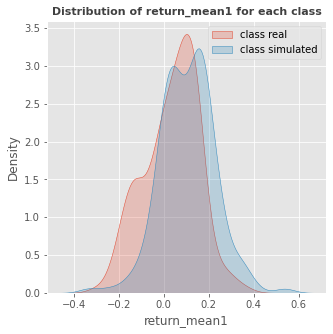

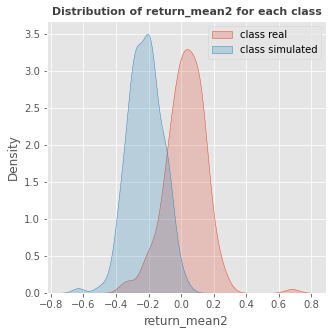

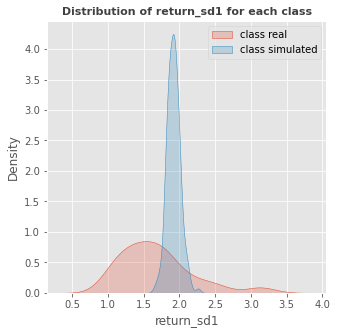

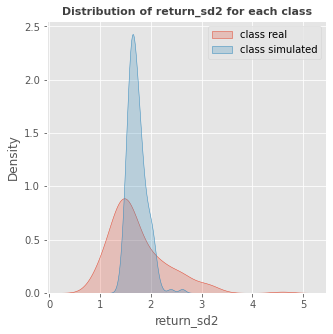

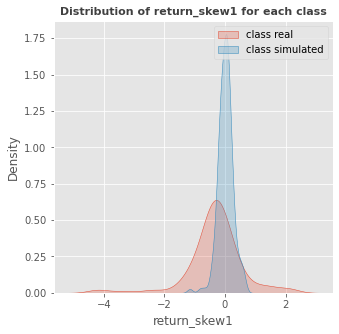

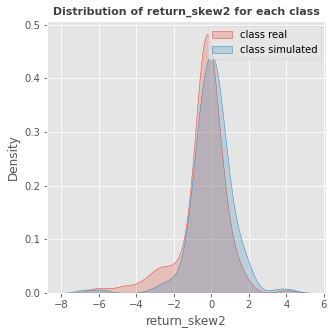

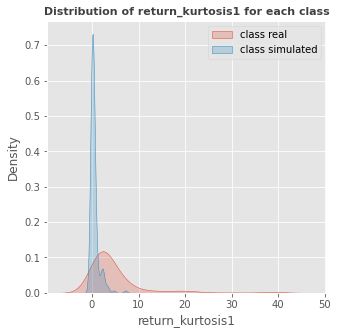

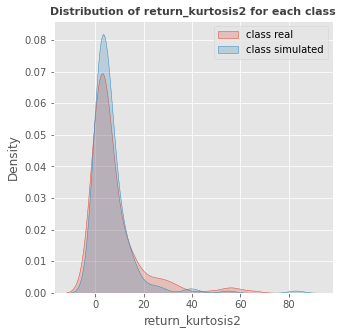

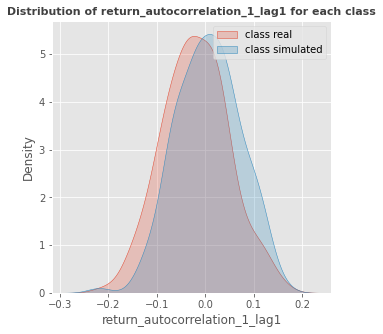

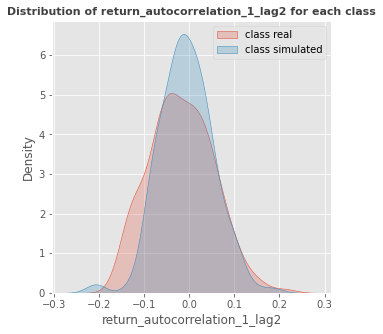

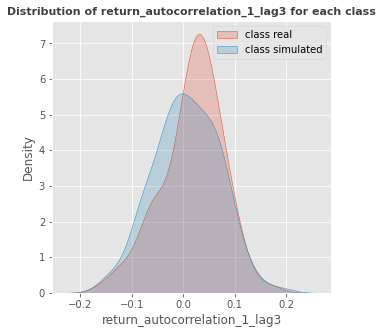

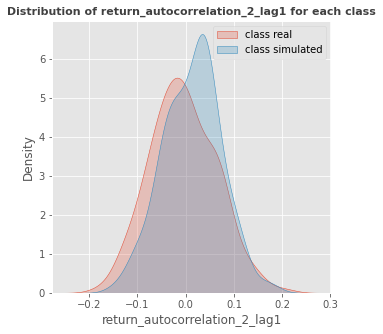

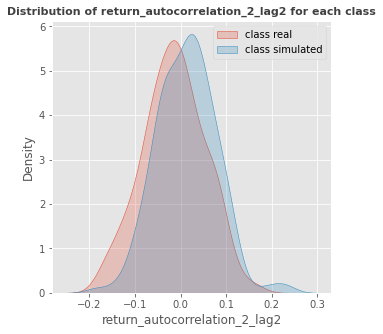

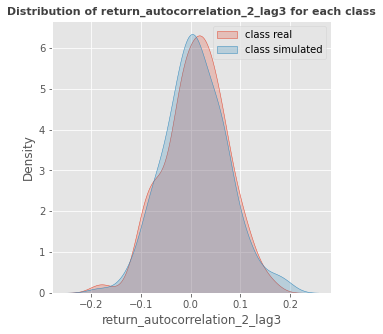

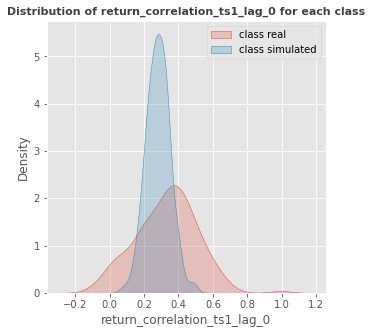

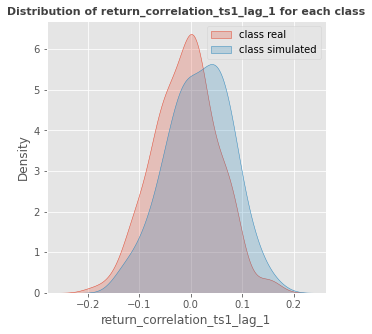

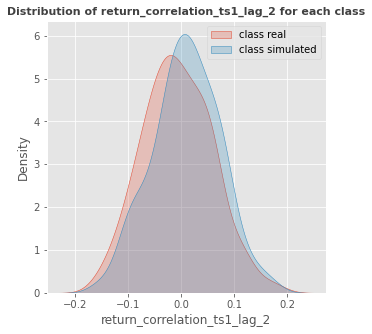

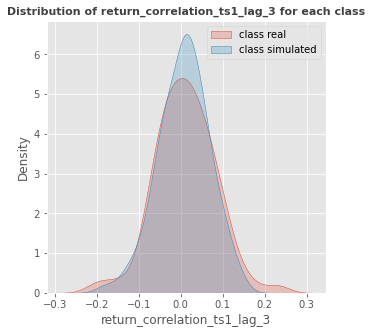

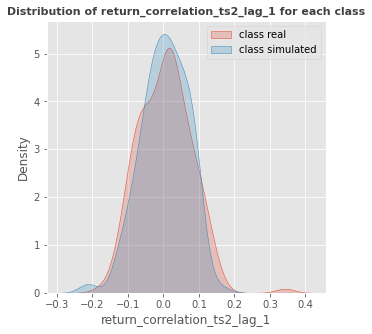

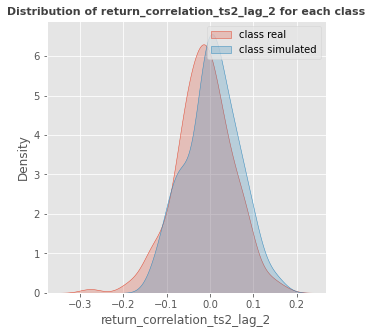

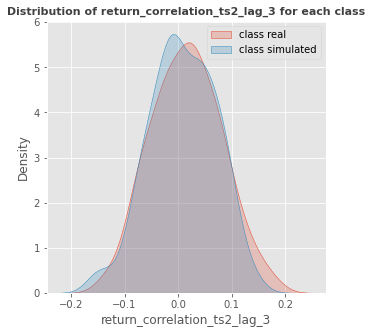

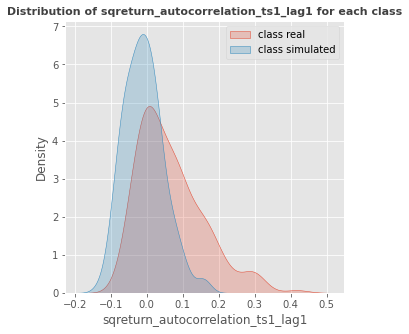

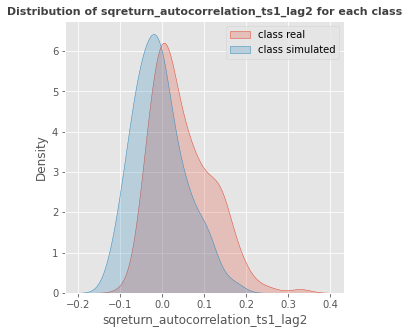

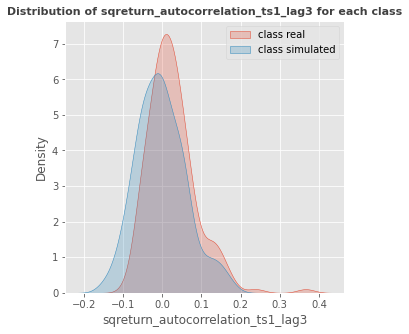

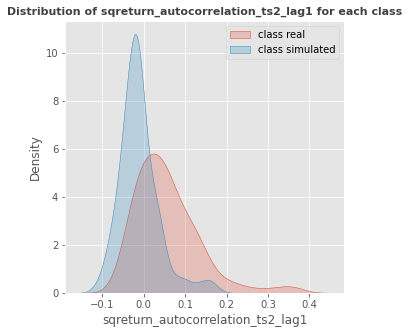

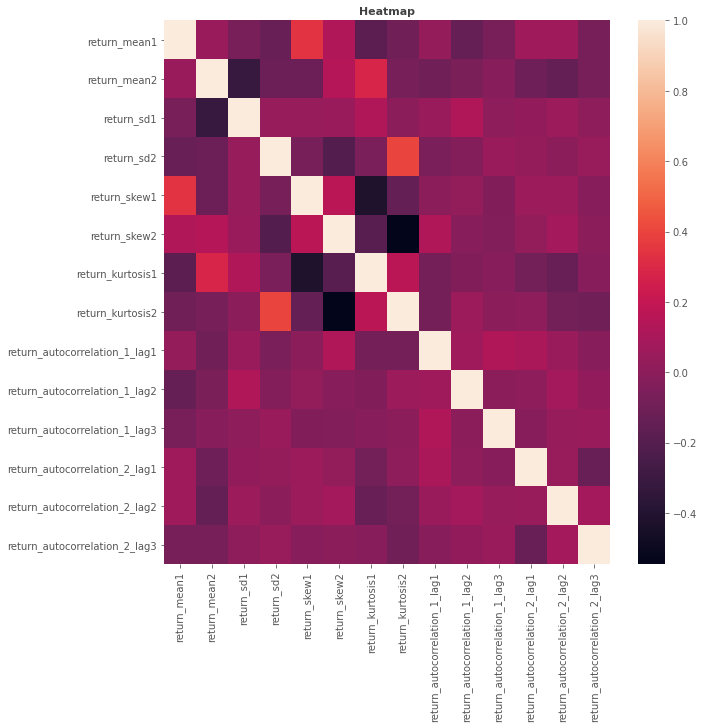

In [24]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_jumpou_log_prices = n_jumpou_simulation(
        random_seed=random_seed, num_sim=248,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=params[12], 
        beta1=beta1, beta2=beta2, 
        delta0=params[13], 
        mu1=params[14], mu2=params[15], 
        lambda11=params[16], lambda12=lambda12, 
        lambda21=lambda21, lambda22=1/params[16],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)

    n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
    n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

    n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")
    n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv")
    
    
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:36]
    y = dataset.iloc[:, 36]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)
EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_oujump")



In [25]:
print(results)
print(accuracy_average)
print(accuracy_std)

[0.9731543624161074, 0.9664429530201343, 0.959731543624161, 0.9395973154362416, 0.9731543624161074]
0.9624161073825503
0.012447810061068086
